### Flight Delay Prediction
#### MIDS W261: Machine Learning at Scale | Fall 2021 | Final Project
Team 8 - Ferdous Alam, Yao Chen, Toby Petty, Zixi Wang

### 1 - Introduction 

Flight delays are a widespread problem in the United States and across the globe. The impact of flight delay can be a risk that represents financial losses, the dissatisfaction of passengers, time losses, loss of reputation and bad business relations. (M. Kešel'ová; P. Hanák). The ability to predict flight delays will help to reduce strain on the air travel system and result in significant financial savings for airlines and passengers.

Typically, U.S. airline flight delays are related to direct causes, such as arrival queueing and weather conditions, and indirect ones like seasonal influences and internal airline regulation and procedural changes. According to statistics from the World Bank, the number of global air travelers grew tenfold between 1970 and 2019 [1]. To improve the efficiency of the air traffic network, the air transportation sector has developed and implemented new technologies.

The nature of predicting flight delays is cumbersome because of the complexity in air transportation system, the number of methods for prediction, and the massive amount of available flight data. The usual approaches of predictive modeling of flight delays uses statistical analysis, probabilistic models, operational research and machine learning methods, which we will be using.

Flight delays are most frequently caused by delays of previous flights of the same plane. These previous delayed flights are the main culprit of long delays and the frequency of delay occurrence caused by this reason increases significantly during the day. [3]

##### 1-1 Question Formulation
  
Delayed flights are defined by the Federal Aviation Administration as a flight which arrives or departs more than 15  minutes later than scheduled. In 2019, the arrival delay rate was 19.2% and the departure delay rate was 18.18% in the United States [2]. The aim of our study is to predict departure delay as a binary yes/no feature, meaning flights that depart 15 minutes or more later than the schedule departure time (referred to as `DEP_DEL15` in the flights dataset). As the flight departure time approaches the estimates for delays will increase in accuracy, but be less valuable for airlines and passengers. Given the tradeoff between accuracy and usefulness of delay prediction we have opted to predict the departure delay 2 hours ahead of scheduled departure time.

##### 1-2 Business Case / Evaluation Metrics
  
In order to evaluate the performance of a model there are several evaluation merics that could be looked at, such as: 

\\[Precision =  \dfrac{tp}{tp + fp}\\]

\\[Recall =  \dfrac{tp}{tp + fn}\\]

\\[Accuracy =  \dfrac{tp +tn}{tp + fp + tn + fn}\\]

For our business case, we choose to place emphasis on improving recall (calculated as the percentage of correct predictions for the positive class out of all positive predictions made), trying to optimize a model where we do not lose significant accuracy but at the same time see an overall improvement in recall. The reasoning behind this is that we think the cost associated with not identifying a potentially delayed flight is higher for the passenger as well as the airline, than the cost associated with failing to predict a delayed flight.

If a flight that is predicted to be delayed actually takes off on time, the airlines will not have a substantial monetary loss. On the other hand, if we fail to identify an actual flight delay it will not only have a cascading effect on following flights, but the airlines will suffer more reputational and financial harm, and the passengers will also lose significant time and opportunity to reschedule their flights.

Therefore, we want to take a balanced approach that aligns with the business needs of the problem. Hence for the evaluation metric we focus on the F-Beta measure that will allow us to place a greater weight on recall than precision (i.e. we will be calculating a single score by generalization of the F-measure with configuring the parameter beta). The default beta value of the F-measure is 1.0. A smaller beta value, such as 0.5, gives more weight to precision and less to recall, whereas a larger beta value, such as 2.0, gives less weight to precision and more weight to recall in the calculation of the score, which we opt for:

\\[F_\beta=   \dfrac{(1 + \beta^2)(precision \cdot recall) }{ \beta^2 \cdot (precision + recall)}\\]  \\[\beta = 2\\]

### 2 - Exploratory Data Analysis

In order to understand the dataset and choose what features to keep and drop for our final joined dataset, we run a high-level EDA (Exploratory Data Analysis) on both the airlines dataset and weather dataset. We plot some graphs to visualize feature distributions and identify relevant features for feature engineering.

Refer to the Full EDA Notebook here for details: https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/EDA%20-%20Full%20Dataset.ipynb

#### Dataset Sources
Note: Path for full data in parentheses. See schema link below.
##### 1. Airline dataset (dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/)
  The airlines dataset we used for analysis is a subset (2015-2019) of the passenger flights' on-time performance data in the TranStats data collection which is provided by the U.S. Department of Transportation (DOT).
  
  https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ&flf_gnoyr_anzr=g_bagVZR_eRcbegVaT&h5r4_gnoyr_anzr=er2146v0t%20Pn44vr4%20b0-gvzr%20cr4s14zn0pr%20(EMLK-24r5r06)&lrn4_V0s1=E&Sv456_lrn4=EMLK&Yn56_lrn4=FDFE&en6r_V0s1=D&S4r37r0pB=Z106uyB&Qn6n_S4r37r0pB=N007ny,d7n46r4yB,Z106uyB

##### 2. Weather dataset (dbfs:/mnt/mids-w261/datasets_final_project/weather_data/)
 The weather dataset is collected from National Oceanic and Atmospheric Administration repository, which covers the period Jan 2015 – December 2019.
* Simplified schema: https://docs.google.com/spreadsheets/d/1v0P34NlQKrvXGCACKDeqgxpDwmj3HxaleUiTrY7VRn0/edit#gid=0
* Full PDF schema: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

##### 3. Station dataset (dbfs:/mnt/mids-w261/datasets_final_project/stations_data/)
 In addition to weather dataset, we used a provided station dataset which gave the keys to join flights data with weather data.

##### 2-1 Airlines dataset
 
After performing the preliminary analysis, we found the raw airlines dataset contains a total records count of 63,493,682 rows. However, it seems the raw airlines dataset has duplicated records and the total records count after dropping duplicates is 31,746,841. Several key properties of the dataset are listed below:

|Property|Data|
|-----------|----|
|Total flight count| 31,746,841|
|Total flight count delayed by more than 15 minutes| 5,693,541|
|% flights delayed | 17.93%|
|% flights on-time| 80.56%|
|% flights cancelled| 1.50%|
|Earliest flight date | 2015-01-01|
|Latest flight date|2019-12-31|
|Number of columns/features|107|
|Number of Unique Carriers|19|
|Number of Unique Airports|371|


 ##### Cancelled Flights

In approximately 1.5% of records in the flights dataset the outcome feature `DEP_DEL15` is null, meaning these are cancelled flights. Our EDA analysis indicated that flights are cancelled due to the following reasons: "Carrier", "Weather", "National Air System", "Security". We take out these cancelled flights from the dataset since they are null for the feature we are trying to predict (`DEP_DEL15`), and are therefore not relevant, and also minimal in number. 

 ##### Class Imbalance for Departure Delays

The total number of flights delayed by more than 15 minutes is 5,693,541, which is about 17.9% of the total number of flights, and the total proportion of on-time flights is 80.6%. This shows a class imbalance which could lead to a prediciton bias towards the "on time flight", since our model algorithms tend to behave in favor of the majority class to acheive high accuracy.

We also observed results from our initial baseline model using a three-month toy sample of the dataset that produced a low recall and F-1 score, which is caused by many false negatives (when the model predicts the flight is not delayed, but it is actually delayed). Therefore, for future steps, we plan to account for the class imbalance by utilizing a balancing ratio in a weight column with the class weight option. 

The figure below shows the `DEP_DELAY_GROUP` field which groups delay times by 15 minute intervals. As expected, the Departure Delay Group distribution is skewed to the right since the majority of flights are delayed less than 15 minutes.

###### Count of Flights by Departure Delay Group


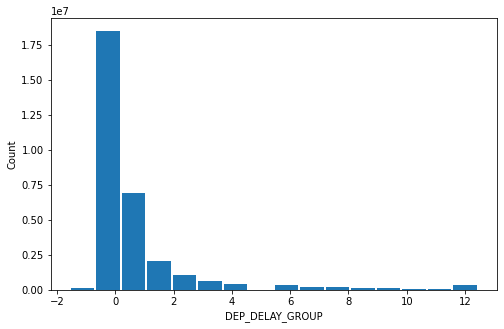

In [0]:
displayHTML("<img src ='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfgAAAFJCAYAAAB3vj+vAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAAaMklEQVR4nO3debRdZZ3m8e9jmMQJNFcagRAsaSdU0FtQKqVYTnEiWq2SLLWwSipltVgO1XZDuxbYWNbS0lXa3Q6YpWkcg0qJFTUyKCh2K0pAZBI0IkpSaBCcpWAFf/3H2VcPl3uTG7g75973fj9rnXXPft+99/lthvWcPZz3TVUhSZLaco9RFyBJkmafAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDWouYBPsibJliRXzGDddya5tHt9N8nPd0KJkiT1Lq39Dj7Jk4BfAx+uqkN2YLtXA4dV1V/1VpwkSTtJc2fwVXUBcPNwW5I/SnJWkouTfDXJw6bYdCWwdqcUKUlSz3YZdQE7yWrglVX1vSRHAO8F/myiM8mBwEHAeSOqT5KkWdV8wCe5N/AE4FNJJpp3n7TaCuCMqrp9Z9YmSVJfmg94Brchfl5Vh25jnRXAq3ZOOZIk9a+5e/CTVdUvgR8keRFABh4z0d/dj98b+PqISpQkadY1F/BJ1jII64cm2ZTkFcBLgFck+TZwJbB8aJMVwOnV2s8JJEkLWnM/k5MkSQ2ewUuSJANekqQmNfUU/eLFi2vp0qWjLkOSpJ3i4osv/mlVjU3V11TAL126lA0bNoy6DEmSdookP5yuz0v0kiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNamos+vlo6Qmf73X/1731Ob3uX5I0N3kGL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQAS9JUoN6G8kuyRrgucCWqjpkiv43AC8ZquPhwFhV3ZzkOuBXwO3A1qoa76tOSZJa1OcZ/GnAsuk6q+rtVXVoVR0KnAh8papuHlrlKV2/4S5J0g7qLeCr6gLg5u2uOLASWNtXLZIkLTQjvwefZE8GZ/r/MtRcwDlJLk6yajSVSZI0f82F2eSeB/y/SZfnj6yqzUkeCJyb5OruisCddF8AVgEsWbKk/2olSZoHRn4GD6xg0uX5qtrc/d0CnAkcPt3GVbW6qsaranxsbKzXQiVJmi9GGvBJ7gc8GfjXobZ7JbnPxHvgGcAVo6lQkqT5qc+fya0FjgIWJ9kEnAzsClBVp3arvQA4p6p+M7TpPsCZSSbq+3hVndVXnZIktai3gK+qlTNY5zQGP6cbbrsWeEw/VUmStDDMhXvwkiRplhnwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDXIgJckqUEGvCRJDTLgJUlqkAEvSVKDDHhJkhpkwEuS1CADXpKkBhnwkiQ1qLeAT7ImyZYkV0zTf1SSXyS5tHudNNS3LMk1STYmOaGvGiVJalWfZ/CnAcu2s85Xq+rQ7nUKQJJFwHuAZwGPAFYmeUSPdUqS1JzeAr6qLgBuvgubHg5srKprq+o24HRg+awWJ0lS40Z9D/7xSb6d5AtJHtm17QdcP7TOpq5NkiTN0C4j/OxLgAOr6tdJng18Bjh4R3eSZBWwCmDJkiWzWqAkSfPVyM7gq+qXVfXr7v16YNcki4HNwAFDq+7ftU23n9VVNV5V42NjY73WLEnSfDGygE/yH5Kke394V8tNwEXAwUkOSrIbsAJYN6o6JUmaj3q7RJ9kLXAUsDjJJuBkYFeAqjoVeCHwt0m2ArcAK6qqgK1JjgfOBhYBa6rqyr7qlCSpRb0FfFWt3E7/u4F3T9O3HljfR12SJC0Eo36KXpIk9cCAlySpQQa8JEkNMuAlSWqQAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDXIgJckqUEGvCRJDTLgJUlqkAEvSVKDDHhJkhpkwEuS1CADXpKkBhnwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQb0FfJI1SbYkuWKa/pckuSzJ5Um+luQxQ33Xde2XJtnQV42SJLWqzzP404Bl2+j/AfDkqnoU8GZg9aT+p1TVoVU13lN9kiQ1a5e+dlxVFyRZuo3+rw0tXgjs31ctkiQtNHPlHvwrgC8MLRdwTpKLk6waUU2SJM1bvZ3Bz1SSpzAI+COHmo+sqs1JHgicm+Tqqrpgmu1XAasAlixZ0nu9kiTNByM9g0/yaOADwPKqummivao2d3+3AGcCh0+3j6paXVXjVTU+NjbWd8mSJM0LIwv4JEuATwMvq6rvDrXfK8l9Jt4DzwCmfBJfkiRNrbdL9EnWAkcBi5NsAk4GdgWoqlOBk4AHAO9NArC1e2J+H+DMrm0X4ONVdVZfdUqS1KI+n6JfuZ3+44Djpmi/FnjMnbeQJEkzNVeeopckSbPIgJckqUEGvCRJDTLgJUlqkAEvSVKDDHhJkhpkwEuS1CADXpKkBhnwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQAS9JUoNmFPBJnjiTNkmSNDfM9Az+f8+wTZIkzQG7bKszyeOBJwBjSV4/1HVfYFGfhUmSpLtumwEP7Abcu1vvPkPtvwRe2FdRkiTp7tlmwFfVV4CvJDmtqn64k2qSJEl300zvwe+eZHWSc5KcN/Ha3kZJ1iTZkuSKafqT5H8l2ZjksiSPHeo7Nsn3utexM6xTkiSx/Uv0Ez4FnAp8ALh9B/Z/GvBu4MPT9D8LOLh7HQG8Dzgiyf2Bk4FxoICLk6yrqp/twGdLkrRgzTTgt1bV+3Z051V1QZKl21hlOfDhqirgwiR7JdkXOAo4t6puBkhyLrAMWLujNUiStBDN9BL9Z5P85yT7Jrn/xGsWPn8/4Pqh5U1d23TtkiRpBmZ6Bj9xD/wNQ20FPHh2y9lxSVYBqwCWLFky4mokSZobZhTwVXVQT5+/GThgaHn/rm0zg8v0w+1fnqa21cBqgPHx8eqjSEmS5psZBXySv5iqvaqme3huptYBxyc5ncFDdr+oqhuSnA38Y5K9u/WeAZx4Nz9LkqQFY6aX6P946P0ewFOBS5j+6XgAkqxlcCa+OMkmBk/G7wpQVacC64FnAxuB3wJ/2fXdnOTNwEXdrk6ZeOBOkiRt30wv0b96eDnJXsDpM9hu5Xb6C3jVNH1rgDUzqU+SJN3RXZ0u9jdAX/flJUnS3TTTe/CfZfDUPAwmmXk48Mm+ipIkSXfPTO/Bv2Po/Vbgh1W1qYd6JEnSLJjRJfpu0pmrGcwotzdwW59FSZKku2dGAZ/kxcA3gRcBLwa+kcTpYiVJmqNmeon+jcAfV9UWgCRjwBeBM/oqTJIk3XUzfYr+HhPh3rlpB7aVJEk72UzP4M/qRpebmM3tGAaD1EiSpDlomwGf5CHAPlX1hiR/DhzZdX0d+FjfxUmSpLtme2fw76IbA76qPg18GiDJo7q+5/VYmyRJuou2dx99n6q6fHJj17a0l4okSdLdtr2A32sbffecxTokSdIs2l7Ab0jy15MbkxwHXNxPSZIk6e7a3j341wJnJnkJfwj0cWA34AU91iVJku6GbQZ8Vf0EeEKSpwCHdM2fr6rzeq9MkiTdZTOdD/584Pyea5EkSbPE0egkSWqQAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDXIgJckqUEGvCRJDTLgJUlqkAEvSVKDeg34JMuSXJNkY5ITpuh/Z5JLu9d3k/x8qO/2ob51fdYpSVJrZjQW/V2RZBHwHuDpwCbgoiTrquqqiXWq6nVD678aOGxoF7dU1aF91SdJUsv6PIM/HNhYVddW1W3A6cDybay/EljbYz2SJC0YfQb8fsD1Q8uburY7SXIgcBAwPA3tHkk2JLkwyfN7q1KSpAb1dol+B60Azqiq24faDqyqzUkeDJyX5PKq+v7kDZOsAlYBLFmyZOdUK0nSHNfnGfxm4ICh5f27tqmsYNLl+ara3P29Fvgyd7w/P7ze6qoar6rxsbGxu1uzJElN6DPgLwIOTnJQkt0YhPidnoZP8jBgb+DrQ217J9m9e78YeCJw1eRtJUnS1Hq7RF9VW5McD5wNLALWVNWVSU4BNlTVRNivAE6vqhra/OHA+5P8jsGXkLcOP30vSZK2rdd78FW1Hlg/qe2kSctvmmK7rwGP6rM2SZJa5kh2kiQ1yICXJKlBBrwkSQ2aK7+DV8+WnvD53vZ93Vuf09u+JUl3jWfwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDXIgJckqUEGvCRJDTLgJUlqkAEvSVKDDHhJkhrUa8AnWZbkmiQbk5wwRf/Lk9yY5NLuddxQ37FJvte9ju2zTkmSWrNLXztOsgh4D/B0YBNwUZJ1VXXVpFU/UVXHT9r2/sDJwDhQwMXdtj/rq15JklrS5xn84cDGqrq2qm4DTgeWz3DbZwLnVtXNXaifCyzrqU5JkprTZ8DvB1w/tLypa5vsPyW5LMkZSQ7YwW0lSdIURv2Q3WeBpVX1aAZn6R/a0R0kWZVkQ5INN95446wXKEnSfNRnwG8GDhha3r9r+72quqmqbu0WPwA8bqbbDu1jdVWNV9X42NjYrBQuSdJ812fAXwQcnOSgJLsBK4B1wysk2Xdo8WjgO937s4FnJNk7yd7AM7o2SZI0A709RV9VW5MczyCYFwFrqurKJKcAG6pqHfB3SY4GtgI3Ay/vtr05yZsZfEkAOKWqbu6rVkmSWtNbwANU1Xpg/aS2k4benwicOM22a4A1fdYnSVKrRv2QnSRJ6oEBL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQAS9JUoMMeEmSGmTAS5LUIANekqQGGfCSJDXIgJckqUEGvCRJDTLgJUlqkAEvSVKDDHhJkhpkwEuS1CADXpKkBhnwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSg3oN+CTLklyTZGOSE6bof32Sq5JcluRLSQ4c6rs9yaXda12fdUqS1Jpd+tpxkkXAe4CnA5uAi5Ksq6qrhlb7FjBeVb9N8rfAPwHHdH23VNWhfdUnSVLL+jyDPxzYWFXXVtVtwOnA8uEVqur8qvptt3ghsH+P9UiStGD0GfD7AdcPLW/q2qbzCuALQ8t7JNmQ5MIkz++hPkmSmtXbJfodkeSlwDjw5KHmA6tqc5IHA+clubyqvj/FtquAVQBLlizZKfVKkjTX9XkGvxk4YGh5/67tDpI8DXgjcHRV3TrRXlWbu7/XAl8GDpvqQ6pqdVWNV9X42NjY7FUvSdI81mfAXwQcnOSgJLsBK4A7PA2f5DDg/QzCfctQ+95Jdu/eLwaeCAw/nCdJkraht0v0VbU1yfHA2cAiYE1VXZnkFGBDVa0D3g7cG/hUEoAfVdXRwMOB9yf5HYMvIW+d9PS9JEnahl7vwVfVemD9pLaTht4/bZrtvgY8qs/aJElqmSPZSZLUoDnxFL3asPSEz/e6/+ve+pxe9y9JLfEMXpKkBhnwkiQ1yICXJKlBBrwkSQ0y4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWqQs8lp3ulz1jpnrJPUCs/gJUlqkAEvSVKDDHhJkhpkwEuS1CADXpKkBvkUvTSFPp/UB5/Wl9Q/z+AlSWqQAS9JUoO8RC+NkIP2SOqLAS9pVvhlRS1o6fmbXi/RJ1mW5JokG5OcMEX/7kk+0fV/I8nSob4Tu/ZrkjyzzzolSWpNb2fwSRYB7wGeDmwCLkqyrqquGlrtFcDPquohSVYAbwOOSfIIYAXwSOBBwBeT/Mequr2veiXNfTvr7MqrEWpBn5foDwc2VtW1AElOB5YDwwG/HHhT9/4M4N1J0rWfXlW3Aj9IsrHb39d7rPdO/J9cUl/8sqK+9Rnw+wHXDy1vAo6Ybp2q2prkF8ADuvYLJ227X3+lSpLuKr+szE2pqn52nLwQWFZVx3XLLwOOqKrjh9a5oltnU7f8fQZfAt4EXFhVH+3aPwh8oarOmOJzVgGrusWHAtdMUc5i4KezdGhz2UI5Tlg4x+pxtmWhHCcsnGMd9XEeWFVjU3X0eQa/GThgaHn/rm2qdTYl2QW4H3DTDLcFoKpWA6u3VUiSDVU1vkPVz0ML5Thh4Ryrx9mWhXKcsHCOdS4fZ59P0V8EHJzkoCS7MXhobt2kddYBx3bvXwicV4NLCuuAFd1T9gcBBwPf7LFWSZKa0tsZfHdP/XjgbGARsKaqrkxyCrChqtYBHwQ+0j1EdzODLwF0632SwQN5W4FX+QS9JEkz1+tAN1W1Hlg/qe2koff/Drxomm3fArxllkrZ5iX8hiyU44SFc6weZ1sWynHCwjnWOXucvT1kJ0mSRsfJZiRJatCCCfgkb09ydZLLkpyZZK9R1zSbtjcscAuSHJDk/CRXJbkyyWtGXVOfkixK8q0knxt1LX1KsleSM7r/P7+T5PGjrqkPSV7X/Xd7RZK1SfYYdU2zJcmaJFu6nz5PtN0/yblJvtf93XuUNc6GaY5zzmbLggl44FzgkKp6NPBd4MQR1zNrhoYFfhbwCGBlN9xva7YCf19VjwD+BHhVo8c54TXAd0ZdxE7wP4GzquphwGNo8JiT7Af8HTBeVYcwePB4xWirmlWnAcsmtZ0AfKmqDga+1C3Pd6dx5+Ocs9myYAK+qs6pqq3d4oUMflvfit8PC1xVtwETwwI3papuqKpLuve/YhAETY5wmGR/4DnAB0ZdS5+S3A94EoNf1FBVt1XVz0daVH92Ae7ZjfmxJ/BvI65n1lTVBQx+CTVsOfCh7v2HgOfvzJr6MNVxzuVsWTABP8lfAV8YdRGzaKphgZsMvgndzIOHAd8YcSl9eRfwX4HfjbiOvh0E3Aj8n+52xAeS3GvURc22qtoMvAP4EXAD8IuqOme0VfVun6q6oXv/Y2CfURazk8ypbGkq4JN8sbu/Nfm1fGidNzK41Pux0VWquyPJvYF/AV5bVb8cdT2zLclzgS1VdfGoa9kJdgEeC7yvqg4DfkMbl3LvoLv/vJzBF5oHAfdK8tLRVrXzdAOYNf2TrbmYLb3+Dn5nq6qnbas/ycuB5wJPrbZ+HzjjoX3nuyS7Mgj3j1XVp0ddT0+eCByd5NnAHsB9k3y0qloMhE3ApqqauBJzBg0GPPA04AdVdSNAkk8DTwA+OtKq+vWTJPtW1Q1J9gW2jLqgvszVbGnqDH5bkixjcMnz6Kr67ajrmWUzGRZ43uumEv4g8J2q+udR19OXqjqxqvavqqUM/l2e12i4U1U/Bq5P8tCu6anccUrpVvwI+JMke3b/HT+VBh8mnGR4KPJjgX8dYS29mcvZsmAGuumGw92dwWQ2MJit7pUjLGlWdWd77+IPwwLP1iiAc0aSI4GvApfzh3vT/70bMbFJSY4C/ktVPXfEpfQmyaEMHibcDbgW+Muq+tlIi+pBkv8BHMPgMu63gOOq6tbRVjU7kqwFjmIws9pPgJOBzwCfBJYAPwReXFWTH8SbV6Y5zhOZo9myYAJekqSFZMFcopckaSEx4CVJapABL0lSgwx4SZIaZMBLktQgA16SpAYZ8NIckOT2JJd204l+O8nfJ7lH13dUkl90/ROvp03a7ookn0qyZw+f8ett7PNdSTYnuUeSPbppMx811P+GJO/fxvYHJ/lcku8nuTiD6YCf1PW9PMmNXS1XJ3ndpG1Xde1XJ/lmN07CRN91SRYPLR+VbtrdSfu9KslfT1efNJ81NVStNI/dUlWHAiR5IPBx4L4MBtIA+Oo0g90Mb/cx4JXAdKP83dXPmFL35eAFDCY6enJVnZ/ktcB7u5B+UFfP+DTb7wF8nsFAPuu6tkO69S/oVvtEVR2f5AHANUnOqKrru/H6/wY4sqp+muSxwGeSHN6Njrc9E/t9IHBlknVV9ZOZHrs0H3gGL80xVbUFWAUc3w1rOlNfBR7S82cMOwq4EngfsLLb71kMZkv7C+CdwJu2MSrdS4CvT4R7t/0VVXXaFPXeBGwE9u2a/hvwhqr6add/CYMpSV+1IwfQ/XP4PnDgjmwnzQcGvDQHVdW1DIYdfmDX9KeTLp//0fD6Gcwx/iwGw/j28hlTWAmsBc4EntNNBATwWuAtwFhVfWQb2z8SuGQmtSZZwmDincuGtp08296Grn3GkjwYeDCDLw9SU7xEL80P010+v2eSSyfWYTAZz2x/xp10kxo9G3h9Vf0qyTeAZwKfq6p/S3Ie8Lkd+fAkZwIHA9+tqj/vmo/pLvc/DDi+qv59hrubagzu4bZjunv2twJ/M9/HSJemYsBLc1B3Znk7gyk2H76NVX9/X73Hz5jKM4G9gMu7K/x7Arfwh1D/HX+YEGg6VwJPmlioqhckGQfeMbTOxL3yceCc7l75jxnMOPc44LyhdR/X7RMGE3/sDfy0W77/0Pvf73cGxynNW16il+aYJGPAqcC7+5pbehY+YyWD2dCWdtPaHgQ8fVtP8U/h48ATkxw91Dbl9lW1AfgI8Jqu6Z+At3UP303MSPdy4L1d/5eBl3V9i4CXAufvQG3SvOcZvDQ3TFxq35XBdKIf4Y5Pw//p0KV4gH+oqjN20mfsmWTTUPt7gWUMnpAHoKp+k+T/As8DPjGTYqrqlu5p+H9O8i4G02/+CviHaTZ5G3BJkn+sqnVJ9gO+lqS67V5aVTd0674ZeF+SbwMBzgI+OpO6pFY4XawkSQ3yEr0kSQ3yEr3UkO6e9Jem6Hpq91vyna4b2W7yz+VuraojRlGPtFB4iV6SpAZ5iV6SpAYZ8JIkNciAlySpQQa8JEkNMuAlSWrQ/wc0iYoSgFcCaQAAAABJRU5ErkJggg==''>")

##### Time-related Factors

Intuitively we suspect that flight delays are strongly impacted by seasonality and time-related factors. Therefore we further explored a few time features in relation to the flight departure delays and plot histogram graphs of the distributions, and observe the following patterns:

* (1) Hour of Day: the number of departure delays generally increases rapidly in the afternoon and peaks between 4 - 7 pm.
* (2) Day of Week: Thursday and Friday have slightly more delays in a week.
* (3) Day of Month: close to uniform distribution.
* (4) Quarter: close to uniform distribution with slightly more delays in Q2 and Q3.
* (5) Month of Year: June to August and December have more delays in a year. This might relate to seasonality and holiday travel which we can consider for feature engineering.


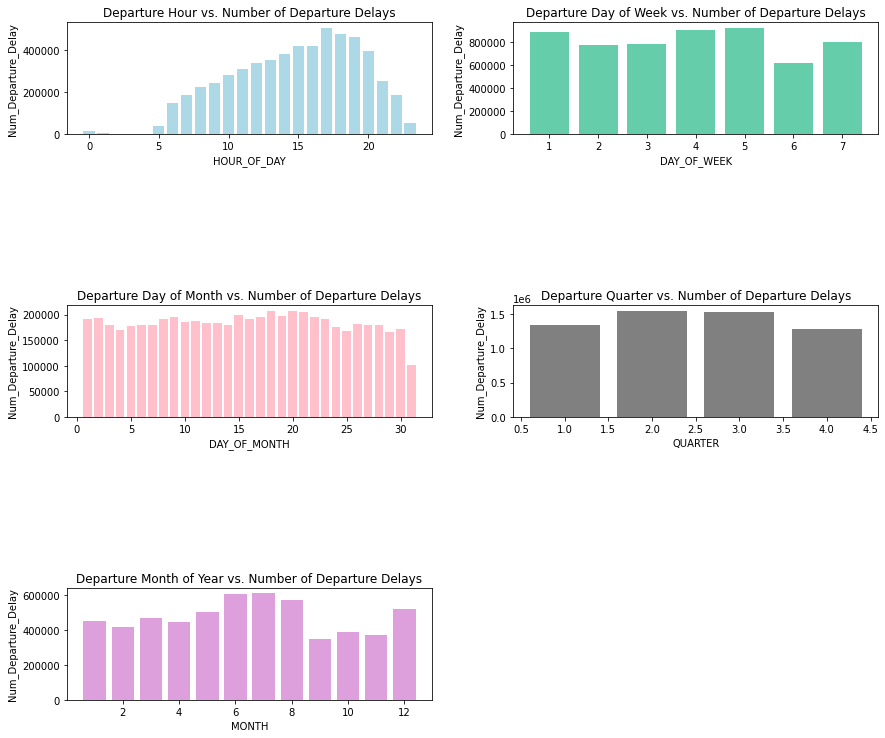

In [0]:
displayHTML("<img src = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA3UAAALiCAYAAAB+Gv9vAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAACN8UlEQVR4nOzdd5g1ZX3/8feHoqJSBRFpj4UY0URFAlii2LFiF2xgVDRKJMZfxBZBo0YTezRWEFABERsaDBIVUSNKEVFE5RFReu+KCnx/f8y9cJ7l7O45++w+u7PP+3Vde+0597TvlDP3fGfumUlVIUmSJEnqpzUWOgBJkiRJ0uyZ1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJq4kkByV52wJNO0k+leSKJD9aiBhWBwu5jiUtnCSbJjk+yTVJ3rOAcRyX5CULNf1VLcn+ST6zgNN/W5JLk1y4UDEsdQu9jsdhUrfIJTk7yR/ajvrKJP+X5OVJFmTdJVmWpJKstQqneatKIsnOSc5dVTHMh7ZuL05yh4GylyQ5bgHDmi8PBR4DbFFVO0zumGTPJDcmubb9/aYlgX+x6kO9OaZVmiC1bfqmgWVwbpIjkvzNqopBGpV108110/VtGVyd5OQkr0ty21UVw4C9gEuB9arqNZPifFCLcc2Bsk9MUfbRVRfy3BtYJ1sOlD06ydkLGNa8SLIV8Bpg26q6y5Dui65OWdUJ0sB+YWIZXJTka0kes6piWJVM6vrhyVW1LrA18E5gX+CAVR3EXFSW7YrNot3uVuUBQbMmsM8qnuZKGzwQGNHWwNlVdd00/fygqu4IrA88GvgDcHKS+84yzFmbxfwNG8dstqXz2zJYF9gJ+AXw3SSPWtl4pHlg3QR7t2WwGd0B9m7A0UmysjGNaWvg51VVQ7qdRHe8t91A2d8C504qexhw/LxFuOpcB/zLQgcxrllsx1sBl1XVxdP0s2jqlDn6nc52HBu05XA/4FjgS0n2XNl4FptFe3CtW6uqq6rqKOA5wB4TB7tJbpvk3Ul+185CfDTJOq3bzu3szBvaJfqzkzxvYpxJnpjkx+0s4zlJ9h/oNnGG48VJfgd8i1t2+Fe2sx4PmnzmZfIZ03bm7O1Jvg/8Hrh7kr9McmySy5P8MsmzV2bZJLlrkqPa+JYneelAtxWuuGTSVb62TPZNchpw3eSdRpKPJHn3pLKvJPmn9nnfJOe1s56/HHNn+R/A/0uywZB5utWZ5wxctUx3dev7Sd6X7kz5WUke3MrPSXcVcI9Jo924LfdrknwnydYD455ynbRl+JEkRye5DnjEkHiHroMkLwY+CTyobTNvmW6BVNWNVfXrqnoF8B1g/4Fp7JTuisCVSX6SZOdJy+bfkvyobc9fSbLRQPfPJ7kwyVXpmindZ5r5ezHwPOC1Leavtv4qyT0nDfe29nnit7ZvuqYwn0qyRroz979Oclm6s6Q3xzTNMqiqOreq3tyW3bsGpjnSbyfJhunOSF6Srtnr15Js0bo9K8nJk/r/pyRfaZ+fkOTnbTs5L8n/mylmrb6sm6Cqrquq44CnAA8CntimsUOSH7R91gVJPpTkNq3bhzOpqWTbh7562DTS7d9PbPuwE5M8uJUfBOzBLfurR0+K7c/ACXRJG0nuDNwGOGJS2V8Ax8+035puPzwp3s2SnJbkn4d02zfJkZPKPpDkg+3znunqtGvStdx43uRxTOODwO5J7jFFXKPsx1+brg69IMlT2z7xV227eMOkUd4uyedarKckud/AuO+a5AttP/ybJK8a6LZ/kiOTfCbJ1cCeQ2JdP8khbfjfJnlTWz+PpktO7trW+UHTLZDZ1ilt2Xw0Ux83fKD9PieuVP/tNPP3cuANwHNazD9p/Z09uM0O/m4z/LdOkr9Lcka6uu2YwZhmWA4XVtUH6I4r3pV2Ime69TRZpjiWSPI36fZzg1e/nz4wnzskOaktq4uSvHeUmMdSVf4t4j/gbODRQ8p/B/x9+/w+4ChgI7qzMV8F/q112xm4AXgvcFvg4XRnse410P2v6BL8vwYuAp7aui0DCjgEuAOwzkDZWgOx7A98ZuD7Cv0Ax7V47wOsRXcl5hzgRe37A+iajWw7xTI4DnjJpLKdgXMHvh8P/BdwO+D+wCXAI1u3g4C3TTPs2cCpwJbAOkOm/7AWb9r3DemuIt0VuFfrdteBeb/HOOsW+OJEfMBLgOOGLcfJy4KuArihLcc1gbe15fzhtq4fC1wD3HFgOVzT5ue2wAeA77Vud5hunbRhrwIeQret3G7I/Ey3DvacmNYUy2Jod+DvgIva582By4AntBge075vMrBszgPu2+bnC6y4Xf4d3e/jtsD7gVMHut1q/pi03bT+CrjnpOEm1t3ObX28q01jHbqrsCcAW7SyjwGHTbEMdmZguxwofyRwU5unUdbTRDx3Ap4B3L7N9+eBL7dutwUuB+49MJ0fA89ony8A/nZge99uofeF/i2uP6ybJoZ/yZDy44F3tc8PpLtCslab/hnAP7ZuOwDnA2u07xvTJZebDhnnRsAVwAvauHZv3+/Uut/8258i1v2Ar7TPz2zL7jGTys5qn6fcbzHafvglwN2AXwF7TRHP1m1e123f16Tb7+zU1unVA9vCZsB9RtwuJ6b/3ol1T1fPnj3Qzyj78TcDawMvpavLDqXbhu9DV//fbWAb+3NbfmsD/w/4Tfu8BnByG9dtgLsDZwGPmzTsU1u/w44/DgG+0qa9rC3TFw/Eeqs6Y2DYod0Zv04ZetzQuj+frq5Zi+5K9YW044Nh88ek3+SwfclgPwz/re8KLAfu3ab7JuD/plgGE8OvNan87q383iOup1GPJX4OPH7g+5eA17TPPwBe0D7fEdhprvfLXqnrr/OBjZKEri39q6vq8qq6BngHXROQQf9SVX+squ8A/w08G6Cqjquqn1bVTVV1GnAYXeU6aP/qzkL+YSXiPaiqTq+qG4Bd6Hawn6qqG6rqx3QH4M+aZvgPtrOCVya5EvjaRId0becfAuxbVddX1al0Z6JeOEZ8H6yqc6aYx+/S/fgnzkA9k66p4PnAjXQ/7G2TrF1VZ1fVr8eYLnQ7kn9IssmYwwH8pi3HG4HP0SWmb23r+hvAn4B7DvT/31V1fFX9EXgj3dWzLYEnMfM6+UpVfb9tK9cPBjFH62CY8+kOZqCrPI6uqqNbDMfSNSt6wkD/n66qn1XXzPNfgGdPnDWrqgOr6po27/sD90uy/ijzN4abgP3a8v8D3ZnJN1Z3hnRius/MeE1IzgcCbMBo6wmAqrqsqr5QVb9v+4W3037bLZbP0S1T2pnGZdzyu/oz3Ta9XlVdUVWnjLUUtDpb3eqmYW7eb1XVyVV1Qhvf2XQJ0sTv8Ed0J5MmWnfsRndS76Ih43wicGZVfbqN6zC6pnRPHjGm7wAPbevlb+nqtR8AOw2Ufaf1O91+a5T98LbAt+n2hR8fFkxV/RY4BXhaK3ok8PuqOqF9vwm4b5J1quqCqjp9xPmc8G/AkzPQImMMfwbeXt0VzsPpku0PtPrjdLoD9/sN9H9yVR3Z+n8v3UnBnYC/oUt231pVf6qqs4BPsOJv4AdV9eW2LFfYjlvdtRvw+jbts4H30CX2K2PcOmWq4waq6jOtrrmhqt5Ddzx0r1Hmb0yDv/WX050cOqP9bt8B3H/Uq3XN+e3/Roy2nm42w7HEwdxSr24EPI7uhAB029U9k2xcVdcObOtzxqSuvzanO9O+Cd2Z+JMHEp7/aeUTrqgV72X6Ld1VJpLsmOTb7ZLzVXQ/lo0nTeucOYh3cBxbAztOStKeB9zqRt8Br6qqDSb+6HZEE+4KTBw0TPgt3TKaTXwrqKqi27Hv3oqeC3y2dVsO/CPdD/viJIcnuesY06WqfkZ3MP26cYZrBiv/P7TxTS6748D3m+ezqq6l24buymjrZLrtYC7WwTAT2zktxmdNivGhdGdxh8X4W7qzpRsnWTPJO9M1J7qa7swgrLitz8V2fsmkhHBrurb7E/GeQXciYNMxxrk53UmFKxnjt5Pk9kk+1prsXE139WCDgaYhBwPPbQd0LwCOaJUUdFf4ngD8tjW3edAY8Wr1trrVTcPcvN9K8hfpmj5f2H6H72DF+bj5ILD9//QU47wr3fIZNM4+9gS6uuC+dFddvtvqgHMGyiaasE633xplP/w8ulYTKzSvHOJQVqxXD4WuKStdU96XAxck+e8kfznifNLGcQnwIeCt4wzXXFbdiVJo9Sq3rmunqldvortXcaJeveukZfUGVtz/T7cNb0xXhw2u97mqV8epU6Y6biDJ/2vNIK9qw67P3Nerk8ezNfCBgXgvp0tSx1kuE/1ezmjrCegS7RmOJT5DdzLhDnQnqL5bVRe0bi+ma+L8i3TNpwePY+eESV0PpXty0ebA9+guk/+BrmnCRNKzfnU3hE7YMANPWKS7uXbiLMWhdM1jtqyq9YGP0v04BtUUnydcR1d5TxhWAQ4Odw7wncEkraruWFV/P3SGZzZxZnjdgbKt6CqV2cQ3zGF0Zyq3BnakO5PVDVh1aFU9lG7HUAy0VR/DfnTNPAZ3ShMHOzPFPo7BJ4Ldke4s1fmMtk6mW0YzrYPZehrdGWVajJ+eFOMdquqdA/1vOfB5K7ozY5fSHTDsStcMZ326q1Kw4rY+ef6Gze/vmX59TB7mHLqmGIMx366qxlkuTwNOaQc64/x2XkN3xnTHqlqPdu8MbZ7bWcI/0Z2hfy4DB5NVdWJV7QrcGfgy3b030rSsm25utfBAbtlvfYTuito27Xf4hknz8Rlg13T3Yd2b7vc2zPl0dcygkfex7WTTiXRX9jarql+0Tt9tZX/NLUnddPutUfbD+9Ot/0Mz/UOnPg/snO5e36dxyxUNquqYqnoMXbL4C7orJ+P6D7r7vx84qXym/fi4BuvVNeiarU7Uq7+ZtKzWrarBq5rT1auX0tVhg+t9rurVceqUoccN6e6fey1d8rJhO+F+FePXq7P5nb5sUszrVNX/TTfTkzwNuBj4JaOtpwnTHku038gPgKfTnSwdrFfPrKrd6erVdwFHTtr/rTSTuh5Jsl7L7A+na9/703ZW6BPA+9Ld6EySzZM8btLgb0lym/YjfBLdzhS6dsGXV9X1SXag22Cncwlds4i7D5SdCjwsyVbtEvTrZxjH14C/SPKCJGu3v79Jcu8Zhhuqqs4B/g/4tyS3S/LXdGdEJm6QPxV4QpKNktyF7srauNP4Md0O9pPAMVV1JUCSeyV5ZLpHWF9PdxBz0yzGv5yuOdyrBsouodt5P7+dHfo7YOiN32N4QpKHprtR/1+BE9ryW6l1MsI6GFmb17sl+U+6ewImHqwycQbsca2f26W7qX2LgcGfn2TbJLenO0N7ZDvjui7wR7p7P25Pd7Z8Jhex4nYO3bb03Db9Xbh1c7DJPgq8vZ0MIMkmSXadacLpbJ5kP7r7QyZuzB9nPa1Ltz1ema4ZyH5D+jmE7mz2n6vqe23at0nyvCTrV9ec6GpmsU1r9WHddPOV8YfT3f/0I+Dogfm4Gri2XW1aIUGsqnPpkq1PA1+oqZuoHd1ie26StZI8h66Z49em6H+Y4+nulxs8+P1eK7ugbrl1YLr91ij74T/TNd+7A3BIpniqaKvjjgM+RXdQfUab3qZJdm0HvH8ErmV29eqVdM0VXzup06mMtx+fyQPTPRBjLbrjiz/SXRn9EXBNuofCrNOmd9+M+EqBVncdQbcu1m3r45+YXb26MnXKVMcN69Ldf3gJsFaSNwPrzRDKRcCySdvEqcBubdrb093iMp2PAq/PLQ8oWT/JSE2k27a1N119+Pq2nxpnPY1yLHEI3Tb3V3TPTJiY9vOTbNKmeWUrntO61aSuH76a5Bq6swlvpGuz/aKB7vvS3TR6QrrLwf/Lim2aL6S7ofp8umaDLx84S/cK4K1t/G9mhjPyVfV7untzvp/uMvVO1bWp/xxwGt3NptNWMtU10XssXXvl81t8Ew+XmK3d6c6YnE93Y+p+VfW/rdungZ/QXSb/Rot1Ng6lOztz6EDZbeke5X0p3XzcmXbg0A6Mx7kP4K10leCglwL/TLcDuQ8rVsazcSjdzuxyurOXz4c5WyfTrYNRPCjJtXQHQMfRVQ5/U1U/bTGeQ3eG7A10lcg5dMtmcD/2abobuy+ku69hIkk+hK7Zynl090OM0pb9ALr7yq5M8uVWtg/dWe0r6ZqofHnokLf4AN3Vhm+039gJdFd6p3LXtgyupTvQ+ytg5+rujxx3Pb2f7qbyS9t0/2dIP5+ma3o1+SDhBcDZueWJZeM8eU6rD+sm+FCL8SK639wXgF3agRt0D854Lt3DJj7B8PrnYLrf+lRNL6mqy+iS3tfQ1QevBZ5UVZdON0+TfIeujvreQNn3Wtl3B8qm3G+NuB+mqv5Ed7ViU+DAqRI7htera9AlL+fT1VUPpyXDSf627SNH9QG6pqODxt2Pz+QrdM1Fr6Dbdz69qv7ckrIn0T047DfccmJ4/SnGM8w/0F3JOotuXR0KHDjG8HNRpww9bgCOoatXfkVXv17PzM0tJ07aXJZk4l7tf6E7YX0F3UncQ4cNOKGqvtRiPLztV34GPH6G6V6Z7snWP6W7teBZVXVgG98462mUY4kv0Zowt/3ShF2A09v6+ACw2zQncWZl4ml+WqLSPWr4M1W1xQy9Sr2W7qXtn6mqTy50LH2R7vHyF9M93fLMhY5Hqw/rplskeRjdiZWty4MyLSLpXpVwblW9aaFj6ZMkv6ZrIjrOie2V5pU6SVp9/T1wogmdtDCSrE135eiTJnRS/yV5Bt09gN9a1dNe6be7S5L6J8nZdDd3P3VhI5FWT+2+pZPobg940Qy9S1rkWouhbeneR7fK70W3+aUkSZIk9ZjNLyVJkiSpx2x+OWDjjTeuZcuWLXQYkqQRnHzyyZdW1SYz96mpWO9JUn9MV++Z1A1YtmwZJ5100kKHIUkaQZLfLnQMfWe9J0n9MV29Z/NLSZIkSeqxkZO6JP+QZMP5DEaSpMXCek+S1BfjXKnbFDgxyRFJdkmS+QpKkqRFwHpPktQLIyd17W3y2wAHAHsCZyZ5R5J7zFNskiQtGOs9SVJfjPWglKqqJBcCFwI3ABsCRyY5tqpeOx8BStJ8+uIvLxi536ffa7N5jESLkfWepFG97JTPL3QIU/rYds9a6BA0z0ZO6pLsA7wQuBT4JPDPVfXnJGsAZwJWbpKkJcN6T5LUF+NcqdsIeHpVrfAozaq6KcmT5jYsSZIWnPWetIp4lUtaOSMndVW1H0CSOwO3Gyj/XVWdMQ+xSZK0YKz3JEl9MU7zyycD7wXuClwMbA2cAdxnfkKTJGnhWO+NxisskrTwxnmlwduAnYBfVdXdgEcBJ8xLVJIkLTzrPUlSL4xzT92fq+qyJGskWaOqvp3k/fMVmCQtZj41c7VgvSdJ6oVxkrork9wROB74bJKLgevmJyxJkhac9Z4kqRfGaX65K/AH4NXA/wC/Bp48H0FJkrQIWO9JknphnKdfDp6dPHgeYpGkJc9mm/1hvSdJ6osZk7ok1wA1WNS+B6iqWm+eYpMkaZWz3pMk9c2MzS+rat2qWm/gb93B/6siSEmSVpWVrfeSvDrJ6Ul+luSwJLdLcrckP0yyPMnnktym9Xvb9n15675sYDyvb+W/TPK4gfJdWtnyJK8bKB86DUnS0jfOPXUkeWiSF7XPGye52/yEJUnSwhu33kuyOfAqYPuqui+wJrAb8C7gfVV1T+AK4MVtkBcDV7Ty97X+SLJtG+4+wC7AfyVZM8mawIeBxwPbAru3fplmGpKkJW7kpC7JfsC+wOtb0W2Az8xHUJIkLbSVqPfWAtZJshZwe+AC4JHAka37wcBT2+ddueV+vSOBRyVJKz+8qv5YVb8BlgM7tL/lVXVWVf0JOBzYtQ0z1TQkSUvcOK80eBrwAOAUgKo6P8m68xKVJEkLb+x6r6rOS/Ju4Hd0T878BnAycGVV3dB6OxfYvH3eHDinDXtDkquAO7XywRedDw5zzqTyHdswU01jBUn2AvYC2GqrraabHUnqnZed8vmFDmFKH9vuWfM27nGaX/6pqop283iSO8xPSJIkLQpj13tJNqS7ynY34K7AHeiaTy4aVfXxqtq+qrbfZJNNFjocSdIcGOdK3RFJPgZskOSlwN8Bn5ifsCRJWnCzqfceDfymqi4BSPJF4CFtHGu1K2lbAOe1/s8DtgTObc011wcuGyifMDjMsPLLppmGlrjV9cqEpFuM8566dyd5DHA1cC/gzVV17LxFJknSApplvfc7YKckt6drfvko4CTg28Az6e6B2wP4Suv/qPb9B637t6qqkhwFHJrkvXRX/LYBfkT3WoVt2gNbzqN7mMpz2zBTTUMzMCmS1HcjJ3VJNgCuBI4AflVVV81TTJJWY7N9Obcv9dZcm029V1U/THIk3X14NwA/Bj4O/DdweJK3tbID2iAHAJ9Oshy4nC5Jo6pOT3IE8PM2nldW1Y0trr2BY+ierHlgVZ3exrXvFNOQJC1xo7x8/LbAx+ieonUW3X14Wyf5EvDy9vStmcaxJt2ZyvOq6kntDOPhdDd2nwy8oKr+1KZ1CPBAuqYkz6mqs9s4Xk/3eOYbgVdV1TGtfBfgA3SV2yer6p2tfOg0RlkokqTV18rWe1W1H7DfpOKz6J5cObnf64Ghl2Kq6u3A24eUHw0cPaR86DQkSUvfKA9KeSOwNrBlVW1XVfcHtqJLCP9lxOnsA5wx8N339UiSFqu5qPckSVplRknqng68tKqumShon19B97jnaSXZAngi8Mn2fbp36fi+HknSQlupek+SpFVtlKTupqr6/eTCqrqW9pjnGbwfeC1wU/s+3bt0VnhfDzD4vp7J7+XZfJrysd7Xk+SkJCddcsklI8yOJGmJW9l6T5KkVWqUB6VUe+9OhnS7aUjZzZI8Cbi4qk5OsvP44c2/qvo43U3sbL/99lbWkhYlHwSzSs263pMkaSGMktStT/egkWGV20xJ0EOApyR5AnA7YD26h5r4vh5J0mK1MvWeJEmr3IzNL6tqWVXdvaruNuTv7hP9JbnPkGFfX1VbVNUyugedfKuqnsct7+uB4e/rgYH39bTy3ZLctj3VcuJ9PSfS3teT5DZtGke1YaaahiRJU1qZek+SpIUw8nvqRvBpYLsR+53qXTq+r0daImwuqNXAOPWeJEnzZi6TumHNVG5WVccBx7XPvq9HktR309Z7kiStKqM8/XJU3mcgSVqdWO9JkhaFuUzqJEmSJEmr2FwmdX+aw3FJkrTYWe9JkhaFkZO6dJ6f5M3t+1ZJbr5nrap2mo8AJUlaCNZ7kqS+GOdBKf9F99LVRwJvBa4BvgD8zTzEJWmR8CmWWo1Z70mSemGcpG7HqtouyY8BquqK9m44SZKWIus9SVIvjHNP3Z+TrEl72leSTejOYEqStBTNqt5LskGSI5P8IskZSR6UZKMkxyY5s/3fsPWbJB9MsjzJaUm2GxjPHq3/M5PsMVD+wCQ/bcN8MEla+dBpSJKWvnGu1H0Q+BJw5yRvB54JvGleopI052xGKY1ttvXeB4D/qapntit7twfeAHyzqt6Z5HXA64B9gccD27S/HYGPADsm2QjYD9ieLqk8OclRVXVF6+elwA/p3tO6C/D1Ns5h05CkkbzslM8vdAhT+th2Q19lrWakpC7JGsBvgNcCj6J74epTq+qMeYxNkqQFMdt6L8n6wMOAPQGq6k/An5LsCuzcejsYOI4u4doVOKSqCjihXeXbrPV7bFVd3sZ7LLBLkuOA9arqhFZ+CPBUuqRuqmlIkpa4kZK6qropyYer6gHAL+Y5JkmSFtRK1Ht3Ay4BPpXkfsDJwD7AplU1cbn8QmDT9nlz4JyB4c9tZdOVnzuknGmmsYIkewF7AWy11VZjzJokabEa5566byZ5xkTbfUmSlrjZ1HtrAdsBH2kJ4XV0zSBv1q7K1dyFeWvTTaOqPl5V21fV9ptsssl8hiFJWkXGSepeBnwe+GOSq5Nck+TqeYpLkqSFNpt671zg3Kr6Yft+JF2Sd1FrVkn7f3Hrfh6w5cDwW7Sy6cq3GFLONNOQJC1xIyd1VbVuVa1RVbepqvXa9/XmMzhJkhbKbOq9qroQOCfJvVrRo4CfA0cBE0+w3AP4Svt8FPDC9hTMnYCrWhPKY4DHJtmwPcXyscAxrdvVSXZqVxBfOGlcw6YhSVriRn76ZZKHDSuvquPnLhxJM/EpltKqsRL13j8An21PvjwLeBHdSdQjkrwY+C3w7Nbv0cATgOXA71u/VNXlSf4VOLH199aJh6YArwAOAtahe0DK11v5O6eYhiRpiRvnlQb/PPD5dsAOdDeAP3JOI5IkaXGYVb1XVafSvYpgskcN6beAV04xngOBA4eUnwTcd0j5ZcOmIUla+kZO6qrqyYPfk2wJvH+uA5IkaTGw3pMk9cU4D0qZ7Fzg3nMViCRJi5z1niRpURrnnrr/5JbHI68B3B84ZR5ikiRpwVnvSZL6Ypx76k4a+HwDcFhVfX+O45EkabGw3pMk9cI4Sd0GVfWBwYIk+0wukzQan2IpLXrWe5KkXhjnnro9hpTtOUdxSJK02FjvSZJ6YcYrdUl2B54L3D3JUQOd1gUuHz6UJEn9ZL0nSeqbUZpf/h9wAbAx8J6B8muA0+YjKEmSFpD1niSpV2ZM6qrqt0nOBa6vqu+sgpgkSVow1nuSpL4Z6Z66qroRuCnJ+vMcjyRJC856T5LUJ+M8/fJa4KdJjgWumyisqlfNeVSSpDnhU1ZXivWeJKkXxknqvtj+JElaHVjvSZJ6YeSkrqoOns9ApL7ySoi0NFnvSZL6YuSkLsk2wL8B2wK3myivqrvPQ1ySJC0o6z1JUl+M8/LxTwEfAW4AHgEcAnxmPoKSJGkRmHW9l2TNJD9O8rX2/W5JfphkeZLPJblNK79t+768dV82MI7Xt/JfJnncQPkurWx5ktcNlA+dhiRp6RsnqVunqr4JpKp+W1X7A0+cn7AkSVpwK1Pv7QOcMfD9XcD7quqewBXAi1v5i4ErWvn7Wn8k2RbYDbgPsAvwXy1RXBP4MPB4uiuIu7d+p5uGJGmJG+dBKX9MsgZwZpK9gfOAO85PWNKq571xkiaZVb2XZAu65O/twD8lCfBI4Lmtl4OB/emuAu7aPgMcCXyo9b8rcHhV/RH4TZLlwA6tv+VVdVab1uHArknOmGYakqQlbpwrdfsAtwdeBTwQeAGwx3wEJUnSIjDbeu/9wGuBm9r3OwFXVtUN7fu5wObt8+bAOQCt+1Wt/5vLJw0zVfl001hBkr2SnJTkpEsuuWSE2ZEkLXYjJ3VVdWJVXQtcDbyqqp5eVSdMN0ySLZN8O8nPk5yeZJ9WvlGSY5Oc2f5v2MqT5IPtfoDTkmw3MK49Wv9nJtljoPyBSX7ahvlgO8M55TQkSRrFLOu9JwEXV9XJqyTIWaiqj1fV9lW1/SabbLLQ4UiS5sDISV2S7ZP8FDiN7mWsP0nywBkGuwF4TVVtC+wEvLK1/X8d8M2q2gb4ZvsO3T0C27S/vWjNRpJsBOwH7EjX/GS/gSTtI8BLB4bbpZVPNQ1JkmY0y3rvIcBTkpwNHE7XJPIDwAZJJm552IKuKSft/5ZtemsB6wOXDZZPGmaq8summYYkaYkbp/nlgcArqmpZVS0DXkn3ZLApVdUFVXVK+3wN3U3jm9PdKzDx/p+Dgae2z7sCh1TnBLoKajPgccCxVXV5VV0BHAvs0rqtV1UnVFXRPZlscFzDpiFJ0ihmU++9vqq2aP3vBnyrqp4HfBt4ZuttD+Ar7fNR3NKk85mt/2rlu7WnY96N7qTlj4ATgW3aky5v06ZxVBtmqmlIkpa4cZK6G6vquxNfqup7dFfiRtIe0/wA4IfAplU18VSKC4FN2+dx7yHYvH2eXM4005gcl/cWSJKGWal6b5J96R6aspzu/rcDWvkBwJ1a+T/RWpVU1enAEcDPgf8BXllVN7Z75vYGjqE7UXpE63e6aUiSlrhxnn75nSQfAw4DCngOcNzEfW8TV+SGSXJH4AvAP1bV1e22N9pwlaRmE/yopptGVX0c+DjA9ttvP69xSJJ6Zdb1Xut+HHBc+3wWtzy9crCf64FnTTH82+meoDm5/Gjg6CHlQ6chSVr6xknq7tf+7zep/AF0ld0jhw2UZG26hO6zVfXFVnxRks2q6oLWhPLiVj7dPQQ7Tyo/rpVvMaT/6aYhSdIoZlXvSZK0qo2c1FXVI8YdeXsS5QHAGVX13oFOE/cQvJNb31uwd3vvzo7AVS0pOwZ4x8DDUR4LvL6qLk9ydZKd6Jp1vhD4zxmmoSXO981JK8/f0ezqPUmSFsI4T7/cNMkBSb7evm+b5MUzDPYQuvf6PDLJqe3vCXSJ1mOSnAk8un2HrjnJWcBy4BPAKwCq6nLgX+luED8ReGsro/XzyTbMr4Gvt/KppiFJ0oxmWe9JkrTKjdP88iC6p369sX3/FfA5prkRu91Unik6P2pI/0X3dLFh4zqQ7klkk8tPAu47pPyyYdOQJGlEBzFmvSdJ0kIY5+mXG1fVEcBNAO0JXDfOS1SSJC086z1JUi+Mk9Rdl+ROdDeH0+5ju2peopIkaeFZ70mSemGc5pf/RPfwkXsk+T6wCbe85FSSpKXGek+S1AvjPP3ylCQPB+5Fd5/cL6vqz/MWmSRJC8h6T5LUFyMlda35yXOBv2xFZwDnA5dPOZAkST1lvSdJ6pMZk7ok9wa+BRwD/JjubOXfAG9I8siq+sX8hqjVle/JkrQQrPckSX0zypW6fwX2aU8Au1mSZwBvB54xH4FJkrRArPckSb0yytMv/2pyxQZQVV9gyPvhJEnqOes9SVKvjJLUXTfLbpIk9ZH1niSpV0ZpfnnnJP80pDx0j3eWJGkpsd6TJPXKKFfqPgGsO+TvjsAn5y80SZIWxKzrvSRbJvl2kp8nOT3JPq18oyTHJjmz/d+wlSfJB5MsT3Jaku0GxrVH6//MJHsMlD8wyU/bMB9MkummIUla+ma8UldVbxllREleX1X/tvIhSZK0cFay3rsBeE17x926wMlJjgX2BL5ZVe9M8jrgdcC+wOOBbdrfjsBHgB2TbATsB2wPVBvPUVV1RevnpcAPgaOBXYCvt3EOm4YkaYkb5UrdqJ41h+OSJGmxu1W9V1UXVNUp7fM1dO+32xzYFTi49XYw8NT2eVfgkOqcAGyQZDPgccCxVXV5S+SOBXZp3darqhOqqoBDJo1r2DQkSUvcXCZ1mcNxSZK02E1b7yVZBjyA7oraplU18fLNC4FN2+fNgXMGBju3lU1Xfu6QcqaZxuS49kpyUpKTLrnkkulmQZLUE3OZ1NUcjkuSpMVuynovyR2BLwD/WFVXrzBQd4VtXuvM6aZRVR+vqu2ravtNNvG5L5K0FHilTpKk2Rla7yVZmy6h+2xVfbEVX9SaTtL+X9zKzwO2HBh8i1Y2XfkWQ8qnm4YkaYmby6Tu83M4LkmSFrtb1XvtSZQHAGdU1XsHOh0FTDzBcg/gKwPlL2xPwdwJuKo1oTwGeGySDdtTLB8LHNO6XZ1kpzatF04a17BpSJKWuFHeUwdAkrsB/wAsGxyuqp7S/r9jroOTJGmhzLLeewjwAuCnSU5tZW8A3gkckeTFwG+BZ7duRwNPAJYDvwde1MZ9eZJ/BU5s/b21qi5vn18BHASsQ/fUy6+38qmmIUla4kZO6oAv0519/Cpw07xEI0nS4vFlxqz3qup7TH07wqOG9F/AK6cY14HAgUPKTwLuO6T8smHTkCQtfeMkdddX1QfnLRJJkhYX6z1JUi+Mk9R9IMl+wDeAP04UTryPR5KkJcZ6T5LUC+MkdX9Fd5/AI7mlGUq175IkLTXWe5KkXhgnqXsWcPeq+tN8BSNJ0iJivSdJ6oVxXmnwM2CDeYpDkqTFxnpPktQL41yp2wD4RZITWfHegqfMdVCSJC0CG2C9J0nqgXGSuv3mLQpJUu998ZcXjNX/0++12TxFMmes9yRJvTByUldV35nPQCRJWkys9yRJfTFyUpfkGrqnfgHcBlgbuK6q1puPwCRJWkjWe5KkvhjnSt26E5+TBNgV2Gk+gtLSMk6TrB40x5K0mrDekyT1xThPv7xZdb4MPG5uw5EkafGx3pMkLWbjNL98+sDXNYDtgevnPCJJkhYB6z1JUl+M8/TLJw98vgE4m64piiRJS5H1niSpF8a5p+5F8xmIJEmLifWeJKkvZkzqkrx5ms5VVf86h/HMqSS7AB8A1gQ+WVXvnM/pLcF3NEnSasd6T5LUN6M8KOW6IX8ALwb2nae4VlqSNYEPA48HtgV2T7LtwkYlSeoB6z1JUq/MeKWuqt4z8TnJusA+wIuAw4H3TDXcIrADsLyqzgJIcjjdvRA/X9CohvAKnyQtHtZ7kqS+GemeuiQbAf8EPA84GNiuqq6Yz8DmwObAOQPfzwV2nNxTkr2AvdrXa5P8ch5i2Ri4dB7G23cul+FcLrfmMhludV8uW8/XiK33FsycbtMfn6sRjcd5GLBA8YPzsIK+b0fgPDRT1nuj3FP3H8DTWxx/VVXXrnw8i0dVfZx53k6SnFRV28/nNPrI5TKcy+XWXCbDuVzmh/XewlkK27TzsDg4Dwuv7/FDv+ZhlHvqXgPcFXgTcH6Sq9vfNUmunt/wVsp5wJYD37doZZIkTcd6T5LUK6PcUzdK4rcYnQhsk+RudJXabsBzFzYkSdJiZ70nSeqbcV4+3itVdUOSvYFj6B7tfGBVnb5A4SzKZi6LgMtlOJfLrblMhnO56GaLrN6braWwTTsPi4PzsPD6Hj/0aB5SVQsdgyRJkiRplvraxESSJEmShEmdJEmSJPWaSd08S7JLkl8mWZ7kdQsdz2KQ5OwkP01yapKTFjqehZLkwCQXJ/nZQNlGSY5Ncmb7v+FCxrgQplgu+yc5r20zpyZ5wkLGuBCSbJnk20l+nuT0JPu08tV+m1H/Dfvd981Uv9E+SXK7JD9K8pM2D29Z6JhmI8maSX6c5GsLHctsLIXjpCQbJDkyyS+SnJHkQQsd0ziS3GvgmOPU9gTkf1zouKbjPXXzKMmawK+Ax9C9BPZEYPeq+vmCBrbAkpwNbF9Vq/NLk0nyMOBa4JCqum8r+3fg8qp6ZzsJsGFV7buQca5qUyyX/YFrq+rdCxnbQkqyGbBZVZ2SZF3gZOCpwJ6s5tuM+m/Y775vpvqN9qnOTxLgDlV1bZK1ge8B+1TVCQsc2liS/BOwPbBeVT1poeMZ11I4TkpyMPDdqvpkktsAt6+qKxc4rFlpx/PnATtW1W8XOp6peKVufu0ALK+qs6rqT8DhwK4LHJMWiao6Hrh8UvGuwMHt88F0B+2rlSmWy2qvqi6oqlPa52uAM4DNcZvRErAUfvfT/EZ7ozrXtq9rt79enf1PsgXwROCTCx3L6irJ+sDDgAMAqupPfU3omkcBv17MCR2Y1M23zYFzBr6fS8928POkgG8kOTnJXgsdzCKzaVVd0D5fCGy6kMEsMnsnOa0101qtmxgmWQY8APghbjPSojPpN9orreniqcDFwLFV1bd5eD/wWuCmBY5jZfT9OOluwCXAp1oz2E8mucNCB7USdgMOW+ggZmJSp4Xw0KraDng88MrW7EaTVNc2uldnSOfRR4B7APcHLgDes6DRLKAkdwS+APxjVV092M1tRlp40/1G+6Cqbqyq+wNbADsk6U1z2CRPAi6uqpMXOpaV1PfjpLWA7YCPVNUDgOuAXj5XojUdfQrw+YWOZSYmdfPrPGDLge9btLLVWlWd1/5fDHyJrpmqOhe1+zIm7s+4eIHjWRSq6qJ2oHET8AlW022m3ePyBeCzVfXFVuw2Iy0SU/xGe6k1l/s2sMsChzKOhwBPafekHQ48MslnFjak8S2B46RzgXMHrvIeSZfk9dHjgVOq6qKFDmQmJnXz60RgmyR3a5n+bsBRCxzTgkpyh3YDOe1S/GOB3j7tbB4cBezRPu8BfGUBY1k0JpKW5mmshttMe4DBAcAZVfXegU5uM9IiMM1vtDeSbJJkg/Z5HboHvf1iQYMaQ1W9vqq2qKpldMdc36qq5y9wWGNZCsdJVXUhcE6Se7WiRwG9eWDQJLvTg6aX0F0e1TypqhuS7A0cA6wJHFhVpy9wWAttU+BLXd3HWsChVfU/CxvSwkhyGLAzsHGSc4H9gHcCRyR5MfBb4NkLF+HCmGK57Jzk/nRNC88GXrZQ8S2ghwAvAH7a7ncBeANuM1oChv3uq+qAhY1qbEN/o1V19MKFNLbNgIPb0/7WAI6oql6+FqDHlspx0j8An20XNc4CXrTA8YytJdWPoSfHHL7SQJIkSZJ6zOaXkiRJktRjJnWSJEmS1GMmdZIkSZLUYyZ1kiRJktRjJnWSJEmS1GMmdZIkSZLUYyZ10jxIcu2k73sm+dDA972S/KL9/SjJQwe6nZ1k44HvOyf52sB4Lklyahv21SPEMt20jkvyyza+U5M8c5rx3Nj6OT3JT5K8Jskak/r5cpIT2uc7t3m5y0D3Dyd5/UwxS5L6Z1XUE0ke2uqyiXptr4Fu+yc5b6BOe+cU49g1yZcHvr8+yfKB709OclT7fHaSnw6M84Ot/KAkvxko/79WfnN9n2SNJAcnObC9nF6aN758XFrFkjyJ7kWWD62qS5NsB3w5yQ5VdeEIo/hcVe2d5E7AL5McWVXnrMS0nldVJ40w3T9U1f3beO8MHAqsR/dycJJsADwQuDbJ3avqrFahvht4fpv237Z+JElLz7zWEy35OxR4alWd0k6AHpPkvKr679bb+6rq3TPE+X/Axwa+Pwi4Osmdq+pi4MGtnwmPqKpLh4znn6vqyCliDfBRYG3gReWLoTXPvFInrXr70lUElwJU1SnAwcArxxlJVV0GLAc2m+9pDZn2xcBewN4DZx+fDnwVOBzYrZV9HLhHkkcAHwb2rqo/r8y0JUmL3zzVE68EDmp1Ga1uey3wujFju4QuibtnK9oc+AJdMkf7//1xxjnEB4E7AS+sqptWclzSjEzqpPmxzkCTjFOBtw50uw9w8qT+T2rlI0uyFXA74LRpehtlWp8diPVOo06/qs4C1gTu3Ip2Bw5rf7u3fm4C/p6usvxlVR0/6vglSf02D/XEKHXaqwfqtMdNM67vAw9Oci/gTOCE9n0t4H7AiQP9fntgnIO3PfzHQPlnB8qfC2wH7FZVN0wTgzRnbH4pzY+bm6BA18Ye2H7EYYc10Rgse06ShwF/SXdG8/rZBtmM2vxySkk2BbYBvldVleTPSe5bVT+rqlOT/Az4r5WMU5LUU6uwnhil+SV0zSsfTJd0/gD4EfBm4AHALybVreM2vzyFro7egZW/4ieNxCt10qr3c259v8ADgdPb58uADQe6bQQMViafq6q/pquM3jl4g/kspjVrSe4O3AhcDDy7xfybJGcDy2hnYZub2p8kaTUxD/XEXNZp36erRx8M/KCqrqFr/bIzK95PNxu/oJvfzyUZqxWONFsmddKq9+/AuyaaOia5P7Ant5yhPA54Qeu2JvB84NuTR9Kurn0a2GclpjUrSTahuwH8Q+3m792BXapqWVUto6tkd5tmFJKkJWye6okPA3u2uoxWt72Lrq4b1xnAXYGHAj9uZacCL2cOrq5V1f/RNSv9WrtdQppXNr+UVrGqOirJ5sD/JSngGuD5VXVB6+VfgY8k+QkQ4H+Az0wxuncBpyR5RzvLOO60xrFOuz9wbeAGuoTyvUmWAVvT3Y8wMd3fJLkqyY5V9cNZTEuS1D/zWk9U1QVJng98Ism6dHXk+6vqq+MG2pqA/hBYf+DBLD+ge7jL5Ct1305yY/t8WlW9sH3+jyRvGuhvh0nT+Gp7Quf/JPnb9oAzaV7EJ6xKkiRJUn/Z/FKSJEmSeszml9ISkOSNwLMmFX++qt4+5njuBHxzSKdH2WxEkrQqtFcRvGtS8W+q6mmzGNeXgLtNKt63qo6ZbXzSYmTzS0mSJEnqMZtfSpIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRJkiRJUo+Z1EmSJElSj5nUSZIkSVKPmdRpSUiyaZLjk1yT5D0LHc+EJMcleclCx7EqJTk7yaMXaNqLcjtYahZyHUvSXLPeWvpWh3rLpG6W2sbxh/YjvDLJ/yV5eZIFWaZJliWpJGutwmkel+T6tgyuTnJyktclue2qimHAXsClwHpV9ZrJHZMc1JbPrpPK39fK91zZAJLsn+QzKzueuTSwXRw9qfwzSfZfoLDm0yjbwZ/aNntNkp8l+bck66/6UG+OaZVWNG07/fPAMvhVkg8l2WxVxaDVm/XnzdN9UpIfJbkuyWVtv7z5PE5v5yTnztf454r11oqst6y3RmVSt3KeXFXrAlsD7wT2BQ5Y1UHMRUWUzmy2h73bMtgMeA2wG3B0kqxsTGPaGvh5VdU0/fwKeOHEl7bcng38ep5jWwx2TPLghQ5iHLPcrkfZDv69bbObAC8CdgK+n+QOs5jerM3VAeQsx/O5tgw2Ap4G3AU42QpSq9BqXX8meSZwKPB+YGPgPsCfgO8m2WBlYxoyvbmYz1Wa9GK9Nch6y3prRiZ1c6Cqrqqqo4DnAHskuS9AktsmeXeS3yW5KMlHk6zTuu2c5Nwkb0hyaTvr8byJcSZ5YpIftytg5wyenRo4i/XiJL8DvgUc3zpfmeTaJA+afOVo8tnIdFfa3p7k+8Dvgbsn+cskxya5PMkvkzx7xGVwXVUdBzwFeBDwxDaNHZL8oJ2NvaCdWblN6/bhTGpqkOSoJK8eNo0kD05yYpKr2v8Ht/KDgD2A17Z5n+rs0VeBhybZsH3fBTgNuHBgGmskeVOS3ya5OMkhE2fDBpbfHm2dXprkja3bLsAbgOe0GH4yMN2tk3y/nV36RpKNp5i/M5I8aeD7WkkuSbJdktulO0t5WVuWJybZdIr5HObfgbdPMd09k3xvUlkluWf7fFCS/0ry9TZv309ylyTvT3JFkl8kecCk0f5Nkp+37p9KcruBcT8pyam55Qz9Xw90OzvJvklOA64btuOfg+0AgKq6vqpOpNtm70RXUU5M4+/a+rgiyTFJtp60bF6V5Ky2DfxH2gFdknsk+VZbT5cm+WwGDtCGzN9hwFbAV1vMr82Qs+kZOCvaftdHtu3hamDPJOsnOaD9xs5L8rYka043/20Z/LmqTqfbd11Cd2JmYppTrqdJsc36N96WxXntt/HLJI+aKWYtLatj/ZkkwHuAt1XVoVX1h6q6EHhJG9c+rb+ZYnhR209d0/ZHLxvod2IZ7ZvkQuAw4OvAXds8XpvkrunqvNcl+XXbbx2RZKNpltXkebHest6y3losqsq/WfwBZwOPHlL+O+Dv2+f3AUfRnVVYly6p+LfWbWfgBuC9wG2BhwPXAfca6P5XdIn3XwMXAU9t3ZYBBRwC3AFYZ6BsrYFY9gc+M/B9hX6A41q89wHWAtYHzqHbSawFPICuScC2UyyD44CXDCk/HnhX+/xAujNKa7XpnwH8Y+u2A3A+sEb7vjFdhbbpkHFuBFwBvKCNa/f2/U6t+0F0FeRU6+sg4G3AxwfWzxFtPN8D9mxlfwcsB+4O3BH4IvDpScvvE22Z3w/4I3DvYct7YBn9GviLNsxxwDuniPHNwGcHvj8ROKN9fhnd9nN7YM22XNcbYTudiHld4DzaNgt8Bti/fd4T+N6k4Qq458Cyu7RN83Z0Fftv6K56rtmW67cn/TZ+BmzZ1tv3J9YN3TZ1MbBjG3aP1v9tB4Y9tQ27znxtB0PKD6E7Cwiwa9sG7t2m8Sbg/yYtm2+3WLaiuwL8ktbtnsBj6H7Tm9D9Ft4/admsMH9M2pfQ/fbPnWp/Q7ed/Rl4Kt3+YR3gS8DH6PYHdwZ+BLxsimWwP5O201b+VuCHY6yniXhm9RsH7kW3v7nrwLZ6j5XZL/vXj7/J2/xA+WpRfwJ/2cZ1tyHd3gJ8f8QYngjcA0hbBr8Htpu0jN7VltE6DN+37AOcAGzR+vsYcNhUy2pIvNZb1ltgvbXg+9Wq8krdPDgf2ChJ6NpJv7qqLq+qa4B30DVPHPQvVfXHqvoO8N90zQGpquOq6qdVdVNVnUZ3lu3hk4bdv7orZH9YiXgPqqrTq+oGuitXZ1fVp6rqhqr6MfAF4FljjvN8uh0HVXVyVZ3Qxnc23Q/44a3bj4CrgImzHLsBx1XVRUPG+UTgzKr6dBvXYcAvgCePGdshwAvbWaiHA1+e1P15wHur6qyquhZ4PbDbpDNvb6nuzOpPgJ/QJXfT+VRV/aqtpyOA+0/R36HAU5Lcvn1/Lt16h25neCe6CuvGtlyvnmG6g/5Ad8bzbWMMM+hLbZrX0+2Ir6+qQ6rqRuBzdDvTQR+qqnOq6vI23d1b+V7Ax6rqh20+DqZLjHcaGPaDbdhh2/VcbQeT3bzNAi+nO3g8o/0u3gHcf/CsJ91Ji8ur6nd0zad2B6iq5VV1bPtNX0J30Dn5dzvd/I3qB1X15aq6CVgPeAJdhXRdVV1Md0A8eV8zk8FlMMp6AlbqN34j3UHEtknWrqqzq2p1aAq96CQ5MF3LhJ+N2P+z2xWN05McOoehrC7150RrjQuGdLuA7sB6RlX131X16+p8B/gG8LcDvdwE7NeW0VTz+XLgjVV1blX9ke7g+ZmT6rzplpX1Vsd6a2bWW/PMpG7ubQ5cTrdTvj1de98rk1wJ/A8r7qyvqKrrBr7/FrgrQJIdk3y7NWO4iu4HO7nZ3jlzEO/gOLama8N+5UDMz6NrtzyOiWVAkr9I8rUkF7ZL7u9gxfk4GHh++/x84NNTjPOudMtn0G/btEZWVd+jWwdvBL42ZAc1eTq/pTuTM9hk5MKBz7+nu6I3nZH6r6rldGeLntwqyKfQVZjQLZdjgMOTnJ/k35OsPcN0J/sksGmS2VQkg4n2H4Z8nzxPg9vVzds13Tb2mknb2JYD3ScPO9mcbAdD3LzNthg/MBDf5XRnwgenMXT+0j3F7PDWNONqujPLq+J3uzZwwUDMH6M78zmOyctgpvUEzP433rb3f6Q7iLy4LbdbjV+rxEF0ScmMkmxDd7LrIVV1H7p1OFdWl/rz0vZ/2L1Amw10n1aSxyc5IV1zzyvpDpIH5/OSltBMZ2vgSwMxn0F34DpY5025rKy3hg47mfXWrcdhvTUPTOrmUJK/odvAvke3U/4DcJ+q2qD9rV9VgzuRDbPiTa5b0Z11gG6neBSwZVWtD3yU7gc6qKb4POE6uopxwrDKZXC4c4DvDMS7QVXdsar+fugMD5FkS7rL2t9tRR+hOyO1TVWtR3ff2eB8fAbYNcn96JoNfHmKUZ9P94MdtBVd04xxfYauDfYhI0xnK7omLMOuHk42bB2M6zC6s2e70t04vRxubkP+lqraFngw8CQGHvoyiqr6E13Tnn9lxXWwwnaSZNwkfpgtBz4PbtfnAG+ftI3dvp25vDnUacY7l9sBAEnuCDyaW7bZc+iagAzGuE5V/d/AYFPN3zta/H/VtvfnM/3vdtj3yetjTW595n7y7/aPwMYD8a7XDrhHku7eiiez4jKYaT1NmPVvvLr7iR5Kt06LrqmYVrGqOp5bDoyAm++z+Z90TzX+bpK/bJ1eCny4qq5ow148FzGsZvXnL4FzmXQVr/0On0HXtHPaGNI9ZfoLwLvpblnYADiaFedzpn3NRNyPnxT37arqvBmGG2S9Zb1lvbUImNTNgSTrpbtR+HC6Nr8/bZeXPwG8L8mdW3+bJ3ncpMHfkuQ2Sf6Wbof3+Va+LnB5VV2fZAe6Jg3TuYSuqcXdB8pOBR6WZKt0D/t4/Qzj+BrwF0lekGTt9vc3Se49w3AkuX2ShwNfoWsXPfEo4nWBq4Fr20HBChVcVZ0LnEh3FuQL01zaP7rF9tx0N2I/B9i2xTyuD9K1Hz9+SLfDgFcnuVvbab6Drs36DSOM9yJgWVbusdyHA4+lW043N2tK8ogkf9V2lFfTNWu5aRbj/zTd/QWDZ+V/Atwnyf3T3Ri+/yxjH/TKJFuku+H+jXRNXaD7Tby8nUlPkjuke6jBuiOOd862g3QPYngg3c76CuBTrdNHgdcnuU/rb/0kk5tQ/XOSDdtJjH0G5m9d4FrgqnSPJv/nEUK5iBV/t78CbteWy9p090ZM+ZqQqrqArtnVe9q+aI12QD65+cyttGV4b7rt/i50zW5gvPU0q994knsleWQ7OL2e7iB+Ntu05sfHgX+oqgcC/w/4r1b+F3S/we+nu0o00hW+qayO9WdVFd0yfVPbl92uJSWfpLta8J8jxHAbuv3CJcANSR5PV3dM5yLgTlnxUfgfBd6e1kwvySaZ9OqfEVhvTc96axLrrflhUrdyvprkGrqzA2+k27BeNNB9X7obV09Id3n3f+luspxwId2P8nzgs8DLq+oXrdsrgLe28b+Z7l6sKVXV7+nagH8/3WXnnarqWLof7WnAycywA6nuvoXH0rUfPr/FN3GT9VQ+1GK8iK6N9heAXVqlDF3F9VzgGrof3OeGjONgupvap2p6SVVdRldpvwa4DHgt8KSqGqmZyqRxXV5V32wV62QHtjiOp7up+nrgH0Yc9cQBxWVJThk3rhbbBcAP6M5qDi6ruwBH0u2EzgC+0+Ik3VPhPjri+G+k2542Gij7Fd3Nxv8LnEl3pnxlHUq3wz6L7kExb2vTOonuTP+H6Lb95XQ3vI9kjraD17Zt9jK6q7UnAw+eaMpVVV+i2+4Pb7/bnwGPnzSOr7ThTqW7l2fiUexvAbaja4//33QP2pnJv9Ed3F2Z5P9V1VV0v/9P0p3JvY7urP50Xkh3kPdzuuV6JMObdk14TpJrW5xH0S2LB1bV+TD2eprtb/y2dI+yv5RuX3NnZj5w1iqQ7oTWg4HPJzmVrlnUxPa0FrAN3YMRdgc+kdk9gn+1rj+r6nN0D854Nd1V0guA7YGHt3qA6WJo03tVm7cr6H6DR80Q4y/oDoTPavN5V+ADbbhvtOV1At2DJkZmvTVj/NZbw1lvzbEMP67VfEuyM91ZyS0WOJQFl+RhdJe6t54i0ZIWjSRF12Rj+ULH0hf+xhe/JMvo7jO+b5L1gF9W1a0OsNqB+A+r6lPt+zeB11X3mPVVFevOLLH6M8lj6ZKKR1fVqQscjpYY663x9bHe8kqdFlS7TL8P8Mm+/Ggkjc7feP9U94TC30w032pNmSae8vtluqt0pHvn5l/QXdnQSqiqb3DLS6UlLaC+1lsmdVowrU30lXSX29+/oMFImnP+xvsh3cuEfwDcK90Lq19M9+TGFyf5CXA63UMwoHua4WVJfk733qt/bs3LtJKq6qtVNVKTREnzo8/1ls0vJUmSJKnHvFInSZIkST221kIHsJhsvPHGtWzZsoUOQ5I0gpNPPvnSqpr8LiSNwXpPkvpjunrPpG7AsmXLOOmkkxY6DEnSCJL8dqFj6DvrPUnqj+nqvZGbXyb5hyQbzk1IkiStnqxPJUlzbZx76jYFTkxyRJJdkmS+gpIkaQmzPpUkzamRk7qqehOwDd0b6PcEzkzyjiT3mKfYJElacqxPJUlzbaynX7YX8F3Y/m4ANgSOTPLv8xCbJElLkvWpJGkujfyglCT7AC8ELgU+SffC0T8nWQM4E3jtkGG2BA6ha2pSwMer6gNJNgI+BywDzgaeXVVXtCYoHwCeAPwe2LOqTmnj2gN4Uxv126rq4Fb+QOAgYB3gaGCfqqqppjHq/Eqa5DszPEzh4dvP/ThnO15pEZtlfXog8CTg4qq675DuOwNfAX7Tir5YVW+dlxnQKvOWt7xloUNYlPbbb7+FDkFadMZ5+uVGwNOraoWnrlTVTUmeNMUwNwCvqapTkqwLnJzkWLrmJt+sqncmeR3wOmBf4PF0TVK2AXYEPgLs2BK0/YDt6ZLDk5Mc1ZK0jwAvBX5Il9TtAny9jXPYNCT1kQmglo7Z1KcHAR+iO1E6le9W1VTDSxpgwjycCXN/jXNP3X5V9dskd06y1cRf63bGFMNcMHGlraquAc4ANgd2BQ5uvR0MPLV93hU4pDonABsk2Qx4HHBsVV3eErljgV1at/Wq6oTWlOWQSeMaNg1JkhbMLOvT44HLV2mgkqTeGOeVBk9OciZd047v0DVp/PoYwy8DHkB3RW3TqrqgdbqQrnkmdAnfOQODndvKpis/d0g500xDkqQFs7L16TQelOQnSb6e5D7TTH+vJCclOemSSy6Zg8lKkhbaOM0v3wbsBPxvVT0gySOA548yYJI7Al8A/rGqrh58enO7/63GiGNs000jyV7AXgBbbbXVfIYhzZ5ND6WlZNb16TROAbauqmuTPAH4Mt2tDLdSVR8HPg6w/fbbz2v9K0laNcZJ6v5cVZclWSPJGlX17STvn2mgJGvTJXSfraovtuKLkmxWVRe0JpQXt/LzgC0HBt+ilZ0H7Dyp/LhWvsWQ/qebxgqs3KR5MB8PVZGWjlnVp9OpqqsHPh+d5L+SbFxVl650tJKkRW+cpO7KdsXteOCzSS4GrptugPY0ywOAM6rqvQOdjgL2AN7Z/n9loHzvJIfTPSjlqpaUHQO8I8mGrb/HAq+vqsuTXJ1kJ7pmnS8E/nOGaaiPTBLmx1K9ArhU50tLxdj16UyS3AW4qLVM2YHu9orLVj5USVIfjJPU7QpcD7waeB6wPjDT45IfArwA+GmSU1vZG+gSrSOSvBj4LfDs1u1outcZLKd7pcGLAFry9q/Aia2/t1bVxA3jr+CWVxp8nVvuS5hqGouDB52StLoauz5Nchhdi5WNk5xL90TotQGq6qPAM4G/T3ID8Adgt/YAMUnSamDkpK6qBs8iHjxljysO8z0gU3R+1JD+C3jlFOM6EDhwSPlJwK3e2VNVlw2bxrwyURuPy2t+uFzH41VgrWKzrE93n6H7h+heeSBJWg3NmNQluYbu3XA3F7XvocvD1pun2CRJWjKsTyVJ82XGpK6q1l0VgUirnFe0JK1C1qeSpPkyzj11JHkosE1VfSrJxsC6VfWb+QlNmiWb00la5KxPJUlzaeSkLsl+wPbAvYBPAbcBPkP3MBRpaRvnqp5XACVNw/pUkjTXxrlS9zTgAXQvOKWqzk9iUxJJWhmeBFgdWZ9KkubUOEndn9r7bwogyR3mKSZNttAHfV6lmj82FdU4xtle3LYWsyVVn77lLW9Z6BAWpf3222+hQ5C0GhknqTsiyceADZK8FPg74BPzE5ZWCQ/6JGkhWJ9KkubUOO+pe3eSxwBX090H8OaqOnbeIpOkxcYTIZoD1qeSpLk2zoNSNgCuBI4AflVVV81TTJIkLVnWp5KkuTbKy8dvC3wMeCpwFrAGsHWSLwEvr6o/zWuEkqTFwXtmV4r1qaTVhffaDjef99qOcqXujcDawJZVdQ1Ae0rXh4F/aX9aLGweJkmLlfWpJGlejJLUPR3Yoap+P1FQVdckeQVwAlZCkrQir2hpOOtTSdK8GCWpu2mwAppQVddOPI5ZktRTJqCrkvWpJGlejJLUVZINgQzpdtMcxyNJ0lJlfSpJmhejJHXrAyczvBLyzKIkSaOxPpUkzYsZk7qqWjbKiJLcp6pOX+mIJElagqxPJUnzZY05HNen53BckiStrqxPJUljmcuk7lbNSZIcmOTiJD8bKNs/yXlJTm1/Txjo9voky5P8MsnjBsp3aWXLk7xuoPxuSX7Yyj+X5Dat/Lbt+/LWfdkczqckSfNpWPNMSZKmNJdJ3bD7AQ4CdhlS/r6qun/7OxogybbAbsB92jD/lWTNJGvSvcPn8cC2wO6tX4B3tXHdE7gCeHErfzFwRSt/X+tPkqQ+8P46SdJY5jKpu5WqOh64fMTedwUOr6o/VtVvgOXADu1veVWdVVV/Ag4Hdk0S4JHAkW34g4GnDozr4Pb5SOBRrX9JkiRJWlLmMqn70xj97p3ktNY8c8NWtjlwzkA/57ayqcrvBFxZVTdMKl9hXK37Va3/W0myV5KTkpx0ySWXjDELkiTNi3HqU0mSRk/q0nl+kje371sl2WGie1XtNOKoPgLcA7g/cAHwntHDnXtV9fGq2r6qtt9kk00WMhRJ0mpgDutTSZKA8a7U/RfwIGD39v0aunvdxlJVF1XVjVV1E/AJuuaVAOcBWw70ukUrm6r8MmCDJGtNKl9hXK37+q1/SZIW2pzUp5IkTRgnqduxql4JXA9QVVcAtxl3gkk2G/j6NGDiyZhHAbu1J1feDdgG+BFwIrBNe9LlbegepnJUVRXwbeCZbfg9gK8MjGuP9vmZwLda/5IkLbQ5qU8lSZow48vHB/y5PYmyAJJsAtw03QBJDgN2BjZOci6wH7Bzkvu38ZwNvAygqk5PcgTwc+AG4JVVdWMbz97AMcCawIEDL2XdFzg8yduAHwMHtPIDgE8nWU73oJbdxphPSZLm09j1qSRJ0xknqfsg8CXgzkneTncF7E3TDVBVuw8pPmBI2UT/bwfePqT8aODoIeVncUvzzcHy64FnTRebJEkLZOz6NMmBwJOAi6vqvkO6B/gA8ATg98CeVXXKXAcuSVqcRkrqkqwB/AZ4LfAouhejPrWqzpjH2CRJWlJWoj49CPgQcMgU3R9Pd9vCNsCOdA8l23EOQpYk9cBISV1V3ZTkw1X1AOAX8xyTJElL0mzr06o6PsmyaXrZFTik3T9+QpINkmxWVResZMiSpB4Y50Ep30zyDF/iLUnSSpmP+nSqd7reiu9nlaSlZ5yk7mXA54E/Jrk6yTVJrp6nuCRJWqoWtD71/ayStPSM/KCUqlp3PgORJGl1ME/16VTvdJUkrQZGTuqSPGxYeVUdP3fhSJK0tM1TfXoUsHeSw+kekHKV99NJ0upjnFca/PPA59vRvUrgZOCRcxqRJElL29j16RTvfV0boKo+SvfanycAy+leafCi+QhckrQ4jdP88smD35NsCbx/rgOSJGkpm019OsV7Xwe7F/DKlQ5OktRL4zwoZbJzgXvPVSCSJK2mrE8lSStlnHvq/hOo9nUN4P7AKfMQkyRJS5b1qSRpro1zT91JA59vAA6rqu/PcTySJC111qeSpDk1TlK3QVV9YLAgyT6TyyRJ0rSsTyVJc2qce+r2GFK25xzFIUnS6sL6VJI0p2a8Updkd+C5wN2THDXQaV3g8vkKTJKkpcT6VJI0X0Zpfvl/wAXAxsB7BsqvAU6bj6AkSVqCrE8lSfNixqSuqn7bXnR6fVV9ZxXEJEnSkmN9KkmaLyPdU1dVNwI3JVl/nuORJGnJsj6VJM2HcR6Uci3w0yQHJPngxN90AyQ5MMnFSX42ULZRkmOTnNn+b9jK08a5PMlpSbYbGGaP1v+ZSfYYKH9gkp+2YT6YJNNNQ5KkRWDs+lSSpOmMk9R9EfgX4Hjg5IG/6RwE7DKp7HXAN6tqG+Cb7TvA44Ft2t9ewEegS9CA/YAdgR2A/QaStI8ALx0YbpcZpiFJ0kKbTX0qSdKURn5PXVUdPO7Iq+r4JMsmFe8K7Nw+HwwcB+zbyg+pqgJOSLJBks1av8dW1eUASY4FdklyHLBeVZ3Qyg8Bngp8fZppSJJWhe+cNHM/D99+/uNYhGZTn0qSNJ2Rk7ok2wD/BmwL3G6ivKruPuY0N62qC9rnC4FN2+fNgXMG+ju3lU1Xfu6Q8ummcStJ9qK7MshWW2015qxIkjSeOaxPJUkCxmt++Sm65o43AI8ADgE+szITb1flamXGsbLTqKqPV9X2VbX9JptsMp+hSJIE81CfSpJWb+MkdetU1TeBVNVvq2p/4ImzmOZFrVkl7f/Frfw8YMuB/rZoZdOVbzGkfLppSJK00OaqPpUkCRgvqftjkjWAM5PsneRpwB1nMc2jgIknWO4BfGWg/IXtKZg7AVe1JpTHAI9NsmF7QMpjgWNat6uT7NSeevnCSeMaNg1JkhbaXNWnkiQB4yV1+wC3B14FPBB4AbckTkMlOQz4AXCvJOcmeTHwTuAxSc4EHt2+AxwNnAUsBz4BvAKgPSDlX4ET299bJx6a0vr5ZBvm13QPSWGaaUiStNDGrk8lSZrOOE+/PBGgnV18VVVdM8Iwu0/R6VFD+i3glVOM50DgwCHlJwH3HVJ+2bBpSJK00GZTn0qSNJ2Rr9Ql2T7JT4HT6F6a+pMkD5y/0CRJWnqsTyVJc23kK3V0V8peUVXfBUjyULoneP31fAQmSdISZX0qSZpT49xTd+NEBQRQVd+jexyzJEkanfWpJGlOjXOl7jtJPgYcRvfet+cAxyXZDqCqTpmH+CRJWmqsTyVJc2qcpO5+7f9+k8ofQFcpPXJOIpIkaWmzPpUkzalxnn75iPkMRJKk1YH1qSRpro3z9MtNkxyQ5Ovt+7btvXOSJGlE1qeSpLk2zoNSDgKOAe7avv8K+Mc5jkeSpKXuIGZRnybZJckvkyxP8roh3fdMckmSU9vfS+YyaEnS4jVOUrdxVR0B3ARQVTcAN85LVJIkLV1j16dJ1gQ+DDwe2BbYPcm2Q3r9XFXdv/19co7jliQtUuMkddcluRPdTdwk2Qm4al6ikiRp6ZpNfboDsLyqzqqqPwGHA7vOb5iSpL4Y5+mX/wQcBdwjyfeBTYBnzktUkiQtXbOpTzcHzhn4fi6w45D+npHkYXRNOl9dVecM6UeStMSM8/TLU5I8HLgXEOCXVfXneYtMkqQlaB7r068Ch1XVH5O8DDiYIa9HSLIXsBfAVlttNQeTlSQttJGSutZM5LnAX7aiM4DzgcvnKS5JkpaclahPzwO2HPi+RSu7WVVdNvD1k8C/DxtRVX0c+DjA9ttvX6PGLklavGa8py7JvYGfAQ+ka85xJvA3wM+S/OV0w0qSpM5K1qcnAtskuVuS2wC70TXhHBz/ZgNfn0KXMEqSVgOjXKn7V2Cf9qSumyV5BvB24BnzEZgkSUvMrOvTqrohyd50r0JYEziwqk5P8lbgpKo6CnhVkqcAN9Bd+dtzfmZDkrTYjJLU/VVV3eoG7qr6QpJ3zENMkiQtRStVn1bV0cDRk8rePPD59cDr5yJQSVK/jPJKg+tm2W1aSc5O8tP2gtSTWtlGSY5Ncmb7v2ErT5IPtheunpZku4Hx7NH6PzPJHgPlD2zjX96GzWxjlSRpDsxLfSpJ0ihX6u6c5J+GlIfuMcwr4xFVdenA99cB36yqdyZ5Xfu+L93LVrdpfzsCHwF2TLIRsB+wPd37fk5OclRVXdH6eSnwQ7ozm7sAX1/JeCVJmq35rE8lSauxUa7UfQJYd8jfHemerjWXdqV7BDPt/1MHyg+pzgnABu2G8McBx1bV5S2ROxbYpXVbr6pOqKoCDhkYlyRJC2FV1qeSpNXIjFfqquoto4woyeur6t/GmHYB30hSwMfaI5Y3raoLWvcLgU3b52EvXd18hvJzh5QPi9v39UiS5t081qeSpNXcKFfqRvWsMft/aFVtR9e08pVJHjbYsV1hm/f351TVx6tq+6rafpNNbP0iSVpw49ankqTV3FwmdWM9iKSqzmv/Lwa+BOwAXDTxnp32/+LW+1QvXZ2ufIsh5ZIkLXY+2EuSNJa5TOpGvqqW5A5J1p34DDyW7oWsRwETT7DcA/hK+3wU8ML2FMydgKtaM81jgMcm2bA9KfOxwDGt29VJdmpPvXzhwLgkSVrM5r2ViiRpaRnl6ZejGufM4qbAl9pbBtYCDq2q/0lyInBEkhcDvwWe3fo/GngCsBz4PfAigKq6PMm/Aie2/t5aVZe3z68ADgLWoXvqpU++lCT1gVfqJEljmcuk7vOj9lhVZwH3G1J+GfCoIeUFvHKKcR0IHDik/CTgvqPGJEnSIjFyfSpJEoyR1CW5G/APwLLB4arqKe3/O+Y6OEmSlhrrU0nSXBvnSt2XgQOArwI3zUs0kiQtfV/G+lSSNIfGSequr6oPzlskkiStHqxPJUlzapyk7gNJ9gO+AfxxorCqTpnzqCRJWrqsTyVJc2qcpO6vgBcAj+SW5iLVvkuSpNFYn0qS5tQ4Sd2zgLtX1Z/mKxhJklYD1qeSpDk1zsvHfwZsME9xSJK0urA+lSTNqXGu1G0A/KK9IHzwHoCnzHVQkiQtYRtgfSpJmkPjJHX7zVsUkiStPqxPJUlzauSkrqq+M5+BSJK0OrA+lSTNtZGTuiTX0D2dC+A2wNrAdVW13nwEJknSUmR9Kkmaa+NcqVt34nOSALsCO81HUJIkLVXWp5KkuTbO0y9vVp0vA4+b23AkSVp9WJ9KkubCOM0vnz7wdQ1ge+D6OY9IkqQlzPpUkjTXxnn65ZMHPt8AnE3XZESSJI3O+lSSNKfGuafuRfMZiCRJqwPrU0nSXJsxqUvy5mk6V1X96xzGI0nSkmR9KkmaL6M8KOW6IX8ALwb2nae45kSSXZL8MsnyJK9b6HgkSau1lapPZ6rTktw2yeda9x8mWTaHsUuSFrEZr9RV1XsmPidZF9gHeBFwOPCeqYZbaEnWBD4MPAY4FzgxyVFV9fOFjUyStDpamfp0xDrtxcAVVXXPJLsB7wKeM7dzIUlajEZ6pUGSjZK8DTiNLhHcrqr2raqL5zW6lbMDsLyqzqqqP9FVmt6ILklaMCtRn45Sp+0KHNw+Hwk8qr0HT5K0xKWqpu8h+Q/g6cDHgQ9X1bWrIrCVleSZwC5V9ZL2/QXAjlW196T+9gL2al/vBfxyhNFvDFw6h+EuFs5Xvzhf/eJ8zb2tq2qTBZr22FamPh2lTkvys9bPue37r1s/l04a1zj1Xt+22z7F26dYwXjnU59iBeOdb9PFO2W9N8rTL18D/BF4E/DGgZN+obuxe70xA11UqurjdBXsyJKcVFXbz1NIC8b56hfnq1+cL7FI6tNx6r2+rd8+xdunWMF451OfYgXjnW+zjXeUe+pGaqK5CJ0HbDnwfYtWJknSKreS9ekoddpEP+cmWQtYH7hsJaYpSeqJviZsozgR2CbJ3ZLcBtgNOGqBY5IkaTZGqdOOAvZon58JfKtmusdCkrQkjPzy8b6pqhuS7A0cA6wJHFhVp8/R6Mdqrtkjzle/OF/94nxp1qaq05K8FTipqo4CDgA+nWQ5cDld4rey+rZ++xRvn2IF451PfYoVjHe+zSreGR+UIkmSJElavJZy80tJkiRJWvJM6iRJkiSpx0zqxpBklyS/TLI8yesWOp65lOTsJD9NcmqSkxY6ntlKcmCSi9v7mibKNkpybJIz2/8NFzLG2ZhivvZPcl5bZ6cmecJCxjiuJFsm+XaSnyc5Pck+rbzX62ua+er7+rpdkh8l+Umbr7e08rsl+WHbL36uPcRDPTNT/ZZkzySXDGy/L1mIOFsst9ofTuqeJB9s83Jaku1WdYwDscwU685JrhpYrm9e1TFOimfo/mtSP4ti+Y4Y66JZvlPtQyf1c9u2H13e9qvLFiDUiVhGiXfR7BdaPGsm+XGSrw3ptmiW7UBM08U7/rKtKv9G+KO7Mf3XwN2B2wA/AbZd6LjmcP7OBjZe6DjmYD4eBmwH/Gyg7N+B17XPrwPetdBxztF87Q/8v4WObSXmaTNgu/Z5XeBXwLZ9X1/TzFff11eAO7bPawM/BHYCjgB2a+UfBf5+oWP1b+x1O2P9BuwJfGihY22x3Gp/OKn7E4Cvt212J+CHizjWnYGvLfQyHYhn6P5rMS7fEWNdNMt3qn3opH5eAXy0fd4N+Nwij3fR7BdaPP8EHDpsnS+mZTtivGMvW6/UjW4HYHlVnVVVfwIOB3Zd4Jg0SVUdT/fUt0G7Age3zwcDT12VMc2FKear16rqgqo6pX2+BjgD2Jyer69p5qvXqnNt+7p2+yvgkcCRrbx360tAz+q3EfaHuwKHtG32BGCDJJutmuhW1Ld994j7r0WxfPu2r51mHzposP47EnhUkqyiEFcwYryLRpItgCcCn5yil0WzbGGkeMdmUje6zYFzBr6fyyLeecxCAd9IcnKSvRY6mDm2aVVd0D5fCGy6kMHMsb1b85cD+9ZMcVBrBvEAujOBS2Z9TZov6Pn6ak1FTgUuBo6lu7pzZVXd0HpZavvF1cWo9dsz2vZ7ZJIth3RfLPpWXz+oNXH7epL7LHQwE4bsvyYsuuU7TaywiJbv5H1oVU25bNt+9SrgTqs0yAEjxAuLZ7/wfuC1wE1TdF9Uy5aZ44Uxl61JnSY8tKq2Ax4PvDLJwxY6oPlQ3TXtRXumaUwfAe4B3B+4AHjPgkYzS0nuCHwB+MequnqwW5/X15D56v36qqobq+r+wBZ0V3f+cmEj0ir0VWBZVf01XUJ/8Az9azSnAFtX1f2A/wS+vLDhdKbbLy82M8S6qJbv5H1okvsuZDwzGSHeRbFfSPIk4OKqOnkhpj+uEeMde9ma1I3uPGAwS96ilS0JVXVe+38x8CW6A7al4qKJpiHt/8ULHM+cqKqL2g73JuAT9HCdJVmbrjL+bFV9sRX3fn0Nm6+lsL4mVNWVwLeBB9E1vVqrdVpS+8XVyIz1W1VdVlV/bF8/CTxwFcU2G72pr6vq6okmblV1NLB2ko0XMqYp9suDFs3ynSnWxbh8WyxX0u1Dd5nU6eZl2/ar6wOXrdLghpgq3kW0X3gI8JQkZ9M1H39kks9M6mcxLdsZ453NsjWpG92JwDbpnvR2G7qbLI9a4JjmRJI7JFl34jPwWGDok7p66ihgj/Z5D+ArCxjLnJl0D8PT6Nk6a23ZDwDOqKr3DnTq9fqaar6WwPraJMkG7fM6wGPo7mH5NvDM1lvv1peAEeq3SdvvU+jW/WJ1FPDCdHYCrhpo0r2oJLnLxH09SXagOy5bsIP4afbLgxbF8h0l1sW0fKfYh/5iUm+D9d8zgW+1Fiur3CjxLpb9QlW9vqq2qKpldPuvb1XV8yf1tmiW7SjxzmbZrjVTD+pU1Q1J9gaOoXtS2IFVdfoChzVXNgW+1PZ7awGHVtX/LGxIs5PkMLqnXW2c5FxgP+CdwBFJXgz8Fnj2wkU4O1PM185J7k/XPPFs4GULFd8sPQR4AfDT1mYf4A30f31NNV+793x9bQYcnGRNugOjI6rqa0l+Dhye5G3Aj+kOstQjU9VvSd4KnFRVRwGvSvIU4Aa6B3/suVDxTrE/XBugqj4KHE33hMblwO+BFy1MpCPF+kzg75PcAPyB7kmyC9nkfKr911aw6JbvKLEupuU71T508Hd2APDpJMvpfme7LVCsMFq8i2a/MMwiXrZDreyyzcLuOyRJkiRJK8Pml5IkSZLUYyZ1kiRJktRjJnWSJEmS1GMmdZIkSZLUYyZ1kiRJktRjJnWSJElaEEm2SPKVJGcmOSvJh5LcNsmeST40qd/jkmw/8P3+SSrJLpP6uzHJqUl+luSrSTZI8sNW9rskl7TPpyZZluTsJD8dKPtgG89BSX7Tyn6S5FGrZqlI4zOpk+bAQAVyetvxvybJGpP6+XKSE9rnO7dK5C4D3T+c5PXTTOOhSX6U5Bftb6+BbvsnOW+gQnrnNOM5rlVqmRTbtQPf75PkW0l+2Srafxl4geueSW5K8tcD/f+sVYwzVZobDwyzc5KvjbJ8JUlLT6tXvgh8uaq2AbYB1gH+fcRR7A58r/0f9Iequn9V3ZfuHV+vrKodq+r+wJuBz7Xu96+qs9swjxgoe9XAuP65DfePwEfHnklpFfHl49Lc+EPb6ZPkzsChwHp0L5olyQbAA4Frk9y9qs5qide7gecn2Q7429bPrbTk71DgqVV1SkuOjklyXlX9d+vtfVX17hHjvZLuxa3fa7FtNjCtdYCjgL+vqm8kuT3wBeAVwIdbb+cCbwSeMzjSqtqxjWNPYPuq2ntgvCOGJklaTTwSuL6qPgVQVTcmeTXwW+DM6QZsCeGzgMcA301yu6q6fkivPwD+ekj5uH4AbD4H45HmhVfqpDlWVRcDewF7D1wNezrwVeBwYLdW9nHgHkkeQZcs7V1Vf55itK8EDqqqU9o0LgVeC7xulmEOxvF0ujOlE54LfL+qvtGm9Xtg70nT+hpwnyT3muX0JUm6D3DyYEFVXQ2czcwXHh4M/Kaqfg0cBzxxcg9J1gQeRXeicibfHmhd8uoh3XcBvjzCeKQFYVInzYOqOgtYE7hzK9odOKz97d76uQn4e7qrYL+squOnGeWtKj7gpFY+4dUDFdLjZgjxm8DDWoW3G/C56abVKs07JlmvFd1E1zzmDTNMZ7KbK03gk2MOK0lafaw/RXm1/7vTnaCk/R9sgrlOq2cuBDYFjh1heoPNL983UP4fSX5F11rmXaMGL61qJnXSPEuyKd19At+rql8Bf05yX4CqOhX4GfBfczCp9w1USMfM0O+NdPch7AasM3BPwTgOBXZKcrcxhrm50gReMotpSpKWjp8z6baDdvLwLsApwIaT+t8IuLSdkHwG8OYkZwP/CeySZN3W38QtEVsDoWvtMlv/XFV/AewLHLgS45HmlUmdNA+S3J0ucboYeDZdxfSbVvksY8Uzije1v+ncquJr309fiTAPBz4IHDHTtNr8XNuaxQBQVTcA76Gr6CRJGtc3gdsneSHc3FzyPcCHgB8BD5l4oFi6p17eFjiHrknlaVW1ZVUtq6qt6Vq9PG1w5O32gVcBr0myss+R+BCwxggtYaQFYVInzbEkm9A9IetDVVV0CdwureJZRpcw7TbNKIb5MLBnkvu3adyJrhnIqE8IG+a7wL/RNQkd9FngoUke3aa1Dl3yN2xaBwGPBjZZiTgkSauhVkc+DXhmkjOBy4CbqurtVXURsA9wdGtK+X5g93brwu7AlyaN7gvc+imYVNWPgdOGdZtk8J66Q6aI9W1097NLi45Pv5TmxkT7/bWBG4BPA+9Nsoyu+ccJEz1W1W+SXJVkx6r64Sgjr6oLkjwf+ERrXhLg/VX11dkG3CqoWz0ts6r+kGRX4D+TfJju3sBP052lnNzvn9K9z+cDs41DkrT6qqpzgKcAJHkwcFiS7arqlKr6CvCVIcO8aEjZUbQHolTVHSd1e/LA54PoTkgOdl82RWx7Tvr+BbrkUVp00h3XSZIkSZL6yOaXkiRJktRjNr+UFpF2A/bkRyb/pqqeNqz/Gcb1JWDykyn3HeHJmJIkSeoRm19KkiRJUo/Z/FKSJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTpIkSZJ6zKROkiRJknrMpE6SJEmSesykTr2S5Owkj56jcT0tyTlJrk3ygLkYpyDJsiSVZK0Fmv5DkpzZ1utTFyKGpW6h17EkSVqRSd0stMTiD0muSXJlkv9L8vIkC7I8F+IAK8lxbZr3m1T+pVa+8xxM46Akb1vZ8Uzj3cDeVXXHqvrxwHST5Pgk+02K54VJfp3k9vMY05xLsmdbJ6+dVH7uXKynReitwIfaev3y5I7+fm/+/V7flsHVSU5O8rokt11VMUiSpLljUjd7T66qdYGtgXcC+wIHrOog5uJAsCUxs9kWfgW8cGA8dwIeBFyysjGtIlsDp08urKoCXgK8Osl9AJJsArwHeElV/X4uJr6Kr3JcDrw2ybqrcJorbZbLaOh6ncTfb3dCY11gM+A1wG7A0UmysjFJkqRVy6RuJVXVVVV1FPAcYI8k9wVIctsk707yuyQXJfloknVat53bVZI3JLm0XTl43sQ4kzwxyY/bGfRzkuw/0G3irP6Lk/wO+BZwfOt8ZWty9qAk+yf5zJDh1mrfj0vy9iTfB34P3D3JXyY5NsnlSX6Z5NkzzP5ngeckWbN93x34EvCngeneNsn7k5zf/t4/cTVgYDm8JsnFSS5I8qLWbS/geXSJyLVJvjow3fsnOS3JVUk+l+R2w4JLskaSNyX5bRv/IUnWbzFdC6wJ/CTJr4es118BbwcOaAfMHwS+UFXfTvKkJKcOXOX564Fpvq5dzbsmyc+TPG2g255Jvp/kfUkuA/afFO9d2xWkjQbKHtC2kbWT3DPJd9p8X5rkczOsn0FnAD8A/mmKZbXCVdGJdTPw/ewk/9yW+3VJDkiyaZKvt3n93yQbThrt37V1fkGS/zcwrjUGltNlSY6YmOcptu9h8b40yfK2rR6V5K6t/NfA3YGvtu1m2itPq/nvd2IZXFdVxwFPoTsp88SZ1tOQ9fGiJGe0beGsJC8b6PazJE8e+L52W24PSHK7JJ9p478yyYlJNh0lbkmSdAuTujlSVT8CzgX+thW9E/gL4P7APYHNgTcPDHIXYONWvgfw8ST3at2uo7sCtgHdAdbf59b3Bj0cuDfwOOBhrWyD1uTsByOG/QJgL2BduqtrxwKHAnemO2v/X0m2nWb484GfA49t318IHDKpnzcCO9Eth/sBOwBvGuh+F2B9uuXwYuDDSTasqo/TJY3/3ubpyQPDPBvYBbgb8NfAnlPEt2f7ewTdgf4d6Zrl/bGq7tj6uV9V3WOK4d8LBDgSeAjwz+nuvTsQeBlwJ+BjwFEDycOv6baB9YG3AJ9JstnAOHcEzgI2pUsab1ZV59MlXs8YKH4ucGRV/Rn4V+AbwIbAFsB/ThH3VP4F+MepDsxH8AzgMXTb9ZOBrwNvADah25e8alL/jwC2ods+9s0t90L+A/BUum34rsAVwIcnDTu4fa8gySOBf6PbDjYDfgscDtDW5e/orsTdsar+OMqMraa/3xVU1e+Ak7hlGYyyniZcDDwJWA94EfC+JNu1bocAzx/o9wnABa3J8x50v5Ut6X5PLwf+MGrMkiSpY1I3t84HNkoSuoOtV1fV5VV1DfAOugOtQf/SEozvAP9Nd5BKVR1XVT+tqpuq6jTgMLoDq0H7tzPsK3MAdFBVnV5VN9AlSWdX1aeq6oZ2wPUF4FkzjOMQ4IVJ/pLuoHTyAenzgLdW1cVVdQldovOCge5/bt3/XFVHA9cC92J6H6yq86vqcuCrdAfewzwPeG9VnVVV1wKvB3bLiE3equpG4O+ApwH/0NbjXsDHquqHVXVjVR0M/JEucaWqPt9iu6mqPgecSZfITji/qv6zLeNh6+5QuiuetO1ot1YG3bLaGrhrVV1fVd8bZT4G5udUugP/fccZbsB/VtVFVXUe8F3gh1X146q6nu4K7eSHzbylbaM/BT41MV90B+5vrKpzW9K1P/DMSetluu37ecCBVXVKG/71wIOSLJvlfE1YHX+/k50PTCT9o6wnAKrqv6vq19X5Dt3Jh4nk8DPAE5Ks176/APh0+/xnumTunu33dHJVXT1mzJIkrfZM6ubW5nT3Lm0C3B44uTUpuhL4n1Y+4Yqqum7g+2/pzoaTZMck305ySZKr6A6uNp40rXPmIN7BcWwN7DgRb4v5eXRXJKbzReCRwN7ccqA26K508zbh5vlsLmsHpRN+T3dFbToXjtj/sGmvRXeVbCRVNXFv1sT/rYHXTFpOW3LLunthbmmaeSVwX1ZcdzOtty/QJSib0V3BuYkugQJ4Ld2Vwx8lOT3J3406HwPeTHflaDZN3C4a+PyHId8nr4fBeR1c71sDXxpYRmcAN7LiepluOa2wXlvCfhnd729lrI6/38kmlsHEOGdaTwAkeXySE1rTzyvprsZtDDdfgf4+8IwkGwCPp7sKD90+4xjg8HRNdf89ydpjxixJ0mrPpG6OJPkbugOi7wGX0h3k3qeqNmh/6w80+QPYMMkdBr5vRXeWHLorM0cBW1bV+sBH6Q7mB9UUnydcR3dgOmHYwd3gcOcA3xmId6Ip2N8PneGJEXQPDfk68PcMT+rOpzs4nDA4nzMZNl/jGDbtG1gxGRnXOcDbJy2n21fVYUm2Bj5Bl+Deqao2AH7Giutu2nmqqivornI8h67p5eFVVa3bhVX10qq6K13zz/9Kcs9xgq+qX9Al4m+c1GmU7WVcWw58Hlzv5wCPn7QMb9euAN4c6jTjXWG9tt/RnYDzphxiBqvr73dQki2BB3LLSYRR1hOt6fEX6J4mu2nb7o9mxXk+mK4J5rOAH0yMo12hf0tVbQs8mK4J5wuRJEljMalbSUnWS/Ikunt6PjPR7Iru4P59Se7c+ts8yeT7g96S5DZJ/pbuYObzrXxd4PKquj7JDnQH99O5hO6Kzt0Hyk4FHpZkqyTr0zVRm87XgL9I8oL2IIO1k/xNknvPMBx091U9vKrOHtLtMOBNSTZJsjHdlaLPDOlvmItYcZ7GdRjdEyzvluSOdE3oPjfpyuC4PgG8vF2NSZI7pHswxrrAHegOtC+B7uERdFfqxnUo3YHtM7ml6SVJnpVki/b1ijatm2Yx/rfQ3fe0wUDZqXRN5DZKchfgH2cx3sn+Jcnt0z1B9EXAxINdPgq8vSXBtG1j1zHGexjwoiT3bwnFO+iagp49boD+fqGto4cDXwF+RJeQwejr6TbAbdt83JDk8dxyn+2ELwPbAfswcN9tkkck+at0D1u6mq455my2aUmSVmsmdbP31STX0J3NfiPdQzVeNNB9X2A5cEKSq4H/ZcV7xS6kOzA/n64p0svbVRSAVwBvbeN/M3DEdIG0q2VvB77fmkrtVFXH0h1EnwacTHfQN904rqE7ENutxXQh8C66g7VptXvIprq/6210D184DfgpcEorG8UBwLZtnr484jCDDqS7eng88BvgerqHP8xaVZ0EvBT4EN36W057UEtV/ZzutQc/oEtI/4qu2dm4jqJ7wMiFVfWTgfK/AX6Y7smdRwH7VNVZAK055vNuPaqh8/AbuuUyeKXp08BPgLPprhSO82TNqXyHbvl8E3h3VX2jlX+gxf+Nto2fQPcAmZFU1f/SPfTlC8AFwD249f1uM/H3Cx9qMV4EvJ9uee7SkloYcT21ab+qzecVdEnsUZP6+UMb/93orhRPuAvdg4iupmve+R2GX/GXJEnTSGvZpVUo3QufP1NVW8zQq6RFxt/v7CR5M/AXVfX8GXuWJEljWZUvP5YkrYbSvUbjxaz45FtJkjRHbH4pSZo3SV5K18z161V1/Ez9S5Kk8dn8UpIkSZJ6zCt1kiRJktRj3lM3YOONN65ly5YtdBiSpBGcfPLJl1bVJjP3KUnS0mZSN2DZsmWcdNJJCx2GJGkESX670DFIkrQYjNz8Msk/JNlwPoORJEmSJI1nnHvqNgVOTHJEkl2SZL6CkiRJkiSNZuSkrqreBGwDHADsCZyZ5B1J7jHdcEk2SHJkkl8kOSPJg5JslOTYJGe2/xu2fpPkg0mWJzktyXYD49mj9X9mkj0Gyh+Y5KdtmA9OJJtTTUOSJEn/v737D/arru88/nzxS1CBoCBjCSmhZbCIP4CspGvHtbLYqEioooW2kCIr2xElaquAnRW3yo9OtRV2KSuFSKgMDKKW1EUxi6Jrd2H5IRt+RA3lhyQGsfwWixDy3j++53a/XG/uPSf5fvPNvXk+Zu58z3mf8znnfWYyzLz5/JI0k3SaU1dVleRB4EFgHbAbcFWS5VX10Q00Oxf4elUdnWQH4IXAx4DrquqcJKcBpwGnAm+hVzjuBxwKXAAc2mxcewYwDyjgliTLqurR5p73AjcC1wALgK81z5zoHdJW656l9wzt2fsu2ndoz5YkSdKGtS7qkiwGjgf+GbgI+EhVPZtkG2AV8EtFXZJdgTfQ69mjqp4BnkmyEHhjc9tS4Hp6BddC4NLqbZ53Q9PL9/Lm3uVV9Ujz3OXAgiTXA7tU1Q1N/FLgKHpF3YbeIW0xLLIkSZK0qbr01L0EeEdVPW+1sapan+SIDbSZC/wU+HyS1wC3AIuBPatqbXPPg/Tm6wHsBTzQ1351E5ssvnqCOJO843mSnAScBDBnzpwNfIYkSZIkbZm6zKk7o6ruT/KyJHPG/pprKzfQbDvgYOCCqjoIeIreMMj+5xa9IZVDM9k7qurCqppXVfP22MPtjiRJkiRNL122NHh7klXAvcC3gfvoDXOczGpgdVXd2JxfRa/I+0kzrJLm96Hm+hpg7772s5vYZPHZE8SZ5B2SJEmSNGN02dLgU8B84IdVNRc4DLhhsgZV9SDwQJL9m9BhwF3AMmBsBctFwNXN8TLg+GYVzPnA480QymuBNyfZrVnF8s3Atc21J5LMb1a9PH7csyZ6hyRJkiTNGF3m1D1bVQ8n2SbJNlX1rSSfbdHuA8BlzcqX9wAn0Csmr0xyInA/8O7m3muAtwJ3Az9v7qWqHknySeCm5r4/H1s0BXgfcAmwE72ew7Hew3M28A5JkiRJmjG6FHWPJXkx8B16RdpD9ObITaqqbqO3FcF4h01wbwEnb+A5S4AlE8RvBg6cIP7wRO+QtHkNa4VPV/eUJEnq6TL8ciHwL8CHgK8D/wS8fRhJSZIkSZLaad1TV1X9vXJLh5CLJEmSJKmjKYu6JE/y/O0A0pyH3ojJXYaUmyRJkiRpClMWdVW18+ZIRJIkSZLUXZc5dST5rSQnNMe7J5k7nLQkSZIkSW102Xz8DOBU4PQmtAPwhWEkJUmSJElqp0tP3e8CR9JsY1BVPwYcmilJkiRJI9SlqHum2UeuAJK8aDgpSZIkSZLa6rL5+JVJPgfMSvJe4D3A3w4nLUnSlmBYm8eDG8hLkjQoXfap+3SSw4EngP2Bj1fV8qFlJkmSJEmaUuuiLsks4DHgSuCHVfX4kHKSJEmSJLXUZvPxFwCfA44C7qE3D+9Xk3wF+OOqemaoGUqbkUPNJEmSNN20WSjlz4Dtgb2r6uCqei0wh15B+J+GmJskSZIkaQptirp3AO+tqifHAs3x++htcyBJkiRJGpE2Rd36qvr5+GBV/YxmewNJkiRJ0mi0WSilkuwGZIJr6wecjyRJkiSpgzZF3a7ALUxc1NlTJ0mSJEkjNGVRV1X7tHlQkldW1Z2bnJG2aMNaHdKVISVJkqSN02ZOXVt/N8BnSZIkSZJaGGRRN9HwTEmSJEnSELWZU9fWVj+/zo2rJUmSJG1ugyzqpIFzDp8kSZI0uUEOv3xmgM+SJEmSJLXQuqhLzx8m+XhzPifJ68auV9X8YSQoSZIkSdqwLj11fwP8JnBsc/4kcP7AM5IkSZIktdZlTt2hVXVwku8BVNWjSXYYUl6SJEmSpBa6FHXPJtmWZpXLJHsA69s0bNrdDKypqiOSzAWuAF4K3AIcV1XPJHkBcClwCPAw8HtVdV/zjNOBE4HngFOq6tomvgA4F9gWuKiqzmniE76jw/dOCy4kIkmSJG3dugy/PA/4CvCyJGcC3wXOatl2MbCy7/wvgL+uql8HHqVXrNH8PtrE/7q5jyQHAMcArwQWAH+TZNumWDwfeAtwAHBsc+9k75AkSZKkGaNVUZdkG+Be4KPA2cBa4Kiq+mKLtrOBtwEXNecB3gRc1dyyFDiqOV7YnNNcP6y5fyFwRVX9oqruBe4GXtf83V1V9zS9cFcAC6d4hyRJkiTNGK2GX1bV+iTnV9VBwPc7vuOz9IrBnZvzlwKPVdW65nw1sFdzvBfwQPPOdUkeb+7fC7ih75n9bR4YFz90inc8T5KTgJMA5syZ0/HTJEmSJGm0ugy/vC7JO5tesFaSHAE8VFW3dE9t86iqC6tqXlXN22OPPUadjiRJkiR10mWhlP8IfBhYl+RpIEBV1S6TtHk9cGSStwI7ArvQW9RkVpLtmp602cCa5v41wN7A6iTbAbvSWzBlLD6mv81E8YcneYckDYyLFUmSpFFr3VNXVTtX1TZVtUNV7dKcT1bQUVWnV9XsqtqH3kIn36yqPwC+BRzd3LYIuLo5Xtac01z/ZlVVEz8myQuaVS33A/4PcBOwX5K5zfYKxwDLmjYbeockSZIkzRite+qSvGGieFV9ZyPeeypwRZJPAd8DLm7iFwN/l+Ru4BF6RRpVdWeSK4G7gHXAyVX1XJPX+4Fr6W1psKSq7pziHZIkSZI0Y3QZfvmRvuMd6a08eQu9VSanVFXXA9c3x/c07cff8zTwrg20PxM4c4L4NcA1E8QnfIckTWcO95QkSeO1Luqq6u3950n2preypSRJkiRpRLqsfjneauA3BpWIJEmSJKm7LnPq/gtQzek2wGuBW4eQkyRJkiSppS5z6m7uO14HXF5V/zjgfCRpkzjnTJIkbW26FHWzqurc/kCSxeNjkiRJkqTNp8ucukUTxP5oQHlIkiRJkjbClD11SY4Ffh/YN8myvks709tLTpIkSZI0Im2GX/4vYC2wO/CZvviTwIphJCVJkiRJamfKoq6q7k+yGni6qr69GXKSJEmSJLXUak5dVT0HrE+y65DzkSRJkiR10GX1y58BtydZDjw1FqyqUwaelSRJkiSplS5F3ZebP0mSJEnSFqJ1UVdVS4eZiCRJkiSpu9ZFXZL9gLOBA4Adx+JVte8Q8pIkSZIktdBl8/HPAxcA64DfBi4FvjCMpCRJkiRJ7XQp6naqquuAVNX9VfUJ4G3DSUuSJEmS1EaXhVJ+kWQbYFWS9wNrgBcPJy1JkiRJUhtdeuoWAy8ETgEOAY4DFg0jKUmSJElSO11Wv7wJoOmtO6WqnhxaVpIkSZKkVlr31CWZl+R2YAW9Tcj/b5JDhpeaJEmSJGkqXebULQHeV1X/EyDJb9FbEfPVw0hMkiRJkjS1LnPqnhsr6ACq6rv0tjeQJEmSJI1Il566byf5HHA5UMDvAdcnORigqm4dQn6SJEmSpEl0Kepe0/yeMS5+EL0i700DyUiSJEmS1FqX1S9/e5iJSJIkSZK667L65Z5JLk7yteb8gCQnDi81SZIkSdJUuiyUcglwLfArzfkPgQ9O1iDJ3km+leSuJHcmWdzEX5JkeZJVze9uTTxJzktyd5IVY/P1mmuLmvtXJVnUFz8kye1Nm/OSZLJ3SJIkSdJM0qWo272qrgTWA1TVOuC5KdqsA/6kqg4A5gMnJzkAOA24rqr2A65rzgHeAuzX/J0EXAC9Ao3eXL5DgdcBZ/QVaRcA7+1rt6CJb+gdkiRJkjRjdCnqnkryUnqLopBkPvD4ZA2qau3YqphV9SSwEtgLWAgsbW5bChzVHC8ELq2eG4BZSV4O/A6wvKoeqapHgeXAgubaLlV1Q1UVcOm4Z030DkmSJEmaMbqsfvlhYBnwa0n+EdgDOLpt4yT70Fsp80Zgz6pa21x6ENizOd4LeKCv2eomNll89QRxJnnH+LxOotcryJw5c9p+jiRJkiRtEbqsfnlrkn8H7A8E+EFVPdumbZIXA18CPlhVTzTT3saeW0mqW9rdTPaOqroQuBBg3rx5Q81DkiRJkgatVVHXDLv8feAVTWgl8GPgkRZtt6dX0F1WVV9uwj9J8vKqWtsMoXyoia8B9u5rPruJrQHeOC5+fROfPcH9k71DkiRJkmaMKefUJfkN4A7gEHorXq4C/g1wR5JXTNE2wMXAyqr6q75Ly4CxFSwXAVf3xY9vVsGcDzzeDKG8Fnhzkt2aBVLeDFzbXHsiyfzmXcePe9ZE75AkSZKkGaNNT90ngcXNypf/Ksk7gTOBd07S9vXAccDtSW5rYh8DzgGubPa5ux94d3PtGuCtwN3Az4ETAKrqkSSfBG5q7vvzqhrrJXwfve0WdgK+1vwxyTskSZIkacZoU9S9qqp+aUGUqvpSkrMma1hV36U3/24ih01wfwEnb+BZS4AlE8RvBg6cIP7wRO+QJEmSpJmkzZYGT23kNUmSJEnSkLXpqXtZkg9PEA+9bQ0kSZIkSSPSpqj7W2DnDVy7aIC5SJIkSZI6mrKoq6r/3OZBSU6vqrM3PSVJkiRJUltt5tS19a4BPkuSJEmS1MIgi7oNrXIpSZIkSRqSQRZ1NcBnSZIkSZJasKdOkiRJkqaxQRZ1XxzgsyRJkiRJLbTZ0gCAJHOBDwD79LerqiOb37MGnZwkSZIkaXKtizrg74GLgX8A1g8lG0mSJElSJ12Kuqer6ryhZSJJkiRJ6qxLUXdukjOAbwC/GAtW1a0Dz0qSJEmS1EqXou5VwHHAm/j/wy+rOZckSZIkjUCXou5dwL5V9cywkpEkSZIkddNlS4M7gFlDykOSJEmStBG69NTNAr6f5CaeP6fuyEEnJUmSJElqp0tRd8bQspAkSZIkbZTWRV1VfXuYiUiSJEmSumtd1CV5kt5qlwA7ANsDT1XVLsNITJIkSZI0tS49dTuPHScJsBCYP4ykJEmSJEntdFn98l9Vz98DvzPYdCRJkiRJXXQZfvmOvtNtgHnA0wPPSJIkSZLUWpfVL9/ed7wOuI/eEExJkiRJ0oh0mVN3wjATkSRJkiR1N2VRl+Tjk1yuqvrkAPORJEmSJHXQZqGUpyb4AzgROHVIeQ1EkgVJfpDk7iSnjTofSZIkSRq0KXvqquozY8dJdgYWAycAVwCf2VC7UUuyLXA+cDiwGrgpybKqumu0mUmSJEnS4LTa0iDJS5J8ClhBrxA8uKpOraqHhprdpnkdcHdV3VNVz9ArQl3YRZIkSdKMkqqa/IbkL4F3ABcC51fVzzZHYpsqydHAgqr6D835ccChVfX+cfedBJzUnO4P/GCzJrp57Q7886iTGCK/b/qb6d/o9w3Wr1bVHpvxfZIkbZHaFHXrgV/Q28ag/+bQWyhll+Glt/HaFnVbkyQ3V9W8UecxLH7f9DfTv9HvkyRJw9BmTl2rIZpboDXA3n3ns5uYJEmSJM0Y07Vga+MmYL8kc5PsABwDLBtxTpIkSZI0UK03H59uqmpdkvcD1wLbAkuq6s4RpzVqF446gSHz+6a/mf6Nfp8kSRq4KefUSZIkSZK2XDN5+KUkSZIkzXgWdZIkSZI0jVnUzXBJ9k7yrSR3JbkzyeJR5zQMSbZN8r0kXx11LsOQZFaSq5J8P8nKJL856pwGKcmHmn+fdyS5PMmOo85pUyVZkuShJHf0xV6SZHmSVc3vbqPMcVNs4Pv+svk3uiLJV5LMGmGKkiRtNSzqZr51wJ9U1QHAfODkJAeMOKdhWAysHHUSQ3Qu8PWqegXwGmbQtybZCzgFmFdVB9Jb2OiY0WY1EJcAC8bFTgOuq6r9gOua8+nqEn75+5YDB1bVq4EfAqdv7qQkSdoaWdTNcFW1tqpubY6fpFcM7DXarAYryWzgbcBFo85lGJLsCrwBuBigqp6pqsdGmtTgbQfslGQ74IXAj0eczyarqu8Aj4wLLwSWNsdLgaM2Z06DNNH3VdU3qmpdc3oDvf1BJUnSkFnUbUWS7AMcBNw44lQG7bPAR4H1I85jWOYCPwU+3wwxvSjJi0ad1KBU1Rrg08CPgLXA41X1jdFmNTR7VtXa5vhBYM9RJjNk7wG+NuokJEnaGljUbSWSvBj4EvDBqnpi1PkMSpIjgIeq6pZR5zJE2wEHAxdU1UHAU0zvYXvP08wrW0iveP0V4EVJ/nC0WQ1f9faTmZF7yiT5M3pDvy8bdS6SJG0NLOq2Akm2p1fQXVZVXx51PgP2euDIJPcBVwBvSvKF0aY0cKuB1VU11sN6Fb0ib6b498C9VfXTqnoW+DLwb0ec07D8JMnLAZrfh0acz8Al+SPgCOAPyo1QJUnaLCzqZrgkoTcXa2VV/dWo8xm0qjq9qmZX1T70Ftf4ZlXNqF6eqnoQeCDJ/k3oMOCuEaY0aD8C5id5YfPv9TBm0EIw4ywDFjXHi4CrR5jLwCVZQG8o9JFV9fNR5yNJ0tbCom7mez1wHL0erNuav7eOOil19gHgsiQrgNcCZ402ncFpeiCvAm4Fbqf336ULR5rUACS5HPjfwP5JVic5ETgHODzJKno9lOeMMsdNsYHv+6/AzsDy5r81/22kSUqStJWIo2MkSZIkafqyp06SJEmSpjGLOkmSJEmaxizqJEmSJGkas6iTJEmSpGnMok6SJEmSpjGLOmkLlqT6N1NPsl2Snyb5al/sqCQrkqxMcnuSo/quXZJkTZIXNOe7J7kvyav6trh4JMm9zfH/SLJPkjvG5fGJJH+6GT5ZkiRJHW036gQkTeop4MAkO1XVvwCHA2vGLiZ5DfBp4PCqujfJXHp7hN1TVSua254D3gNcMNauqm6nt98dSS4BvlpVVzXn+wz7oyRJkjQ49tRJW75rgLc1x8cCl/dd+1PgrKq6F6D5PRv4SN89nwU+lMT/iSNJkjQDWdRJW74rgGOS7Ai8Grix79orgVvG3X9zEx/zI+C7wHEd3vlrfcMzbwP+uHPWkiRJ2iz8P/fSFq6qVjRDIo+l12u3Mc4Grgb+e8v7/6mqXjt2kuQTG/leSZIkDZk9ddL0sIze3LnLx8XvAg4ZFzsEuLM/UFWrgNuAdw8pP0mSJI2IPXXS9LAEeKyqbk/yxr74p4EvJvlmVd3X9Oh9DDh6gmecSfueOkmSJE0TFnXSNFBVq4HzJojfluRU4B+SbA88C3y0qm6b4N47k9wKHDzsfCVJkrT5pKpGnYMkSZIkaSM5p06SJEmSpjGLOkmSJEmaxizqJEmSJGkas6iTJEmSpGnMok6SJEmSpjGLOkmSJEmaxizqJEmSJGka+38goLAbwoUxZQAAAABJRU5ErkJggg==''>")

To get a more holistic sense of the seasonality of the data, we look at the daily average delay rate of flights over the whole dataset. We calculated the percent of flights delayed on each day, and then calculated the average for each day of the year, over all years (ignoring February 29th so the dates all line up). Below is this daily average plotted over the 5 years. Two things stand out which are important for feature engineering and selection:

* (1) While there significant day to day variance, there is also a strong seasonal component, shown clearly by the blue and green rolling averages below. In general there seem to be more delayed flights in the middle of the year (probably when lots of people are traveling in summer for vacations), and around the beginning/end of the year, probably for vacation travels around the Christmas/New Year break. 
* (2) There are specific holiday dates which have very specific delay characteristics across the years. July 4th and December 25th are marked by vertical dotted lines in the below plot, and we see very clearly that on those dates there is a very low delay rate, because not many people are traveling, and either side of the holidays there are peaks in delay rates, because lots of people are traveling.

In [0]:
displayHTML("<img src='https://raw.githubusercontent.com/toby-p/project-images/master/flight-delay-time-series.png' width=900>")

##### Airline Carrier Factor

We found that the number of delays is associated with airline carriers and ranked the top 10 airline carriers by the most number of delays (see below for Top 5):

1. Southwest Airlines (WN) 
2. American Airlines (AA)
3. Delta Airlines (DL)
4. SkyWest Airlines (OO)
5. United Airlines (UA)

Therefore, we will include the carrier feature `OP_CARRIER` for feature selection.


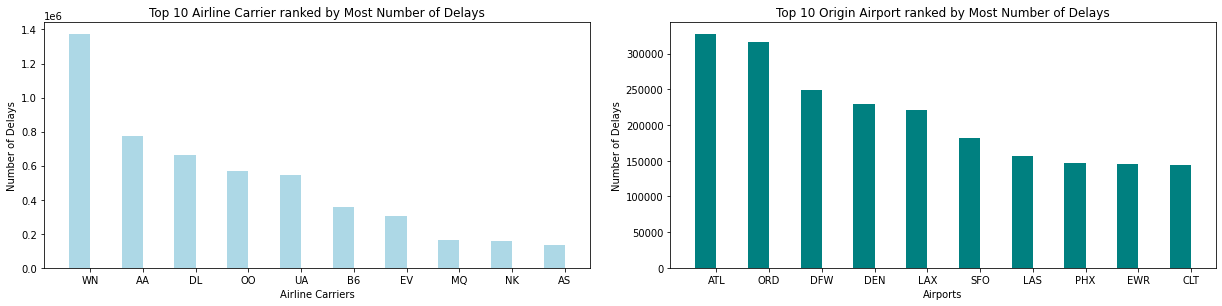

In [0]:
displayHTML("<img src = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABMYAAAEyCAYAAAARNtxkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAABMxUlEQVR4nO3dd5hkVZ3/8fdHwLSIqIwuUVARxYQ65oQZXRVUVDAALivrGlbddX9mETPrGte0qAgYQMyoGFBBd1WQUREBRUZEBVFGohFFv78/zmmoabo6zHR1mHq/nqefrjr31rnnVrj1re8959xUFZIkSZIkSdK4ucZiN0CSJEmSJElaDCbGJEmSJEmSNJZMjEmSJEmSJGksmRiTJEmSJEnSWDIxJkmSJEmSpLFkYkySJEmSJEljycSYNIMkL07y3mmWb5+kkmzc738+yb4L18L5leT0JLsudjumMvm5Xs+6zknyoCHLDkvy6vXdxjhKsmuScxdx+49O8oskv0tyxxHUv1+S/5vveiVJCy/Jk5J8ab7XXYd23CfJmaOoe6mYz/igx4K3GLLshCT/NB/bGTeLHeMk+Zckv+4x3I1GUP8rknxwvuvVhsHEmOZdP5hN/P0tyR8H7j9pnrbx+CTfTPKHJCdMsXyXJN/py7+TZJdZ1HlYkiuSbDlYXlWvrapZf8FW1cOq6vDZrj8XSW6Z5KNJfpPk0iSnJvm3JBvN1zaq6jZVdcJ81TfuevB2wWAyL8kmvazWs+4ZE4U9CKgkjx8o27iXbb8+21+i/gt4VlVtWlXfm7yw7/fv+/HowiRfSfKERWinJC1ZyzGWS/KIJN/ux/gLk3woyTbTPaaqPlRVD5lNe+ey7jRt3K9/D631vVNV/1tVO61P3evQlqHJJa0VY31vUvkWSf6c5Jz1rH/GRGH/bVJJ7jpQdov1jR+XoiSbAG8CHtJjuAsnLZ94PSaOQ79O8tkkD16cFmtDY2JM864fzDatqk2BnwOPHCj70Dxt5iLgLcDrJy9Ick3g08AHgRsAhwOf7uVTSvJ3wGOBS4Enz7YR0yUk5luSmwMnAb8AbldV1wceB6wErrcO9W006f567ctsHr+Qz9cSczHwsIH7D+tlC+Ui4KD5TKAuhHV8v9wUOH2Gde7Qj087AYcBb09y4DpsS5I2SMstlkuyJ/DhXt8WwG2Ay4H/S3KDIY9ZjJhkX9p+7zPbB8x3O9e1vjGO4a6b5LYD958I/HQBt38RsOxGMazD++UmwLWZOYbbvB+X7gAcB3wyyX5zb6G0NhNjWjBJrpXkLUl+2f/ekuRafdmuSc5NG7b4m7RhbkPPSFbVl6vqaOCXUyzeFdgYeEtVXV5VbwMCPGCa5j0WuAR4JS1oGWz3ld1uB85W7J/k58BXp9jPK7tw9zOD/5fkv5JcnOSnSR42sO71k7wvyflJzkvy6mmSFwcB36yqf6uq8/vzcGZVPbGqLun1fTTJr9J6k309yW0GtnVYknclOTbJ74H79+f5BUlOBX6f1pPoyiGGSa6R5IVJftLPvh6d5IZzeC4mXtcXJPkV8P4kN+hneNb05+Szg2d0+/P3qiTfSPLbJF9KssVUT0iSx/b23na6tvZ1n5LkZ33ZS4Y8x4O2SHJcb8PXkty01/OOJG+c1I5jkjxvmro+wNpB8D7AEZPq2KrXc1GS1UmeNrDsrklWJbks7QzZm/qir/f/l6SdPbvHkO1/AfgzQ5K+mTTsIJO60vfX+RlJzurPx6uS3DztTP9l/bm+5qQ6p/wspx0H/ivJz/u+vDvJdfqyq71fpmjrNZK8tL+WFyQ5on+OrpXkd8BGwPeT/GTIc3GlqvpNVX0A+BfgRend9ufyuUzy1rShm5el9Wi4Ty//+7ReDjcaWPdO/X2/SdoZ36+lfVZ/k+QjM7VXkhZblmAslyTAG4FXV9WHq+qPVfUr4J+A3wHP6+vt12OLNye5EHjFFN93D0lyZj82v7Mfp9eK6QbWrSRP79+Nl/T4INM8dzcF7gccADw0yd8PLFur91CGx2cvSnJGWvz0/iTXHnjM03r8cFFaPLHVpLY+M8lZwFlJJuKH7/f44Wo9p4c8XzdP8tW0WOo3ab3yNp/U7uenjWi4NMlHBts4qf5/7fuyTaaJDfq6/9G/k3+Z5B+HPccDbp7We/CyJJ/OVbHr55I8e1I7Tk3y6Gnq+gBr/zaYKoa7dVosdUnalCSPGlj28L6fv02LKZ6fdkL+88BWuaoH1FZM7XDg9knuN9XCTJoaJFP/bnlqWqxycX/P3qXv9yVJ3n71KvP2/vr9KMkDBxYMjY+mer9M0dYpjx9JbglMDCW+JMnVflNMVlW/qqq39u0cnOQafRtbJfl4Wrz10yT/OqyODPnd1J+fX2cg9kvymCTf77eHxeVaxkyMaSG9BLg7sAsty39X4KUDy/+edpZva9oX0CFJ1qVb+W2AU6tqsJvxqb18mH2BI4GjgFslufMM27gfcGvgobNoz91oB/stgP8E3pdcGTgdBlwB3AK4I/AQWiA3lQcBH5thW58HdgRuDHwXmHxW94nAa2g9zCaCu72Bf6Cdgbli0vrPBvag7e9WtF5O75i0zkzPxd8DN6T15DmAdtx5f7+/HfBHYPKX8hOBp/b9uCbw/MmVJnkqcDDwoKo6bbq2JtkZeBfwlL7sRsC0wyuAJwGvor1up3DVc3k4sPfAF/AWtNfmw9PU9Sngvkk2TztzfR/amfBBRwHn9vbtCbw2ycQPgLcCb62qzYCbA0f38vv2/5v3s/jfGrL9Al4GHJjWVX1dPBS4M+0z/P+AQ2iJtm2B29LeRxOm+yy/Hrgl7Thwi77Oyyc9dvD9Mtl+/e/+wM2ATYG39x9Om/Z17lBVN5/Dvn2a9gNsYqjCYcz+c3ly35cb0t4DH01y7f6j7ATg8QPrPgU4qqr+QntvfYnWE2Ib4L/n0F5JWixLMZbbiRZPfHSwsKr+BnwcGBxqdTfgbFrvlNcMrt+/zz8GvIgWJ5wJ3HOGdj4CuAtwe9rxfrq4cB9gVVV9HPghLc6YzlTx2ZP6Nm5O+y59aW/7A4DX9TZsCfyMFlcM2oO2/ztX1UT8cIcePww7OTP5+Urfzla02G9brp4AeTywG7AD7XnZb3KlSV7ey+9XVecyTWyQZDdaHPhgWow75fywk+wD/CPtubgCeFsvP5yBk4RJ7tC39blp6vogsFeSjXo8uSltBMdEHZsAn6F9p9+YFo9+aOB9/z7gn6vqerR46atV9Xva6IFfDvTEnCpBDPAH4LVMer/O0d1oz90TaL0qX0J7Hm8DPH5S0u1uwE9on+MDgU/kqhPNhzF9fDT089VNefyoqh9z1Wd786qarjPDZJ+gPe879dj8M8D3aa/rA4HnJhn2uZzyd1NVnQxc2PdvwlO4KiE6LC7XMrYsE2NJDk3rKXDaLNd/fM/Un55kuh+vGq0nAa+sqguqag2tB9RTJq3zsv4D92u0L6nHT65kFjalDYkcdClDhhsm2Y72I/vDVfVr4CvM3MX9FVX1+6r64yza87Oqek9V/ZX2hbwlcJMkNwEeDjy313UB8GZgryH13Ag4f7oNVdWhVfXbqrqcFqjcIcn1B1b5dFV9o6r+VlV/6mVvq6pfDNmXpwMvqapzB+rcM2t3j57pufgbcGB/Xf9YVRdW1cer6g9V9VvaF+fks2Dvr6of9zqPpn2BDnou8B/ArlW1ehZt3RP4bFV9vS97WW/XdD43sP5LgHsk2baqvk17P02cQdsLOKG/d4b5E+2L+gn975heBkCSbYF7AS+oqj9V1SnAe7nqffgX4BZJtqiq31XViTO0/Wqq6hhgDcMTPDP5z6q6rKpOB04DvlRVZ1fVpbTAYvJE91f7LPeE8AHA86rqov76v5a13/NrvV+maMeTgDf1bf+O9gNmr6zHEI+eqPoNcMO5fi6r6oP9PX1FVb0RuBbtRxoMBOD9rOPetDPP0F7TmwJb9dfcCf0lLQdLMZab6FU+VYx0/sByaImI/+7H7MnfMQ8HTq+qT/RE1NuAX83QztdX1SVV9XPgeK4erwzah6tOon2YmWPNqeKzt/eyi2jx08RJqScBh1bVd3vc8iJa3LL9wGNf1797ZxO7Tljr+aqq1VV1XH9919DmhJocw72tqn7Z2/gZ1n5O0nvXPAS4f1WtmUVs8HhaXHhaTyi9Yhbt/sDA+i+jxSAb0eKvWybZsa/3FOAjVfXnaeo6l5YkfRDtNfvApOV3p71fX19Vf66qrwKf5arX5i/Azkk2q6qLq+q7s2j/ZP8DbJeBUSdz9Koea3wJ+D1wZP8Mnwf8L2vHcBfQemr+pSdMzwT+YZbx0XSfL5jd8WOuJhKKN6QlqVdU1Sv7a3E28B6Gx3DT/W4ajOFuSEtIT3x+1zsu19KzLBNjtGz1brNZsR/4XgTcq6puQ/tBrcWxFe0M1oSf9bIJF/cvsGHLZ+t3wGaTyjYDfjtk/acAP+zJCGhnC544Q8+aX8yhPVcGVVX1h35zU9qP4k2A83tX5ktoX3w3HlLPhbSk2pT6mazXpw0lvAw4py8aDAinavd0+3JT2tj9ifb9EPgr7UzQbB4PsGYgCUeS6yb5n7ShcJfRhgNunrWHqg0Gon+gPV+D/gN4R7WzjLNp61aD7ezvs7Um9ZzC4Pq/o83xMPF+HDzj+GSuHiRN5QhaQHW1Lvi93olgcMLPaGe7APannUn9UZKTkzxiFtubyktpSb4phzXMYDDx98cp7g++RsM+yyuA6wLfGXidvtDLJ6z1fpnCVMeRjVn7PTkn/bO+gvYaz+lzmTYk4oe9G/4lwPW56jP3aVowvAPtTPelPbEKrdddgG/3kzazGRoiSYttKcZyv+n/p4qRthxYDtPHLJNjhaIlRaYzU7wCQJJ70XpQTfTi+jBwu0x/QYGZYrbB53at16XHLRdyVRwxrL6ZrPWYJDdJclTaMLrLaL2pJk93Md1zsjktCfa6fmINZo4N1npdWPv9N5t2/4z2vb5Fjy8+Ajy59y4aPGE1nSNoPdymWn8r4BfVeigObnPiuX8sLaH0s7ShucOmvRiqJ25e1f/WxVxiuPP6e3/CxPtsNvHRTO+xmY4f62LieZ6I4baaaF9v44uZIkacxe+mDwKPTBv2+njgf6tPZcP8xeVaQpZlYqyqvk57818pbcz7F9LmePnfJLfqi55G+wF9cX/sBQvcXF3ll7QD1oTtWHteiRv0g8+w5bN1Om0s/uA8D7dn+GSO+wA3Sxtj/iva2a8taF9iw8zH1WB+QZsYdouq2rz/bdYTuFP5Mu3LdZgnArvTzmhdH9i+lw8+D1O1e7p9+QXwsIH2bV5V1+5nmGbz+KmW/zutR83dqnVBnujOP3Rejik8BHhpksHnY7q2nk/r7t82lFyX1gNvOoPrb0o7EzXxfvwgsHvvgn9r2lDJmfwvvbcgVw1jnfBLWm+lwTPh2wHnAVTVWVW1Ny34OBj4WP+szOl9WFXHAauBZ0xa9HtaUDrh71k/wz7Lv6EFYLcZeI2uX1cNgYSZ92mq48gVrB3kzdXuvY5vM4fPZdp8Yv+PFjDdoKo2p/VoCEAPwI+mJU+fwkAwXW1ujKdV1VbAPwPvjFcHk7T0LcVY7kxaAutxg4U98fFY2kiACdN9x5zPwDQLfdszTbswW/vSvhtO6bHmSQPlw0zV1m0Hbg8+t2u9Lv01uBE9jpimvplMfsxre9ntegz3ZOYWv11MG376/p4shJljg7ViONp+z2Ty+hM9w6Gd3HwSref/H2r4NBSDPk4b1np27x046JfAtv39NrjNiRju5KranRbDfYqrht3N9fV4Py2x+JhJ5fMdw2096XM38T6bTXy0LjHcuhwfBj2a1svtzN7Gn076LXC9qprqN920v5v674dv0Z7vyTHcsLhcy9iyTIwNcQjw7Kq6M20c+jt7+S1pXWa/keTEtHHqWhxH0pIZK9LmcXg5LcEw6KAk1+w/OB/BpPkiJvQs/7VpPUWukeTaAz28TqD1FPrXtAkdn9XLp5oc/h60seF3pXX13oU2/n82XdzXSz/r8CXgjUk2S5tU/OYZMrkmbZz/PZO8IX3C1rQJvD+YNvHp9WhfWBfSviBfOw/NfDfwmlw18fyKJLuvZ53XowVAl/SuyetyNcDTab1G35GrJjidrq0fAx6R5N5pk8S/kpmPfw8fWP9VwIlV9QuA3lPtZNqX5MeHdBdfSz/79kjgUZPOxNHr/Sbwuv5evj3tbNTE5KlPTrKin428pD/sb7ShkX+jzbU1Wy+hJXMGnQI8pvfmu0Xf9vq62me5t/89wJuT3BggydYZPvfDVI4Enpdkh56wfC1tGMTk+fFmlOSGaRNDvwM4uNqQyLl8Lq9HS6itATZOmzNlcg+HibPMj2IgqEryuFx10YmLacHkTMN7JWmxLblYrn+nPr+364m9nr+nTUmwGW2412x8jtaLa4+04fnPZP2TDPR9fDytp9QuA3/Ppo1QmMtUAM9Mm6z+hrTv84m5wY4Enppkl7SLIbwWOKmqzpmmrl8zt/gB2vfe74BLk2xN68E/J1V1Ai0x9Ykkd51FbHA0sF+SnfuJzdnEjU8eWP+VwMeqTWlCT4T9jXbBhtn0FpsYafAApp6O4iRaz7j/l3ZxnV1p8d5R/XPwpCTXrzZtw2Vc9V3/a+BGWXvKk+nacAVt318wadEptCklNkmykjZ9yPq4Me1zt0mSx9FOAB+7Dr9bpjKb48espPVefBbtOXlRfx99G/ht2oUrrtOPMbdNcpcpqpjN76YjaDHz7WhzmU1se1hcrmVsg0iM9R9H96RNenwKrVvnRHfqjWmT6u1K6/76ngxcPUUL6tXAKtrkqT+gTXI4ePnhX9F+IP6SNpzx6VX1oyF1PYWWXHkXbSLzP9K+VKk2T8AetMTWJbTJN/eoqecP2Jc279YPeg+OX1WbNPuttETKDad4zHzahza5/Bm0ff8YQ4ZLVtVPgHvQzmicnuRS2hmsVbShBUfQuiSf1+ubj/Hub6XNx/ClJL/tdd5tPet8C3Ad2pm7E2nd5eesqr5PC7jfkzbnwtC2VpsX65m0hOf5tOd6puERH6Z92V5Em3R+8hUdD6d9Uc4qqJpoR2/LVPamvba/BD5Jm2fry33ZbrTX/He0/dyr2lwff6DNMfKNtC7jd59FG75BCxwGvZl21cpf9/2afNGGuZrus/wCWq+1E9O6rn+Zq+bkmo1Dac/512mXS/8T7cfFXHy/P5eraUHu86pq8AIAs/1cfpH2/v0x7bP3JyYNI+jP99+A71bV4PCBuwAn9XYcAzyn2lwYkrSULcVYjmpzIT2FdgXKC2nH7+vQplKZaeqEiTp+Q+t19p+9jp37vl4+m8dPYw/avh0xKdY8lPY7ZS4n7T9MS06cTZsg/dW97V+mzaX1cVqcc3OGz1k74RXA4T1+mO08cAcBd6L1jv4cA8mCueg92P8R+EySOzFNbFBVn6fFjl/t68x4xUJanHAY7f14bWDylQmPoMVws07KVNWqHotPLv8zLRH2MFps+05gn4H3/VOAc/p+PZ1+0YW+/Ejg7P4azGZI4ZFcfS69l9Fe74tpr8/6zqd9Eu23829oMeaeA5+hWf9uGWKm48dsXJLk9/3xDwceV1WHAvTk5yNoieef9n14L61H2GSz+d30SfpULXXVdDgwJC6f435oicmkjgvLRtpkkp+tqtsm2Qw4s6qu9sFM8m7aGZP39/tfAV5Y7WoTWiL62ZUPVtV8dVmXRirJfWkB1U0n9wCTBqVddvzDVfXexW6LJI3KhhbLpQ2NOxd4UlUdvwTacw7wTwMnzbSOkuwDHFBV917stmhpS/IT2lVF/dxt4DaIHmNVdRnw097dkzR36Is/RestNnEZ5lvSzrJI0jrpQz2eA7zXpJim07vv34mrhrtIkpaoJA9Nsnkfjvhi2nxDXnFuA9KHVz6DNg2PNFTaXMbF7HopaplblomxJEfSJsPbKcm5SfandUvdP8n3afMPTcwt9EXgwiRn0C6j/B+z7VItSZMluTVtWMeWtK790pSSHE4bDvLcWvuKo5KkpeketCGKv6ENj9vDIVIbjj5v2Rra1BHrO+RQG7AkJ9CGeT+z1r7iqDZQy3YopSRJkiRJkrQ+lmWPMUmSJEmSJGl9zeXywEvCFltsUdtvv/1iN0OSJI2h73znO7+pqhWL3Y7lyjhOkiQtlmFx3LJLjG2//fasWrVqsZshSZLGUJKfLXYbljPjOEmStFiGxXEOpZQkSZIkSdJYMjEmSZIkSZKksTSyxFiSQ5NckOS0Gda7S5Irkuw5qrZIkiRJkiRJk42yx9hhwG7TrZBkI+Bg4EsjbIckSZIkSZJ0NSNLjFXV14GLZljt2cDHgQtG1Q5JkiRJkiRpKos2x1iSrYFHA++axboHJFmVZNWaNWtG3zhJkiRJkiRt8BZz8v23AC+oqr/NtGJVHVJVK6tq5YoVK0bfMkmSJEmSJG3wNl7Eba8EjkoCsAXw8CRXVNWnFrFNkiRJkiRJGhOLlhirqh0mbic5DPisSTFJkiRJkiQtlJElxpIcCewKbJHkXOBAYBOAqnr3qLYrSZIkSZIkzcbIEmNVtfcc1t1vVO1YF5848/x5r/MxO20573VKkiRpbTnooHmvsw48cN7rlCRJS8NiTr4vSZIkSZIkLRoTY5IkSZIkSRpLJsYkSZIkSZI0lkyMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWNp48VugCRJkqThctBB815nHXjgvNcpSdJyZI8xSZIkSZIkjSUTY5IkSZIkSRpLJsYkSZIkSZI0lkyMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSdIyluTaSb6d5PtJTk9yUC/fIclJSVYn+UiSa/bya/X7q/vy7QfqelEvPzPJQwfKd+tlq5O8cKB8ym1IkiQtFybGJEmSlrfLgQdU1R2AXYDdktwdOBh4c1XdArgY2L+vvz9wcS9/c1+PJDsDewG3AXYD3plkoyQbAe8AHgbsDOzd12WabUiSJC0LJsYkSZKWsWp+1+9u0v8KeADwsV5+OLBHv717v09f/sAk6eVHVdXlVfVTYDVw1/63uqrOrqo/A0cBu/fHDNuGJEnSsmBiTJIkaZnrPbtOAS4AjgN+AlxSVVf0Vc4Ftu63twZ+AdCXXwrcaLB80mOGld9omm1IkiQtCybGJEmSlrmq+mtV7QJsQ+vhdavFbdFVkhyQZFWSVWvWrFns5kiSJK3FxJgkSdIGoqouAY4H7gFsnmTjvmgb4Lx++zxgW4C+/PrAhYPlkx4zrPzCabYx2KZDqmplVa1csWLF+u6iJEnSvDIxJkmStIwlWZFk8377OsCDgR/SEmR79tX2BT7dbx/T79OXf7Wqqpfv1a9auQOwI/Bt4GRgx34FymvSJug/pj9m2DYkSZKWhY1nXkWSJElL2JbA4f3qkdcAjq6qzyY5AzgqyauB7wHv6+u/D/hAktXARbREF1V1epKjgTOAK4BnVtVfAZI8C/gisBFwaFWd3ut6wZBtSJIkLQsmxiRJkpaxqjoVuOMU5WfT5hubXP4n4HFD6noN8Jopyo8Fjp3tNiRJkpYLh1JKkiRJkiRpLI0sMZbk0CQXJDltyPInJTk1yQ+SfDPJHUbVFkmSJEmSJGmyUfYYOwzYbZrlPwXuV1W3A14FHDLCtkiSJEmSJElrGdkcY1X19STbT7P8mwN3T6Rd4luSJEmSJElaEEtljrH9gc8vdiMkSZIkSZI0Phb9qpRJ7k9LjN17mnUOAA4A2G677RaoZZIkSZIkSdqQLWqPsSS3B94L7F5VFw5br6oOqaqVVbVyxYoVC9dASZIkSZIkbbAWLTGWZDvgE8BTqurHi9UOSZIkSZIkjaeRDaVMciSwK7BFknOBA4FNAKrq3cDLgRsB70wCcEVVrRxVeyRJkiRJkqRBo7wq5d4zLP8n4J9GtX1JkiRJkiRpOkvlqpSSJEmSJEnSgjIxJkmSJEmSpLFkYkySJEmSJEljycSYJEmSJEmSxpKJMUmSJEmSJI0lE2OSJEmSJEkaSybGJEmSJEmSNJZMjEmSJEmSJGksmRiTJEmSJEnSWDIxJkmSJEmSpLFkYkySJEmSJEljycSYJEmSJEmSxpKJMUmSJEmSJI0lE2OSJEmSJEkaSybGJEmSJEmSNJZMjEmSJEmSJGksmRiTJEmSJEnSWDIxJkmStEwl2TbJ8UnOSHJ6kuf08lckOS/JKf3v4QOPeVGS1UnOTPLQgfLdetnqJC8cKN8hyUm9/CNJrtnLr9Xvr+7Lt1/AXZckSZoXJsYkSZKWryuAf6+qnYG7A89MsnNf9uaq2qX/HQvQl+0F3AbYDXhnko2SbAS8A3gYsDOw90A9B/e6bgFcDOzfy/cHLu7lb+7rSZIkLSsmxiRJkpapqjq/qr7bb/8W+CGw9TQP2R04qqour6qfAquBu/a/1VV1dlX9GTgK2D1JgAcAH+uPPxzYY6Cuw/vtjwEP7OtLkiQtGybGJEmSNgB9KOMdgZN60bOSnJrk0CQ36GVbA78YeNi5vWxY+Y2AS6rqiknla9XVl1/a15/crgOSrEqyas2aNeu3k5IkSfNs48VugCRJktZPkk2BjwPPrarLkrwLeBVQ/f8bgX9cjLZV1SHAIQArV66sxWiDlp4cdNC811kHHjjvdUqSNnz2GJMkSVrGkmxCS4p9qKo+AVBVv66qv1bV34D30IZKApwHbDvw8G162bDyC4HNk2w8qXytuvry6/f1JUmSlg0TY5IkSctUn9PrfcAPq+pNA+VbDqz2aOC0fvsYYK9+RckdgB2BbwMnAzv2K1BekzZB/zFVVcDxwJ798fsCnx6oa99+e0/gq319SZKkZcOhlJIkScvXvYCnAD9IckovezHtqpK70IZSngP8M0BVnZ7kaOAM2hUtn1lVfwVI8izgi8BGwKFVdXqv7wXAUUleDXyPloij//9AktXARbRkmiRJ0rIyssRYkkOBRwAXVNVtp1ge4K3Aw4E/APtNXFVJkiRJM6uq/wOmuhLksdM85jXAa6YoP3aqx1XV2Vw1FHOw/E/A4+bSXkmSpKVmlEMpDwN2m2b5w2jd93cEDgDeNcK2SJIkSZIkSWsZWWKsqr5O61Y/zO7AEdWcSJvYdctp1pckSZIkSZLmzWJOvr818IuB++f2MkmSJEmSJGnklsVVKZMckGRVklVr1qxZ7OZIkiRJkiRpA7CYibHzgG0H7m/Ty66mqg6pqpVVtXLFihUL0jhJkiRJkiRt2BYzMXYMsE+auwOXVtX5i9geSZIkSZIkjZGNR1VxkiOBXYEtkpwLHAhsAlBV76ZdDvzhwGrgD8BTR9UWSZIkSZIkabIZE2NJ/g74Y1X9LcktgVsBn6+qv0z3uKrae4blBTxzLo2VJEnaUK1rzCVJkqR1N5uhlF8Hrp1ka+BLwFOAw0bZKEmSpDFkzCVJkrTAZjOUMlX1hyT7A++sqv9McsqI2yVJkjRujLmkZSoHHTSSeuvAA0dSryTpKrPpMZYk9wCeBHyul200uiZJkiSNJWMuSZKkBTabxNhzgBcBn6yq05PcDDh+tM2SJEkaO8ZckiRJC2w2QykvrqpHTdypqrOBfx1dkyRJksaSMZckSdICm02PsXcm+XaSZyS5/shbJEmSNJ6MuSRJkhbYjImxqroP8GRgW+A7ST6c5CEjb5kkSdIYMeaSJElaeLMZSklV/TjJS4FVwNuAOyYJ8OKq+sQoGyhJkjQujLkkLRWjuNKmV9mUtBTN2GMsye2TvBn4IfAA4JFVdet++80jbp8kSdJYMOaSJElaeLPpMfbfwHtpZyr/OFFYVb/sZzQlSZK0/oy5JEmSFtiMibGqut80yz4wv82RJEkaT8ZckiRJC2/GxFiSHYHXATsD154or6qbjbBdkiRJY8WYS5IkaeHNOMcY8H7gXcAVwP2BI4APjrJRkiRJY8iYS5IkaYHNJjF2nar6CpCq+llVvQL4h9E2S5IkaewYc0mSJC2w2Uy+f3mSawBnJXkWcB6w6WibJUmSNHaMuSRJkhbYbHqMPQe4LvCvwJ2BpwD7jrJRkiRJY8iYS5IkaYHN5qqUJ/ebvwOeOtrmSJIkjSdjLkmSpIU3NDGW5DNADVteVY8aSYskSZLGiDGXJEnS4pmux9h/LVgrJEmSxpcxlyRJ0iIZmhirqq9N3E5yHWC7qjpzQVolSZI0JtY35kqyLXAEcBNaz7NDquqtSW4IfATYHjgHeHxVXZwkwFuBhwN/AParqu/2uvYFXtqrfnVVHd7L7wwcBlwHOBZ4TlXVsG3M/VmQJElaHDNOvp/kkcApwBf6/V2SHDPidkmSJI2V9Yi5rgD+vap2Bu4OPDPJzsALga9U1Y7AV/p9gIcBO/a/A4B39e3dEDgQuBtwV+DAJDfoj3kX8LSBx+3Wy4dtQ5IkaVmYzVUpX0ELji4BqKpTgB1G1iJJkqTx9ArWIeaqqvMnenxV1W+BHwJbA7sDh/fVDgf26Ld3B46o5kRg8yRbAg8Fjquqi3qvr+OA3fqyzarqxKoqWu+0wbqm2oYkSdKyMJvE2F+q6tJJZUMniJUkSdI6We+YK8n2wB2Bk4CbVNX5fdGvaEMtoSXNfjHwsHN72XTl505RzjTbGGzTAUlWJVm1Zs2aueyOJEnSyM0mMXZ6kicCGyXZMcl/A98ccbskSZLGzXrFXEk2BT4OPLeqLhtc1nt6jfTE5rBtVNUhVbWyqlauWLFilE2QJEmas9kkxp4N3Aa4HDgSuAx47gjbJEmSNI7WOeZKsgktKfahqvpEL/51HwZJ/39BLz8P2Hbg4dv0sunKt5mifLptSJIkLQszJsaq6g9V9ZKquks/2/eSqvrTbCpPsluSM5OsTnK1yViTbJfk+CTfS3Jqkoevy05IkiQtd+sac/WrTL4P+GFVvWlg0THAvv32vsCnB8r3SXN34NI+HPKLwEOS3KBPuv8Q4It92WVJ7t63tc+kuqbahiRJ0rIwbWIsyb5Jvpvk9/1vVZJ9ZlNxko2Ad9CufLQzsHe/QtKglwJHV9Udgb2Ad859FyRJkpa39Ym5gHsBTwEekOSU/vdw4PXAg5OcBTyo3wc4FjgbWA28B3gGQFVdBLwKOLn/vbKX0dd5b3/MT4DP9/Jh25AkSVoWNh62IMm+tO77/wZ8FwhwJ+ANSaqqPjBD3XcFVlfV2b2+o2hXLjpjYJ0CNuu3rw/8ch32QZIkadla35irqv6vP2YqD5xi/QKeOaSuQ4FDpyhfBdx2ivILp9qGJEnScjE0MQb8C/DoqjpnoOyrSR4LHAXMlBib6spGd5u0ziuALyV5NvB3tDONkiRJ42R9Yy5JkiSto+mGUm42KUADoJdtdrW1183ewGFVtQ3wcOADSa7WJi/zLUmSNmALEXNJkiRpCtMlxv64jssmDLuy0aD9gaMBqupbwLWBLSZX5GW+JUnSBmx9Yy5JkiSto+mGUt46yalTlAe42SzqPhnYMckOtITYXsATJ63zc9q8FIcluTUtMWaXMEmSNE7WN+aSJEnSOpo2MbY+FVfVFUmeRbv090bAoVV1epJXAquq6hjg34H3JHkebSL+/fqEsJIkSeNivWIuSZIkrbuhibGq+tn6Vl5Vx9IuCT5Y9vKB22fQLjGuEfvEmefPe52P2WnLea9TkqRxMx8xlyRJktbNdHOMSZIkSZIkSRus6YZSSpIkSZK0QchBB817nXXggfNep6SFNbTHWJKv9P8HL1xzJEmSxosxlyRJ0uKZrsfYlknuCTwqyVG0KyNdqaq+O9KWSZIkjQdjLkmSpEUyXWLs5cDLgG2AN01aVsADRtUoSZKkMWLMJUmStEimuyrlx4CPJXlZVb1qAdskSZI0Noy5JEmSFs+Mk+9X1auSPAq4by86oao+O9pmSZIkjRdjLkmSpIU3dPL9CUleBzwHOKP/PSfJa0fdMEmSpHFizCVJkrTwZuwxBvwDsEtV/Q0gyeHA94AXj7JhkiRJY8aYS5IkaYHN2GOs23zg9vVH0A5JkiQZc0mSJC2o2fQYex3wvSTH0y4ffl/ghSNtlSRJ0vgx5pIkSVpgs5l8/8gkJwB36UUvqKpfjbRVkiRJY8aYS5IkaeHNpscYVXU+cMyI2yJJkjTWjLkkSZIW1mznGJMkSZIkSZI2KCbGJEmSJEmSNJamTYwl2SjJjxaqMZIkSePImEuSJGlxTJsYq6q/Amcm2W6B2iNJkjR2jLkkSZIWx2wm378BcHqSbwO/nyisqkeNrFWSJEnjx5hLkiRpgc0mMfaykbdCmqNPnHn+SOp9zE5bjqReSZJmwZhLkiRpgc2YGKuqryW5KbBjVX05yXWBjUbfNEmSpPFhzCVJmqscdNC811kHHjjvdUpL2YxXpUzyNOBjwP/0oq2BT42wTZIkSWPHmEuSJGnhzZgYA54J3Au4DKCqzgJuPMpGSZIkjaF1irmSHJrkgiSnDZS9Isl5SU7pfw8fWPaiJKuTnJnkoQPlu/Wy1UleOFC+Q5KTevlHklyzl1+r31/dl28/H0+CJEnSQppNYuzyqvrzxJ0kGwM1uiZJkiSNpXWNuQ4Ddpui/M1VtUv/O7bXuTOwF3Cb/ph3JtkoyUbAO4CHATsDe/d1AQ7udd0CuBjYv5fvD1zcy9/c15MkSVpWZpMY+1qSFwPXSfJg4KPAZ0bbLEmSpLGzTjFXVX0duGiW29gdOKqqLq+qnwKrgbv2v9VVdXZPzh0F7J4kwANoQzwBDgf2GKjr8H77Y8AD+/qSJEnLxmwSYy8E1gA/AP4ZOBZ46SgbJUmSNIbmO+Z6VpJT+1DLG/SyrYFfDKxzbi8bVn4j4JKqumJS+Vp19eWX9vXXkuSAJKuSrFqzZs167I4kSdL8mzExVlV/o50NfBVwEHB4Vc1qKOWwuSomrfP4JGckOT3Jh+fSeEmSpA3F+sRcU3gXcHNgF+B84I3z0cZ1UVWHVNXKqlq5YsWKxWqGJEnSlDaeaYUk/wC8G/gJEGCHJP9cVZ+f4XETc1U8mHZ28eQkx1TVGQPr7Ai8CLhXVV2cxEn9JUnSWFrXmGsqVfXrgXrfA3y23z0P2HZg1W16GUPKLwQ2T7Jx7xU2uP5EXef2+dCu39eXJGmd5KCDRlJvHXjgSOrVhmHGxBjtDOP9q2o1QJKbA58DZgrSrpyroj/uKNpcFGcMrPM04B1VdTFAVV0wt+ZLkiRtMNY15rqaJFtW1fn97qOBiStWHgN8OMmbgK2AHYFv0xJxOybZgZbw2gt4YlVVkuOBPWnzju0LfHqgrn2Bb/XlX12PHm6SJG2QRpHsM9E3v2aTGPvtRIDWnQ38dhaPm2quirtNWueWAEm+AWwEvKKqvjCLuiVJkjY06xRzJTkS2BXYIsm5wIHArkl2oV3V8hzanGVU1elJjqadqLwCeGZV/bXX8yzgi7SY7NCqOr1v4gXAUUleDXwPeF8vfx/wgSSraZP/77Vuuy1JkpaTDS3ZNzQxluQx/eaqJMcCR9OCq8cBJ8/j9nekBXPbAF9PcruqumRSWw4ADgDYbrvt5mnTkiRJi299Y66q2nuK4vdNUTax/muA10xRfixtwv/J5WfTRgJMLv9Tb6MkSdKyNV2PsUcO3P41cL9+ew1wnVnUPd0cFhPOBU6qqr8AP03yY1qibK0gsKoOAQ4BWLlypV30JUnShmR9Yy5JkiSto6GJsap66nrWfTJTzFUxaZ1PAXsD70+yBW1o5dnruV1JkqRlYx5iLkmSJK2j2VyVcgfg2cD2g+tX1aOme1xVXTHVXBVJXgmsqqpj+rKHJDkD+CvwH1Xl1YwkSdLYWdeYS5IkSetuNpPvf4o2T8VngL/NpfKp5qqoqpcP3C7g3/qfJEnSOPsU6xhzSZIkad3MJjH2p6p628hbIo25T5x5/rzX+Zidtpz3OiVJI2PMJUmStMBmkxh7a5IDgS8Bl08UVtV3R9YqSZKk8WPMJUmStMBmkxi7HfAU4AFc1a2/+n1JkiTND2MuSZKkBTabxNjjgJtV1Z9H3RhJkqQxZswlSZK0wGaTGDsN2By4YLRNkbShcd40SZoTYy5JkqQFNpvE2ObAj5KczNrzXXjpcEmSpPmzOcZckiRJC2o2ibEDR94KSZIkGXNJkiQtsBkTY1X1tYVoiCRJ0jgz5pIkSVp4MybGkvyWdkUkgGsCmwC/r6rNRtkwSZKkcWLMJUmStPBm02PsehO3kwTYHbj7KBslSZI0boy5JEmSFt415rJyNZ8CHjqa5kiSJMmYS5IkaWHMZijlYwbuXgNYCfxpZC2SJEkaQ8ZckiRJC282V6V85MDtK4BzaF37JUmSNH+MuSRJkhbYbOYYe+pCNESSJGmcGXNJkiQtvKGJsSQvn+ZxVVWvGkF7JEmSxooxlyRJ0uKZrsfY76co+ztgf+BGgEGaJEnS+jPmkiRJWiRDE2NV9caJ20muBzwHeCpwFPDGYY+TJEnS7BlzSZIkLZ5p5xhLckPg34AnAYcDd6qqixeiYZIkSePCmEuSJGlxTDfH2BuAxwCHALerqt8tWKskSZLGhDGXJEnS4rnGNMv+HdgKeCnwyySX9b/fJrlsYZonSZK0wTPmkiRJWiTTzTE2XdJMkiRJ88CYS5IkafEYiEmSJEmSJGksmRiTJElaxpIcmuSCJKcNlN0wyXFJzur/b9DLk+RtSVYnOTXJnQYes29f/6wk+w6U3znJD/pj3pYk021DkiRpOTExJkmStLwdBuw2qeyFwFeqakfgK/0+wMOAHfvfAcC74MqrYh4I3A24K3DgQKLrXcDTBh632wzbkCRJWjZMjEmSJC1jVfV14KJJxbsDh/fbhwN7DJQfUc2JwOZJtgQeChxXVRdV1cXAccBufdlmVXViVRVwxKS6ptqGJEnSsmFiTJIkacNzk6o6v9/+FXCTfntr4BcD653by6YrP3eK8um2sZYkByRZlWTVmjVr1nF3JEmSRmOkibEkuyU5s89JMbR7fZLHJqkkK0fZHkmSpHHTe3rVYm2jqg6pqpVVtXLFihWjbIYkSdKcjSwxlmQj4B20uSx2BvZOsvMU610PeA5w0qjaIkmSNGZ+3YdB0v9f0MvPA7YdWG+bXjZd+TZTlE+3DUmSpGVjlD3G7gqsrqqzq+rPwFG0uSgmexVwMPCnEbZFkiRpnBwDTFxZcl/g0wPl+/SrU94duLQPh/wi8JAkN+iT7j8E+GJfdlmSu/erUe4zqa6ptiFJkrRsjDIxNmyuiiv1S4RvW1Wfm64i56aQJEmaWpIjgW8BOyU5N8n+wOuBByc5C3hQvw9wLHA2sBp4D/AMgKq6iHay8uT+98peRl/nvf0xPwE+38uHbUOSJGnZ2HixNpzkGsCbgP1mWreqDgEOAVi5cuVI58iQJElaTqpq7yGLHjjFugU8c0g9hwKHTlG+CrjtFOUXTrUNSZKk5WSUPcaGzVUx4Xq0IOuEJOcAdweOcQJ+SZIkSZIkLYRRJsZOBnZMskOSawJ70eaiAKCqLq2qLapq+6raHjgReFQ/KylJkiRJkiSN1MgSY1V1BfAs2mSuPwSOrqrTk7wyyaNGtV1JkiRJkiRpNkY6x1hVHUub5HWw7OVD1t11lG2RJEmSJEmSBo1yKKUkSZIkSZK0ZC3aVSklaTn6xJnnz3udj9lpy3mvU5IkSZI0M3uMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSZIkSZLGkokxSZIkSZIkjSUTY5IkSZIkSRpLJsYkSZIkSZI0ljZe7AZIkhbPJ848fyT1PmanLUdSryRJkiTNJ3uMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSZIkSZLGkokxSZIkSZIkjSUTY5IkSZIkSRpLJsYkSZIkSZI0lkyMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSdIGKsk5SX6Q5JQkq3rZDZMcl+Ss/v8GvTxJ3pZkdZJTk9xpoJ59+/pnJdl3oPzOvf7V/bFZ+L2UJEladybGJEmSNmz3r6pdqmplv/9C4CtVtSPwlX4f4GHAjv3vAOBd0BJpwIHA3YC7AgdOJNP6Ok8beNxuo98dSZKk+TPSxFiS3ZKc2c8ivnCK5f+W5Ix+VvIrSW46yvZIkiSJ3YHD++3DgT0Gyo+o5kRg8yRbAg8Fjquqi6rqYuA4YLe+bLOqOrGqCjhioC5JkqRlYWSJsSQbAe+gnX3cGdg7yc6TVvsesLKqbg98DPjPUbVHkiRpDBXwpSTfSXJAL7tJVZ3fb/8KuEm/vTXwi4HHntvLpis/d4rytSQ5IMmqJKvWrFmzvvsjSZI0r0bZY+yuwOqqOruq/gwcRTsTeaWqOr6q/tDvnghsM8L2SJIkjZt7V9WdaCcqn5nkvoMLe0+vGmUDquqQqlpZVStXrFgxyk1JkiTN2SgTY8POLg6zP/D5qRZ4plGSJGnuquq8/v8C4JO0E5e/7sMg6f8v6KufB2w78PBtetl05dtMUS5JkrRsLInJ95M8GVgJvGGq5Z5plCRJmpskf5fkehO3gYcApwHHABNXltwX+HS/fQywT7865d2BS/uQyy8CD0lygz7p/kOAL/ZllyW5e78a5T4DdUmSJC0LG4+w7mFnF9eS5EHAS4D7VdXlI2yPJEnSOLkJ8MmWs2Jj4MNV9YUkJwNHJ9kf+Bnw+L7+scDDgdXAH4CnAlTVRUleBZzc13tlVV3Ubz8DOAy4Dq3n/5S9/yVJkpaqUSbGTgZ2TLIDLSG2F/DEwRWS3BH4H2C33sVfkiRJ86CqzgbuMEX5hcADpygv4JlD6joUOHSK8lXAbde7sZIkSYtkZEMpq+oK4Fm07vc/BI6uqtOTvDLJo/pqbwA2BT6a5JQkx4yqPZIkSZIkSdKgUfYYo6qOpXXLHyx7+cDtB41y+5IkSZIkSdIwI02MSZK00D5x5vnzXudjdtpy3uuUJEmStPhMjEmStMSZ7JMkSZJGY2RzjEmSJEmSJElLmYkxSZIkSZIkjSUTY5IkSZIkSRpLzjEmSZIWnPOmSZIkaSmwx5gkSZIkSZLGkokxSZIkSZIkjSUTY5IkSZIkSRpLJsYkSZIkSZI0lkyMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSZIkSZLGkokxSZIkSZIkjSUTY5IkSZIkSRpLJsYkSZIkSZI0lkyMSZIkSZIkaSyZGJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSZIkSZLGkokxSZIkSZIkjSUTY5IkSZIkSRpLI02MJdktyZlJVid54RTLr5XkI335SUm2H2V7JEmSNL9mivckSZKWspElxpJsBLwDeBiwM7B3kp0nrbY/cHFV3QJ4M3DwqNojSZKk+TXLeE+SJGnJGmWPsbsCq6vq7Kr6M3AUsPukdXYHDu+3PwY8MElG2CZJkiTNn9nEe5IkSUtWqmo0FSd7ArtV1T/1+08B7lZVzxpY57S+zrn9/k/6Or+ZVNcBwAH97k7AmSNp9GhtAfxmxrWWF/dp6dvQ9gfcp+ViQ9unDW1/wH1aVzetqhUj3sayMct4zzhuaXKflocNbZ82tP0B92m52ND2aUPbH1jEOG7jEW90XlTVIcAhi92O9ZFkVVWtXOx2zCf3aenb0PYH3KflYkPbpw1tf8B90sIxjlua3KflYUPbpw1tf8B9Wi42tH3a0PYHFnefRjmU8jxg24H72/SyKddJsjFwfeDCEbZJkiRJ82c28Z4kSdKSNcrE2MnAjkl2SHJNYC/gmEnrHAPs22/vCXy1RjW2U5IkSfNtNvGeJEnSkjWyoZRVdUWSZwFfBDYCDq2q05O8ElhVVccA7wM+kGQ1cBEtmNpQLeshBEO4T0vfhrY/4D4tFxvaPm1o+wPuk+bBsHhvkZs1Chvie8t9Wh42tH3a0PYH3KflYkPbpw1tf2AR92lkk+9LkiRJkiRJS9koh1JKkiRJkiRJS5aJMUmSJEmSJI0lE2PzJMmbkzx34P4Xk7x34P4bk/xbkkry7IHytyfZb2FbO3dJ9uhtv9Wk8l16+W6L1bZ1keSvSU5JcnqS7yf59yTX6Mt2TfLZxW7jXCTZJsmnk5yV5CdJ3tonQSbJvZN8O8mP+t8Bi93e2UiyfZLTJpW9Isnz++2Nk6xJ8vrFaeHcDbzvvp/ku0nuObBsuyRfSvLDJGck2X4RmzprA/s08ffCJAcmed2k9XZJ8sPFauds9GPZBwfuT7zHPjtQtkeSU/tn6bQkey5Oa2ev79cbB+4/P8kr+u3Bz9S1kxw3sWypm/y9lOQaSd7WX5cfJDk5yQ6L3U4tL4PvqyQn9ePaz/uxYOI4t32Sc5JssdjtncqwmKDHN5f2ffhRkv8aeMx+fR+/1x/3xcHvqMU0i5htYp9OSfLlJJsnuTBJ+jr36K/pNv3+9ZNcNFHHMtmvU5I8qC8bekxfCpL8bpplb0ly3uBzn/b76NCB+09K8rlRt3Mukrykv06n9tfibklOSHLmwOuzZ193aEy+VKzDa3STJJ/t79Mzkhy7MC2dnYHP0mlJPprkur38d5PW2y/J2/vttyV5+cCylyR5x8K2fGqZOrbePcmnBtZ5Udo87RP3H5nkmH77nLQ46NQkX0ty00XYjaGS/H2So/rn4ztJjk1yy/TffUluNLDvv+rvx4n7I/ssmRibP98A7gktOAe2AG4zsPyewDeBC4DnLLUD5CzsDfxf/z+b8qXuj1W1S1XdBngw8DDgwEVu0zrpgd8ngE9V1Y7ALYFNgdck+Xvgw8DTq+pWwL2Bf07yD4vW4PnzYODHwOMmgt9lYOJ9dwfgRcBg8ugI4A1VdWvgrrRjxXIwsU8Tf68HjgSeMGm9vXr5UvZ74LZJrtPvPxg4b2JhkjsA/wXs3j9PjwQOTnLnBW/p3FwOPCbT/Ijv30kfB75TVa9YqIatp8nfP08AtgJuX1W3Ax4NXLI4TdMyduX7qqruVlW7AC8HPjJwnDtnMRs4neligr7K//Z9uiPwiCT3Gnj4R6rqjv1xrwc+keTWC9f6oWaK2f534LV5UFVdApwPTLT9nsD3+n+AuwPfrqq/LUzzh5rLfu1SVV/u5TMe05ei/vvo0cAvgPsNLHobcKck90qyOfBq4NlXr2FxJLkH8AjgTlV1e+BBtH0AeNLA6/OxWXz+lrRpXqNXAsdV1R2qamfghYvRvmlMfJZuC/wZePosHvNSYL8kN0tyM+CfgJeMspFzMFVs/U3asWvCPYDLkty435/INUy4f3+/nkDb1yWhf0Y+CZxQVTevqjvTfhPdZGKdqrpwYt+BdwNvHngu/jyqtpkYmz/fpL1BoSXETgN+m+QGSa5F+3K+CFgDfAXYd1FauQ6SbEpLqOzPwJVD+xv7ccB+wIOTXHtRGriequoC4ADgWcsowTLoAcCfqur9AFX1V+B5wD8C/w4cVlXf7ct+A/w/lt4X2rrYG3gr8HOu+uwtJ5sBFwMk2RnYuKqOA6iq31XVHxazceujqn4MXJzkbgPFj2fpJ8YAjgUmEsd7s3abnw+8tqp+CtD/v5b2OVvKrqBd5ed5Q5ZvDHwEOKuqlsWxYcj30pbA+RM/dqvq3Kq6eJGaqGVoWLyzzEwXE1x3YqWq+iNwCrD1VJVU1fG048aS6mU+h5jtm1yVCLsn8OZJ978xskaugznGojMd05eqXYHTgXcxcEK9qq4AngG8A/hP2pVtz16MBg6xJfCbqrocWixdVb8csu7Qz99EL6YlblemeI1oz8G5E3eq6tSFbdac/C9wi5lWqqrLaImwt/e/l/ek+pJUVWtoibCJfduadkJzpuPatxhynF8k9wf+UlXvniioqu9zVbJ50ZgYmyf9AHlFku1ob8xvASfRfrCvBH5Ay2ADHAw8P8lGi9HWdbA78IX+Y/fCgd4R9wR+WlU/oWWjl20vpP4FvBFw45nWXYJuA3xnsKAf7H8O3HzyMmAVa/dmXHZ6EvZBwGdoiYvl0mPxOr0b8I+A9wKv6uW3BC5J8om0YSxvWEbHh4l9mvib6Cl2JP2HZZK7AxdV1VmL1srZOwrYq7/Hbk87jk+42meN9nnaeYHatj7eATwpyfWnWPb/gD9X1XMXtknrZarvpaOBR/b34RuT3HFxm6hlaFi8s5xMFxNc+WMxyQ2AHYGvT1PXd4FbTbN8UUwRs91n4DtoosfHlSM5gJsBH6XF43D1nhVLwgz7dUqSmw+sPt0xfamaONn0SeAfkmwysaCqvgn8kBbb/efiNG+oLwHbJvlxkncmGexJ9aGB1+dGzPLzt4QNe43eAbwvyfF9yOFWi9bCaSTZmNbz8ge9aK0Yldbz7UpVdSRwA2CzqvrAgjZ2esNi628A90yyE3AWcGK/vzFwB+DkKeraDfjUQjR6lm7L1WPpJcHE2PyaODs1kRj71sD9KzO4/YvvJOCJi9DGdbE37cci/f/eM5RL86GmKX8EcHw/4/1xYI9lkkia6Bp9K9oX1RH9zPDGwH1oPZLuQgvi91u0Vs7N5O7eH+nlHwH27N3yl8MwSuDKs6Db045nS2oOjfXRA/MjgH+dYvH/0QKrWy5sq9bL1b5/qupcYCdal/y/AV9J8sBFap+Wp3GIa+6T5Pu0YeJfrKpfTbPuculFPzjkcGLI2jdpx7UdgHOq6k+0wQ6bAndm7ZMeS9XkoZQ/mVgwwzF9yenD9R9OG2J4Ge35f+jA8k1pictNgBWL0sghqup3tPfMAbSRPx/JVfNDDw6lvHCx2jgfpnuNquqLtNj0PbRk+feSLKXX6To98bWKloR8Xy9fK0alDYu/Utq8g1sCW/X34FIxLLaenGv4NnA32tD4H/Xj3ITjk5xHSxQuixh8sW282A3YwEycnbodbSjlL2hDbC4D3j9p3dcCHwO+tpANnKskN6R1C75dkqKdyaokLwAeC+zez84FuFGS61XVbxevxeumjy3/K21ep6Uwn8ZcnAGsNQF4ks2A7YDjaV/mnx5YfGdaN+ml7kLaWZxBNwR+Svuxcu8k5/TyG9Hep8ctWOvWU1V9q88PsoLWPf2UiaEDaZNr3p2rvtiXnar6RZKf0uaoeCzLa7jrMbS5xHalvbcmnEH7/Hx/oOzOtEBsOXgLrQfI5O+jrwOHA59Pcu+qOn+hGzYX03wv/Ucf6vJ52r78GtiDNn2BNK3p3leL27I5my4mWE1LtjyiJ4xOTHJ0VZ0ypK470nrxLCmzidmq6qw+X9UjaT8gofVSeCotUTZ08vHFsg6x6FuY+pi+FD0U2Bz4QR8pel3gj8DExW0OAj4I/Jo27PVxC9/E4fqQyBOAE5L8gOFT4sz0+VvKpn2Nquoi2rzFH067KNF9aSenl4I/9sTXXL2VNq/frfv/pX68/wZt/r2NgPdU1W/7CIdduXov2PvT5ln9EO3z9W8L18xpnc6kz8hSYY+x+fVNWk+Wi6rqr/0AsjntB+Fab9aq+hHt4PnIhW7kHO0JfKCqblpV21fVtrTExEuAU6tq215+U9rB8dGL2dh10c94vBt4e1UN66W0lH0FuG6SfQB6z6k3AocBb6BNLLlLX3Yj2lDepdZN/Wp60Hp+kgfAlT9adqPNiXIfYLv+3tseeCbL7Mx+2pX0NqIlAE8GNh84+/YA2vFhuTuSFuCe3XvzLBeHAgdV1Q8mlf8X8KL0K4b2/8+lfc6WvP6ddDRt/qTJyz5O278v9B+TS9mw76X7TAzv6D0Vbw/8bBHbqeVl6Ptqkds1V9PFBFfOXdnnSHw98IKpKunDxQ6g9RBZMuYYs50IPIerEmPfoh2zl9T8YrBuseh0x/QlaG/gnwbith1o8xNfN8ntaNOxHEybO237JA9evKauLclOSXYcKNqF4d8tQz9/tfTnjp3uNXpArrrS4/VoU7X8fPGauv6SPIw2bPkI2tQmj0mb83cp+yHtIkP3pl1QBNrvoqczxXGtz9/3XGCf/jtqKfgqcK0kV85fmeT2wLaL16TGxNj8+gHtapQnTiq7tNqk55O9BthmIRq2HvamjTMf9HHawXKq8uWSnJgYu3068GXa/AEHDSx/YJJzB/6WbG+XHkA9mnZ1xrNoV2r8E/Di3vPjycB70ua1+iZtUtPPLFqD52Yf4GW9e/RXaa/RLsBXJyZB7T5Nm1voWgvewrm5cs4A2lDDfXsS/a+0YZRf6WciwxL7MTKNyfMgvH5g2Udp820sqy7c1SZtf9sU5afQfkR+JsmPaZ+1f6mqMxe4ievjjbTvqaupqnfRjuvHZGlfTGXY99LhtNfmNOBU2gTVb1/gtmn5Gva+mi6uOXUgTnjT6Jo2e9PFBFOs/m7gvhPJfuAJ/Tj+477+Y6tqKfQYmylmG+YbtB9bE716v0UbDrZU5hebab8mzzE2VS+Locf0RXTdSTH0i2knNj83sUJV/Z42jP+RtInen1dVf6p28ZR/Ad7ah/YtBZsChyc5I8mptHlFXzHVinP8/C2mub5GdwZW9f3/FvDeqppqPqtlocc4bwGeUc3vab3FlkrMMGVs3d9fJwEXVtVf+rrTHtf6b8EjaZ0IFt3AZ+RBSX7Sj3+vA34F7DTpfbmgPUezPDvISJK0uHqgcjfgoTXCy0dLkiRJGh0TY5IkSZIkSRpLDqWUJEmSJEnSWDIxJkmSJEmSpLFkYkySJEmSJEljycSYJEmSJEmSxpKJMUkjl2SPJJXkVgNlWyX52JD1t09yWr+9Msnb5qkdmyR5fZKzknw3ybeSPGw963xlkgfNR/skSZI2RJNjweniwHna3nOTXHdU9UvasHhVSkkjl+QjwFbAV6vqwBnW3RjYBvhsVd12ntvxemBL4ICqujzJTYD7VdXRs3z8RlX112H3Z1nHxlV1xZwaLkmStIzNNhacjzgpyUbAT4CVVfWb9alL0niwx5ikkUqyKXBvYH9gr4HywV5h+yU5JslXga9MevyuST7bb78iyaFJTkhydpJ/HVjvyUm+neSUJP/Tg6LBeq4LPA14dlVdDlBVv55IiiV5V5JVSU5PctDA485JcnCS7wKPm+L+YUn27OveOcnXknwnyReTbNnLT0jyliSrgOckeVyS05J8P8nX5+mpliRJWnKmigWniwN77Pf1JJ9LcmaSdye5Rl937yQ/6HHUwQPb+F2SNyb5PvASWhLu+CTHJ9mox2un9cc+b4GfAklL3MaL3QBJG7zdgS9U1Y+TXJjkzlX1nSnWuxNw+6q6KMn209R3K+D+wPWAM5O8C7gF8ATgXlX1lyTvBJ4EHDHwuFsAP6+qy4bU+5K+7Y1oQdntq+rUvuzCqroTXNnrbPD+bv3/JsB/A7tX1ZokTwBeA/xjr+OaVbWyr/sD4KFVdV6SzafZV0mSpOXuarEgcOGkdQbjwF2BuwI7Az8DvgA8Jsk3gYOBOwMXA19KskdVfQr4O+Ckqvp3gCT/CNy/qn7Tt7f1xEgEYy9Jk9ljTNKo7Q0c1W8f1e9P5biqumgW9X2uqi7vXeMvAG4CPJAWJJ2c5JR+/2ZzbOfjey+w7wG3oQVjEz4yad3J9wF2Am4LHNfb8FLakNCpHvMN4LAkTwPW6tkmSZK0gZlNLDg5Dvx2VZ3dp6w4ktbj7C7ACVW1pg+3/BBw377+X4GPD9n+2cDNkvx3P6E57CSppDFljzFJI5PkhsADgNslKVoSqJL8xxSr/36W1V4+cPuvtONYgMOr6kXTPG41sF2SzSb3GkuyA/B84C5VdXGSw4BrT9O2qdoa4PSquseQ7V/5mKp6epK7Af8AfKf3opt85lSSJGlZGxYLAu+YtOrk2GryRNgzTYz9p2HzvvbY7g7AQ4GnA4/nqh79kmSPMUkjtSfwgaq6aVVtX1XbAj8F7jPP2/kKsGeSG0MLwpLcdHCFqvoD8D7grUmu2ddbkeRxwGa0gOzSPiH/ulyp8kxgRZJ79Lo3SXKbqVZMcvOqOqmqXg6sAbZdh+1JkiQtdcNiwZlin7sm2aHPLfYE4P+AbwP3S7JFn/pib+BrQx7/W9q0GyTZArhGVX2c1qP/Tuu9V5I2KCbGJI3S3sAnJ5V9nOHDKddJVZ1BC3S+lORU4Dja1ScneyktEXVGn/D1s8BlVfV92hDKHwEfpg11nGsb/kwL/g7uE7+eAtxzyOpvmJg4Fvgm8P25bk+SJGkZGBYLTtfLH+Bk4O3AD2mJtE9W1fnAC4HjabHTd6rq00MefwjwhSTHA1sDJ/SpLj44i21LGjOpmqlXqiRJkiRJo9cn339+VT1ikZsiaUzYY0ySJEmSJEljyR5jkiRJkiRJGkv2GJMkSZIkSdJYMjEmSZIkSZKksWRiTJIkSZIkSWPJxJgkSZIkSZLGkokxSZIkSZIkjaX/D5pE/SJ0MQE6AAAAAElFTkSuQmCC''>")

##### Origin Airport Factor

The Top 5 airports with most number of delays are ATL, ORD, DFW, DEN and LAX. This is intuitive because these are the busiest connection hubs in the U.S. and have the most traffic. The scatter plot of airports below shows the relationship between the busyness of an airport and the proportion of its flights which are delayed. Overall there appears to be a very slight increasing linear relationship, but we also see significant variance which makes it likely that including the origin airport in feature selection will be useful for predicting flight delays. We incorporate the Average Delay by airport prior to flight departure in the feature engineering section.

In [0]:
displayHTML("<img src='https://raw.githubusercontent.com/toby-p/project-images/master/airport-delay-by-flight-count.png' width=800>")

##### 2-2 Weather dataset
   
In addition to the flights table, we also have access to a large dataset of weather observations, with very granular, high frequency data about the weather from monitoring stations all over the US. The raw weather dataset contains a total records count of 630,904,436 rows. Several key properties of the dataset are listed below:

|Property|Data|
|-----------|----|
|Total row count| 630,904,436|
|Total columns/features count|175|
|Earliest weather time | 2015-01-01 00:00:00|
|Latest weather time|2019-12-31 23:59:00|
|Number of Unique Weather Stations|15,195|

We looked at the completeness of the weather data set to identify the columns that are relevant by looking at the coverage of the data (completeness) across the different variables. (Chart below)
```python
null_count={}
for field in weather.columns:
  null_count[field]=weather.select(field).where(f.col(field)=='').count()
  
percent_coverage  = (100 - 100* pd.DataFrame([null_count])/weather.count())
```
Displaying the sparsity of most weather features
```python
p=percent_coverage.T.values
plt.plot(p,'r+')
plt.title('Data availability by Feature ',fontsize=15)
plt.xlabel('Feature',fontsize=12)
plt.ylabel('% Coverage', fontsize=12)
plt.rcParams["figure.figsize"] = [18,6]
```

The below chart shows the coverage by each feature. The x-axis are the index of the features and the y-axis represents the percent of data coverage. We can see that a significant number of features has extremely sparse coverage. We decided to ignore the fields that did not have enough completeness given it might alter the performance of our algorithms and its ability to provide accurate predictions.
Among the numerical data `WND`, `CIG`, `VIS`, `TMP`, `DEW`, `SLP` were the variables of interest that had complete coverage which we included in our models.


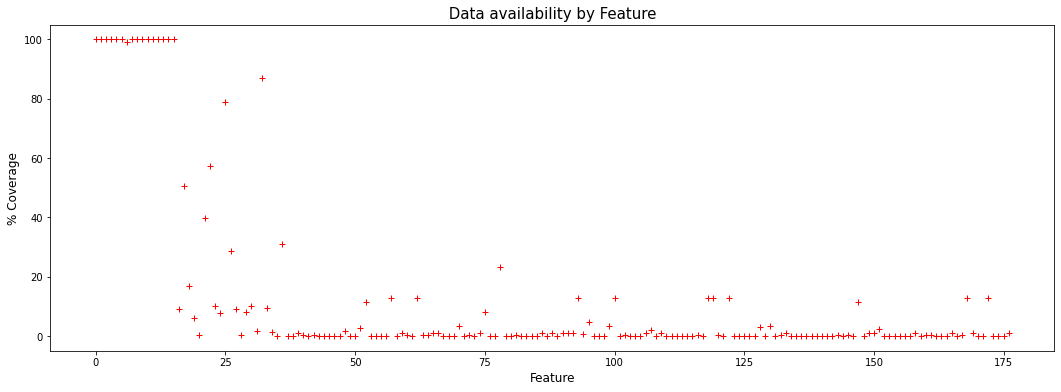

In [0]:
displayHTML("<img src = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABCUAAAGICAYAAAB2sloFAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAAvk0lEQVR4nO3dd5y8Z10v/M/XhCI9mBBDCQmCBTnnEVgpj1KkSLEkIKAoGCIe9BEpBwuIntdv48M5BiwIR18ckURAkSK9WOjyiBDYAEqHSE0MSWhRikDk+/wxs2TZbJndndl7dvb9fr3mtXPX63vf9zUzO9+5ruuu7g4AAADAfvuWoQMAAAAADidJCQAAAGAQkhIAAADAICQlAAAAgEFISgAAAACDkJQAAAAABiEpAcChVlVvrKoeP75WVRdX1eur6uFVdZVd7O96VbVcVSfNINyZq6qPVdXvrZl+ZlWt7HAfJ43P549us95yVX16zfSdx9vdYs28rqpfXjP9sKo6dSfxbFH+FcqbpvG57A0eD5pyOVM7JwCw344eOgAAmANvSPL4jJL1xyW5c5InJnloVd2luz+/g31dL8mRJG9M8rFpBrlP7pPkM/tU1jOSvGKbdW6f5KNrph+W5D1JXjqjmKbtL5P873XzzptyGQftnADAN0hKAEDy2e5+65rpl1XVnyX5xyRPTnL6MGHtv+5+5z6WdX6S87dZ561bLT8ALjxox1BVV+3u/xg6DgAOB903AGAD3f3PSf4oyc9U1bWSpKpOqKqzq+ojVfXlqvpQVT2hqq48Xn5SknePd/GG1eb642VXr6o/qqoPVtWXquqjVfXHq/vezCTbjbug/NUG2/5uVX2iqmo8fWZVvbuqvlBV51fVc6rq29dt803dNzbY55bnYJ1rVdWfV9W/j7vFHFm3r2/qvrFJed/ovlFVb0xy6ySnrekK8ZCqetI4nlq37UOq6qtVddxWZSS5flW9sqq+OD5fv7hmH/euqq9X1cnr9n3yeP4p2+x7q2O7blU9vaouqqr/qKp/rKrbrlvnV6rq7VV16Xi9V1TVTdcs3/CcjJd9U9eX8bz1XWYeMl7vNuN69OUkvzZedouqetX4+v17Vf3V+voCAHslKQEAm3tNkisludV4+tgkn03ymCT3TPK7GbWiWG2ef2GSnxk/f3hGXQ9uP56+WpKjkvxmknsl+R9J7pLkCsmEdSbZ7vlJ7l1VV1+dMf6C/oAkL+juHs++XpL/leRHkjw6yU2SvL6qdvL/wHbnYK3fTfKlJPdL8qdJjlTVw3dQ1nq/lOQDSf46l5/bVyU5O8nJSe60bv3Tk7yiuy/ZZr9nJfnnJPcd7/tpdfl4GH+X5F+TnLZum4ckuXhc/laqqo5e8zhqPPMqSV6b5G4ZJQFOTXJJkteu++J/w4ySY6ck+W8Z1YV/rKprj5dvdk526rkZdaW5d5JXjhMfb05y1SQPGh/v9yZ5xfrkDwDshe4bALC51a4FxydJd787ya+uLqyqNyf5YpKzq+oR3f2Vqvrn8eL3rW22P/5i/P+s2fbojMZK+IeqOrG7P7FRABNu98KMkgI/luR541Vvl+TENdPp7p9bs5+jkrxlfIw/mORNk5yQCc7BV9es/t7u/oXx87+rqusleXxVPa27vz5JeevKfl9VfTHJJeu6RFwyjuP0jMbySFXdJMkdkvz4BLv+m+5+/Jo4vyPJbyV5ZXf/Z1U9M6OWCGd0d4+/lJ+W5C+6+7Jt9v2Y8WPVBRklGh6U5BZJvre7PzyO+bVJPpjkVzJurdDd/311w/E1e01GyZBTkjx7i3OyU0/t7qesKevPk3wqyb1Wr+m4bn8go8TFbhIfAHAFWkoAwObWdweoqnp0Vb1v3Mz9a0mek+QqGSUAtt5Z1YOr6p1V9YXxtv8wXvSde9lunLh4fZKfXLPZTyb5l+5eWbOfe427CFya5LJcnnTZsvx1sezkHLxk3fSLk1w/oy/l03ZWkp+oqmuMpx+S5KIkfzvBthvFeevVVg0ZtcS4cUYDoCbJD42n/2yCff9Fku9f87j3eP7dkpyb5KOrrSjG8/8+ydLqxlV1u6p6TVV9JqNr9qUk18gOrtmE1icZ7pbRefn6mvg+mtHgrUsBgCmRlACAzd1g/Pei8d9HJ/m9jL6snZLkNhl100hGzdw3VVX3SfLsjFon3D+jlgz32W7bHWz3vCT3qqprjbtj3D+jbh2r+/n+JC/PKBHx4Iya+d9uktjXeXQmPwcXbzJ9wg7Km9QLknw9yQPWtGR49gQtGdbGtXb66Iy6qqS7P5JRC4zVAU9PT/K27n7vBPu+qLtX1jxWW9Icm9H5/9q6x+lJbpQkVXVikldnlBz7hSQ/kFFi4+Ls7JpN4qJ108cmeewG8d1kNT4AmAbdNwBgcz+c0Rexc8fT90/ywu7+zdUVqurmE+7r/knO6e5fWrPt+jEQ9rLdS5I8LaNEwcczapHw/DXL75PRmAU/uTrGRFXdeMLY18cz6Tm43ibTF+6i3C119xer6nkZtZD4eEatNiZpybA2rrXTlyVZOwjnM5L8aVX9RkZjT/zKngIejcuxkjVdc9b4yvjvPTMaU+SU7v5i8o3uO9edsIyvJFk/AOkxm6zb66Y/m1GdesYG6245OCkA7ISkBABsoKr+a0YtAP6iu/99PPtbc/kXxlU/s256dUyF9b9kT7LtRibarrs/V1WvzqjbxseTvH/Nr/Kr+/namkEvJy1/V/GM3SejRMmq+2aUkNjyNqDb+Go2byVwVpK3JllO8tbu/sCE+7xPkr9ZN31ud//nmnkvTvLHGbVI+ZasGatjl16XUdLrE929vqXGqm/NqPXH2tYeD8gV/3/b7Jycn+R7VifGLWjuuoP4vjej87A+YQEAUyMpAQDJdavqdhl92Tw2o7ED/luSD+WbByl8TZJHVtU5Sf4loy/jN/3mXeUTSb6c0cCIl2aUCFgZb/vHVfWbSc7JaGyBSb4g7mS752c0/sGlGd2xYf1+Hl1Vf5jRXRb+74wGW9ypSc7Bqu+tqj9J8qIkd0zy0CSP2s0gl2t8IMk9quoeST6T5KPd/Zkk6e5zquq9GQ3c+Qtb7GO9e1XV/8xoPIf7Jrl7Ri1OvqG7/6OqnpNRouq53f35PRxDMuqS84tJ3lijW7B+JMm3ZdQd5lPd/eSMxgk5KsmfVdVZGSUJfjXJ+rI3OycvSfLwqnrneP8/n2TLW9CusZzkbUleVVVnZ9Q64gYZnZtndvcbd3HMAHAFxpQAgNHAhW/J6EvpWUm+L8njktx+3ZfP387o1olPGP/9apJHrt1Rd/9HRgmNW4/39/bxoj9J8vtJHpXRr+43TvLTE8S2k+1eltGv6sdm3S/53f3XGY0R8BMZjS1xpyQ/un4HE9j2HKzx6xl9CX5RRkmC/zdXTJbs1BOSvD+jMSTentEdR9Z6aUZJoZ20ZPj5jG77+tKMzsnDu/vlG6z30vHfs3ew7w2N68kPZZTkOSOjsSOekuRmGSUDVu908pAkt03yyoyu+/0zSjqttdk5OSOjW8c+Ickzk7wrE3Zp6e4PZTTmxZeSPD2jliRnZNRK5rydHCsAbKW0yAMAFkVVvS3JB7v7wTPY95My6j5xkz229gAAxnTfAAAOvKpaSnKXjO5O8fBtVt/pvr8ryc0zGpTyDAkJAJgeLSUAgAOvqjqjsRae2N1nTnnfb8yoC8XLkzy4u7+69RYAwKQkJQAAAIBBGOgSAAAAGISkBAAAADCIhRno8thjj+2TTjpp6DAAAACANc4999xPd/dxGy1bmKTESSedlJWVlaHDAAAAANaoqo9vtkz3DQAAAGAQkhIAAADAICQlAAAAgEFISgAAAACDkJQAAAAABiEpAQAAAAxCUgIAAAAYhKQEAAAAMAhJCQAAAGAQ+5KUqKqzq+riqnrPmnnXrarXVNWHx3+PGc+vqnpqVZ1XVf9cVbfajxgHs7w8+3lbzd+PcoY8HgAAAOZWdffsC6m6Y5IvJHl2d99iPO9JST7b3WdW1eOSHNPdj62qeyd5RJJ7J7ltkqd09223K2NpaalXVlZmdxCzUpWsvwbTnrfV/GnGM4vY93o8AAAADKqqzu3upY2W7UtLie5+U5LPrpt9SpJnjZ8/K8mpa+Y/u0femuQ6VXXCfsQJAAAA7J8hx5Q4vrsvHD//VJLjx89vkOSTa9Y7fzzvCqrqYVW1UlUrl1xyyewinbbl5dEv/VWj6dXn05535ztvPH+168Pav7MoZ7+PBwAAgANlX7pvJElVnZTklWu6b3y+u6+zZvnnuvuYqnplkjO7+x/G81+X5LHdvWXfDN03tph3WMoBAABg7gzefWMTF612yxj/vXg8/4IkN1qz3g3H8wAAAIAFMmRS4uVJThs/Py3Jy9bM/9nxXThul+TSNd08Fs+RI7Oft3b+Zl01VrtATKucWc7baj4AAAAHxn7dfeO5Se6c5NgkFyU5kuSlSV6Q5MQkH0/ygO7+bFVVkj9Kcs8kX0py+nZdN5ID3H1jSLpAAAAAMGNbdd84ej8C6O4HbrLorhus20kePtuIAAAAgKEN2X2DoekCAQAAwIAkJQ4zt9IEAABgQJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQEAAAAMQlICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQEAAAAMQlICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQEAAAAMQlICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQFc0fLy0BEAAACHgKQEcEVnnDF0BAAAwCEgKQEAAAAMQlICGFleTqpGj+Ty57pyAAAAM1LdPXQMU7G0tNQrKytDhwGLoSpZkPcGAABgWFV1bncvbbRMSwkAAABgEJISwBUdOTJ0BAAAwCEgKQFckXEkAACAfSApAQAAAAxCUgIAAAAYhKQEAAAAMAhJCQAAAGAQkhIAAADAICQlAAAAgEFISgAAAACDkJQAAAAABiEpAQAAAAxCUgIAAAAYhKQEAAAAMAhJCQAAAGAQgyclquq/V9V7q+o9VfXcqrpqVZ1cVedU1XlV9fyquvLQcQIAAADTNWhSoqpukOSRSZa6+xZJjkryU0memOTJ3X3TJJ9L8tDhogQAAABmYfCWEkmOTvKtVXV0kqsluTDJXZK8cLz8WUlOHSY0AAAAYFYGTUp09wVJfi/JJzJKRlya5Nwkn+/uy8arnZ/kBsNECAAAAMzK0N03jklySpKTk1w/ydWT3HMH2z+sqlaqauWSSy6ZUZQwY8vLQ0cAAAAwiKG7b9wtyUe7+5Lu/lqSFyf5gSTXGXfnSJIbJrlgo427++ndvdTdS8cdd9z+RAzTdsYZQ0cAAAAwiKGTEp9IcruqulpVVZK7Jnlfkjckud94ndOSvGyg+AAAAIAZGXpMiXMyGtDyHUnePY7n6Ukem+QxVXVekm9LctZgQcIsLC8nVaNHcvlzXTkAAIBDpLp76BimYmlpqVdWVoYOA3auKlmQ1yEAAMB6VXVudy9ttGzo7hsAAADAISUpAUM7cmToCAAAAAYhKQFDM44EAABwSElKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBA7SkpU1Y2q6nazCgYAAAA4PCZKSlTViVX15iQfSPLa8bz7VdUzZhkcAAAAsLgmbSnxJ0leleSaSb42nveaJHffawBVdZ2qemFVfaCq3l9Vt6+q61bVa6rqw+O/x+y1HAAAAGC+TJqUuE2SM7v760k6Sbr70iTXnkIMT0nyt9393Un+ryTvT/K4JK/r7psled14GgAAAFggkyYlLkpy07UzqurmST6xl8Kr6tpJ7pjkrCTp7q929+eTnJLkWePVnpXk1L2UAwAAAMyfSZMSv5fklVV1epKjq+qBSZ6f5Il7LP/kJJck+bOqemdVPaOqrp7k+O6+cLzOp5Icv9HGVfWwqlqpqpVLLrlkj6EAAAAA+2mipER3n53k15LcP8knk5yW5H9093P2WP7RSW6V5GndfcskX8y6rhrd3Rl3Gdkgrqd391J3Lx133HF7DAUAAADYT0dPumJ3vyzJy6Zc/vlJzu/uc8bTL8woKXFRVZ3Q3RdW1QlJLp5yuQAAAMDAJkpKVNXPbbLoKxklFt7a3V/ZaeHd/amq+mRVfVd3fzDJXZO8b/w4LcmZ47/TToYAAAAAA5u0pcTPJrl9RgNenp/khhmN87CS5KQkqapTuntlFzE8IslzqurKST6S5PSMupW8oKoemuTjSR6wi/0CAAAAc2zSpMR7k7y4u5+6OqOqfjnJdyf5wSS/meR/Z5S42JHufleSpQ0W3XWn+4LBLC+PHgAAAEysRuNIbrNS1eeSfFt3f33NvKOSfLq7j6mqqyS5uLuvPbtQt7a0tNQrK7tpqAFTUJVM8FoCAAA4bKrq3O7eqDHCxLcEvSjJj62b9yO5fADKqyb52u7CAwAAAA6jSZMSj0zy7Kp6c1U9r6renOTPMxoPIklum1H3DTg8lpdHLSSqRtOrz3XjAAAAmMhE3TeSpKq+Lcm9k1w/yYVJXtXdn5lhbDui+waD0n0DAABgQ1t135h0oMuMExB/PrWoAAAAgENtoqREVR2d5JeS3CnJsUlqdVl333E2ocEBcuTI0BEAAAAcOJOOKfHkJL+Q5E1Jbp3kRUmul+T1M4oLDhbjSAAAAOzYpEmJ+ya5V3c/Jcll47+nJvmhWQUGAAAALLZJkxJXS/LJ8fMvV9XVuvsDSW45m7AAAACARTfpQJfvT/L9Sd6WZCXJclX9W5ILZhUYAAAAsNgmTUo8Ksll4+ePSfK0JNdM8rBZBAUAAAAsvm2TElV1VJL/kuQ5SdLdH05ytxnHBQAAACy4bceU6O7/TPIH3f2VfYgHAAAAOCQmHejyFVX1YzONBAAAADhUJh1T4qpJXlhVb8noLhy9uqC7f3YWgQEAAACLbdKkxHvGDwAAAICpmCgp0d1nzDoQAAAA4HCZdEyJVNXdq+qsqnrFeHqpqu4yu9AAAACARTZRUqKqHpHkaUk+nOSO49lfTvKEGcUFAAAALLhJW0o8OsnduvvMJF8fz/tAku+aRVAwNcvLQ0cAAADAJiZNSlwzo7tuJJffeeNKSb469Yhgms4wHAoAAMC8mjQp8aYkj1s375FJ3jDdcAAAAIDDYtKkxCOS3KeqPpbkmlX1wSQPSPKYWQUGu7a8nFSNHsnlz3XlAAAAmCvV3duvlaSqKsltkpyYUVeOt3X317feav8sLS31ysrK0GEwb6qSCes4AAAA01dV53b30kbLjp5wB49O8tzuPifJOVOMDQAAADikJu2+ceckH62q11bV6VV1rRnGBNNz5MjQEQAAALCJiZIS3X1qkusneV6SBye5sKpeVFX3nWFssHfGkQAAAJhbk7aUSHd/vruf0d13SfI9Gd0m9K9mFhkAAACw0CZOSiRJVf1gVf1xkrcnuWESbeMBAACAXZl0oMvfzegWoJ3k+Unu0d3vmmFcAAAAwIKbKCmR5OpJHtTd/98sgwEAAAAOj4mSEt39S0lSVScmuUGSC7r7E7MMDAAAAFhsE40pUVXfXlV/n+S8JC9Ocl5Vvamqrj/T6AAAAICFNelAl/8nyT8lOaa7T0hyTJJ3jucDAAAA7NikY0r8YJITuvtrSdLdX6yqX09ywcwiAwAAABbapC0lPpfk5uvmfVeSz081GgAAAODQmLSlxJOSvLaqzkry8SQ3TnJ6kv8xq8AAAACAxTbp3Tf+tKr+JclPJ/mvSf41yU939+tmGRwAAACwuCZtKZHufn2S188wFgAAAOAQ2XJMiap6SFU9b5Nlz62qB80mLAAAAGDRbTfQ5S8meeImy85M8vDphgMAAAAcFtslJW7a3e/caEF3/1OSm00/JAAAAOAw2C4pcVRVXXejBeP5R00/JAAAAOAw2C4p8Y9Jfm6TZacnect0wwEAAAAOi+3uvnFGktdV1YlJXpTkwiQnJPmJJA9JcpeZRgcAAAAsrC1bSnT325L8cJJbJnldkg+M/94yyT26e2XmEQIAAAALabuWEunutyS5Q1V9a5Jjknyuu78888gAAACAhbZtUmLVOBEhGQEAAABMxXYDXQIAAADMhKQEAAAAMIi5SEpU1VFV9c6qeuV4+uSqOqeqzquq51fVlYeOEQAAAJiuHSUlqupaVfU7VfXKqnpqVV1/SnE8Ksn710w/McmTu/umST6X5KFTKgf2bnl56AgAAAAWwk5bSvxxki8keWqSLyZ54V4DqKobJvmRJM8YT1eSu6zZ97OSnLrXcmBqzjhj6AgAAAAWwpZJiar6w6q6xppZJyY5s7tfneQJSb57CjH8YZJfT/L18fS3Jfl8d182nj4/yQ02ie9hVbVSVSuXXHLJFEIBAAAA9st2LSXeluTvq+onx9MvSvLOqvqLJO/IqBXDrlXVjya5uLvP3c323f307l7q7qXjjjtuL6HA1paXk6rRI7n8ua4cAAAAu1bdvfUKVdfOqFXEdyZ5ZJKjktwiyUe7++17Krzqd5I8OMllSa6a5FpJXpLkHkm+vbsvq6rbJ1nu7ntsta+lpaVeWVnZSzgwmapkm9cNAAAAI1V1bncvbbRs2zEluvvS7n5EkscnOTvJg5K8fK8JifG+f6O7b9jdJyX5qSSv7+6fSfKGJPcbr3ZakpfttSwAAABgvmw3psT1x3fZeGWSByQ5JckFSd5SVT8+w7gem+QxVXVeRmNMnDXDsmBnjhwZOgIAAICFsGX3jap6c5I3J3ldkrsmuWF3/3RVHZ/k95Ncu7t/bF8i3YbuGwAAADB/tuq+cfQ2235Pkjt399eq6u+TvDVJuvuiJA+qqh+abqgAAADAYbFdUuLZSV5bVf+Q5A5Jnrl2YXe/YUZxAQAAAAtuy6REdz+6qr4/yclJ/rK737s/YQEAAACLbruWEhnfZWPPd9oAAAAAWGvbW4ICAAAAzIKkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQEAAAAMQlICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAGZveXnoCAAAgDkkKQHM3hlnDB0BAAAwhyQlAAAAgEFISgCzsbycVI0eyeXPdeUAAADGqruHjmEqlpaWemVlZegwgI1UJQvyXgMAAOxMVZ3b3UsbLdNSAgAAABiEpAQwe0eODB0BAAAwhyQlYF4t0tgLi3QsAADA1EhKwLxyG00AAGDBSUoAAAAAg5CUgHniNpoAAMAh4pagMK/cRhMAAFgAbgkKAAAAzB1JCZhXbqMJAAAsOEkJmFfGkQAAABacpAQAAAAwCEkJAAAAYBCSEgAAAMAgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQALILl5aEjAADYMUkJAFgEZ5wxdAQAADsmKQEAAAAMQlICAA6q5eWkavRILn+uKwcAcEBUdw8dw1QsLS31ysrK0GEAwDCqkgX5TAcAFktVndvdSxst01ICAAAAGISkBAAsgiNHho4AAGDHJCUAYBEYRwIAOIAkJQAAAIBBDJqUqKobVdUbqup9VfXeqnrUeP51q+o1VfXh8d9jhowTAAAAmL6hW0pcluRXuvvmSW6X5OFVdfMkj0vyuu6+WZLXjacBAACABTJoUqK7L+zud4yf/3uS9ye5QZJTkjxrvNqzkpw6SIAAAADAzAzdUuIbquqkJLdMck6S47v7wvGiTyU5fqi4AAAAgNmYi6REVV0jyYuSPLq7/23tsu7uJL3Jdg+rqpWqWrnkkkv2IVIAAABgWgZPSlTVlTJKSDynu188nn1RVZ0wXn5Ckos32ra7n97dS929dNxxx+1PwAAAAMBUDH33jUpyVpL3d/cfrFn08iSnjZ+fluRl+x0bAAAAMFtHD1z+DyR5cJJ3V9W7xvMen+TMJC+oqocm+XiSBwwTHgAAADArgyYluvsfktQmi++6n7EAAAAA+2vwMSUAAACAw0lSgsNneXnoCAAAAIikBIfRGWcMHQEAAACRlAAAAAAGIinB4bC8nFSNHsnlz3XlAAAAGEx199AxTMXS0lKvrKwMHQYHQVWyIPUeAABg3lXVud29tNEyLSUAAACAQUhKcPgcOTJ0BAAAAERSgsPIOBIAAABzQVICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQC4ov0aENbAswxtHuvgPMa06DY653u9Dq4jHDyzeN16L9hWdffQMUzF0tJSr6ysDB0GwGKoSvbj82G/yoHNzGMdnMeYFt1G53yv18F1hINnFq9b7wVJkqo6t7uXNlqmpQQAAAAwCEkJAEaWl0fZ/KrR9OrzaTc73K9yYDPzWAfnMaZFt9k538t1cB3h4JnF69Z7wY7ovgFw0Cwvz/5DTfcNDot5rIPzGNOi032DWdiPz2umS/eNmdmq+4akBMBBsx8fbpISHBbzWAfnMaZFJynBLKgDB4+kxMwYUwKAnTlyZLHKgc3MYx2cx5gW3UbnfK/XwXWEg2cWr1vvBdvSUgLgIFheTs4444rzjxzRNBQA5oXPa9iQ7hswhHnrRzhv8bB7mgECwPzzeQ3fICkBQ5i3D6J5i4fdcy0BYP75vIZvMKYEsHdaWcwPfRMBYP75vIaJSEqwOObhS/Os70m80/1MM56N+kcyjHmo6wDA1nxew0R032BxzFsTuXm7pZBbmwEAAAPQfQPYnVm3/AAAAA41SQkOtnn+0jytfoS7OcaNlu0mnuXlUeuI1RYSq8/n4fzCIvLaAgAOGd03WBwHoXvBXm/LOekxzlvXEWAyXmcAwALSfQPmxUEeLNII0gAAwJRJSrA4DsOX5q2Ocd7u/AFMZp67oQEAzJjuGzBry8sbt5A4cmR2Xzo0AYeDyWsXAFhAW3XfkJSA/bRfXzh8sYGDyWsXAFhAxpSA7SxaM+nD0JUFFpHXLgBwyGgpAcn+/Tq517tvAAAAHDBaSsC8kJAAAAD4BkkJDi8j3gMAAAxKUoLDa3l51GVjtdvG6nNJCQA24vMBAKZOUgIAYBIb3d4ZANgTSQlIjHgPAAAwAEkJSDTJBWBjxh8CgJmSlACA7fgCenjNcvwh9YqhqYPAHKhe/ZA94JaWlnplZWXoMABYRFWXfynl8Jp2PVCvmJXl5ckSDuogsE+q6tzuXtpomZYSAPPKL1gwX4w/xEFhUFbgAJGUAJhX/qkclrEEWG9aXTbUK4akDh5srhMLSPcNgHmlWe38cC2YhYNSrybtCsCwlpc3TmYfObL59TsodZDLuWYcULpvAJvzj+Zs7fT8+gULmDdabR0MsxyUFWCGJCXgsNvLP5v+0dneTs+vfyrnk7EEmAX1iqGpgweDHyxYcJISwO7t169nPnTn25DXZ6OyZxHPQdnnQTDpce/k/ExaD+btnM9bPMnlMe3mS9A8Hs9hNWmyYa/XzDWfnq3es+b5B4t5iGG9w/CZPW/x7JExJeAw2k2/043sV7/Gg9Z/clrn96D04x7y+mxU9kGpLwclzmmb9Lh3cn4mrQeT7vOgvPZmYS/n7bDW6cPMNZ+eab+P7Zd5iyeZTUzzdpzzFs8EjCkBu3FQ/iHdTZx7ybjPSxPCvf6KOkvT+kXjoNTBjczi17eDcD4OQoybOcixT9tBGUPBNdvetM/RYT7nh+HYZ9GSa9oOcpebeftsPwx1+qDo7rl8JLlnkg8mOS/J47Zb/9a3vnXDVCVDRzCZvca5l+032vbIkcm332jd1XlHjqx+lf/mx+rynZQ96bp7mbfZ/L2UvROzOJ6typnm9dnIRtuvztus7K3i2ck1mzTO3Vzv7c7btGPcyfZ7rat7eT3vdL2t1t1p3djITt4XZ/E6m7Scab237eS8r99+N9vuNs6dzuve+3vRtPe3X589s1hvu/fgSerLbubNYp97rS/Tqge7+Tzban+TxDON8zbJZ9mk521anz27qZfbvddPq65vFfck2+7kvM+xJCu9yXf5uey+UVVHJflQkrsnOT/J25M8sLvft9k2um8wdQelWdRe49xLM+W9NivcS1PFnZQ9ZDkbnd9ZNMecxfEsUjl7rRvTjnEW5cwiznl7nc2i7FW77Xa1X02uhzyX045nFrHP4jW+kXl7Pe6k/L2ud1Bf40OWs5lp7/MwnEvXbHflzJGD2H3jNknO6+6PdPdXkzwvySkDx8RhMC9dE7YzzTj3cmz73YRwJ8c9L9dy3urOLO31nG+2/Txcx63MS13bjYMc+7TN80Bya7lm25v2OTrM5/wwHPukx3gYzsUszNtnu+s4nzZrQjHkI8n9kjxjzfSDk/zRBus9LMlKkpUTTzxxmq1LYPTv6EEwD3HupDnZtJrerx73JGVvt+5eHne602THPq0mmrvd517K3kuTyN02NdyoXm80bzfNSze7Znu5juu7rey2aet25czydbab18luzuW0u3Rsdi730qx2o7q2fj/Tfp3tpJy9XLNZ1MtJr9lO6su0jme7c7TTZs+72d88fvbsZr2NXhe76Yaw12Och/oyzXqw264As3qv3ul5W//+Mcl5W2u7c7mb+j/p58dG8Wx1vnca517+F5z0GA+QHMDuG/dLcs/u/vnx9IOT3La7f3mzbXTfYOoOSrOoeYtzFk3h9rrtkE0I9xr7pIZsvriXeGa1/ST722s5szi/eylnFnHuV/PSaa+3Vzvp1jZv9WDIeHay3kGolxuZt9fjTsqfxTWbdPv9uo7zVs5mpv1edlCOcd7q/5Cfz7M4xjl3ELtvXJDkRmumbzieB/vnoIxufFDinLadHPdhPUdD2us532j7g3AdD0KMmznIsU/bQWnG65ptb9rn6DCf88Nw7JMe42E4F7Mwb5/truP82KwJxZCPJEcn+UiSk5NcOck/JfnerbZx9w2YE7sZfXq32+9H2Xsd0XovZe/ELI5n0nL2Y9u92sk128t13Mt6O9l+v15ne63/83YuZ2EWr7NJy5l0vXmLZ7P5B+F9bK/7m7fPnr2st5PtZ3GM81Zf5q0O7te53My0/1/Yr/q/E0N+vh5AOWjdN5Kkqu6d5A+THJXk7O7+n1utr/sGAAAAzJ+tum8cvd/BTKq7/zrJXw8dBwAAADAb8zqmBAAAALDgJCUAAACAQUhKAAAAAIOQlAAAAAAGISkBAAAADEJSAgAAABiEpAQAAAAwCEkJAAAAYBCSEgAAAMAgqruHjmEqquqSJB8fOo5dODbJp4cOgkGpAyTqASPqAYl6gDrAiHpAsjj14MbdfdxGCxYmKXFQVdVKdy8NHQfDUQdI1ANG1AMS9QB1gBH1gORw1APdNwAAAIBBSEoAAAAAg5CUGN7Thw6AwakDJOoBI+oBiXqAOsCIekByCOqBMSUAAACAQWgpAQAAAAxCUmIgVXXPqvpgVZ1XVY8bOh72R1XdqKreUFXvq6r3VtWjxvOXq+qCqnrX+HHvoWNltqrqY1X17vH1XhnPu25VvaaqPjz+e8zQcTIbVfVda17v76qqf6uqR3svWHxVdXZVXVxV71kzb8PXfo08dfy/wj9X1a2Gi5xp2qQe/G5VfWB8rV9SVdcZzz+pqr685n3h/wwWOFO1ST3Y9HOgqn5j/H7wwaq6xzBRM02b1IHnr7n+H6uqd43nL+x7ge4bA6iqo5J8KMndk5yf5O1JHtjd7xs0MGauqk5IckJ3v6Oqrpnk3CSnJnlAki909+8NGR/7p6o+lmSpuz+9Zt6Tkny2u88cJyuP6e7HDhUj+2P8mXBBktsmOT3eCxZaVd0xyReSPLu7bzGet+Frf/xl5BFJ7p1R/XhKd992qNiZnk3qwQ8neX13X1ZVT0yScT04KckrV9djcWxSD5azwedAVd08yXOT3CbJ9ZO8Nsl3dvd/7mvQTNVGdWDd8t9Pcml3//YivxdoKTGM2yQ5r7s/0t1fTfK8JKcMHBP7oLsv7O53jJ//e5L3J7nBsFExR05J8qzx82dllLBi8d01yb9098eHDoTZ6+43JfnsutmbvfZPyegf1e7utya5zji5zQG3UT3o7ld392XjybcmueG+B8a+2uT9YDOnJHled3+luz+a5LyMvlNwgG1VB6qqMvrh8rn7GtQAJCWGcYMkn1wzfX58MT10xtnOWyY5Zzzrl8dNNs/WbP9Q6CSvrqpzq+ph43nHd/eF4+efSnL8MKGxz34q3/wPh/eCw2ez177/Fw6vn0vyN2umT66qd1bV31fVHYYKin2z0eeA94PD5w5JLuruD6+Zt5DvBZISMICqukaSFyV5dHf/W5KnJfmOJN+X5MIkvz9cdOyTH+zuWyW5V5KHj5vvfUOP+tbpX7fgqurKSX48yV+NZ3kvOOS89qmq30xyWZLnjGddmOTE7r5lksck+cuqutZQ8TFzPgdY9cB8848WC/teICkxjAuS3GjN9A3H8zgEqupKGSUkntPdL06S7r6ou/+zu7+e5E+jOd7C6+4Lxn8vTvKSjK75RatNs8d/Lx4uQvbJvZK8o7svSrwXHGKbvfb9v3DIVNVDkvxokp8ZJ6gybq7/mfHzc5P8S5LvHCxIZmqLzwHvB4dIVR2d5L5Jnr86b5HfCyQlhvH2JDerqpPHv5L9VJKXDxwT+2DcN+ysJO/v7j9YM39tH+H7JHnP+m1ZHFV19fFAp6mqqyf54Yyu+cuTnDZe7bQkLxsmQvbRN/0K4r3g0Nrstf/yJD87vgvH7TIa7OzCjXbAwVdV90zy60l+vLu/tGb+ceMBcVNVN0lysyQfGSZKZm2Lz4GXJ/mpqrpKVZ2cUT14237Hx765W5IPdPf5qzMW+b3g6KEDOIzGoyr/cpK/S3JUkrO7+70Dh8X++IEkD07y7tXb+yR5fJIHVtX3ZdRk92NJfmGI4Ng3xyd5yShHlaOT/GV3/21VvT3JC6rqoUk+ntHgRiyocULq7vnm1/uTvBcstqp6bpI7Jzm2qs5PciTJmdn4tf/XGd1547wkX8ro7iwsgE3qwW8kuUqS14w/H97a3b+Y5I5Jfruqvpbk60l+sbsnHRyRObZJPbjzRp8D3f3eqnpBkvdl1L3n4e68cfBtVAe6+6xccbypZIHfC9wSFAAAABiE7hsAAADAICQlAAAAgEFISgAAAACDkJQAAAAABiEpAQAAAAxCUgIAAAAYhKQEALAnVfWxqvpyVX1hzeP6e9zf3aYZIwAwnyQlAIBp+LHuvsaax78OFUhVHT1U2QDAzkhKAABTV1XXrqqzqurCqrqgqp5QVUeNl31HVb2+qj5TVZ+uqudU1XXGy/48yYlJXjFucfHrVXXnqjp/3f6/0Zqiqpar6oVV9RdV9W9JHrJV+QDA/JCUAABm4ZlJLkty0yS3TPLDSX5+vKyS/E6S6yf5niQ3SrKcJN394CSfyOUtL540YXmnJHlhkuskec425QMAc0LzRgBgGl5aVZeNn78lyV2SXKe7v5zki1X15CQPS/In3X1ekvPG615SVX+Q5Mgey39Ld780SarqWknuvVn5eywHAJgiSQkAYBpO7e7XJklV3SbJPZJcWFWry78lySfHy49P8pQkd0hyzfGyz+2x/E+ueX7jJFfarHwAYH5ISgAA0/bJJF9Jcmx3X7bB8v+VpJP8l+7+bFWdmuSP1izvdet/McnVVifGY0Mct26dtdtsVz4AMCeMKQEATFV3X5jk1Ul+v6quVVXfMh7c8k7jVa6Z5AtJLq2qGyT5tXW7uCjJTdZMfyjJVavqR6rqSkl+K8lV9lA+ADAnJCUAgFn42SRXTvK+jLpmvDDJCeNlZyS5VZJLk7wqyYvXbfs7SX6rqj5fVb/a3Zcm+aUkz0hyQUYtJ87P1rYqHwCYE9W9voUkAAAAwOxpKQEAAAAMQlICAAAAGISkBAAAADAISQkAAABgEJISAAAAwCAkJQAAAIBBSEoAAAAAg5CUAAAAAAYhKQEAAAAM4v8HDRpk9EOo12IAAAAASUVORK5CYII=''>")

```python
# Filter for non Sparse fields

non_sparse = percent_coverage.T.reset_index().rename_axis(None).rename_axis(None, axis=1)
non_sparse = non_sparse.rename(columns = {'index':'Field'})
non_sparse.rename( columns={0 :'Coverage'}, inplace=True )
non_sparse[non_sparse.Coverage>90]

```

|FIELD1|Field          |Coverage  |
|------|---------------|----------|
|0     |STATION        |100.000000|
|1     |DATE           |100.000000|
|2     |SOURCE         |100.000000|
|3     |LATITUDE       |100.000000|
|4     |LONGITUDE      |100.000000|
|5     |ELEVATION      |100.000000|
|6     |NAME           |99.252577 |
|7     |REPORT_TYPE    |100.000000|
|8     |CALL_SIGN      |100.000000|
|9     |QUALITY_CONTROL|100.000000|
|10    |WND            |100.000000|
|11    |CIG            |100.000000|
|12    |VIS            |100.000000|
|13    |TMP            |100.000000|
|14    |DEW            |100.000000|
|15    |SLP            |100.000000|

Each of the  features `WND`, `CIG`, `VIS`, `TMP`, `DEW`, `SLP` that are relevant for our analysis is a combination of multiple variables that needs to be further granularized. 
As for example the feature `WND` is composed of multiple componenets that include  `WND_dir`, `WND_dir_qlty`, `WND_type`, `WND_spd`,`WND_spd_qlty`
We apply the same technique as below for splitting the features into relevant cells for the other weather features with full coverage.

In [0]:
# Split weather columns into individual data columns and deal with null-coded values:
# Example: Wind (WND)
final_df = final_df.withColumn("WND_dir_ORIGIN", split(final_df["WND_ORIGIN"], ",").getItem(0)) \
                   .withColumn("WND_dir_qlty_ORIGIN", split(final_df["WND_ORIGIN"], ",").getItem(1)) \
                   .withColumn("WND_type_ORIGIN", split(final_df["WND_ORIGIN"], ",").getItem(2)) \
                   .withColumn("WND_spd_ORIGIN", split(final_df["WND_ORIGIN"], ",").getItem(3)) \
                   .withColumn("WND_spd_qlty_ORIGIN", split(final_df["WND_ORIGIN"], ",").getItem(4))\
                   .withColumn("WND_dir_DEST", split(final_df["WND_DEST"], ",").getItem(0)) \
                   .withColumn("WND_dir_qlty_DEST", split(final_df["WND_DEST"], ",").getItem(1)) \
                   .withColumn("WND_type_DEST", split(final_df["WND_DEST"], ",").getItem(2)) \
                   .withColumn("WND_spd_DEST", split(final_df["WND_DEST"], ",").getItem(3)) \
                   .withColumn("WND_spd_qlty_DEST", split(final_df["WND_DEST"], ",").getItem(4))

##### 2-3 Additional datasets (IATA codes Dataset)
   
   
We are using external dataset from OpenFlight[6] website, which includes International Air Transport Association (IATA) data for our analysis to map weather station to IATA codes.
From this data source we use the ICAO airport code (which is a four-letter code designating aerodromes around the world).
We join this external data set with the Station data on the `neighbor_call ` (which refers to the ICAO code).

```python
  # Load external data to map weather station to IATA codes:
  adf = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header=None)
  col_names = {
    0: 'AirportID', 1: 'Name', 2: 'City', 3: 'Country', 4: 'IATA', 5: 'ICAO', 6: 'Latitude', 
    7: 'Longitude', 8: 'Altitude', 9: 'Timezone', 10: 'DST', 11: 'TZ_Timezone', 12: 'Type', 13: 'Source'
  }
  adf.rename(columns=col_names, inplace=True)
  df_airport = spark.createDataFrame(adf)
  df_airport.createOrReplaceTempView("airports")

  # Join station data with external IATA data
  query_station_airport = """
  SELECT * 
  FROM 
  (SELECT * FROM stations) AS s 
  LEFT JOIN 
  (SELECT ICAO, IATA, Country, Timezone, DST, TZ_Timezone, Altitude FROM airports) AS a
  ON s.neighbor_call = a.ICAO
  """
  stations_with_iata = spark.sql(query_station_airport)
  print(f"Stations joined n = {stations_with_iata.count()}")

  # Write final stations dataset to parquet:
  stations_with_iata.write.mode("overwrite").parquet(f"{blob_url}/stations_with_iata")
```

##### 2-4 Join Weather and Flights data

We join the weather and flights data to to get our full dataset using shared keys from different dataset.

Refer to the "Full Data Pipeline" notebook for code details: https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/Full%20Data%20Pipeline.ipynb


```python 
# Join flights and weather data (origin and destination) on airport and time:
flights.createOrReplaceTempView("flights")
origin_weather_stations = joined_weather_stations.select('final_timestamp','IATA','WND','CIG','VIS','TMP','DEW','SLP')
origin_weather_stations = origin_weather_stations.withColumnRenamed('IATA', 'weather_ORIGIN_IATA')\
                            .withColumnRenamed('final_timestamp', 'DEPT_UTC_HOUR_ORIGIN')\
                            .withColumnRenamed('SLP', 'SLP_ORIGIN')\
                            .withColumnRenamed('WND', 'WND_ORIGIN')\
                            .withColumnRenamed('CIG', 'CIG_ORIGIN')\
                            .withColumnRenamed('VIS', 'VIS_ORIGIN')\
                            .withColumnRenamed('TMP', 'TMP_ORIGIN')\
                            .withColumnRenamed('DEW', 'DEW_ORIGIN')
destination_weather_stations = joined_weather_stations.select('final_timestamp','IATA','WND','CIG','VIS','TMP','DEW','SLP')
destination_weather_stations = destination_weather_stations.withColumnRenamed('IATA', 'weather_DEST_IATA')\
                            .withColumnRenamed('final_timestamp', 'DEPT_UTC_HOUR_DEST')\
                            .withColumnRenamed('SLP', 'SLP_DEST')\
                            .withColumnRenamed('WND', 'WND_DEST')\
                            .withColumnRenamed('CIG', 'CIG_DEST')\
                            .withColumnRenamed('VIS', 'VIS_DEST')\
                            .withColumnRenamed('TMP', 'TMP_DEST')\
                            .withColumnRenamed('DEW', 'DEW_DEST')

origin_weather_stations.createOrReplaceTempView("ORIGIN_weather")
destination_weather_stations.createOrReplaceTempView("DEST_weather")  
final_df = spark.sql('''
select *
from flights as f
inner join ORIGIN_weather as ow on f.ORIGIN = ow.weather_ORIGIN_IATA AND f.DEPT_UTC_HOUR = ow.DEPT_UTC_HOUR_ORIGIN
inner join DEST_weather as dw on f.DEST = dw.weather_DEST_IATA AND f.DEPT_UTC_HOUR = dw.DEPT_UTC_HOUR_DEST
''')
```

<img src='https://raw.githubusercontent.com/yaoc16/w261_public/main/dataset_join_graph.png' width=900>

##### 2-5 EDA on Joined Tables
After joining the weather, station and airlines dataset, we separated weather related variables by Origin and Destination airport. Then we generated a correlation matrix for weather numeric variables in relation to the `DEP_DELAY` which is the difference in minutes between scheduled and actual departure time, given that Pearson correlation is not suitable for more than two categorical variables.

Based on the matrix, it seems the correlation between the weather variables and departure delays target variable is not obvious. In contrast, both the `avg_delay_ORIGIN` (0.2) and `avg_delay_ORIGIN` (0.17) features have stronger correlation (colored in green) which we explained in detail in section 3-3.1 Average Delay (2-6 hours before departure).


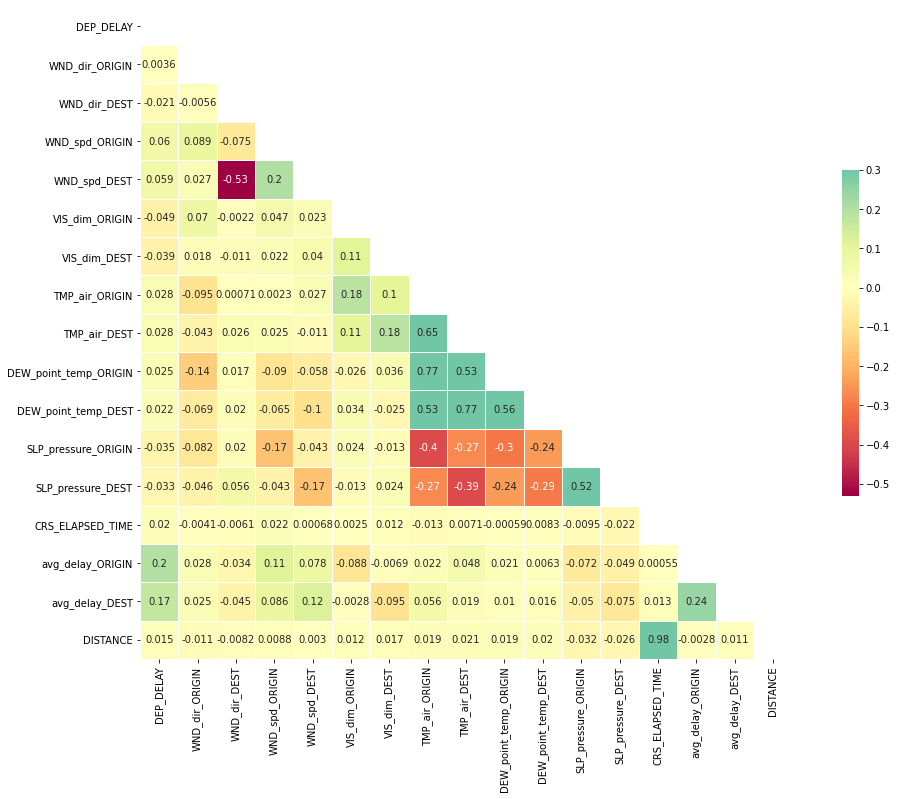

In [0]:
displayHTML("<img src = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4EAAAMfCAYAAABoxtL/AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOzdd3hU1dbH8e9KQugpQgpVegtIsYCFLtJUQLz2+l7F3iugiAWwoNgV9CoWrHSlCwIKiI2OIL1JElqA0NL2+8cMYSaNhASCye/zPvM45+x19llzMtw3K3uffcw5h4iIiIiIiBQPAYWdgIiIiIiIiJw6KgJFRERERESKERWBIiIiIiIixYiKQBERERERkWJERaCIiIiIiEgxoiJQRERERESkGAkq7ATkX0fPFBERERGRnFhhJyA500igiIiIiIhIMaIiUEREREREpBhRESgiIiIiIlKMqAgUEREREREpRlQEioiIiIiIFCMqAkVERERERIoRFYEiIiIiIiLFiIpAERERERGRYkRFoIiIiIiISDGiIlBERERERKQYUREoIiIiIiJSjKgIFBERERERKUZUBIqIiIiIiBQjKgJFRERERESKERWBIiIiIiIixYiKwBNgZqlmttjMVpjZEjN7xMwCvG3tzGyvt/3o6+IMxy03s2/NrMxJOEdiDn2+bmbbzCzAzEqZ2Soza+LT/piZDS+o6yQiIiIiIqefoMJO4F/qkHOuGYCZRQJfACHAM972n5xzlx7nuFHAncBrBXyOLHkLyF7AFqCtc+5HM3sQeNfM2gCVvfmck9s+RURERETk30cjgfnknIsH+gD3mpnl4dCfgDon+Ry+2gErgPeAa739TgW2AzcBw4CBzrk9J9i/iIiIiIj8C6gILADOufVAIBDp3dU6w1TN2r7xZhYEdAWWnaxzZOFa4EtgHNDdzEp49z8IDAIinHOfZXWgmfUxs9/N7PcRI0bkNmURERERETkNaTroyZHdVM3SZrb4aAzwv5NwjkzMLBjoBjzsnNtvZguBzsD3zrl/zGwW8H12xzvnRgBHqz+Xj5xFRERERKSQqQgsAGZWC0gF4oGGOYSm3+d3Es+Rlc5AGLDMO5u0DHCIY4VfmvclIiIiIiJFnIrAfDKzCOB94G3nnDvxW/ZO6jmuBW5zzn3p7a8ssMHMyjjnDhZstiIiIiIicjpTEXhijk7rLAGkAJ/hv8pna59pnwAvOOdGn6JzlDGzrT773wW64Fn5EwDn3AEz+xm4DPg6j3mJiIiIiMi/mDmnW7wkT/SFEREREZGcFPzUOClQWh1URERERESkGNF00EJkZhWAmVk0dXTO7TrV+YiIiIiISNGn6aCSV/rCiIiIiEhONB30NKfpoCIiIiIiIsWIikAREREREZFiREWgiIiIiIhIMaIiUEREREREpBhRESgiIiIiIlKMqAgUEREREREpRlQEioiIiIiIFCMqAkVERERERIoRFYEiIiIiIiLFiIpAERERERGRYkRFoIiIiIiISDESVNgJyL/Rj4WdQBbaF3YCIiIiIiL/ChoJFBERERERKUZUBIqIiIiIiBQjKgJFRERERESKERWBIiIiIiIixYiKQBERERERkWJERaCIiIiIiEgxoiJQRERERESkGFERKCIiIiIiUoyoCBQRERERESlGVASKiIiIiIgUIyoCRUREREREihEVgSIiIiIiIsWIikAREREREZFiJKiwE5B/r7lzVzBo0DekpaXxn/9cSJ8+Xfzak5KSefzxkaxYsZmwsLIMG3YbVatWBGD48KmMHj2PgIAAnnrqKlq3juHIkWSuv34oSUkppKam0blzC+6//zIAnHO8/voEpk79k4CAAK69tg033dThlH9mEREREZF/OxWBckJSU9N47rkv+fjjB4iKCufKK4fQocNZ1KlTOT3m22/nERJShhkznmfSpN8YOnQcr79+O2vX/sOkSb8xadIA4uL2cuutrzNt2nMEBwfxyScPUbZsKZKTU7nuuldo0yaGZs1qMXbsArZv38OUKQMJCAhg1659hfjpRURERET+vYrEdFAzG2ZmD/psTzOzD322XzWzh83Mmdl9PvvfNrNbvO9HmtkGM1tiZn+b2admVjUPOdxiZm97399pZjfl8TP0MbNV3tevZnaRT9tsM1vtze03M2vm07bRzCp630eZ2Rdmtt7M/jCzBWbWy9vWzsy+98k1zczO8ulnuZnVyG2+S5du5MwzI6lWLYLg4CC6dz+XmTOX+sXMmrWUXr3OB6Bz5xYsWLAK5xwzZy6le/dzCQ4uQbVqFTnzzEiWLt2ImVG2bCkAUlJSSUlJxcwA+PLLOdxzT3cCAjxf2QoVQvJwdUVERERE5KgiUQQC84ALAMwsAKgIxPi0XwDMB+KBB8wsOJt+HnPONQXqA4uAWTnEZss5975z7tOM+80sy5FXM7sUuAO4yDnXALgT+MLMon3Crvfm9i7wShZ9GDAemOucq+WcOxu4BsiukN0K9M/9p/IXF7eH6Ojw9O2oqDDi4vZkiEmgUiVPTFBQIOXLl2bPngM5HpuamkaPHi9wwQWPccEFDWnatCYAW7bsZPLk37niisHcdttbbNwYd6Kpi4iIiIgUa0WlCJwPnO99HwMsB/abWbiZlQQaAruBHcBM4OacOnMew4BYoGt2cWZ2q3fU8FfgQp/9A83sUe/72Wb2upn9DjyQTVdP4ClAd3rP/yfwCXBPFrELgCpZ7O8AJDnn3vf5HJucc29lc87vgRgzq5/d5/P5PH3M7Hcz+33EiBHHC8+XwMAAJkx4ijlzhrB06Ub+/nsbAElJKZQsWYKxY/tx1VUX0a/fZyc1DxERERGRoqpIFIHOuX+AFDOrjmfUbwGwEE9heA6wDEjyhr8EPGpmgbno+k+gQVYNZlYJeBZP8XcR0CiHfoKdc+c4517Npj0G+CPDvt/xH808qgueEb+s+vgzhxwySgNeBvodL9A5N8Kb/zl9+vQBICoqnNjYYyN/cXEJREWF+x0XFRXG9u2emJSUVPbvP0R4eNlcHRsSUoaWLevz008r0vvq1Kk5AJ06NWP16q15+KgiIiIiInJUkSgCvebjKQCPFoELfLbnHQ1yzq3HUyBel4s+LYe2lsBs59wO51wS8HUOsTm15dYoM9uAZwrnO8cLNrN3jt5DmEPYF0ArM6uZ12SaNDmTjRvj2bJlJ0lJKUya9BsdOpzlF9Ohw1mMG7cAgGnT/qRVq/qYGR06nMWkSb+RlJTMli072bgxnrPOqsHu3fvZt+8gAIcPJzF//l/UquWZEXvxxc1YuHA1AL/++jc1akTlNWUREREREaForQ569L7AJnimg24BHgH2AR9niB0MjAbmHKfP5nimj+bXgeO0rwTOBmb57DsbWOGzfT2e0cJXgLeAKzL0sQLofXTDOXePd8GY37M7qXMuxcxexTMdNU+CggIZMOBqbrvtTVJT0+jd+wLq1q3MG29MpHHjM+nYsSlXXnkhjz32MZ06PU1oaBmGDbsNgLp1K9O169l06/YsgYGBDBhwDYGBAcTH7+XJJz8hNTUN5xxdupxN+/aewrJPn848+uhHfPLJTMqUKcmgQTfmNWUREREREQHMOVfYORQI74qZY4H1zrmLvfv+wHP/XGOgHPC9c66xt+0boBUwwDk30sxGettHexdZuc/7ivGO9GU8XyXgF6AFnkJzFrDEOXevmQ0EEp1zQ81sNvCocy7bYszMLgeeBro453Z5P8tEoKVzbrtvH2ZWGlgHdHDOrTKzjXimvO7y5jPSOfeet9/qeBaKqWFm7bx9XOpdEfUcb67BeIrQ8t7zbTzOpXbw43FCCkP7wk5ARERERDxymk0np4GiNB10GZ5VQX/JsG/v0QVXMhhE5pUzXzGzJcDfwLlA+6wKQADn3HZgIJ5pp/OAv040cefcROAjYL6ZrQI+AG7wniNj7CHgVeCxDPsd0BNo633Uxa94FpfJcZTP+/neBCJPNH8REREREfn3KDIjgXLKaCRQRERERHKikcDTXFEaCRQREREREZHjKEoLw5w0ZrYQKJlh943OuWV57Kc/8J8Mu791zg3KT34iIiIiIiK5pemgkleaDioiIiIiOdF00NOcpoOKiIiIiIgUIyoCRUREREREihEVgSIiIiIiIsWIikAREREREZFiREWgiIiIiIhIMaIiUEREREREpBhRESgiIiIiIlKMqAgUEREREREpRlQEioiIiIiIFCPmnCvsHOTfRV8YEREREcmJFXYCkrOgwk5A/oWSpxR2BpmV6AppMws7i6wFdCzsDERERERE0mk6qIiIiIiISDGiIlBERERERKQYUREoIiIiIiJSjKgIFBERERERKUZUBIqIiIiIiBQjKgJFRERERESKERWBIiIiIiIixYiKQBERERERkWJERaCIiIiIiEgxoiJQRERERESkGFERKCIiIiIiUoyoCBQRERERESlGVASKiIiIiIgUI0GFnYAUHc45Bg0Zy5yf/qJUqRK8OOg6YhpVyxS3fMUW+j71BYcPJ9O2dUP6970CM+OloRP4cc4KSgQFUr1aRYa8cC0hIWXYk3CA+x/6mOXLN9Or53kM6H9l7nIZ/C1z5q7w5DL4JmJiqmeRy2b69v2Uw0eSadsmhv79/oOZkZBwgIce/h/btu2iSpUKvD7sNkJDy7Dw17+5+573qVq1IgCdLm7Gvfd0A2DfvoM89fQo/l7zD2Yw+IUbad68Vj6vqoiIiIhIwdJIoBSYuT/9xcbNO5g+uT/PD7yagc9/m2XcwOe/5fmBVzN9cn82bt7B3J//AuDC8+vz/bgn+G7cE9SoEcHwD38AoGRwEA/c143HH+2R+1zmrmDjpnimTx3I889ez8Dnvso6l2e/5Pnnrmf61IFs3BTP3J9WAjDig2mcf359pk97lvPPr8+ID6alH3PO2XWYMK4fE8b1Sy8AAQYN/pbWFzVi6uRnmDCuP7VrR+c6XxERERGRU6VYFYFmNszMHvTZnmZmH/psv2pmD5uZM7P7fPa/bWa3eN+PNLMNZrbEzP42s0/NrGoecrjFzN72vr/TzG7Kw7EDzWybmS02szVmNtbMGvm0zzaz1d72xWY22ru/vrdtsZn9ZWYjzKyzT1yiz3Gf5jafjGb+uIyel5+LmdGsaQ327T9E/I69fjHxO/aSeOAwzZrWwMzoefm5zJy1DICLLmxAUFAgAM3OqkFsnOfYMmVKck6LWpQsmfuB65mzltKzR0tPLs1qsm/fQeLjM+QSv5fExMM0a1bTk0uPlsycucTn+FYA9OzRih+8+7Ozf/8hfvt9LVdeeQEAwcFBhISUyXW+IiIiIiKnSrEqAoF5wAUAZhYAVARifNovAOYD8cADZhacTT+POeeaAvWBRcCsHGKz5Zx73zmXqegys5yqnWHOuWbOubrA195zR/i0X+9tb+acOzpv8k2f4xoCbznnph2NA373OS7XRWlGcXF7iY4OT9+OjgojLm5v5piosBxjAMaMW0ibixqeaCrExSX45xIdTlx8gn9MfEKGXMKJi/PE7Nq1n8jIUAAiIkLYtWt/etzixRu4vOcgbuvzNmvW/APA1q07OeOMcvTt9xk9rxhM/6c+5+DBIyecv4iIiIjIyVLcisD5wPne9zHAcmC/mYWbWUmgIbAb2AHMBG7OqTPnMQyIBbpmF2dmt3pHDX8FLvTZP9DMHvW+n21mr5vZ78ADufkwzrmvgenAdccJrQRs9TluWW76LyzvDZ9OYGAAl196dmGnAoCZYeZ5H9OoGrNmPs/E8f258fp23HPvcABSUtNYuXIL117TmvFj+1G6TDAjPpheiFmLiIiIiGStWBWBzrl/gBQzq45n1G8BsBBPYXgOsAxI8oa/BDxqZoG56PpPoEFWDWZWCXgWT/F3EdAoqzivYOfcOc65V3NxzuzOPcpnmucr3n3D8IwYTjGzh8wsLA/9Y2Z9zOx3M/t9xIgRfm2jvvyJHr1fpkfvl4mICCE2dk96W2xcAlFRoX7xUVGhxHpH27KKGTt+IbPnrmDoSzdiRyuvXBo1ag49eg2mR6/BRESE+ucSu4eoyDD/XCLDMuSyhyjvyGCFCuXTp4/Gx+/ljDPKA1CuXGnKli0FQNu2jUlJSWX3nkSio8KIjgqjadOaAHS5pAUrV27OU/4iIiIiIqdCsSoCvebjKQCPFoELfLbnHQ1yzq3HUyAeb5QNIKdqpSUw2zm3wzmXhGcKZ3ZyasvtuX2ngz4G4Jz7GM8o57dAO+AX78hnrjjnRniL03P69Onjf7JrWzNhzONMGPM4F3dowviJv+GcY/GSjZQvV5rICP8iMDIilHJlS7F4yUacc4yf+Bsd2zcBYO7Pf/HhR7N4763bKV06z7Nruf76tukLtlzc8SzGT1joyWXxBsqXL50+vTM9l8hQypUrxeLFGzy5TFhIxw5nAdChw1mMn/ALAOMn/JK+f8eOvTjnAFi6dCNpzhEeVpaIiFCiK4WzfkMcAAt+WUXtOpXy/BlERERERE624viIiKP3BTbBMx10C/AIsA/4OEPsYGA0MOc4fTbHM300vw6cwDHN8dzTlyPvKOhHwEdmthxoDPxxAufLVts2jZjz01906voCpUsHM/j5a9PbevR+mQljHgfgmaeuTH9ERJvWDWnT2nPv3/ODxpCUlMKtt78LQNOzavDcM1cB0OGSZ0lMPEJycgo/zFrGRyPuok4Oq2+2bduYOXNX0KnzM5QuFczgwTcey6XXYCaM6+fJZcA16Y+IaNM6hjZtPLeI9rntEh58+H+MHj2fypXP4PVhtwEwbfoivvzyJwKDAihVsgSvvfp/6SOWT/e/ikcf+5jk5BSqVavIkEEnfHuliIiIiMhJY0dHNYoLM2sGjAXWO+cu9u77A6iCpzAqB3zvnGvsbfsGaAUMcM6NNLOR3vbR5vnt/z7vK8Y70pfxfJWAX4AWeArNWcAS59y9ZjYQSHTODTWz2cCjzrlsCzrfeO92b+AdoIlzbkd2fZhZF2Cmcy7ZzKLxLGbT3DkX620/7rl9OJKn5CLsFCvRFdIKog4/CQI6FnYGIiIiIqdS3u7pkVOuOI4ELsOzKugXGfaVc87tNLNyGeIH4SmafL1iZk8DZfAUeO2zKgABnHPbvcXbAiABWJzP/B8ysxuAsnhGMjs453b4tI8ys0Pe9zu9he4lwBtmdti7/7GjBaCIiIiIiBQvxW4kUPJNI4F5pZFAERERKV40EniaK44Lw4iIiIiIiBRbxXE66EljZguBjKtu3pjX5/KZWX/gPxl2f+ucG5Sf/ERERERERDQdVPJK00HzStNBRUREpHjRdNDTnKaDioiIiIiIFCMqAkVERERERIoRFYEiIiIiIiLFiIpAERERERGRYkRFoIiIiIiISDGiIlBERERERKQYUREoIiIiIiJSjKgIFBERERERKUZUBIqIiIiIiBQjKgJFRERERESKEXPOFXYO8u+iL4yIiIiI5MQKOwHJWVBhJyD/PvuSvinsFDIJCb6KHYc/Luw0shRR6lZc/IjCTiMTi+xT2CmIiIiISCHQdFAREREREZFiREWgiIiIiIhIMaIiUEREREREpBhRESgiIiIiIlKMqAgUEREREREpRlQEioiIiIiIFCMqAkVERERERIoRFYEiIiIiIiLFiIpAERERERGRYkRFoIiIiIiISDGiIlBERERERKQYUREoIiIiIiJSjKgIFBERERERKUaCCjsBKZrm/7yGV1+aRFqqo8cVZ3PLbW382pOSUnim3xhWrfyH0LAyDH7lKipXCQdgzepYhjw3kcQDhwkw45Ov7qRkyRInnMsv89bzxks/kJaWxqW9mnLjf8/PlMsL/b9n9V+xhISW5rmXe1CpShgpyam8+OwU/v4rjtTUNLpc1jj92G9G/cZ3Y5bgHFzeuylX3XBunvNyzjHojR+Z+8sGSpUMYki/LsTUj8oUt3x1HH0HT+XIkRTatKpJ/wfaY2Y89Mx3bNi8B4B9iUcIKVeS8R/fxNbte+l+w0hqVvdcz6YxlXj20U55zk9EREREiqZ/5UigmQ0zswd9tqeZ2Yc+26+a2cNm5szsPp/9b5vZLd73I81sg5ktMbO/zexTM6t6EnPeaGYVc2ivamYTzGyNma0zszfMLNjb1s7M9prZYjNbZWZDfY67xcze9tm+wcyWmtkK72f70MzCvG2zzewcn3zG+Bx3pZmNLIjPmpqaxsuDvuONd2/imwn3MX3KUtavi/eLmTD2D0JCSjNu8kNcd+P5vDVsOgApKakM6DuaJwdcxjfj7+f9j/9LUFBgvnJ5bfB0hr57FZ+Pu50fpq5kw7qdfjHfj1tK+ZBSfP39nVx9w7m89/psAGbNWEVyUiqfjvkv//vyFiaMXsT2bQmsX7OD78Ys4YNRNzPy2/9j3ty1bPUWY3kx95cNbNq6h2lf/h/PPd6JZ1/9Icu4Z1/9gecf78S0L/+PTVv38NPCjQAMe/Yyxn98E+M/volL2talU5u66cdUrxKa3qYCUERERER8/SuLQGAecAGAmQUAFYEYn/YLgPlAPPDA0WIqC48555oC9YFFwKwcYk8aMzNgLDDeOVcXqAeUAwb5hP3knGsGNAcuNbMLs+inC/AQ0NU5FwO0wHMdMg8veZxtZo0K7IN4rVi2lWrVK1C12hmUKBFEp65NmPPjX34xc39cRffLmwHQoVMMvy1cj3OOhfPXUadeFPXqVwIgLKwMgYEn/jX9a/l2qlYLp0rVMEqUCOTiLo34efYav5iff1xD18ubANCuUwP++HUTzjnMjEOHkkhJSePIkRSCggIpW64kGzfsolGTypQqXYKgoACan12dOTNX5zm3mT+vo0eXRpgZzWIqsy/xCPE7E/1i4ncmknjgCM1iKmNm9OjSiB9+WusX45xj6o+r6X5xgzznICIiIiLFz7+1CJwPHJ3TFwMsB/abWbiZlQQaAruBHcBM4OacOnMew4BYoGtWMWYW6B09XG5my8zsIe/+2d5Ru8XetvO8+yuY2XTviNyHgOWQQgfgsHPuY28+qXiKuf8zszIZcj0ELAaqZNFPf+BR59y2o/045z5yzmVXobzqPaZA7YjfR1R0aPp2VFQoO+L2+8XE+8QEBQVSrlxJ9iYcZNOmnZgZ993xCTdc9S6ffvRTPnPZT2R0+fTtiMjymXLxjQkKCqBsuZLsTThE+4vrU7p0MD0vfovend/l2ptbEhJamlp1KrLkzy3sTTjE4UPJLPh5HfGx+/KcW9yORCpFHsstOqI8cRmKwLidiURHZIjZ4R/z+5JtVAgvS41q4en7tm7fS6//+5Qb7v2a35dszXNuIiIiIlJ0/SvvCXTO/WNmKWZWHc+o3wI8RdH5wF5gGZDkDX8JmGJmH+Wi6z+BBsCELNqaAVWcc40Bjk6x9CrjnGtmZm2Aj4DGwDPAz86558ysO/DfHM4bA/yR4TPuM7PNQB3f/WYWDtQF5mbTz585nCejb4C7zaxOTkFm1gfoAzB8+HCuuSUsD6fIm9TUNJYs2sQnX95JqVIluPu2kTRoVJnzWtU+aefMzsrl2wkINMbPuJf9+w5z962jOKdVDWrUqsgNt7bioTu/onTpEtStH0VAPkYr82vSD6v8RgEjK5Rl1ug+hIeWZvnqOO7tN57vP72FcmVLFlqOIiIiInL6+LeOBIJnNPACjhWBC3y25x0Ncs6tBxYC1+Wiz5xG69YDtczsLe+0S9+hny+955oLhHgLxDbA5979k4C83zTmr7WZLQG2AdOcc7E5BZtZE+/o5DozuzqbsFTgFaBvTn0550Y4585xzp3Tp0+f4yYaERlCXOze9O24uL1ERJX3i4n0iUlJSSUx8QihYWWIigqh+dk1CAsvS6nSwVzQui6r/9p+3HNmn0t54mOPjfztiN+fKRffmJSUNA4kHiE0rDQzpqyk5QW1CCoRSHiFsjRpVoVVKzy5XHpFUz766lbe+fgGyoeUotqZZ+Qqn1FjF9Hz1k/peeunRFYoy/b4Y7nF7thPVMVyfvFRFcsRuyNDTMSxmJSUNGbMXUO3DvXT9wUHBxEeWhqAxvWjqFY5jA1b8vv1ExEREZGi4t9cBB69L7AJnumgv+AZCTx6P6CvwcAT5Fzkged+u7+yanDO7QGaArOBO4EPfZszhh83e38rgbN9d5hZCFAdOHoD2E/e+xdjgP+aWbMs+lmB5z5AnHPLvPcQTgFK53Duz/AUrNXymHO2GjWuwuZNu9i2dQ/JySnMmLKMNu3871dr3a4BkyYuBmDWjBWce15NzIxWF9Rl7Zo4Dh9KIiUllT9/30jN2hEnnEuDmEps2bybf7YmkJycyg9TV3JhW/+Bzwvb1WHKxGUAzJ6xihbnnYmZERUdwp+/bgLg0MEkVi77hzNrVgBgz64DAMRu38ucmavp1DV3t1Zef0Xz9AVbOrauw4SpK3HOsXjFP5QvV5LIDEVgZMVylCtbksUr/sE5x4SpK+l40bFR0QV/bKJm9TOI9plWunvPQVJT0wDY8k8Cm7YmUK1yKCIiIiIi8C+dDuo1H3gUWO+9h263dwQuBrgdz8IqADjnVpnZSuAy4LeMHXkXZrkPqARMzepk3pU9k5xzY8xsNd5RPq+rgR/N7CJgr3Nur5nNxTP6+IKZdQXCM/eabibwopnd5Jz71MwC8dyvN9I5d9CTXvpn2WBmL+Ipaq/N0M8QYKiZ9XDOHb0RLKcCEOdcspkNA54EZuUUm1tBQYE83u9S7r/zE1JT07i8Vwtq14ni/bdn0jCmMm3bN6THFS14pu8YenUbRkhoaQa9fBUAIaGlue7GC7jp2vcxMy5sXY+L2tQ/zhlzyiWAh/tewsN3fU1amqN7z7OoVSeCD9+ZS4OYSlzUri6X9mrK8/2/4+pL3yckpDQDX+4BwBXXtGDwgEnc0OtDwNGtx1nUqRcJQP9HxrFv7yECgwJ4uN8llA8plefc2p5fk7m/rOeSa/5HqVIlGNy3c3pbz1s/ZfzHNwEw4OGO9Bs8lcNHUmjdqiZtWtVMj5v0w2ouzbAgzG9LtvLW/+YTFBRAgBkDH72YsJAcvwYiIiIiUoyYc3kdtDo9eAulPcCbzrmnvPtGAuc75+qbWQ3ge597+JriWQH0/5xzI72xbfFM6yyDZySxr0/xlPF8TYGPOTZ62tc5N8XMZuNZqKUtUMLb/69mVgHPNNEqeArWS4CznXM7M/bt7b8a8C6eexIDgMl4Fnk5YmbtvO8v9caWxjNCeCHQDjjHOXevt+1mPMVxIJCAZ5T0Gefcdm+ujzrnfjezjd7jdnoX09kATHfO3ZLTdQfcvqRvjhNy6oUEX8WOwx8XdhpZiih1Ky5+RGGnkYlFHn9qr4iIiMgJON7sOylk/9oi8HThW1gVdi6niIrAPFIRKCIiIsWMisDT3L/5nkARERERERHJo3/zPYEnjZktBDKup3+jc25ZxljnXLs89FsBz/1/GXV0zu3KU5IiIiIiIiInQEVgFpxzLU9Sv7vwPG9QRERERESkUGg6qIiIiIiISDGiIlBERERERKQYUREoIiIiIiJSjKgIFBERERERKUZUBIqIiIiIiBQjKgJFRERERESKERWBIiIiIiIixYiKQBERERERkWJERaCIiIiIiEgxoiJQRERERESkGDHnXGHnIP8u+sKIiIiISE6ssBOQnAUVdgLy77Mv6ZvCTiGTkOCrSEqdXNhpZCk4sBsfB3Qs7DQyuTVtJhM3fl7YaWRyeY0bCjsFERERkSJN00FFRERERESKERWBIiIiIiIixYiKQBERERERkWJERaCIiIiIiEgxoiJQRERERESkEJhZFzNbbWZrzezJLNrvNLNlZrbYzH42s0YFcV4VgSIiIiIiIqeYmQUC7wBdgUbAtVkUeV8455o455oBLwOvFcS5VQSKiIiIiIiceucBa51z651zScBXQA/fAOfcPp/NshTQM7v1nEAREREREZFTrwqwxWd7K9AyY5CZ3QM8DAQDHQrixCoCRUREREREMnh4wRf5HnUbdsH1dwB9fHaNcM6NyEsfzrl3gHfM7DrgKeDm/OalIlBERERERCSDQMt/H96CL7uibxtQzWe7qndfdr4C3st/VronUEREREREJJMAy//rOH4D6ppZTTMLBq4BJvoGmFldn83uwJqC+GwaCRQRERERETnFnHMpZnYvMA0IBD5yzq0ws+eA351zE4F7zexiIBnYQwFMBQUVgSIiIiIiIpkUxHTQ43HOTQYmZ9g3wOf9AyfjvCoCpcDM/3kNr740ibRUR48rzuaW29r4tSclpfBMvzGsWvkPoWFlGPzKVVSuEs4/2/ZwVY83qV6jIgBNzqpG3wGXAzB96jI+HjGH1LQ0Wrepz30Pd85zXj//9BcvDRlHaqrjiitbctvtF2fKq9+To1i5YithYWV45bWbqVLlDObPX83rr31PcnIqJUoE8sijl9OyVV0OHDjMzTe8lX58XNxeLr3sbJ7o2yvPuflq+cY9VO3akpSDR/j51pfZtSjzaH+XWa9SplIFUg4dAWB65yc4vCOB+ndcSsO7e5CWmkZK4iHm3TGMvX9tylc+WVn121omvj+NtFTHeV2b0+HqC/3a54z5hV+nLiIgMIByoWW46uHLCI8KK/A8REREROTEqQiUApGamsbLg77j7RG3EBUdws3XvE+b9g2oVTsyPWbC2D8ICSnNuMkPMX3KUt4aNp0hQ68GoEq1M/hi9D1+fSYkHOTNV6fx2dd3EX5GWQb2H8Ovv6zjvFa185TXoBfGMOLDO4mOCuOaq4fRvn1jateJTo8ZO+YXQkJKM3laf6ZM/pNhr37H0NduJjysLG+/exuRkaGsWbOdO28fzszZAylbthSjxz2WfvxVV75Kx05nneilA6Bq1/MIqVOVMfVuIqJlQ85/9wG+P//eLGPn3DCYXX/87bdv/RezWD38ewCqXXY+5716JzO69c1XThmlpaYx7p2p9BlyPaEVQ3jzvg+JaVWPqDMj0mOq1I7mgbduI7hUCeZ/9zuTPpzJDf17F2geIiIiIqfCqRgJLCxFdmEYMxtmZg/6bE8zsw99tl81s4fNzJnZfT773zazW7zvR5rZBjNbYmZ/m9mnZlb1JOa80cwq5tCeamaLzWyFN6dHzCzA29bOzPZ624++Lva29fces9S7v6WZjfO+X5vhuAtOJPcVy7ZSrXoFqlY7gxIlgujUtQlzfvzLL2buj6vofnkzADp0iuG3hetxLvuVd7dt3U21MysQfkZZAM5rVZtZP6zMU17Llm2mevWKVKtWkRLBQXTt2pwfZy33i/lx1nIu73keAJ0uacrCX9bgnKNho6pERoYCUKdONIcPJ5OUlOJ37MaN8ezencjZZ9fKU14ZVe9xIWs/mw7AjoV/ERxWjtLRZ+T6+OT9B9PfB5UtVUCPEfW3efU/VKwcToVK4QSVCKRZuxhWLFjtF1OnWQ2CS5UA4MyGVUjYuS+rrkREREROewEB+X+drorySOA84CrgdW+hVBEI8Wm/AHgIiAceMLPhzrmkLPp5zDk32swMeBCYZWaNs4k92Q4555oBmFkk8AWez/SMt/0n59ylvgeY2fnApUAL59wRb5EZ7Jzr5W1vBzya8bi82hG/j6jo0PTtqKhQli/d6hcT7xMTFBRIuXIl2ZvgKV7+2baH6//zDmXLluKu+zrS/OwaVKtWgc0bdvLPtj1ERoUwe9ZfJCen5imv+LgEoqPDjuUVHcrSpZszxOxNjwkKCqRc+VIkJBwgPLxcesyM6Uto2KgKwcH+/2SmTF5Ely7N8Hw9TlyZyhU5sGVH+vaBrTsoU6Uih2J3Z4pt/dFjpKWmsWnsTyx54fP0/Q3u7kHMQ1cSGBzE1I6P5iufrOzbtY+wiGP/hEIrhrB5VfarGP86dTENzq1T4HmIiIiISP6cxvVpvs0Hzve+jwGWA/vNLNzMSgINgd3ADmAmx1lpx3kMA2KBrlnFmFmgd/RwuZktM7OHvPtnm9kb3pG25WZ2nnd/BTOb7h2l+xDIdSXhnIvH8+DJey3nCqQSsNM5d8R73E7n3D+5PY83zz5m9ruZ/T5iRJ6ebZkrFSPK8930Rxn17T089FgXnnriWxITDxMSWponnr6Mfo99Q5+b/0elymEE5mKt3YK2ds12hr32Pc8MvCpT29TJi+javcUpy2XuDUMY3/R2Jrd5kKiLmlD7xk7pbavencCYujfy+5Mf0LT/Dacsp6z8MXMpW9dsp92V5x8/WEREROQ0FGj5f52uimwR6C10UsysOp5RvwXAQjyF4TnAMuDoaN5LwKNmFpiLrv8EGmTT1gyo4pxr7JxrAnzs01bGO4p3N/CRd98zwM/OuRhgHFA9d5/Owzm3Hs9yskdvvGudYTpobWA6UM07nfVdM2ubl3N4zzPCOXeOc+6cPn36ZBkTERlCXOze9O24uL1ERJX3i4n0iUlJSSUx8QihYWUIDg4iLKwMAA1jqlC12hls3rQLgDbtGjDyizv4aFQfzqxRMX3xmNyKjAojNjbhWF6xe4mKDM0QE5oek5KSSuL+w4SFeaagxsYm8OD9HzN4yHVUq+5/7tWrtpGamkZMTDVORIO7e3D5n8O5/M/hHIzdRdlqx+6tK1s1goPbdmY65uA/nn0piYdY/+UsIs7L/FVc/9WPVO95QrN6cxRSIYSEHcemd+7duY/QiuUzxf3953pmffkztz57NUHBRXmygYiIiMi/U5EtAr3m4ykAjxaBC3y25x0N8hZTC4HrctFnTjX9eqCWmb1lZl0A3xuivvSeay4QYmZhQBvgc+/+SXie/ZEfPznnmvm81jnnEoGz8Ywa7gC+PnrPY0Fq1LgKmzftYtvWPSQnpzBjyjLatPMvUFq3a8CkiYsBmDVjBeeeVxMzY8/uA6SmpgGwdctutmzeRZWq4QDs3pUIwL69hxj99a/0uOLsPOXVuHE1Nm3awdatu0hOSmHKlEW0ax/jF9OufWMmjv8V8Ez7PK9lHcyMffsOcc9dH/Dgw5fSvEXme/4mT/6Trt2a5ykfX6vencDEFncwscUdbB4/jzo3XgJARMuGJO09kGkqqAUGULKCZzqmBQVSrXsr9izfAEBInSrpcdW6t2LfmuynaZ6oavUrs3PbbnbH7iElOZXFs1fQqFU9v5hta7cz5s3J3PLs1ZTzFtIiIiIi/0ZFeSSwqP+Zfh6egq8JnumgW4BH8BRnH2eIHQyMBuYcp8/meKaPZuKc22NmTYHOwJ147kn8v6PNGcNz9xGyZ2a1gFQ89zU2zC7OOZcKzAZmm9kyPFNfR+b3/L6CggJ5vN+l3H/nJ6SmpnF5rxbUrhPF+2/PpGFMZdq2b0iPK1rwTN8x9Oo2jJDQ0gx62TO9ctEfG3n/nZkEBQUSEGA8+fTlhIZ6RgZffWkya1bHAnDbne04M48jgUFBgfTr35s7bx9OaloavXq1pE7dSrz91hRiYqrRvkNjrujdkr5PjKJb50GEhpXh5aE3AvDlFz+xZfNO3n93Gu+/Ow2A4R/eSYUKntGvaVMX8+77WY+M5tXWyQup2q0lvdd8RurBw/z0f6+kt13+53AmtriDwJLBXDL1JQJKBGGBAWyf+Sd/f+B5rEzDe3tSqWML0pJTSNqTyE+3vFQgefkKDAyg5z1d+KDfF6SlOc67pCnRNSKZ9slsqtarRMz59fn+g5kkHUrisxfGABAeGcKtz15T4LmIiIiIyImznFZn/Lczs2bAWGC9c+7oSpl/AFWAxkA54HvnXGNv2zdAK2CAc26kmY30th9dGOY+7ysmq4VhvIuuJDnn9plZY+Bz51wzM5sNrHLO3WlmFwHvOeeamNmbQLxz7gUz64rnQZERzrnM8wA9/Sc658p530cAo4AFzrlnslvgxczqA2nOuTXe7ReAMOfcvd7tLI/LgduX9E0uQ0+dkOCrSEqdfPzAQhAc2I2PAzoWdhqZ3Jo2k4kbPz9+4Cl2eY3CvZ9RRERE8u00HgPLvSGLv8h3odS32XWn5bUo6iOBy/CsCvpFhn3lnHM7zaxchvhBwKIM+14xs6eBMsAvQPscVgatAnx89LENgO+D2g6b2SKgBMdGB58FvjSzFXimrvovW5lZaTNb7O0jBfgMeM2nvbW3/agXgA3AW97ppynAWjxTQ0VEREREJBuBVnQHy4p0EeidBhmSYd8tPu834hkRPLq9BJ/7JH1jc3m+JUB2S0V+7px7MEP8LuCSPPSf7cI1zrnZQGg2zdmuEuI9bnZucxARERERKQ5O53v68quoLwwjIiIiIiIiPor0SODJZGYLgZIZdt/onFuWMdY51y4P/VYg64VnOnpHDkVERERERE6YisAT5JxreZL63YXneYMiIiIiIlJIivJ0UBWBIiIiIiIiGQSoCBQRERERESk+NBIoIiIiIiJSjBTlIlCrg4qIiIiIiBQjKgJFRERERESKEU0HFRERERERyUALw4iIiIiIiBQjuidQREREREREigSNBIqIiIiIiGSgkUAREREREREpEsw5V9g5yL+LvjAiIiIikpMiMYb22d+j8v177431rj8tr4Wmg0re7fu6sDPILORq9hwZVdhZZCm85PXgfizsNDKz9hxIHlvYWWRStsQVJKdNLew0slQioEthpyAiIiKnSFFeHVTTQUVERERERIoRjQSKiIiIiIhkUJQXhlERKCIiIiIikkFRLgI1HVRERERERKQY0UigiIiIiIhIBloYRkRERERERAqUmXUxs9VmttbMnsyi/WEzW2lmS81sppmdWRDnVREoIiIiIiKSQYC5fL9yYmaBwDtAV6ARcK2ZNcoQtgg4xzl3FjAaeLlAPltBdCIiIiIiIlKUBFr+X8dxHrDWObfeOZcEfAX08A1wzv3onDvo3fwFqFoQn01FoIiIiIiISAYFMRJoZn3M7HefVx+fU1QBtvhsb/Xuy85/gSkF8dm0MIyIiIiIiMhJ4JwbAYzIbz9mdgNwDtA230mhIlBERERERKQwbAOq+WxX9e7zY2YXA/2Bts65IwVxYhWBIiIiIiIiGZyCR0T8BtQ1s5p4ir9rgOt8A8ysOTAc6OKciy+oE6sIlALjnGPQq5OZM28NpUqV4MVnehHToHKmuOV//UPfZ8dy+EgKbS+sS/9HumF27F/ZR5/P46U3prFgxhOcEVaWvfsO0e/58WzeupuSwUEMfron9epEnVCOC35ey7CXppGWlsblVzTnpv9e5NeelJTCs/3Hs3rldkJCS/PCK1dSuUoYUyctY9TI+elxa/+O45Ov+1CvQXSezu+cY9Cgb5gzdzmlSgXz4pCbiYmpnilu+fJN9O37CYePJNO2TWP6978KMyMh4QAPPfwB27btokqVCrw+7HZCQ8sy8buFfPDBdHCOsmVLMXDgdTRoUJXt23fz+BMj2bVrH2bGVVddxM03dTxunvN+Xs3QF78nNTWNXr3P5dbb2mW6Tk/3/Ya/Vm4jLKwMLw69jspVwtPbt29P4MrLh3HH3R256dY2bNywgycf/TK9fdvW3dx578Vcf6P/9T+en3/6ixcHjyU1LY3eV7bitts7Zcqr7xOfs3LlFsLCyjL0tZupUqUC8+et4vXXviM5OZUSJQJ55LEetGxVD4A7bn+PHTv2kZqSRotzavHU0/8hMFC3S4uIiBR3gcdZ3TO/nHMpZnYvMA0IBD5yzq0ws+eA351zE4FXgHLAt97flzc75y7P77n1m44UmLnz17Bx8y6mj32A5/tdzsAXv8sybuCL3/F8/x5MH/sAGzfvYu78Nelt22P3Mm/hWipHh6bve//juTSsF813X97DS89ewaBXJ59QfqmpaQwdPIVh713Hl+PvZvqUFWxYt8MvZuLYRYSElGb0pPu49sZWvPP6DwB06d6Ez769g8++vYNnBvWkcpXwPBeAAHPnLmfjpnimT3uO55+7noHPfpFl3MBnv+D5529g+rTn2Lgpnrk/rQBgxAdTOb9VA6ZPe57zWzVgxAfTAKhapSKff/Yw3303gLvu7sbTAz4HIDAwkCefuJLJkwby9VdP8MWoOaxd+89xr9NLL0zkrfduZczEh5g6eQnr18X5xYwf+xshIaWZOOUxrr/xIt54zf8e5ddensSFreulb9eoGcFXY+7nqzH3M+qbeylVqgTtO8bk6dqlpqbxwvPf8t6IO5j4XV8mT/qTdWtj/WLGjl5ASGhppkx7mhtvasdrQz3fwfDwcrz9Xh/GTXySQUOup+8Tn6cf8+qwWxk7/gnGf/cke3YnMm3q4jzlJSIiIkVTgOX/dTzOucnOuXrOudrOuUHefQO8BSDOuYudc1HOuWbeV74LQCiiRaCZ/WhmnTPse9DMppjZcu92GTMbZWbLzGy5mf1sZuVy2f9AM3vU+/457zzd/OYcY2azvA+LXGNmT5u33DezW8xsh5ktNrNVZvZQVrl4tx/2xiwzsyVm9pqZlfC2bTSzit73zsxe9TnuUTMbmJ/PMHPOKnp2b4aZ0axJNfbtP0z8zv1+MfE795N44AjNmlTDzOjZvRkz56xKbx8ybAqP3dfZb2Rw3YZ4Wp1TE4DaNSLYtj2BnbsS85zfyuXbqFo9nCpVwylRIpBOXWKY++Nqv5ifZq+m2+VnAdC+UyN+X7gB5/z/CjRjynIu7pK3AuaomTOX0rNHK881alaLffsOER+/1y8mPn4viYmHadasluca9WjFzB+WHDu+5/kA9Ox5Pj9497doUZvQ0LIANGtak9jYPQBERoamjzSWK1eKWrWjiYtLyDHH5cu2ULV6BapWO4MSJYLo3LUps2f95Rcze9ZfXNqjBQAdL2nMbwvXpV+nH2euoHKVcGrVznq09tdf1lK1WgUqVw7Psj07y5Zuonr1CKpVq0iJ4CC6dmvBrFnL/GJmzVpOjx7nAXBJ56Ys/OVvnHM0bFSVyEjPHxbq1K3E4SPJJCWlpF8XgJSUNJKTU7GTP/VDREREpFAVySIQ+BLPnFpf1wBDfLYfAOKcc02cc43xLLmanNcTeSv1H044U8DMSgMTgRedc/WBpsAFwN0+YV8755oBFwL9zaxaFv3cCVwCtHLONQHOBeKB0lmc9ghwxdGisCDE7dhHdNSxEbzoyBDi4vf5x8TvIzoyxD9mhyfmhzl/ERkRQoN6/iNsDepGM/1HTxGydMVW/ondS2yGfnNjR9x+In3yi4wKYUf8/kwxUd6YoKAAypUrxd6EQ34xP0xbySVdG+f5/ABxcQlEVzpW/ERHh2UqyuLiEoiOzjpm16596cVMREQIu3Zlvg6jR8+jTZvM+W3dupO//tpC06Y1c8xxR/w+oqP9r1PGQtUTEwZAUFAg5cqVIiHhIAcPHmHkR3O44+7sp5xOm7KUzt3OyjGHrMTH700/J0BUVBjxcRkKaJ/rGxQUSLnypUhIOOAXM2P6Eho1rEpw8LHZ8H1ue4+2F/WnbNmSXNK5WZ5zExEREfk3KapF4Gigu5kFA5hZDaAy/s/hqITP6jvOudU5rbZjZv3N7G8z+xmo77N/pJld6X2/0cyGeEfsfjezFmY2zczWeQu07FwHzHPOTffmchC4F3gyY6Bzbhew1pt/Rv2Bu5xzCd7YJOfci865rCqmFDzL1T6URdspd+hwEsM/nssDd3bI1Nbn5tbs33+YHte9y2dfL6RhvWgCT8GdullZvnQrpUqVoHbdyEI5vy8z8xsxBfjll9WMHjOfRx/p5bf/wIHD3H//CPr1vYpy5bL6m0DBGP7OTK6/8SLKlCmZZXtycgpzZ/9Fp0uanLQccrJ2zXZee3UiA5692m//iA/v4se5z5OUlMLCX/4ulNxERETk9FIQzwk8XRXJhWGcc7vN7FegKzABzyjgN4DvT+IjYLq3gJsJfOKcW5OpM8DMzvb20QzPNfsT+COb0292zjUzs2HASDwjd6WA5cD72RwTk7E/59w6MytnZiG++82sure/pRn2hwDlnHMbsjlHVt4BlprZyzkFeR9q2Qdg+PDh9Lnm2CjRqG8W8s14T+pNGlUh1mdkJjZ+H1GRfukTFRniN4oXG7+PqIgQNm/dw9Z/Euhx3bvp+6+44X2+HdmHiIrlGfKMp6hxztGxxzCqVcnbVEKAiKjyfiNH8XH7iIgsnykmLm4vkdEhpKSkkZh4mNCwY0XTD1NX0Klr3qaCjho1im+++QiAJk3OJHb7nvS22NgEoqLC/OKjosLSp3NmjKlQwTMqFxkZSnz8Xs4441j+q1Zv5amnP+ODEfcRHn5sZnNycir33z+Cyy47j0suaX7cfCMiQ4iN9b9OR0cf/WMSiIoOJSUllcTEw4SFlWHZsi38MGMZb7w2hf37DxNgRnDJIK657gIA5v30Nw0aVqZCRf/rnhuRkaHExiakb8fFJfiN7AJERoURu30P0dFhnrz2HyYszDNNNjY2gQfu+x+DX7yB6tUzD4CXLFmC9h2a8OOs5VxwYYM85yciIiJFS2ARvkWkqI4Egv+U0Gu82+mcc4uBWnhW3DkD+M3MGmbTV2tgnHPuoHdUbWIO5z3atgxY6Jzb75zbARwxs7AT+SBeV5vZUjyjgO865w7nFGxmnb0jkhvN7IKsYryf5VPg/pz6cs6NcM6d45w7p0+fPn5t11/Vkglf3M2EL+7m4nYNGD9pMc45Fi/bQvlypYjM8Mt+ZMXylCtbksXLtuCcY/ykxXRs24D6daJYMP0JZk18mFkTHyY6MoSxn99JRMXy7Nt/iKRkz/1b347/g3Oan5l+H1deNIypwpZNu/ln6x6Sk1OZMXUFrdvV84tp3a4+kyd66usfZ6zknPNqpo+2paU5Zk5fSac8TgW9/vrrmTD+KSaMf4qLOzZj/IRfPNdo8XrKly+VqcCKjAylXLlSLF683nONJvxCx46e6ZMdOpzF+PELABg/fkH6/n/+2c199w3n5ZdupWbNY/fiOefo/9Sn1Kodza235u7W1ZjGVdmyeSfbtu4mOTmFaVOW0La9/z+Ntu0b8v2EPwGYOX0557asjZnx0ad3MGn6E0ya/gTX3XAh/3d7u/QCEGDq5CV07tY0T9fvqMZNqrN50w62bt1FclIKUyb/Sfv2/j+L9u0bM2HCrwBMn7aElq3qYmbs23eQu+8czoMPX0aLFrXS4w8eOMIO71TXlJRU5s5ZSc1ahT/KKyIiIoXvVCwMU1iK5Eig1wRgmJm1AMo45/7wTgtN55xLBMYCY80sDegG/JWpp7w5OqU0zef90e3srvdKoI3vDjOrBSQ65/Z5i5CvnXP3mtk5eEYwJzrn0pdG9MYlmllN59wG59w0YJqZfQ8E55Dv63hGNj/O/UfMWtsL6zFn3ho69Xqd0qVKMHjAsSmJPa57lwlfeG5xfOaJS+n77DgOH0mmzQV1aXNB3Rz7XbdhB08+Ow6AurUiGfR0zxPKLygogEf7deWBu0aRluq4tGczatWJZMQ7P9KgUWXatK/PZb2a82y/cVzZ/S1CQkvz/Mu9049f9McmIqNCqFI176OQR7Vt25g5c5fT6ZKnKV0qmMGDb05v69HzBSaMfwqAZwZcR99+n3D4cBJtWsek3+PX5/bOPPjQB4weM4/KlT2PiAB4591JJCQc4NnnPH/rCAwMYOyYfvzx5zomTFhIvXpV6NHzBQAefqgHbdtmPx0zKCiQJ/pdzj13fERaquPyXudQu04U7709g0YxVWjbvhE9rziHp/t+w+VdXyE0tAxDXrn2uJ/90MEkFi5YQ/9neh03Nru8+j3Vmztue4/UtDR6XdGKOnUr8fabk4lpXI32HZpwxZWt6PvE53Tt/DyhoWV45VXP9f1y1E9s2byT99+bxvvveVZUHfHhXTjnuPeeD0hKSsGlOc5rWZerrr7whPITERER+bewjCsfFiVm9jWe+/cmOOee8RaB3zvnGpvZhcBK59we772DU/GMsI3Oop8WeKZ2tuTYdNDhzrmhZjbS2+doM9sInOOc22lmt3jf3+vtI70ti/5LAyuAPs65H7zb3wLTnHNvZdHXG8BB51xf74qeid5c7gYuB65xziV4VxedAbzgnJudIb9E51w5b38v4xkt/cg5N/A4l9Wx7+vjhBSCkKvZc2RUYWeRpfCS14P7sbDTyMzacyB5bGFnkUnZEleQnDa1sNPIUomALoWdgoiIyL/BaTwGlns/x47Md6F0UfQtp+W1KMrTQcEzBbQpGaaCetUG5pjZMmAR8DswJqtOnHN/Al8DS4ApwG8FmaRz7hDQA3jKzFbjmUr6G/B2Noe8BNxqZhlvrHoPz/2NC71TR+fh+WyLjpPCq0CBrRIqIiIiIiKnryI9EignhUYC80gjgXmjkUAREZF/vdNy9CuvFsTlfyTw/CiNBIqIiIiIiEghK8oLw+SZmVXAM50yo47e5/Plt/8mwGcZdh9xzrXMb98iIiIiIlJwTufn/OWXikAf3kKv2Unsf9nJ7F9ERERERArG6fyIh/xSESgiIiIiIpJBYBEeCdQ9gSIiIiIiIsWIikAREREREZFiRNNBRUREREREMtA9gSIiIiIiIsWIVgcVEREREREpRoryfXNF+bOJiIiIiIhIBioCRUREREREihFNBxUREREREcmgKD8nUEWgiIiIiIhIBkV5dVBzruhWuHJS6AsjIiIiIjkpEuXTmr0f5Pv33rqht5+W10IjgZJ3iWMKO4PMyvUmJW1aYWeRpaCAzpA6o7DTyCywE8lpUws7i0xKBHThUMqEwk4jS6WDerDtwPDCTiOTKmXvKOwURERE5F9ERaCIiIiIiEgGgaflGF7B0OqgIiIiIiIixYhGAkVERERERDII0OqgIiIiIiIixUdRXh1U00FFRERERESKEY0EioiIiIiIZFCUHxavkUAREREREZEMAiz/r+Mxsy5mttrM1prZk1m0tzGzP80sxcyuLLDPVlAdiYiIiIiISO6YWSDwDtAVaARca2aNMoRtBm4BvijIc2s6qIiIiIiIyKl3HrDWObcewMy+AnoAK48GOOc2etvSCvLEGgkUERERERHJwAjI/8usj5n97vPq43OKKsAWn+2t3n0nnUYCRUREREREMjDL/zMinHMjgBH5z6ZgqQgUERERERHJwE7+pMltQDWf7arefSedpoOKiIiIiIicer8Bdc2sppkFA9cAE0/FiTUSKAXGOcegV75nzrzVlCoVzIsDexPTMPO05uV/baPvM6M5fCSZthfWp/9jl2JmvP7uDGbO+YuAAKNCeFmGPHslUREh7N13iH7PjmHz1t2ULBnE4AFXUK9OdK7z+umnlbw4eCypaWn0vvJ8br+9k197UlIyfZ/4nBUrtxAWVpZXX7uFKlUqkLDnAA8++D+WL99Mz54teerp/6QfM2nSH3wwfDpmRkRkCC+9fBPh4eXyfr0Gj2bO3BWUKh3Mi4NvJKZRtUxxy1dspm+/zzh8OJm2bWLo3+9KzIwpU//k7Xcms259HN9+/ShNGp8JwJ6ERO5/8H8sX7aJXr1aMeCpq/KUF8DPP/3lc81acVuma5ZC3yc+Z6X3mg197WaqVKnA/HmreP2170hOTqVEiUAeeawHLVvV49ChJB5+8GO2btlJQEAA7drH8NAjl+c5L1/zflrNyy9OIC3V0av3efzf7e0z5fhU36/4a8U2QsPK8NKr11Olyhnp7dv/2cMVl7/Knfd04uZb2+YrF1+/ztvA20Nnk5aaRrdeTbju1vP82pf8sZV3Xp3N+jU7eHpId9peXC+97Yl7xrByWSxNmlVm8Ju9CiwnEREROf0451LM7F5gGhAIfOScW2FmzwG/O+cmmtm5wDggHLjMzJ51zsXk99waCZQCM3fe32zcsovp4x/h+ad6MnDIhCzjBg6ZwPNP92L6+EfYuGUXc+f/DcBtN7Xmu6/vZ8KX99GudQPe+WAWAO9/NJuG9Svx3df389KzVzJo6Pe5zik1NY1Bz3/L+yPuZOJ3/Zg86Q/Wrt3uFzNm9C+EhJZh6rQB3HRTO14b6vkDTHDJIO67vzuPPdbTLz4lJZUXB4/h40/uY9yEJ6lXrwpfjJqb65yOmjt3JRs37WD61Gd4/tlrGfjsV1nGDXzua55/7jqmT32GjZt2MPcnz4JR9epW5q03b+fcc2r7xZcMLsED913K44+dWBGRmprGC89/y3sj7mDid32ZPOlP1q2N9YsZO3oBIaGlmTLtaW68qR2vDf0OgPDwcrz9Xh/GTXySQUOup+8Tn6cfc+v/deC7yf0ZPfYxFi3awE9zV3KiUlPTGDJoHO+8/1/GTnyEqZMXs25tnF/MuDG/EhJSmu+mPsENN7Xmjdcm+7W/+vL3XNi6/gnnkF1eb7w0ixff6sXHY25h1tRVbFy/yy8mqlJ5nhjYmY5dGmQ6/uqbzqXv810KNCcRERE5MWaW79fxOOcmO+fqOedqO+cGefcNcM5N9L7/zTlX1TlX1jlXoSAKQCjGRaCZ/WhmnTPse9DMppjZcu92GTMbZWbLzGy5mf1sZrka7jGzgWb2qPf9c2Z2cT7zrWFmh8xskZn9ZWa/mtktPu23mNkOM1vs82pkZgFm9qY3/2Vm9pt3yHmhN2ZzhuNqnGiOM+espGf35pgZzZpUZ1/iYeJ37POLid+xj8TEwzRrUh0zo2f35syc7SkGypUrlR536FASR//ZrFsfT6tzawFQu2Yk2/5JYOeu/bnKadnSTVSrHkG1ahUJDg6iW7cW/DhrmV/MrFnL6NHDM1pzSedm/PLL3zjnKFOmJGefXZvgkiX84p3zjOIdOpiEc44DBw4TERma6+t01MxZS+nZ4zzP9Wpak337DxG/Y69fTPyOvZ7r1bSm53r1OI+ZM5d6rkXtaGrVjMrUb5kyJTnn7NqUzJB3bi1buonq3mtWIjiIrt1aMCvTNVvuc82astB7zRo2qkqk91rUqVuJw0eSSUpKoXTpYM5rWReAEsFBNGxUlbjYhBPKD2D5si1Uq1aRqtUqUCI4iM7dmjL7xxV+MbNnreSyHucAcPElTfj1l7U45zz5z1xO5arh1K6T+frlx6rlsVSpGkblqmGUKBFIh84NmD97nV9MdOVQateLICCLJ8i2aFmdMmWDCzQnEREROTEFsTro6er0zezk+xLPvFtf1wBDfLYfAOKcc02cc42B/wLJeT2Rt5r/4YQzPWadc665c66hN9cHzexWn/avnXPNfF4rgauBysBZzrkmQC8gwTnX0jnXDBiQ4biNJ5pcXPw+oqOOFUPRkSHEZSgC43ZkiIkKIS7+WMywd6bTtttLfDd1MQ/c5ambG9SLZvosT6G4dPkW/olNIDbev9/sc0qgUnRY+nZUVBhxcRkKrbi9RFfyxAQFBVK+fCkSEg5k22eJEoE8/cxV9OwxhHZtnmbd2lh69z4/V/lkzC06Ojx9OzoqjLi4BP+YuASio8L8Y+L9YwpafPxeojNcs/hM1yyB6Eqe3IOCAimXxTWbMX0JjRpWJTjYf9b5vn0HmfPjClqeX48T5fmZHfseRUWFEh+X4Q8O8XuJjg7NkONBDh44wsj/zebOu/ynuBaEnTsSiYwun75dMbIcO+Jz9wcLEREROb1YAfzf6ao4F4Gjge7emzDxjoBVxv9ZHZXwWaHHObfaOXckuw7NrL+Z/W1mPwP1ffaPNLMrve83mtkQ76jb72bWwsymmdk6M7szt8l7Hyr5MHD/cUIrAdudc2ne47Y65/bk9jzenNOfbzJixMld4fahey5hzuQnuKxLMz7/+hcA+tzSlv37D9Hj2rf47OsFNKxficAsRlFOleTkVL7+ah6jxz7O7LnPU69+ZT4YMaPQ8jkdrV2znddenciAZ6/225+Sksrjj37K9Te0oVq1ioWS2/vvzuD6m1pTpmzJQjm/iIiI/DuYBeT7dboqtgvDOOd2m9mvQFdgAp6RtW8A5xP2ETDdW8DNBD5xzq3Jqj8zO9vbRzM81/VP4I9sTr/ZOdfMzIYBI4ELgVLAcuD9PHyMPwHfG4uuNrOLfLbP936mn82stfczfO6cW5SHc2R8vokjcUx626hvFvDNuN8BaNKoCrE+I0ax8fuIigjx6ysqIsQ/Jm4fUZH+MQCXdW1GnwdGcv+dF1OuXCmGDLzyaC50vOwVqvks8JGTqMgwtvtMO4yLSyAqyn/qZmRUKLHbPaNyKSmp7N9/mLCwstn2uWrVVgCqV48AoEuX5nz4Qe4Gekd9MYdvvp0PQJMmZxIbe6wej41LIMpn1A88o3CxPqODsXEJREX6xxS0yMhQYjNcs8hM1yyM2O17iI4OIyUllUSfaxYbm8AD9/2PwS/eQPXq/oXewGe+pvqZEdx4c7v85RgVSuz2Y9+juLi9REb5f488n2MvUX45lmHZ0s3MmL6M11+dzP79hwgwo2RwENdcf2G+cgKoGFGO+NhjI3874xOJiCyfwxEiIiIip97pW56eGr5TQq/xbqdzzi0GagGvAGcAv5lZw2z6ag2Mc84ddM7tI+flXY+2LQMWOuf2O+d2AEfMLCwP+WccDss4HfSQc24rnlHJvkAaMNPMOubhHDm6/qrzmfDlfUz48j4ubteI8ZMW4Zxj8bLNlC9XisgMRWBkRAjlypVi8bLNOOcYP2kRHds2AmDj5p3pcTPnrKRWDU+RtW//IZKSUwD4dtzvnNOipt/9gzlp3KQ6mzftYOvWXSQlpTB58p+0b9/EL6Z9+8ZMmPArANOnLaZlq7o53sgbFRXGurWx7N7t+WV//vzV1Kqdu3vLrr+uLRPG9WXCuL5c3PEsxk/41XO9lmygfPnSREZkKLYiQj3Xa8kGz/Wa8CsdO5yVq3OdKN9rlpyUwpTJf9K+fWO/GP9rtiT9mu3bd5C77xzOgw9fRosWtfyOefP1SSTuP8STffO/6mVM46ps3ryTbVt3k5yUwrTJS2jbvpFfTNv2jfhugucPFD9MX8a5LetgZnz82d1MmdGXKTP6cv2NF/HfPh0KpAAEaBATzbYtCWzftpfk5FRmTVvF+W1rHf9AERERkVOo2I4Eek0AhplZC6CMc+6PjAujOOcSgbHAWDNLA7oBf+XzvEenlKb5vD+6nZefSfPc5OKdwjoFmGJmcUBPPKOCBartRfWZM281nXq8SulSJRg8sHd6W49r32LCl/cB8MyTl9N34GgOH06hzYX1aHOh596wV9+axoZNOzALoEqlMJ7t1wOAdRt28OQz34IZdWtFMmhA78wnz0ZQUCD9n7qSPre9S1paGr2uaEWdupV4681JxDSuTocOTeh95fk8+cRndOn8HKGhZRj66i3px3fqOJDEA4dJTk5h1syljPjwburUqcTd93Th5hvfJCgokEqVwxk8+Ia8X682McyZu4JOXZ71XK9Bx/ro0WsIE8b19Vyvp6+ib7/POXwkmTatG9GmjafYmfHDEp4f9C27dydyx13v07BBFf73wb0AdLh4AImJnrx/mLmUjz64hzp1KuX6mvV7qjd33PYeqT7X7O03JxPTuBrtOzThiitb0feJz+na+XlCQ8vwyqs3A/DlqJ/Ysnkn7783jfffmwbAiA/vIjk5lRHDp1OzVhT/6T0UgGuva82V/8n7vZRHc3yyfw/u6vMhaWlp9Oh1LnXqRPPuW9NoFFOVdh1i6NX7XPo/+RWXdXmJkNAyvDT0uhM6V14EBgVw3xPteeKeMaSmObpe3piatSvy8XvzqNcomgvb1mbVilgGPDKRxH2HWTB3PSPfX8DHoz3X74H/+5rNG3dz6FASV3UZwWMDLuHcC2qc9LxFREQks9P5nr78sqOr5RVXZvY1npGyCc65Z7xF4PfOucZmdiGw0jm3x3vv4FTgXefc6Cz6aYFnamdLjk0HHe6cG2pmI719jjazjcA5zrmd3tU9z3HO3evtI70ti/7T8/LZHgu85Zz7OGNfGfKKdc79Y56JySOBpc65od72LI/Lgd900NNGud6kpE0r7CyyFBTQGVJPw3sGAzuRnDa1sLPIpERAFw6lZP14kcJWOqgH2w4ML+w0MqlS9o7CTkFERMRXkaieEpK+zHehFBZ87Wl5LYr7SCB4poCOI/NKoQC1gffMMzcwAJgEZFkBOef+9BaUS4B44LeTkGttM1uE5/7B/cCbzrmRPu0Z7wm8GwgBPjCzo6tg/Aq8fRJyExERERGRf4FiPxIoeaaRwDzSSGDeaCQw7zQSKCIip5nTcvQrr/YmfZXvQik0+JrT8lpoJFBERERERCSD0/lh7/mlIjCPzKwCWS+q0tE5t6sA+m8CfJZh9xHnXMv89i0iIiIiIqIiMI+8hV6zk9j/spPZv4iIiIiIHF9Ojwz7tyu6Y5wiIiIiIiKSiUYCRUREREREMtA9gSIiIiIiIsVIUX5YfNEtb0VERERERCQTjQSKiIiIiIhkYFZ0x8uK7icTERERERGRTDQSKCIiIiIikkFRvidQRaCIiIiIiEgGRXk6qIpAERERERGRDIryIyLMOVfYOci/i74wIiIiIpKTIjGP8kjqpHz/3lsysPtpeS00Eih5diR1UmGnkEnJwO64bW8WdhpZsir3Az8WdhpZaM/pmldS6uTCTiJLwYHdmLH108JOI5NOVW9i+8HhhZ1GliqVuaOwUxAREZEMVASKiIiIiIhkoIVhREREREREihEtDCMiIiIiIlKMFOWRwKJb3oqIiIiIiEgmGgkUERERERHJoChPBy26n0xEREREREQy0UigiIiIiIhIBronUEREREREpBgxAvL9Ou45zLqY2WozW2tmT2bRXtLMvva2LzSzGgXx2VQEioiIiIiInGJmFgi8A3QFGgHXmlmjDGH/BfY45+oAw4CXCuLcKgJFREREREQyMLN8v47jPGCtc269cy4J+ArokSGmB/CJ9/1ooKPlouPjUREoIiIiIiJy6lUBtvhsb/XuyzLGOZcC7AUq5PfEKgJFREREREQycvl/mVkfM/vd59Xn1H+QzLQ6qIiIiIiIyEngnBsBjMimeRtQzWe7qndfVjFbzSwICAV25TcvFYFSYH7+6S9eGjKetNQ0rriyFf+9vaNfe1JSCv2f/IKVK7YQGlaWV167iSpVzmDB/NW8/tokkpNTKFEiiIcfvYyWreoCMHnSn3w44gfMjIjIEIa8dD3h4eXylJdzjkFv/8TchZsoVaoEQx7vSEy9iExxy/+Op+9LMzlyJIU2Lc+k/72tMTNWrdvJM8Nmc/BQMlWiQhjavxPlygazNXYf3W/5gprVwgBo2iiaZx9ql6nfuXPnMmjQM6SlpfGf/1xInz5dMlyXZB5/fCQrVmwmLKwsw4bdRtWqFQEYPnwqo0fPIyAggKeeuorWrWO8fa5g0KBvMvV53XVDOXDgMAC7du3nrLNq8O67d7FuXSz9+n3CihVbeOihy/nvfy/JIs+s+zzRPLdv383jj49k1659mBlXXXURN9/s+U68/vpEZs5cQkCAUaFCeYYMuZmoqLDj/iw937FxpKY6rriyJbfdfnGGHFPo9+QoVq7YSlhYGV557WaqVDmD+fNX8/pr35OcnEqJEoE88ujltGxVlwMHDnPzDW+lHx8Xt5dLLzubJ/r2Om4uOVn56zpGvzOdtDTHBd2accm1F/i1r126mdHvTOef9fHc+lQvmrdtmN42fvhMli9ci3OOBmfX5Mp7LsnNPQV5tnDeBt5+ZTapaWl079mE6//vPL/2JX9s5e2hs1m3ZgcDhnSnXad6BZ6DiIjIac2l5b+PnP9f+G9AXTOriafYuwa4LkPMROBmYAFwJTDLOefym5amg0qBSE1NY/ALY3lveB/Gf/cEUyb/ybq1sX4xY8csJCSkNJOm9efGm9vy+qvfAxAWVpa33v0vYyc8zgtDrqX/k6MASElJ5aUh4/nfyLsZM/4x6tWrzJejfs5zbnMXbmLTtr1M++wGnnu4Hc++PjvLuGeHzeH5R9oz7bMb2LRtLz/9uhmAp4b+yCO3n893/7uWTq1r8r+vF6UfU71yKOM/uIbxH1yTZQGYmprGc889x4cf3sukSc/w/fe/sXbtP34x3347j5CQMsyY8Ty33NKRoUPHAbB27T9MmvQbkyYN4MMP7+PZZ78kNTXN2+eXWfb5xRePMmHCU0yY8BTNm9fikkuae69xGfr3v5r//te/aPLPM+s+TzTPwMBAnnzySiZPHsjXXz/BF1/MSe/ztts68d13TzNhwlO0a9eEd96ZlMNP8FiOg14Yw7vD+zDhuyeYMnlRFt+xXwgJKc1k73ds2KvfARAeVpa3372NcRMeZ9CQ6+jn/Y6VLVuK0eMeS39VqhxOx05nHTeXnKSlpvHNm1O5e8g1PPXRHfwxawXbN+7wiwmPDOHGxy/jnI6N/favX7GV9Su20u+D2+n/YR82rdrOmiWb85VPVlJT03jjxVm89HYvPhlzC7OmrmLjOv8/KkZWKs+Tz3bm4i4NCvz8IiIi/wouLf+vnLr33ON3LzAN+Av4xjm3wsyeM7PLvWH/AyqY2VrgYSDTYyRORJEsAs2sgpkt9r5izWybz7Yzs899YoPMbIeZfe/dvsW7vdjMVprZ7Sdw/nPM7M08HnORmf1qZqu8rz4+bQN9PsNKM7vWp22kmV3p81kGm9kan8/b3yc20fvfGt7rcJ9P29tmdkteP+tRy5dtpnr1ilStVoESwUF06dqcH2ct94uZPWs5l/c8F4BOl5zFwl/W4JyjYaOqREaGAlCnTjSHDyeTlJSCc4BzHDqYhHOOA4mH0+PyYub8DfToVB8zo1mjaPYlJhG/64BfTPyuAyQeTKJZo2jMjB6d6vPDvPUAbNyawLlnVQbggrOrMf2ndbk+99JV8Zx55plUqxZBcHAQ3bufy8yZS/1iZs1aSq9e5wPQuXMLFixYhXOOmTOX0r37uQQHl6BatYqceWYkS5duZOnSjZx5ZmSOfSYmHuKXX1Zz8cVNAahQIYSzzqpBUFBg1nnmos+85hkZGUpMTHUAypUrRa1a0cTFJXi3S6f3e+hQUq5GupZ5v2PVqlWkRHAQXbP4jv04azmX9/SMaHW6pOlxv2O+Nm6MZ/fuRM4+u9Zxc8nJxlX/ULHKGVSsHE5QiUBatG/E0vl/+8VUiA6jSu2oLD93clIKKSmppCSnkpqaSkh42Xzlk5VVy2OpUi2MylXDKFEikA6dGzBvtv/3ulLlUGrXi8ACiu6DckVERHJ0kotAAOfcZOdcPedcbefcIO++Ac65id73h51z/3HO1XHOneecW18QH61IFoHOuV3OuWbOuWbA+8Awn+0DQGMzO/pbaCcyz7392hvbDhhsZlF5PP/vzrn7M+73zuPNxMyigS+AO51zDYCLgDvMrLtP2DBvTj2A4WZWIouuXgAqA028sa2BrOIA4oEHzCw4d58qZ3Fxe4mKDkvfjooOIz5+b7YxQUGBlCtfioQE/2JsxvSlNGxUleDgIEqUCKT/gCvp3fMVOrYdyLp1cfTq3TLvue08QKXIY1NIoyPKErfzQKaY6AjfmHLpMXXOPIOZ8zYAMHXOOrbHJ6bHbY3dR68+X3PDg+P4fan/yJmn30Sio6PTt6OiwoiL2+MfE5dApUrhgOe6lC9fmj17DhAXt4fo6PBMx2a339cPPyzh/PPr+xVbOclNn3nN09fWrTv5668tNG1aM33fsGHjadu2L9999ysPPHDZcXOMj0sg2u87Fkpchu9YfNze9Jjsv2NLaNioCsHB/v8cp0xeRJcuzfI99XLvzv2ER5RP3w6PCGHvzv25OrZWTFXqNjuT/v95g35XvUHDc2oRfWbFfOWTlR3xiUREHcsxIqocO3bkLkcRERH59yuSRWAuTAaOFljXAl9mFeSciwfWAWdm1W5m55nZAjNbZGbzzay+d387n5HFgWb2mZnNAz7LJp97gJHOuT+9590JPE4Ww73OuTXAQSDcd7+ZlQFuB+5zzh32xu53zg3M5pw7gJl45hifFtauieX1175nwMD/AJCcnMo3X83nmzGPMHPOQOrVr8T/Pph5yvMa/HgHvpiwnCvu+IYDB5MoUcLzzybyjLLM+vJmxo24mifvvpBHB80g8UDSKc8vK99//xvdu59b2GkAcODAYe6/fwT9+l3lV5Q+9FBP5swZwmWXncfnn88+JbmsXbOdYa99zzMDr8rUNnXyIrp2b3FK8sjOjm27idu8kxe+vp9BX9/P34s2sXZpwU8HFRERkeKtuBaBXwHXmFkp4CxgYVZBZlYLqAWszaafVUBr51xzYAAwOJu4RsDFzrlrs2mPAf7IsO937/6MObUA1ngLVF91gM3Oubz8Of8l4FEzy3qO4LFzpi9tO2JE1osbRUWFEhebkL4dF5uQaeqmb0xKSiqJ+w8TFuaZ6hYbm8BD93/MoCHXUa26Z+Rj9SrPAG216hUxMy7p0ozFizbk6oONGr+Mnrd/Rc/bvyLyjLJ+o3exOw4QVdF/il1UxbLE7vCNSUyPqVU9nI9euZyxw6+ie4d6VK/k+VzBwYGEh5YCoHG9SKpVDmHD1oQM/ZYjNvbYfWtxcQlERYX7x0SFsX37nvTrsn//IcLDyxIVFU5s7J5Mx2a3/6jduxNZtmwj7do1ydW18uSQc58nkid4Cvn77x/BZZedl35/YkaXXXYe06cvyrLNV2RUGLF+37G9RGX4jkVGhabHZPUde/D+jxns8x07avWqbaSmphETU438Cq1Ynj0+o2p7duwjtGL5HI44ZsnPq6nRsAolSwdTsnQwMefVZsPKjBMV8i8ishw74o7luCMukYiI3OUoIiJSbJyC6aCFpVgWgc65pUANPKOAk7MIudrMFuMZIbzDObc7m65CgW/NbDkwjCyKNq+JzrlD+UoaHjKzFXgK1kHHCzazW733BG4xsyx/s/XOKV5I5lWIMsaNcM6d45w7p0+frB9tEtO4Gps27WDr1l0kJ6Uwdcoi2rX3X/SiXfsYJo7/DfBM+zyvZR3MjH37DnHvXR/wwMPdad7i2HTByKhQ1q+LZfduT3H2y/y/qVUrdzNzr+/ZJH3Blo4X1WTCjNU451i8MpbyZYOJrOBfBEZWKEu5MsEsXhmLc44JM1bT8QJPLrv2HAQgLc3x/ue/c83lnh/z7oRDpKZ6/nFv+Wcvm7bupVqlEL9+mzSIZOPGjWzZspOkpBQmTfqNDh38Fx7p0OEsxo1bAMC0aX/SqpXn/sUOHc5i0qTfSEpKZsuWnWzcGM9ZZ9WgSZMz2bgxPts+p037k3btmlCyZHYzgTM7Xp8nkqdzjv79P6VWrWhuvdV/QZqNG+PS38+cuSRXP9fGGb5jU6Ysol17/39y7do3ZuL4XwHPtE/f79g9d33Agw9fSvMWme/5mzz5T7p2y7pIzaszG1Rmx7bd7NyeQEpyKn/+uJKzLsjdyprhkaGsXbrZswBQSiprlm4munq+nwebSf2YaLZuTmD7tr0kJ6cya9oqLmiXv3shRUREipy0tPy/TlPF+RERE4GheO77y/hb1tfOuXtz0cfzwI/OuV5mVgOYnU3cgWz2H7USOBuY4LPvbGCFz/Yw59xQ70pB/zOz2kenfXqtBaqbWXnvNNCPgY+9BWpOI32DgdHAnOPkmKOgoED69b+Cu24fQWpaGj17nUedutG889YUGsVUo32HxvTq3ZJ+T3xB986DCA0rw8tDbwLgqy9+ZvPmXQx/dzrD350OwPsf3kFkZCh33t2ZW296m6CgQCpVDueFwdkNpmavbcszmbtwE5fc8DmlSgUx+PFjj67oeftXjP/gGgAGPNiWfi/N5PCRFFqfdyZtWnpmAU+atYZRE5YBcMlFtbmii2c5/9+W/sNbHy8kKCiAADMGPtSWsJBS/tclMIABAwZw221PkZqaRu/eF1C3bmXeeGMijRufSceOTbnyygt57LGP6dTpaUJDyzBs2G0A1K1bma5dz6Zbt2cJDAxkwIBrCAz0/N1mwICrue22N/36PGry5N+4/Xb/xzvs2LGX3r2HkJh4mIAA45NPZjF58kzKlTv288uqz/zk+fvva5kwYSH16lWhR48XAHj44R60bduEV18dz4YNcZgZVaqcwbPP5vh3iPQc+/XvzZ23Dyc1LY1evVpSp24l3n5rCjHe79gVvVvS94lRdEv/jt0IwJdf/MSWzTt5/91pvP/uNACGf3gnFSp4Rr+mTV3Mu+8XzLNbAwMDuOq+zrzzxJe4tDRadW1KpRoRfP/xHKrXr8RZF9Rj06p/+OCZ0RxMPMyyBWuY9MlcnvroDpq3acDfizYy+LYRGEbDc2vRJJcFZF4EBQXwwBPteezuMaSlObr2aEzN2hX56N151G8UzYXtarNqRSxPPTyRxH2HWTB3PSPfX8DIMafN7HEREZGT7zQeycsvK4DHTJzWzGwgkOicG+rdTnTOlTOzqsAVzrk3zawd8Khz7lLvCpnn5KYINLNxwOfOuTHe89zinKuRoT+/82fTTyU8I3KXO+cWm1kFYCrwnHPuuyw+wwRgsnNuuJmNBL53zo02s5eBKDyjl4e90zz/Ai5xzm30+ew1vMc09vb3DdAKGOCcG3mcj+2OpB5/Of9TrWRgd9y2PC3IespYlfuBHws7jSy053TNKyk1qwH6whcc2I0ZWz8t7DQy6VT1JrYfHF7YaWSpUpk7CjsFERE59YrG0tKHJuS/UCrd47S8FsVyOiiAc26rcy6/VcPLwBAzW0Q+RlWdc9uBG4APzGwVMB/4yDn3XTaHPAc8bGYZf379ge3Acm9OPwGfAJmXrfQ3CKh6ovmLiIiIiMi/R5EfCZQCp5HAPNJIYF5pJDCvNBIoIiKnmdNy9CvPivBIYHG+J1BERERERCRrRfieQBWBuWBmtwIPZNg9zzl3Tx776YznsQy+NjjneuUnPxERERERKWCn8eqe+aUiMBeOrrRZAP1MA6blPyMREREREZEToyJQREREREQkoyI8HbTYrg4qIiIiIiJSHGkkUEREREREJKMiPBKoIlBERERERCSjIlwEajqoiIiIiIhIMaKRQBERERERkQycS813H6flk+JRESgiIiIiIpJZEX5OoKaDioiIiIiIFCMqAkVERERERIoRTQcVERERERHJqAivDmrOucLOQf5d9IURERERkZycruuh5Inb+VG+f++1iv93Wl4LjQRKnh1JnVTYKWRSMrA77P+2sNPIWvn/kJQ6ubCzyCQ4sNtpmxepMwo7jawFdmL7weGFnUUmlcrcwYytnxZ2GlnqVPUmHl7wRWGnkclr519X2CmIiMjprgiPBKoIFBERERERyagIF4FaGEZERERERKQYUREoIiIiIiJSjGg6qIiIiIiISEZF+GHxKgJFREREREQyKsL3BKoIFBERERERyagIF4G6J1BERERERKQYUREoIiIiIiJymjGzM8xshpmt8f43PJu4qWaWYGbf57ZvFYEiIiIiIiIZubT8v/LnSWCmc64uMNO7nZVXgBvz0rGKQBERERERkYzS0vL/yp8ewCfe958APbMKcs7NBPbnpWMVgSIiIiIiIqefKOfcdu/7WCCqoDrW6qAiIiIiIiIZFcDqoGbWB+jjs2uEc26ET/sPQHQWh/b3S8U5Z2Yu3wl5qQiUAvPzT3/x0pDxpKWmccWVrfjv7R392pOSUuj/5BesXLGF0LCyvPLaTVSpcgYL5q/m9dcmkZycQokSQTz86GW0bFUXgMmT/uTDET9gZkREhjDkpesJDy+Xp7yccwwaOok58/6mVKkSvDiwNzENKmeKW/7XNvoOHMvhI8m0vbAe/R/tjpmlt3/0+c+89PpUFvzQlzPCyvLD7L944/0fCAgwAgMD6PdIN85pViOP12scqamOK65syW23X5zpevV7chQrV2wlLKwMr7x2M1WqnMH8+at5/bXvSU5OpUSJQB559PL065WclMKgQWP4/dd1WIBx/wPd6HRJ0zxdr5OV2603v83OHfsoWbIEAMM/vJMKFcrnKS/nHIMGj2bO3BWUKh3Mi4NvJKZRtUxxy1dspm+/zzh8OJm2bWLo3+9KzIwpU//k7Xcms259HN9+/ShNGp8JwJ6ERO5/8H8sX7aJXr1aMeCpq/J8zY5aOG8Db78ym9S0NLr3bML1/3eeX/uSP7by9tDZrFuzgwFDutOuU730tsfuGcPKpbE0aV6ZF9/sdcI5ZGflr+sY/c500tIcF3RrxiXXXuDXvnbpZka/M51/1sdz61O9aN62YXrb+OEzWb5wLc45GpxdkyvvucTv30d+xC9dy8ovpuLS0qjWpgV1Lr0oU8w/v65gzfjZgBFSPYrmd/YGYNKtzxFSNRKAUhVCOffBawskJxERkYIoAr0F34gc2i/Ors3M4sysknNuu5lVAuLznZCXikApEKmpaQx+YSwjPryTqKhQrr16GO3ax1C7zrE/bIwds5CQkNJMmtafKZMX8fqr3/PKazcRFlaWt979L5GRoaxZs527bh/OD7MHkpKSyktDxjP+u8cJDy/Ha0O/48tRP3P3vV3ylNvceX+zccsupo97iCXLtzJwyES+/eTOTHEDh0zk+ad60rRxVW5/4FPmzl9D2ws9v6Bvj01g3i9rqRwdmh5//nm16Nj2XsyMVWtiefDJr5g65sFcX69BL4xhxId3Eh0VxjVXD6N9+8YZrtcvhISUZvK0/kyZ/CfDXv2Ooa/dTHhYWd5+97b063Xn7cOZOXsgACOGz+CMM8rz/ZR+pKWlsXfvwTxdq5OZG8CLL99ATOPqec7pqLlzV7Jx0w6mT32GJUs3MvDZr/j268cyxQ187muef+46mp5Vg9vveI+5P62kbZsY6tWtzFtv3s4zA7/0iy8ZXIIH7ruUNWv+Yc3a7Zn6y63U1DTeeHEWQ9/rTURUee68fhQXtq1NjdoV0mMiK5XnyWc78/Wnv2c6/pqbzuXI4WQmjll6wjlkJy01jW/enMq9L19HWEQIr9z9EU3Or0ulGhHpMeGRIdz4+GXM/Hah37HrV2xl/Yqt9PvgdgBee+BT1izZTL1mZ+Y7L5eWxorPJtPysRspdUYIPz/7AVHN61O+yrG8DsTuYt33P3NB//+jRNnSHNl3IL0tMDiI1s9n/vcsIiJSBEwEbgZe9P53QkF1XKzvCTSzCma22PuKNbNtPtvOzD73iQ0ysx1Hl141s1u824vNbKWZ3X4C5z/HzN7MQ3w7M9trZovMbLWZzTWzS33aB2b4DIvNLMzMypjZKDNbZmbLzexnMzszh88enNfPsnzZZqpXr0jVahUoERxEl67N+XHWcr+Y2bOWc3nPcwHodMlZLPxlDc45GjaqSmSkp7iqUyeaw4eTSUpKwTnAOQ4dTMI5x4HEw+lxeTFzzl/07NYMM6NZk2rs23+Y+J3+987G79xP4oEjNGtSDTOjZ7dmzJy9Mr19yGtTeOz+zn4jH2XLlEzfPnQoKU+jIsu816tatYqUCA6iaxbX68dZy7m8p2cUqdMlTY97vQDGjfuV27wjsAEBAXkeNT2ZuRWEmbOW0rPHeZ6fZdOa7Nt/iPgde/1i4nfsJTHxMM2a1vT8LHucx8yZnqKqdu1oatXMPJ2+TJmSnHN27fRRyhO1anksVaqFUblqGCVKBNKhcwPmzV7nF1Opcii160VgAZm/L2e3rE7psnn+55crG1f9Q8UqZ1CxcjhBJQJp0b4RS+f/7RdTITqMKrWjsvwuJyelkJKSSkpyKqmpqYSEly2QvBLWb6NM1BmUiQwnICiQyi1jiFu0yi9m85w/ObPjuZQoWxqAkiEFc24REZEcFf7CMC8CncxsDXCxd/toDfHh0SAz+wn4FuhoZlvNrPPxOi7WI4HOuV1AM/AUUECic26odzsRaGxmpZ1zh4BOwLYMXXztnLvXzCKBFWY20TkXl4fz/w5kGg4wsyDnXHa/Of/knLvUG9cMGG9mh7yrAgEMO/oZfPrrC8Q555p4t+sDsc65LD/7iYiL20tUdFj6dlR0GMuWbso2JigokHLlS5GQcMCvUJkxfSkNG1UlONjz1ew/4Ep693yF0qWDqX5mBP2e7p333HbsJ9pnBC86KoS4+H1EVjw2FTEufh/RUSE+MaHE7fAUij/M/ovIyBAa1KuUqe8ZP67k1bens3vPAYa/nvuVeePjEoj2u16hLF26OUPM3vSY7K/XEho2qkJwcBD79h0C4O23pvD7r2upWq0i/Z7qTcWKeZtyeTJyO+qp/l8RGGBcfElT7rizU56nE8bFJxAdfewROdFRYcTFJRAZceznGxeXQHRUmH9MfEKeznOidsQnEhF17HpHRJVj5fITH1ksSHt37ic84lhu4REhbPwr4/+kZa1WTFXqNjuT/v95Awe06XE20WdWLJC8Du/ZT+kzjv3bKxUeQsJ6/7wOxO4CYP4LH+HS0qjbsx2RZ9UBIC05hZ8HjsACAqjd/SKiz25QIHmJiIgUNm+t0jGL/b8Dt/lst85r38V6JDAXJgPdve+vBb7MKsg5Fw+sA7KcG2Vm55nZAu8I3nxvEXZ0ZO/oyOJAM/vMzOYBn+UmOefcYuA54N7jhFbCp4B1zq12zh3JzTlOpbVrYnn9te8ZMPA/ACQnp/LNV/P5ZswjzJwzkHr1K/G/D2Yep5eCdehwEsM/nsMDd2b69wdAp/aNmDrmQd4Zeh1vvP/DKc1t7ZrtDHvte54Z6Ll/LTU1lbjYBJo1q8E3Yx6labMavPpKgc0ayFdu4JkKOm7C43zy+X38+cc6vpuYeTqknJ52bNtN3OadvPD1/Qz6+n7+XrSJtRn+MHAyubQ0DsTtptWTN9P8rt4sG/kdyQcOA9Dh1Qe5aGAfmt/Zm5VfTOVA/O5TlpeIiBRxaS7/r9OUisCcfQVcY2algLOAhVkFmVktoBawNpt+VgGtnXPNgQHA4GziGgEXO+fysrLBn4Dvn74f8pnW+aN330fAE95C9AUzq5uH/jGzPmb2u5n9PmJE1ve1RkWFEhebkL4dF5uQaeqmb0xKSiqJ+w8TFuaZ1hUbm8BD93/MoCHXUa26Z4Rh9SpP3VqtekXMjEu6NGPxog25ynnUN7/Q47q36XHd20RULEds7LEpg7Fx+4iKDPGLj4oMITZun0/MXqIiyrN56262/rOHHte+TYfLhhIbv48rrn+XHRmmk57boiZbtu1hd8IBciMyKoxYv+u1l6gM1ysyKjQ9Jqvr9eD9HzPY53qFhZWldOlgLu50FgCdOzflr5Vbc5XPyc4NIMo7Ole2bCm6dT+bZctyV0SM+mIOPXoNoUevIUREhBIbuye9LTYuIb1f3/PExiX4x0T6x5wsEZHl2BF37LuxIy6RiIi8jcSeLKEVy7Nnx7Hc9uzYR2guR4mX/LyaGg2rULJ0MCVLBxNzXm02rMzdKOLxlAovz6Hdx/7tHd6zj1Lh5TPEhBDVvB4BQYGUiQinbFQFDsTtSm8DKBMZToUGNdi3KbZA8hIRETkNpoOeNCoCc+CcWwrUwDMKODmLkKvNbDGeEcI7nHPZ/Qk6FPjWzJYDw4CYbOImeqee5kXG+XTDnHPNvK/2kD5iWAt4BTgD+M3MGpJLzrkRzrlznHPn9OnTJ8uYmMbV2LRpB1u37iI5KYWpUxbRrn1jv5h27WOYOP43wDPt87yWdTAz9u07xL13fcADD3eneYua6fGRUaGsXxfL7t2JAPwy/29q1crd41Guv6oVE764lwlf3MvF7RoxfvJinHMsXraF8uVK+k0FBYisWJ5yZUuyeNkWnHOMn7yYjm0bUr9ONAtm9GXWd48y67tHiY4MYeyou4moWJ5NW3bhnOcvPCtW/UNSUgrhoWVylV/jDNdrypRFtGvv/7Vo174xE8f/6r1eS/yu1z13fcCDD19K8xa10uPNjLbtYvjtV889aL/8soZatbNacfjU55aSksqePZ6fY3JyKnPnrKBundzldv11bZkwri8TxvXl4o5nMX7Cr56f5ZINlC9f2m8qKEBkRCjlypVi8ZINnp/lhF/p2OGsPF+HE1E/JpqtmxPYvm0vycmpzJq2igva1Tr+gafAmQ0qs2PbbnZuTyAlOZU/f1zJWRfUO/6BQHhkKGuXbiY1NY3UlFTWLN1MdPUKxz8wF0JrVuFA3C4O7thDWkoq/yxcQVTz+n4xUS0asGuVZ3p50v6DHIjbRZnIcJIPHCI1OSV9/+61WyhXOSLTOURERE5IES4Ci/U9gbk0ERgKtAMy/tbztXPueFMxAZ4HfnTO9TKzGsDsbOJyN4zkrznw1/GCnHOJwFhgrJmlAd1yc1xuBQUF0q//Fdx1+whS09Lo2es86tSN5p23ptAophrtOzSmV++W9HviC7p3HkRoWBleHnoTAF998TObN+9i+LvTGf7udADe//AOIiNDufPuztx609sEBQVSqXI4LwzO+/LvbS+sx5x5f9Op52uULhXM4GeuSG/rcd3bTPjC8yN85snL6TtwDIePJNPmgnq0uTDnX5CnzVzBhMmLCQoKoFTJEgwbcnWu73HzXK/e3Hn7cFLT0ujVqyV16lbi7bemEOO9Xlf0bknfJ0bRLf16ee45/PKLn9iyeSfvvzuN99+dBhx73MJDD19K3ydH8dKL4zgjvBzPD8r79ToZuZUuHcwdtw8nJSWVtNQ0Wp1fj97/OT/PubVtE8OcuSvo1OVZSpcqweBBN6S39eg1hAnj+gLwzNNX0bff556fZetGtGnTCIAZPyzh+UHfsnt3Infc9T4NG1Thfx94fv4dLh5AYuJhkpNT+GHmUj764B7q1Ml8H2jO1y6AB55oz2N3jyEtzdG1R2Nq1q7IR+/Oo36jaC5sV5tVK2J56uGJJO47zIK56xn5/gJGjrkZgPv+72s2b9jNoUNJXNl5BI8/cwnnXVAjz9cpK4GBAVx1X2feeeJLXFoarbo2pVKNCL7/eA7V61firAvqsWnVP3zwzGgOJh5m2YI1TPpkLk99dAfN2zTg70UbGXzbCAyj4bm1aJLLAvJ4AgIDaHxDN34d+jkuzVG1dTPKV4lk9dgfCatZmajm9YloUpudK9Yxp987WEAADa/qRHC5Muxes4Xln3wPZuActbtd6LeqqIiIiGTNjo5kFHdZLQzjnCtnZlWBK5xzb5pZO+BR59ylZnYLcE5uikAzGwd87pwb4z3PLc65Ghn68zt/Nv2kx3u3z8KzVOxtzrmZ2fVhZhcCK51ze7wrf04F3nXOjc7qsx+HO5I6KRdhp1bJwO6w/9vCTiNr5f9DUmpWA8mFKziw22mbF6kzCjuNrAV2YvvB4YWdRSaVytzBjK2fFnYaWepU9SYeXvBFYaeRyWvnX1fYKYiIFGUF8yDZQuZWD8p3oWT1+5+W10IjgcfhnNsK5PoxDtl4GfjEzJ4C8ltBtTazRUAZPA+MvN9nZVDw3BN4g892T6A28J55hqkCvDmMyWceIiIiIiJF12m8sEt+qQj0cs4NzLCd6QFrzrnZeKdyOudGAiNz2fcCwHfu1FNZ9Dcw43HZnD/bB+V5+8iqn41AtsMEuTm3iIiIiEixchrf05dfKgJFREREREQyUhEouWFmtwIPZNg9zzl3Tx776Qy8lGH3Budcr/zkJyIiIiIioiKwADnnPgY+LoB+pgHT8p+RiIiIiIiIPxWBIiIiIiIiGWlhGBERERERkWJE9wSKiIiIiIgUI0V4JDCgsBMQERERERGRU0cjgSIiIiIiIhkV4emgGgkUEREREREpRjQSKCIiIiIiklERHglUESgiIiIiIpKBc/lfGMYKII+TQdNBRUREREREihGNBIqIiIiIiGRUhKeDWkEMc0qxoi+MiIiIiOTkdJ0FmSdpPz+S7997Ay569bS8FhoJlDxLSp1c2ClkEhzYDbfo6cJOI0vW/HlS3YzCTiOTQOv0/+zdd3gU1dfA8e9NI70QSEIJvXcRKUqXIk1AEAsiFsDesCCg0qQpRcVG0Z8FUOm914BSpAYCCNJbCiUkgdTd+/4xQ7KbTUICkfDC+TzPPtmdOTNz9s7sZu/esuhzXxd0Gg5U8dfRl34p6DSypAo/C0mLCzoNR+6dSLLcgXkB7s6d6L9lZkGn4WBCo6fv2LyEEEKI/5qMCRRCCCGEEEKIe4i0BAohhBBCCCFEZta7dxSUVAKFEEIIIYQQIrO7eGIYqQQKIYQQQgghRGZ3cSVQxgQKIYQQQgghxD1EKoFCCCGEEEIIcQ+R7qBCCCGEEEIIkZlMDCOEEEIIIYQQ95C7eEygVAKFEEIIIYQQIrO7uBIoYwKFEEIIIYQQIjOrvvXbLVBKFVZKrVZKHTH/BmQRU0cptUUpFaGUCldKPZGbfUslUAghhBBCCCHuPB8Ca7XWFYG15uPMrgHPaq2rA48AXyil/G+0Y6kECiGEEEIIIcSdpzPws3n/Z6BL5gCt9WGt9RHz/jkgGih6ox3LmEAhhBBCCCGEyCwfxgQqpfoB/WwWTdFaT8nl5sFa6/Pm/Ugg+AbHqg+4AUdvtGOpBIp8s3nTQcaOno/FonmsewP69G1ltz4lJY1BH87gQMQZ/P09+XxCb0qUKMxff/3DFxOWkJpqwdXVmXffe5QGDSsC8Hzvr7kQE0ehQq4ATJ72MoGBPjedo9aakT/vJmx3JO6FnBn9Sn2ql3XoXs3E3/exMOwEcVdT2fXzYw7rV247w1sT/2L2yFbULF/4pnLZtOkAo0fOwWK10r37g/Tt18ZufUpKKh8O+JWIiFP4+3sxYcILlCgZSOzlBN5+6wf27T9J1y4N+eiTHgBcTUjimWcmpm8fFRlLp0cfYOCg7jeV33Vaa0ZOCiNs20nc3V0YPaAV1SsFOcTt/yeagWPXkJycRtMGpRn8RlOUUhz6N4YhEzdwLTGVEiE+jBvcFm8vt5vPZeIqwv46iru7K6M/7kj1ysUcczl0noEjFhu5PFiewe+0QSnFpGlhzF64m8IBngC883ILmj1YgdQ0Cx+NWsqBfyKxWKx0bleTl3o/lLe8xi5k4+aDuLu7MWbEE1SvWtIxrwNnGPjx7yQlp9KscVUGD+iMUoqxExazfuMBXF1dKFUykNHDn8DX1wOAQ4fPMWTEXBISknByUsyZ+Vb66yE3/tx0iLGjF2K1WOnavQEv9m1ptz4lJY3BH/7GwYgz+Pl78tmEXpQoUZh94acYMWSO8fzQvPxaGx5uVROAuLhEhn0yi3+PRKKUYtinPahdp0yuc8osOvxfDsxcgbZaCW1alwodG9utPzBzBRcPngDAkpJKctxV2n73IRcOHufgzJXpcQnnL3DfK90Jub/KTeeS19xOb9rDoVmrcfc33pdKt6pPqWZ1uXYhlp2T/gCrxmqxUqZVfUq3rJdveQkhhLgN8qESaFb4sq30KaXWACFZrBqcaT9aKZXtIEOlVDHgV6C31vqGiUslUOQLi8XKyE/nMmXay4QE+/PkExNp0aIG5StkXNPz5m7F19eDZSsHs3zZLiaOX8y4Cb0J8Pfi62/7EBTkx5Ej53m572TWbhiavt2Yz56heo1S+ZJn2J5ITp5PYOUX7dj77yWGTdvJrJGtHOJa3F+cnm0r8Mjbyx3WJSSm8uvyw9SucHOVPzDK69Phs5j24+sEB/vzxOOf06JlTSpUyKjQzJ2zBV9fD1auGsqypTsYP34hEya+gFshV954qyNHjpzj38Pn0+O9vN2Zv2Bg+uPuj42ldes6N53jdWHbTnLybCwrp/di78Eohk3cwKzvejjEDftiPSPea0ntqsH0+3ARm7afpGmDMnw0bh0fvNyY+nVKMHfZAX74YxdvvdDw5nLZcpSTpy+xcvYr7I04x7DPVjDrh+cdc/lsOSMGdqB29eL06/87m7YepWmjCgD0frIBL/a0P/6KtQdJTbWweEY/EpNS6fDUZDq0qU7JYv65y2vzIU6cimHV4g/Zu+8UQz+dy+wZbznEDf10LiOGPE7tmqXo+9o0wv48RLPGVXmoYSXefbM9Li7OfD5xCZN/WMv773QkLc3C+4N+4/ORT1GlcnEux17FxcU51+VlsVgZ9el8Jk/rR3CwH08/8SXNW1Sze13On7sNX18PlqwcyPJlu/li/FI+n9CLChVDmDn7LVxcnImJiePxruNp1rwaLi7OfDZ6AQ81rsL4L3qTmpJGYlJqrnPKTFutRPy6jAbv98K9sC+bh00l+L7K+JTI6MlS7elH0u8fX72NuFORABSpWpYmI14GICUhkQ0DvqJojfI3ncvN5AZQrH51avRqb7fM3d+HBz96EWdXF9KSUggb/C3B91XGPeDmv8QSQghx99FaO34QNSmlopRSxbTW581KXnQ2cb7AUmCw1nprbo57wzGBSimLUmqPOePMXqXUu0opJ3Ndc6XUFXP99VsrpdREpdTbNvtYqZSaZvN4vFKqf24SzA2l1LIbDYBUSj2nlCp+g5i3lVKe+ZVXXiil/JRSvyil/lVKHTXv+5nryiilEs3yPWCuczXXNVdKLbHZzyNKqe1KqUNm/B9KqVLmup+UUt3N+xuUUjtstqunlNpws/nv23eKUqWKEBpaBFc3F9q1u4/16/bbxaxft59Hu9QHoHWb2mzbegStNVWrlSQoyA+AChVCSEpKJSUl7WZTydHaHWfp3LQMSinqVAwk7loq0ZcTHeLqVAwkKMAjy318NWs/fR6tgptr7j+MZ7Yv/ER6ebm5udCufV3WrQ23i1m3NpwuXRoA0KbtfWzd8g9aazw9C3H//eUp5JZ9a9CJ41FcuhTP/fVu/QPx2j+P0blNVaPMqoUQdzWZ6ItX7WKiL14l4WoKdaqFoJSic5uqrNl8zMjlTCwP1DZeeg/WC2VV2L83n0vYYTq3q2XkUqMEcQlJRF+It8/lQryRS40SRi7tarFm4+Ec96uU4lpiCmlpVpKSU3F1dcbbs1Du81ofQZdO9Yy8apUmLj6J6Jg4+7xi4ki4mkSdWqVRStGlUz3WrosAoPGDldMrd3VqlSYy+goAf245TOWKxahS2Si/AH8vnJ1zP5R7/75ThJYKpGRoIK5uLjzSrg4bzGNet35dBI92MVqoWrepxXbzdenh4ZaeU3JyKkopAOLjE9m54xhduxmvZVc3l/RWy5sRe+wsnsGF8QwKwMnFmeINqhO1+1C28ee27ad4gxoOyyN3HKBozYo456GVNL9zs+Xk4oyzq/E9qzUtDa3v3h8cFkKIu1YBzw4KLAJ6m/d7AwszByil3ID5wC9a6zm53XFuPk0kaq3rmDPOtAbaAUNs1m8y11+/rQH+BB40E3MCigDVbbZ5EPgrt0neiNa6vdY69gZhzwE5VgKBt4ECqQQCPwDHtNYVtNblgePANJv1R7XWdYCaQEnAoSlGKVUDmITRDFzFjJ8BlMnmmEFKqXb5kXx0VCwhIf7pj4ND/IgyP8hmxFxJj3Fxccbbx53YWPvKxOpVe6larQRubhmN1B8N/p3uXT/n++9W3fIHqahLiRQLzPjAGlLYg6hLjpXA7EQcv8z5i9doXvdGl9IN8oi6QkixjG6oISEBREfZl1dUdEaMi4szPj4eDuWVnWXLdvFIu7rpH9xvKdcLVykW5J2RaxFvoi4kZIpJIKSoTUxRL6IuGLlWKFOYtX8aFcIVG/7lfLT9tnnKJSaeYsG+NsfxJSom3iEmJCijtSUkyMcuZsacHTz6zFQGfbqYK3HGuW/bsgqeHm406fQlLbt8zQtPN8DfL/cVm6joK4QE+2ccM9jx+s9NDMDcBdtp+pDRnfH4yRiUghdfnkLXJyYy9X/rc50T2L/mAIJC/HPxuvQgNvYaAOF7T9K10+d07zyej4Z0w8XFmbNnLhFQ2JtPBv9Bj8cmMPTjWVy7lpynvGwlXY7Ho3DGOXUP8CXpcnyWsdcuxJIYE0uRamUd1p3btp/iDR0rh7cit7lF7jhI2EffsfPrWSRezCjfxItXCPvoO9b2n0j59g9JK6AQQvx/Y7Xe+u3WjAFaK6WOAK3Mx9cbb67XE3oATYHnbBrl6txox3maHVRrHY0xsPF1lfOny7+ARub96sB+IF4pFaCUKgRUBXZltaHZshWmlFqqlPpHKfW9TcvjU0qpfUqp/UqpsTbbnFBKFTFbzA4qpaaaLZerlFIeZutXPWCGWTAOn+6UUm9iVBLXK6XWm8vamL+7sUspNVsp5W1zvNHmvnYopeqarZ1HlVIv3+h5ZHHsCsD9wAibxcOBekopu6YcrbUF2A6UyGJXA4BRWuuDNvGLtNZhWR0X+JxM/Y2zya+f+Tx3TJmS23GseffvkfNMnLCEIUMz6rdjPnuG+Qs/4Ofpb7Br51EWL9qRwx7+W1arZswvexjwTJ0CyyG3li3bSYcOd8b4o1EfPMzMhft4rN/vXE1MwfUWWlBv1VOP1WX1nFdZ8EsfihbxZuxXawDYF3EOJydF2OI3WTP3Nf732zZOn7182/P7buoanJ2debRDXcDozrlz93E+H92TmT+9xpp1+9my7chty6dW7dLMX/w+M2e9xQ9T15GcnIrFYuXQgbM8/kQjZs3rj4eHGz9Oy1vl9Gad37afkHpVUU72b6VJsfHEn4nO166guRV8XyVajHuLpp++QpHq5dg7bUH6Oo9AP5p++gotxr7JmT/3knzl5r8AEUIIce/RWl/UWj+sta6otW6ltb5kLt+hte5j3p+utXbN1Ci350b7zvNPRGitjwHOwPWZIZpk6g5a3pyeNM3shvggsAXYhlExrAfs01qn5HCY+sAbQDWgPPCY2ZVzLNASqAM8oJTqksW2FYFvzJbLWKCb2TS6A+hpFoxD04/W+ivgHNBCa91CKVUE+AhopbWua25v24X1lNnStgn4CegONASG5fQ8snm+1YA9ZgXvej4WYA/2LagopdyBBsCKLPZTnWwq19nYAqQopVrkFKS1nqK1rqe1rtevX78sY4KC/YmMjE1/HBV5hWCzi2dGjF96TFqahYT4JPz9vQCIjIzl7Tf/x6jRTxNaqkj6NsFmy4mXlzvtO9zPvn2n8vD0DDNWHqHLgFV0GbCKoAB3zl/MOP2RlxIJLpy7Fp+rSakcOXOFZ4evp+XrS9j770VeHbeZfUcv5Tmn4GA/Is9nVDIiIy8TFGxfXsFBGTFpaRbi4xPTyysnhw6dwZJmuaVxlDPmh9Olz2906fMbQYGedq13kRcSCC7ibRcfXMSbyBibmJirBBcxci1XqjA/ft6FeVOepEPLSpQq7ktezJizgy7PTqXLs1MJKuLN+aiMbpaRMXEEF7VvXQku6kNkdEZrTWR0fHpMkcLeODs74eSkeLzzfew7aIypXLIqgiYNy+Pq4kxgYS/q1izJ/oPnycmM3/+kc48JdO4xgaJFfYmMis04ZpTj9R8c5JdjzLyFf7Mh7CDjRj+d3oIbEuTHA/eXo3CAFx4ebjRtXIWIg2dyUWoG29ccQHRkbC5el4n4+9t3iChXPhhPTzf+PRJJcLAfwcF+1KpdGjC6kB46kPucMnMP8CHxUsY5Tbocl22L2bltERRvWNNh+fntEQTXrYJTHsZL5ldubt6e6d0+SzWry5UTjteNe4APPiWDuHQ47+9fQgghCo626Fu+3any43cCM3cHvT4l6V8YFcDrlcAtNo//vME+t2utj5kVod+AxsADwAatdYzWOg2jm2PTLLY9blP73Un2XSFvpCFG5exPpdQejH64pW3WLzL/7gO2aa3jtdYxQLLN+MSsnsfNKm/mEQWc11qH5xSslAo0K+WHlVLv5RD6KUZl95bUqBHKyZMxnDlzkdSUNJYv303zFnb1V5q3qMGiBdsBo9tn/QYVUEoRF5fIa69M5e3+Hbmvbrn0+LQ0C5cvGxWL1FQLYRsjqFghq8mTctazbUUWjG3DgrFteLheCRaGnUBrzZ4jF/HxdM127F9mPp5ubJ3ahXVfd2Td1x2pXSGQb99rfFOzg9aoWdosrwukpKSxfNkuWrSsZRfTomVNFizYBsCqlbtp0LBSrrp3Llu6k/a32ArYs2stFkx7igXTnuLhh8qxcNVBo8wOROLj5UZQoH1lNCjQC28vN/YciERrzcJVB3n4IeNcXrxsdC20WjXf//o3T3Zy/BCfYy7d67Hgl74s+KUvDzetxMLl4UYu+8/i41WIoCL2H8qDivgYuew/a+SyPJyHm1YCsBs/uGbDP1QsZ0zwUSzEl607TwBwLTGFvRHnKFcmMOe8nnyIhbP6s3BWf1q1qM6CxTuMvMJP4uPtTlBR+8puUFFfvL3c2RN+Eq01Cxbv4GHzNRL25yGm/bSe7758Hg+PjJlTGz9UmcNHIklMTCEtzcLfO49RoVyOs0PbqV4jlFMnL6S/Llcs30Mzh9dldRYtMFrYV68KT39dnjlzkbQ043upc2cvceJYDMVLFKZIUV+CQ/w5cdwYm75t6xHKlc99Tpn5lS3B1aiLXIu5jDXNwrltEQTfV9khLuHcBVKvJhJQwXHW1XNb878raG5zS4rNuKaidv+DdzHjS6zES3FYUowJc1KvJnL58Cm8QnK+poQQQojbJc+zgyqlygEWjNlpquYQen1cYE2M7qCngXeBOOB/NzhM5mpzXqrRtoNTLMDNzliggNVa66ducBxrpmNaySjX3D6PA0AdpZTT9Sldza6jdcx1YI4JNFso/1RKPaq1XpRpPxFAXWCv1vqiuc/3AG+yobVep5T6FKPSe9NcXJwZNLgbL/edjMVqpWvXBlSoWIyvJy2nevVQWrSswWPdGjBwwAzatx1pTEU/rhcAv83cxOlTF/j+25V8/60x3fvkaS/j4eHGS30nk5ZmwWqx0rBRJbo93iinNG6o2X3FCNtznjZvLcO9kAujXn4gfV2XAatYMNb4mYbPZ+xlyZ+nSExJo9mri+neoixvPJ5/HzJdXJwZ/HEP+r74DVarpmu3hlSsWIxJXy2heo1StGxZi27dH2TAB7/Qts1Q/P28GDchYxbMVi0/IeFqEqmpaaxdG87UH15Ln1l0xfJdfD/llXzLtVnDMoRtO0mbZ37BvZArowY8nL6uS5/fWDDNeIl88nZzBo1ZQ1JKGk3ql6ZpA+M7k6VrDzNj4T4A2jQpx2PtcnrbuEEuD1Yg7K+jtHn8WyOXjzpm5PLsVBb80tfI5f1HGPTpEpKSU2nSsDxNGxndBMd9s46Dh6NQSlGimB/DBhhDYp/uVo9Bny6m49OT0Roe61CLyhVyX7Fp1qQqGzcfonXHMXi4uzJq+BPp6zr3mMDCWUYngiGDHzN/IiKNpg9VpmljY+zfiNHzSUlJ4/mXje7WtWuWYvjH3fHz9eS5Xk3p/vSXKAVNm1SledNquc7LxcWZgYO78krfqVitmi5dH6BCxRC+mbSC6tVDad6yOl271WfwgN/o2HY0vv6efDbuGQB27zrBj1PX4erijHJSDPr4MQICjMr/h4O7MPCDmaSmWihZsjDDRz6RUxo5cnJ2osYz7dk+bjraqinZpA4+JYL4Z956/MsWT690XZ8QJvMXIddiYkm8FEdg5TI3ncOt5HZi9Taidh9GOTvh6uVB7T5dAEg4F8PB31eBUqA15do9iG/ozVeWhRBCFIBbn9jljqVuNNGGUipBa319LFxRjBa4LVrrIUqp5sB7WuuOWWxXB5iHMdlJK3PZToyxbDW01heyOV5zYDlGK9xJ8/4UjJbFrRhj5y4DK4FJWuuFSqkTGN1MvYElWusa5r7eA7y11kOVUouBCVrrbAevKKX2AY9qrY+bz3Un0FJr/a9SygsoobU+fP14WusLSqnnzPuvm/u4nkuNrJ6H1npuNseeh9EldLj5+BOgtta6m1KqTKbn1RX4QGvdyPYcKKVqYswO1On6uEBzP05mGfxk7meOMmYCfU9rvUMp1R743jxXzbMrH5NOsSy7Qcjt5+bcHr3744JOI0vqvhFY9OqCTsOBs2qNPvd1QafhQBV/HX3pl4JOI0uq8LOQtLig03Dk3okkyx2YF+Du3In+W2YWdBoOJjR6+o7NSwgh7gK3PjPdHcAy89lbrgU6P/3LHVkWuekO6mF2K4wA1gCrsB/3lnlM4PVfpt6HMSuo7W9V7AOuZFcBtPE38DVwEGOWzPla6/PAh8B6YC+wU2vtME1qDn4Cvs9uYhjTFGCFUmq92bXzOeA3pVQ4RnfWvP4CscPzyCH2RaCSObnMUaCSuSwrCwBPpVQT24Va633AW8Av5mQ0f2K01ub4SUdrvQyIufHTEUIIIYQQQvx/d8PuoFrrbEfaa603AH7ZrLMAvpmWPZfLvOKyal3UWv+GMbYu8/Iy5t0LGC1w15ePs7k/F8iyFc4mZhLGTyxcf7wOYyxidsdDa/0TRgXTbp3ZZSnL55HNsS8Dz2Sz7gT2z0sDtW1CNtisW4rxY5FZ7ec5m/vNM627Pzd5CiGEEEIIcS/Qd3F30PyYGEYIIYQQQgghxP8TeZ4YJr+Y49d+zbQ4WWvdAJuWrf/o2POBzL82PEBrvTK/jmG2km7I4tjbgEKZFvcyu3IKIYQQQggh7gR38E883KoCqwSalZ46BXTsrgVxXPPYDQrq2EIIIYQQQohcslgLOoP/TIFVAoUQQgghhBDiTiVjAoUQQgghhBBC3BWkEiiEEEIIIYQQ9xDpDiqEEEIIIYQQmcnEMEIIIYQQQghxD7mLxwRKJVAIIYQQQgghMtF3cUugjAkUQgghhBBCiHuItAQKIYQQQgghRGbWu/d3AqUlUAghhBBCCCHuIUrru7evq/hPyAUjhBBCCCFyogo6gfyQMrHbLX/udXtn7h1ZFtIdVORZqnVFQafgwNXpEfSFHws6jSypIi+QZl1Z0Gk4cHFqi774U0Gn4UAFPoc+NaGg08iSKtWfJMvigk7DgbtzJ0i68/ICwL0T/bfMLOgsHExo9LTklUcTGj1d0CkIIcRtpe/i2UGlO6gQQgghhBBC3EOkJVAIIYQQQgghMpOfiBBCCCGEEEIIcTeQlkAhhBBCCCGEyExaAoUQQgghhBBC3A2kJVAIIYQQQgghMrmbZweVSqAQQgghhBBCZGaxFnQG/xmpBAohhBBCCCFEJndzS6CMCRRCCCGEEEKIe4hUAoUQQgghhBDiHiKVQCGEEEIIIYTIzKJv/XYLlFKFlVKrlVJHzL8BWcSUVkrtUkrtUUpFKKVezs2+pRIohBBCCCGEEJlZ9a3fbs2HwFqtdUVgrfk4s/NAI611HaAB8KFSqviNdiwTwwghhBBCCCFEJrrgfyy+M9DcvP8zsAEYYBugtU6xeViIXDbySSVQ5JvNmw4yZtQ8LFYr3bo3pE/f1nbrU1LSGDhgOgcOnMbf34txE3pTokQgf/15iC8mLCY11YKrqzPvvt+ZBg0rkZiYQv+3/8eZ0xdwcnKieYvqvPPuo3nOS2vNyC/WErblKO7urowe3J7qlUMc4vYfimTgyKUkJ6fRtFF5Br/9MEopAH6dvZOZ83bh7KRo9mB53n+tBSmpFoZ8toL9hyJxclIMeqsVDeqWuqmy27TpgE3ZNaKvQ9mlMnDAdCLMshs/4bn0sps4YZFN2XWhYcNKN5WDLa01IyeuziizjzpmU2bnGfjpUpKTU40ye6e1TZntYObcnTg7O5ll1pIz52Pp8NRUypYuDEDt6iUY9sEj+ZPvt38Rtv0U7oVcGP1+c6pXLOoQN/HH7Sxcc5i4+GR2LX7xlo973Z+bDjF29EKsFitduzfgxb4t7danpKQx+MPfOBhxBj9/Tz6b0IsSJQqzL/wUI4bMMZ4Dmpdfa8PDrWqmb2exWHnq8S8ICvbj6+9uLl+tNSPHLmTj5oO4u7sxZsQTVK9a0iFu/4EzDPz4d5KSU2nWuCqDB3RGKcXYCYtZv/EArq4ulCoZyOjhT+Dr68GZs5do3/UzypYJAqB2zVIM/7j7TeUYHf4vB2auQFuthDatS4WOje3Wn960h0OzVuPu7wNA6Vb1KdWsLtcuxLJz0h9g1VgtVsq0qk/plvVuKoebze3AzBVcPHgCAEtKKslxV2n73YdcOHicgzNXpsclnL/Afa90J+T+Krclr+zKDCDx4hXCf1xE4qU4lIIH3umJZ1H/fMlLCCGEPaVUP6CfzaIpWuspudw8WGt93rwfCQRnc4xQYClQAXhfa33uRjuWSqDIFxaLlU9HzGbqD68SEuzPEz3G06JFTcpXyKg4zJuzBV8/D5av/JhlS3cxYdxixk98joAAb77+rh9BQX4cOXyOl/p+z7qNwwF4/oWW1G9QkdSUNF584Rs2hR2gSdNqecotbMsxTp65xMo/+rE34hzDxq1i1tRnHeKGjVvFiAGPULt6cfq9N5tNW4/RtFF5tu48ybrNR1j48/O4ublw8fJVAGYv2gvA4l9f5OLlq/R9dzZzpvXGyUnluexGjpjN1B9eIzjYnyd6jKNFixpUqFAsPWbunK34+nmyYuUnLFu6kwnjFjF+4vMEBHjxzXcvpZddv77fsX7jiDwdPythW45y8sxlVs562Sizz1cwa9pzDnHDPl/JiA/bGWX27iz7Mtt0hIW/vGiU2aWr6duUKuHPgp/zrwIGELb9NCfPXmHlT0+y92A0w77azKxJXR3iWjQsTc/O1Xnkud/z7dgWi5VRn85n8rR+BAf78fQTX9K8RTW7a3/+3G34+nqwZOVAli/bzRfjl/L5hF5UqBjCzNlv4eLiTExMHI93HU+z5tVwcXEGYMavmyhXPpiEhKSbzi9s8yFOnIph1eIP2bvvFEM/ncvsGW85xA39dC4jhjxO7Zql6PvaNML+PESzxlV5qGEl3n2zPS4uznw+cQmTf1jL++90BKBUyUAWzup/07kBaKuViF+X0eD9XrgX9mXzsKkE31cZnxL2lfhi9atTo1d7u2Xu/j48+NGLOLu6kJaUQtjgbwm+rzLuAT63lFNecqv2dMaXGMdXbyPuVCQARaqWpckIY1hGSkIiGwZ8RdEa5W9bXpB1mQHsmTKfCp2aULRGedKSUtK/uBFCCJFJPvxEhFnhy7bSp5RaAzh+0w6DM+1HK6WyTEhrfRqoZXYDXaCUmqO1jsopr3wbE6iUstgMSNyrlHpXKeVkrmuulLpirr9+a6WUmqiUettmHyuVUtNsHo9XSt3aJwz7HJcppfxvEPPcjfrRKqXeVkp55ldeeaGUOqGU2mfeDiilPlVKuZvryiilEjOV87PmuhfMbcKVUvuVUp2VUt+YMQcybZfnr/P3hZ+kVKmihIYWwdXNhXbt67Ju3T67mHXr9tO5c30A2rStzbath9FaU7VaSYKC/ACoULEYScmppKSk4eHhRv0GFQFwdXOharWSREXG5rnM1m4+QudHaqCUok6NEsTFJxN9IcEuJvpCAglXk6lTowRKKTo/UoM1m44A8PuC3fR9piFubsZ3JoEBXgAcPXGBhveXTl/m6+3O/kPnyat94ScJNcvOzc2F9u3rst6h7PbZlF0dtqaXXWgWZZea5xwyW7spU5kl5LLMwg4D8Pv8XfTtZVNmhb1uOacc891ygs6tKhn5Vgs28r141SGuTrVgggLzN5f9+04RWiqQkqGBuLq58Ei7OmxYF2EXs35dBI92MVqoWrepxfatR9Ba4+Hhll7hS05OtfswHhUZy6aNB+narf4t5bd2fQRdOtUzyqZWaeLik4iOibOLiY6JI+FqEnVqlUYpRZdO9VhrPofGD1ZOz7FOrdJERl+5pXwyiz12Fs/gwngGBeDk4kzxBtWJ2n0oV9s6uTjj7GpcY9a0NLTO3247ec3t3Lb9FG9Qw2F55I4DFK1ZEedCrgWSl634szFoqzW9Quri7pZveQkhhMg7rXUrrXWNLG4LgSilVDEA82/0DfZ1DtgPNLnRcfOzJTDRHJCIUioImAn4AkPM9Zu01h1tNzArZD2AL8wKYxFzm+seBN7JrwS11o5fiTp6DqPwcmpGfRuYDly79axuSgut9QWllDfGNwuTgd7muqPXz8N1SqmSGN8m1NVaXzG3K2peXCilygBLMm+XF9HRVwgJ8U9/HBzsz77wk/YxUbGEFDMmNXJxccbbx53Y2KsEBHinx6xetZdqVUumVx6ui4u7xsb1ETzTq1mec4uKSaBYUMZlFRLkQ1RMPEFFvG1i4gkJymg9CCnqQ1SMUek5ceoyO/ae5ospYbi5uTDg9RbUrFqMyhWCWLf5Xzq0qkZkdBwR/0RyPiqeWnlrqCQqOpZimcou3KHsrhBSzIhxcXHGJ4uyW7Vqj1l2t/6BLiomnmLBNmVWNLsysy1XX6Ji4gE4cfqSUWaTN5pl1pKa1YzvVs6cv0LX3j/i5eXG2/2aUa9O6K3ne+EqxYIyKnchRbyIunAt3yt8WYmOsr/2g0KyuvYzYoxr34PY2GsEBHgRvvckQz6axflzlxk59qn0CtdnYxbyznsduXr15lsBAaKirxASnJFfSLAfUdFXCCrqe8OYzOYu2E67tnXSH585e4kuPSbg7e3O268/Qr265fKcX9LleDwKZ+TiHuBL7LGzDnGROw5y6Z+TeIUEUu2ptngEGl9+JF68wt8TZ3I1+hJVe7TOt1bAvOQGcO1CLIkxsRSpVtZh3blt+ynbttFtzyurMrsaeRFXT3d2TPojPd8qPVqhnGSeOCGEcGCxFnQGizA+448x/y7MHGB+zr+otU40Zw9tDEy80Y7/k3d9rXU0Rt/X11XO/Uz+Aq7/Z6yOUfmKV0oFKKUKAVWBXVltaLYuhimlliql/lFKfW/T8viU2eq1Xyk11mabE0qpImaL2UGl1FSz5XKVUsrDbAGrB8wwW8Q8sjjum0BxYL1Sar25rI1Saos5Petss5J1/XijzX3tUErVNVs7j16fvjWn55GLck4AXga6KKUK5xAaBMQDCde301ofz80xbqd/j5xnwvhFfDLsCbvlaWkWPnjvF3o+05TQ0CK3PS+LxcqVuCT+mNKLD15rztsfL0RrTbcOtQgp6kP3F39m1Jdrua9GCZydC6Zb1b9HzjNx/CKGZCq7gmJJM8tsam8+eL0lb3+8AK01QYHerJv/KvN/foEP33yY94YuJOFqckGnW6Bq1S7N/MXvM3PWW/wwdR3Jyals3HCAwoW9qVbdcexeQflu6hqcnZ15tIMxriyoqC/rV37Egln9+fC9R3n3wxm31G01J8H3VaLFuLdo+ukrFKlejr3TFqSv8wj0o+mnr9Bi7Juc+XMvyVcSst/Rf+j8tv2E1KvqUJlKio0n/kx0vnUFza3sykxbrVw6fIpqT7ThoSF9uRYTy+lNe25rbkII8f+Ftupbvt2iMUBrpdQRoJX5GKVUPZvek1WBbUqpvcBGYJzWel+We7Pxn40J1FofU0o5Y1RAAJoopfbYhHTTWh9VSqUppUphtPptAUpgVAyvAPsyzXiTWX2gGnASWAE8ppT6CxgL3A9cBlYppbporRdk2rYi8JTWuq9SapaZz3Sl1OvAe1rrHdk8r6/MLqrXW+OKAB8BrbTWV5VSA4D+wHBzk1Na6zpKqYnAT8BDgDtGhff77J4HMCeH522bT5xS6rj5fKKA8pnK+Q2MynYUcFwptRaYp7VenJv9g/2A1smTJ/N8H8fJT4KC/Ii06aoZFRVLULCffUywP5HnLxMS4k9amoWE+CT8/Y2WmsjIWN564wdGjXmGUqXsK3pDh/xBqdJF6dW7eW5TZsbcXelj9mpWDeF8dEb3t8joeIKL2rcWBBf1ITI6PiMmJp7gokarV3CQD62bGV0Na1UrjpNSXI5NpHCAJwPfejh9mydf+pUyoTnVxbMWHOTP+UxlF+xQdn5Eno8lJCSAtDQL8XZld5k335jGqDG9KFXKcTKU3JoxdyezF+0BoGaVYpyPsimzmOzKzLZc49JjjDKrnGWZXW/lrVGlGKElAjh+6hI1qxYjr2Ys3M/sZUYXuJqVi3I+OqP7Z+SFqwQXuT09toOC7a/96MhYgoOyOH+RsQSnX/uJ+Pvb51eufDCenm78eySSPbtOsGH9ATaHHSI5OY2rV5MY+MFMRn/2dK5ymvH7n8yatw2AmtVDiYzKyC8y6opDfsFBfjnGzFv4NxvCDvLTlJfSu6y6ublknMtqJSkVGsjxkzHUrJ63ll33AB8SL2VcR0mX4xxa89y8M8qqVLO6HJq1Jsv9+JQM4tLhUxR7II/N8beQ23XntkVQPYvxd+e3RxBctwpOZgvv7coruzJzD/DFt1QInkFGr4zgupWJPXom33ITQgiRf7TWF4GHs1i+A+hj3l8N1Mrrvm9n/49NWus6Nrej5vK/MCqA1yuBW2we/3mDfW7XWh/TWluA3zCaPx8ANmitY7TWacAMoGkW2x7XWu8x7+8Eytzk82qIUYH706x89QZK26xfZP7dB2zTWsdrrWOAZJvxiVk9j7ywbX46mqmcN5n7fQToDhwGJiqlhuZ251rrKVrrelrrev369csypkbNUpw6GcOZMxdJTUlj+bJdtGhhPzamRYsaLFy4HYBVK/fSoGFFlFLExV3j1Zcn83b/TtTN1J3sqy+WkhCfyIcDHSf5yEnPbnVZ8PPzLPj5eR5uWomFK/ajtWbP/rP4eBey69YIEFTEG2+vQuzZfxatNQtX7OfhxsZ4xFZNKrJ91ykAjp+6RGqahQB/DxKTUrmWaHxH8ef247g4O1GhbN5bKm3LLiUljWXLdtGiRU27GPuy22NXdq+8PJl3+j/qUHZ51bPb/Sz4+UUW/PyiY5l55bLMmphl1rQS23cZXSKPn7qYXmaXLl/DYnatOH32MidPXyK0hP/N5du5Bgsmd2fB5O48/FAZFq4xxknuORCFj5fbbekKClC9RiinTl5Iv/ZXLN9DsxbV7WKat6jOogXG90qrV4VTv0EFlFKcOXORtDQLAOfOXuLEsRiKlyjMW/3bs3r9xyxfM5ix43vyQIMKua4AAvR88iEWzurPwln9adWiOgsW7zDKJvwkPt7udl1BwWjV8/ZyZ0/4SbTWLFi8g4fN5xD25yGm/bSe7758Hg8Pt/RtLl1KyDiXZy5y4uQFQksG5rn8/MqW4GrURa7FXMaaZuHctgiC76tsF5MUm/EFTdTuf/AuZrzOEi/FYTHHwKZeTeTy4VN4heQ9h1vJDSDh3AVSryYSUMGx5fbc1v0Ub+g4TvC/ziu7MvMvV5zUa0kkxxlfmlw8eALv4jf/5ZEQQtzVCvjH4v9L/1lLoFKqHGDBGMBYNYfQPzEqfDUxWsdOA+8CccD/bnCYzCWbl5K27YNmARy6fuaSAlZrrZ+6wXGsmY5pJaP8b/p5KKV8MCqwhwG/7OK0MWPCdmC7Umo1RtkOze1xbsTFxZlBH3XjpT7fYbFa6fpYQypULMbXXy2jeo1QWrSsyWPdGzJwwHTatR2Bn58nn483hjH+NmMTp09d4PvvVvL9d8aU6lOmvUJqqoUpk1dRtlwwj3cbB8BTTzeh++N5G1vTrFE5wrYcpU2PKbi7uzBqUMa39V16/48FPz8PwCfvtmbQyGUkJafRpGE5mjYyKlWPdazF4FHL6PTMD7i6OjPmow4opbh4+Rp93pmFk5PRKjb2k45ZHj83ZTf4o+706/MtVpuym/TVUqrXKEXLljXp1r0RHw74lUfaDsfPz5Nx458DYKZZdt99t4LvvlsBwNRprxIYeGvjopo9WN4os8e/x93dlVGDO6Sv69L7h/TZPT95ry2DPl1ilFmjcjRtZHR5e6xjbQaPXEqnnlPNMuuIUoq/95xi0rRNuLg44aQUQz94BH/fm33p2eRbvxRh207RpvfvuBdyYdR7zTPyfWkOCyYbcx19PnUrS9b9S2JyGs2emk73dlV449lb+0kBFxdnBg7uyit9p2K1arp0fYAKFUP4ZtIKqlcPpXnL6nTtVp/BA36jY9vR+Pp78tm4ZwDYvesEP05dh6uLM8pJMejjxwgIyN/Ka7MmVdm4+RCtO47Bw92VUcMzugx37jEhfXbPIYMfM38iIo2mD1WmaWPjpwxGjJ5PSkoaz79sTGx2/acg/t51jK++WYmLqzNOSjHso274++W99dXJ2Ykaz7Rn+7jpaKumZJM6+JQI4p956/EvW5zg+ypzYvU2onYfRjk74erlQe0+XQBIOBfDwd9XgVKgNeXaPYhvaJazZ9+U3OQGGRPCZB79cC0mlsRLcQRWLpNvOeU2r+zKTDk5UfWJ1mz77BcA/EoXo1Tz+/M1PyGEEHc+lV+zqSmlErTW18fCFcVogduitR6ilGqO0cXS4VOyUqoOMA84prVuZS7bidEttIbW+kI2x2sOLCejG+VyjElS/gK2ktEddCUwSWu9UCl1AmPMnzfGRCg1zH29B3hrrYcqpRYDE7TW63N4rvuAR7XWx83nuhNoqbX+VynlBZTQWh++fjyz2+hz5v3XzX1cz6VGVs9Daz03m2Pb7tMb+A6waq1720zwUiPTNsWBEK31LvNxH6DL9fOR3XbZ0KnWFbkIu71cnR5BX/ixoNPIkiryAmnWlTcOvM1cnNqiL/5U0Gk4UIHPoU9NKOg0sqRK9SfJkuue1LeNu3MnSLrz8gLAvRP9t8ws6CwcTGj0tOSVRxMa5b41Wghxz7srfnsm4fVWt1xR8v56zR1ZFvnZEuhhdod0BdKAXwHbT3KZxwR+qrWeg9FNsgjGbKLX7cOolGVZAbTxN/A1xg8jrgfma62tSqkPzccKWHp9Fsxc+gn4XimVCDTSWidmETMFWKGUOqe1bmFW8H4zJ7MBY4zg4Twc0+F53CB+vTnhjpMZa/vDcJnHBP6IMZPQOLMymATEYEwoI4QQQgghhMiCtt6R9bd8kW+VQK11tqPetdYbyKarojlezTfTsudyedi4rFoXtda/YYyty7y8jHn3AkYL3PXl42zuzwWybIWziZkETLJ5vA5jLGJ2x0Nr/RNGBdNundl9KMvnkc2xy+Sw7gTZd2tteYPt8nfQihBCCCGEEOKO9J+NCRRCCCGEEEKI/6+sBf4zgf+dO74SqJSqidG11Fay1roBsOE/PvZ8IPMv/w7QWufbAC+zlXRDFsfeBhTKtLhXbn73QwghhBBCCHFrtJbuoAXGrPTUKaBj5+13CfL32A0K6thCCCGEEEKIu9ft/J1AIYQQQgghhBAF7I5vCRRCCCGEEEKI203LmEAhhBBCCCGEuHfIT0QIIYQQQgghxD1EZgcVQgghhBBCiHvI3dwSKBPDCCGEEEIIIcQ9RCqBQgghhBBCCHEPke6gQgghhBBCCJGJzA4qhBBCCCGEEPcQre/eMYFSCRRCCCGEEEKITO7mlkCltS7oHMT/L3LBCCGEEEKInNwVTWiRT7e75c+9ITOX35FlIS2BIu+uzS/oDBx5dkVHfl/QWWRJhbxMmnVlQafhwMWpLdbN7xZ0Gg6cGo+H+NkFnUbWfB4n1bqioLNw4Or0CKTdedcYAC5tOdahU0Fn4aDc0sUkf9a1oNNwUOiD+Vz7sF1Bp5ElzzHLSZ32VEGn4cC1z28FnYIQQvy/I5VAIYQQQgghhMjEehf/TqBUAoUQQgghhBAik7t5TKD8TqAQQgghhBBC3EOkJVAIIYQQQgghMtHSHVQIIYQQQggh7h3SHVQIIYQQQgghxF1BWgKFEEIIIYQQIhOt797uoNISKIQQQgghhBD3EGkJFEIIIYQQQohMrHfxmECpBAohhBBCCCFEJjIxjBBCCCGEEELcQ7RV3fLtViilCiulViuljph/A3KI9VVKnVFKfZ2bfUslUAghhBBCCCHuPB8Ca7XWFYG15uPsjADCcrtj6Q4q8o3WmpGfLWbjn//g7u7KmGGPU71qCYe4/QfOMHDIbJKS02j2UGUGf9AJpRRffLOKtRsP4KQUgYW9GT3scYKDfNm24yivvvMLJYsXBqB1y+q8/lKrvOX11QbCth3HvZArowe2oXqlYMe8/oli4OiVJKek0bRBWQa/2RylFAePRDN0wlqSUyw4OyuGvPMwtaqGsHj1QabO3IHWGi9PN4b2f5gqFYreVNlt2nSAMaPmYbFa6da9EX37trZbn5KSysAB04k4cBp/fy/GT3iOEiUC+evPQ0ycsIjUVAuurs68+34XGjasdFM5ZEdrzajfIgjbF427mzOjXqhD9dJ+DnFfzDvEwr/OEHctlZ3ftktfPvr3CLYfughAYoqFS3HJbP/6kZvOZeS4pWz887BxjQ3tRvUqxR3i9h88y8Ch80hKTqXZQ5UY/F4HlMr4Nu7H6ZsZ+8UKtqwZSGF/L9ZsOMiX36/ByUnh7OzEoHfbU69OmVzntXnTQZvz15A+DucvjYEDpnPAPH/jJvROP39fTFhsc/460yDT+Xv91amcOX2BBYsH5q2wTFprRo6ey8awA7h7uDFmZE+qVwt1iNsfcYqBg2eQlJRKs6bVGDywG0oplq/czdffLOfosShm//4uNWuUAiA8/CQfD/09/RhvvNaO1q1q31SOWQl8qR+e9e7HmpxMzMQvSTl6NNvY4E8+wjU4hDOvvZ5vx7fl/PCLOJe7H52aTNrySeioY/YBLm64dH4f5R8C2or13x1Ywn41tm35PE6hNY0410IoTz9Svnom33N07fQyzpUfgNRkkmePR59zLK9Cz49A+RYGJ2csx/eTuvDbfO/rpLVm9LozbDoWh7uLYmT7MlQL9rSLSUy10n/RMc7EJuOkFM3L+/FOM/v/Fav/ucw7i47ze6/K1AjxytcchRDi/5HOQHPz/s/ABmBA5iCl1P1AMLACqJebHUslUOSbsM3/cOLUBVYtfI+9+04zdNQCZv/6mkPc0FELGPFxN2rXDKXv6/8j7M/DNGtcmT69m/L2a20A+GXmn3wzZS3DP+oKQL37yjL5q+duLq9tJzh5JpaVM55n74FIhk1Yx6zvn3KIGzZhLSPeb03taiH0+2ABm7adoGnDsnz+/SZe692Qpg3LsnHrcT7/fhO/fvk4JYr58etXj+Pn407Y1uN8Mm5Nlvu9EYvFysgRs5n6w2sEB/vzRI9xtGhRgwoViqXHzJ2zFV8/T1as/IRlS3cyYdwixk98noAAL7757iWCgvw4cvgc/fp+x/qNI26qnLITti+ak1FXWTGqBXuPxTL813388VFjh7jmtYN5umUZ2g1ab7d84JPV0+9PX3ucgyfjbj6XPw9z4vRFVs1/h737zzB09CJm//yyQ9zQ0YsY8VEXatcoSd+3fiHsryM0e8ioXJ2PjOXPrf9SPCSjItuofjkebvY6SikOHYnk7Q9/Z8Xct3OVk8Vi5dMRs5n6w6uEBPvzRI/xtGhRk/IVQtJj5s3Zgq+fB8tXfsyypbuYMG4x4yc+R0CAN19/1y/9/L3U93vWbRyevt3qVXvx9HS7ydIyhG06wImTMaxa/jF7w08wdPgsZv/+rkPc0OGzGDHsSWrXKkPfl78nbPNBmjWpRqUKxZj05YsMGfaHXXzFisWYO+s9XFyciY65QufHxtKieQ1cXJxvKV8Aj3r341q8OKf7vkShypUp8tornOv/Xpaxng82Qicm3fIxs+NUri5OAcVJmfoqqlglXFq/ROp0h/+/WP5eiD61H5xccH1iGLpsXazHd2FZ9z8s1/dVtz1OQeXyP8fKD+BUpDhJ417EKbQKbl1eJ/nbdxzikmeOhuRrALg9Mxjnmk2whG/M11w2HY/j1OVklvWpRvj5a4xYfYrfnqniEPf8A8HUL+VDqsXKi38cYdOxKzQpZ7wmr6ZYmL4rhlrFPB22E0KI2+kOGBMYrLU+b96PxKjo2VFKOQHjgWeAXLeS3PbuoEqpwUqpCKVUuFJqj1KqgVJqg1KqXqa45kqpK2bMQaXUkNud6+2klKqulFqnlPrH7Pf7sTKbLpRSzymlYsyyOKSUesdmu6FKqfdsHvc3Y/YppfYqpSYopVzNdSeUUkXM+1opNd5mu/eUUkNv5Tms3XiALh3ropSiTq1SxMUnEh1j/4E/OiaOhKvJ1KlVCqUUXTrWZe2GCAC8vd3T4xITU1D59NMsazcfpXPbqkZe1YsRl5BM9MUE+7wuJpBwLYU61YuhlKJz26qs2Wx8k66UIuFaCgDxCckEBRrfStetURw/HyPn2tWLERkTf1P57Qs/SWipooSGFsHNzYX27euyft0+u5h16/bRuXN9ANq0rcPWrYfRWlO1WihBQcYHpwoVi5GUnEpKSupN5ZGddXui6PxgSaP8ygcQdy2V6FjHD911ygcQ5O+exR4yLN12jvYNHFvucmvtxoN0aV/HyKVmKHHxSURfsC/36AvxxjVWM9S4xtrXYe2GA+nrR09YzvtvtrVrGfTyLJT+2Lj2cn/x7Qs/SSnz/Lm6udCufV3WOZy//Tbnrzbb0s9fySzOXxoA164m88vP63np5bZ5KCFHa9fto8uj9Y0yq13WfF1esYuJjrlCwtUk6tQua5TZo/VZuzYcgPLlQyhX1rHl3MPDLb3Cl5yclqcyuxGvhg2JX7fO2Pc//+Dk5YVzgOMwCOXujn+XLlz+/Q+HdfnFqUJ9LBHGFxv6/GFw9wKvTLmkpRgVQABrGtaoY+AT6LAv56pNsBzclO85OldrSNqutcbhTx9CeXiDTxbDRswKIE7OKGdXQOd7LuuPXOHR6oVRSlG7uBfxSRZiEuzfkzxcnahfygcAV2cnqgZ7EhWfETNp8zleqB+Mm4uMWBFCFCyrVd3yTSnVTym1w+bWz/YYSqk1Sqn9Wdw628ZprTVZv3G/CizTWp/Jy3O7rS2BSqlGQEegrtY62ayQ5PQ19yatdUellBewRym1WGu96yaPrQCl9X9fp1dKuWit0/IQ7wEsAl7RWq9SSnkCczFO6jdm2B9a69eVUoHAP0qpOVrr05n28zLQBmiotY5VSrkB/QEPIHPNIBl4TCk1Wmt94WaeZ2ZR0XGEhPinPw4J9iMqOo6gor72MUF+DjHXTfx6JQuW7MLH251fpvRNX74n/BSP9viCoKK+DOjfgYrlHT+UZpvXhQSKBflkHLOoN1ExCQQFemfExCQQUtTbPuaCUVEc9Hoz+rw/n8++DcOqNb9986TDMeYs3U/TBmVznZNdftGxFLMpt+Bgf8LDT9rFREddIaSYEePi4oyPjzuxsVcJCMjIedWqPVSrWhI3N9ebyiPb/C4nEVLYI/1xSIA70bFJN6zwZXb2wjXOXLhGw6pFbj6XmHhCQmyvH1/jGiuScX6jouMICfa1ifEjyqygr9lwkKAgX6pUymhlvW71+gOM/3oVly5fZfIXvXKdU3T0FbvrPjjYn30O5y+WkGLGh3IXF2e8szh/q1ftNc+f8bY86aul9H6uBe4et3Y+ozLlFxLsT1TUFYKKZpRjVNQVQoJtYkL8iYq2ryhmZW/4CQZ9NJNz5y7x2Zhe+dIKCOAcGEhaTMbbkuXCRZwDA7FcvmwXV7jXM8TOn49OTs6X42bJJxAddzHjcfxFlE9h9NXLWccX8sS5Qj1Sdi6xX+5bFOUXhD61L+vtboGTbyCW2Izy0lcu4ORbBGu8Y46FXvgUp9BKWP7ZgWXf5nzPJSohhRCfjH/rwT5uRCWkUNQ76+s4LimNjUev8Mz9QQAciLpGZFwqzcr78b+/o/I9PyGEyIv8qDVoracAU3JYn23rnVIqSilVTGt9XilVDIjOIqwR0EQp9SrgDbgppRK01jmNH7ztLYHFgAta62QArfUFrfW5G22ktb4K7AQqZLXebClbaLYoHrneaqiUKmO2rP0C7AdClVLvK6X+Nlsih5lxXkqppWbL2X6l1BPm8jFKqQNm7Dhz2U9Kqe42x04w/zZXSm1SSi0CDiilnJVSn9sc66UcnuLTwJ9a61Xm870GvE4Wgz+11heBf82yzGwwRkUy1oxN0VqP0Vpn1f8uDeOCdOwzVIDeeb0tG1cMpFO7Okz/YwsA1auUYN2yASya9Ta9nnyQ19755bbm9NvCcD58vRkb5vRl4GvN+OizVXbrt+46zdylEbz7kmMXydvl3yPnmTh+EUOGPVFgOdzIsu3naHt/MZyd8q/FKC8Sk1KY/L+NvPXyw1mub92iGivmvs03457my+/X3Nbc/j1yngnjF/GJef4OHTzD6dMXadU6/8bY/Rdq1yrD0kWDmPPHe0yeuprk5Pxthc6JW7myuBQL4dqWrbftmDeknHDt9C6WnUvhin0FxrlKY6z/bCnwvkXJP35E4sie4OKKU/mCvb7SrJoPlpygZ90gQv0LYdWaz9af4f0WjmPJhRDiHrUI6G3e7w0szBygte6ptS6ltS4DvAf8cqMKINz+MYGrgE+UUoeBNRitWzcckGC2fjXEmPUmO/WBGsA14G+l1FLgAlAR6K213qqUamM+rg8oYJFSqilQFDinte5gHs/PPGZXoIrWWiul/HPx/OoCNbTWx82m3ita6weUUoWAP5VSq7TWx7PYrjpGJTed1vqoUspbKeVru1wpVQpwB8IzLfcFvLPZf3a+AcKVUp/lFGQ+l34AkydPpt8zGZOfzPhjC7PmbQegZvWSREbGpq+LjLpCcJBd+gQH+RJp08KQVQxAp/b30e+N//HmK63tuok2a1KFYaMXcOnyVQoHZD9ZwIz5e5i9xOieVbNyMOejM7oMRsYkEGzT6gcQXNSbyJgE+5giRsyClQcY/GZzAB5pUYmPPs+oIPxzNIaPP1/NlM+6EuDnwc0IDvLnvE25RUXFEhxsP/FKULAfkedjCQkJIC3NQnx8Ev7+xvOPjLzMm29MY9SYXpQqdXMT02Q2Y90J5oSdAqBGGT8iLyWmr4u8nPdWQIDl28/x8TM18p7LrK3MWrADgJrVShAZaXv9xGV9jUXF2cRcIbioD6fOXOLMuct0fsqYOTkyOo7Hen7L7J9fpqhNS+IDdcty+uw8LsVepbD/jSekCArys7vuo6JiCXI4f/5Enr9MSIg/aWkWEuzOXyxvvfEDo8Y8Q6lSRivpnj0niNh/ijYPD8NisXDxUgLPPTuJn355IzdFxoyZYcyaY3yJUrNGqUyvS8frKzjYj8gom5jIWIKDHCf/yU758iF4ehbi8JHz6RPH5JVvh/b4PGJ0fU0+fASXokW43r7nXCQQy8WLdvGFqlShUIUKhP44DeXsjLOfH8VGj+L8wEE3dXxbTve1w7mWMbmPjvwX5RuIPmuu9AlEx1/KcjuXtq9ivXwOS+ZWQMCpamPSVmf7RXCeuTTsiEt9Y4Il65nDKP8iYDZAK78iWONy6OCRlorlwFacqzXE+u/uW87lt10xzAk3jlejmCeR8Snp66LiUwj2zrrDz9CVpygVUIhe9YxWwKspVv69kMjzvx8B4MLVVN6Yd4xJj5WTyWGEEPeqMcAspdSLGO/yPQCUMYzuZa11n5vd8W2tBGqtE5Qxe00ToAXwh1Iqp5pqE6XUbsAKjNFaR+QQu9psJUMpNQ9oDCwATmqtr39V3Ma8Xf+v541RKdwEjFdKjQWWaK03KaVcgCTgB6XUEsDxv7qj7TaVsDZALZtWQz/zWHmppNl6wqywVgFe11rnOBOCUqotMBbwB57WWv+VOUZrHWe2kr4JJGZebxNn24ytuTY/fV3PJxrR84lGAGzYdIjpv/9Fh0dqs3ffaXy83e26ggIEFfXF26sQe8JPUbtmKAuW7KLXkw8CcOLkBcqUNj4Er90QQbkyRoUm5kI8RQK9UUoRvv80Vq0J8M95woCeXevQs2sdI68tx5gxby8dHq7M3gOR+Hi52XUFBQgK9Mbb0409EeepXS2EhSsP8ky3Ounrtu85Q4P7Qtm66zSlS/oDcC4qjjc+XszYwY9QNjTbn225oRo1S3HqZAxnzlwkKMiPZct28fnnve1iWrSowcKF26lzX1lWrdxDg4YVUUoRF3eNV16ezDv9H6Vu3fybcKJnyzL0bFkGgA17o5i57gTt6xdn77FYfDxd8lwJPHY+gSvXUqlTPu/l1LNHQ3r2aGjksvkfps/aSoe2tdi7/ww+3oXsuoICBBXxMa6xfaepXaMkC5btoVePhlSuEMKW1RkzbLbsNI45v75CYX8vTp6+SKmSxjimiEPnSElJI8Avd5NS2J6/4CA/li/bxWefP2sXY3/+9tqdv1dfnszb/TvZnb8nn2rMk08ZLctnz17ktZen5LoCCNDz6ab0fLqpUWYbI5g+M4wO7euyN/yE+brMVEkt6oe3lzt79h6ndq0yLFi0nV49m+Z4jNNnLlIsxB8XF2fOnrvEseNRlChRONc5Zha3dBlxS5cB4PFAPfw6duTqxjAKVa6M9eo1h66g8cuWE79sOQAuQUGEDPkkXyqAANbdy7HuNvbtVO5+nOu2x3pwM6pYJWNcXRZdQZ0bPw2FPLGs+MZhnSpcAuXujT73T77kB5C2dQlpW41/S06VH8D1wU5Y9m7EKbQKOukqZO4K6uYOhTyM5U5OOFd+AOuJnP6l5t5TdYvyVF3j/Xrj0Sv8tjuGdlUCCD9/De9Czll2Bf1q0zkSki0MfyTjSwOfQs5sfj2jdfK53w/zXvMSUgEUQhQYrQum91LG8fVFwKELk9Z6B+BQAdRa/wT8lJt93/bZQbXWFozpTTcopfaR0cSZlU1a64653XU2j6/aLFPAaK315MwbK6XqAu2BT5VSa7XWw5VS9TEKvjtG98yWGN0oncxtnLAf05j5WG9orVfmIvcDgN0nLqVUOSDBrKhBxpjAesAqpdQirXVk+pM14hKUUmW11sfN4640K7A5jbv8AtgF/C8XeeaoWePKbNx8iNaPfo6Huyujhj6evq7zE1+y8I+3ABgysIv5ExGpNH2oMk0bVwZg/FfLOX7yAspJUaKYP8MGGzODrlyzj99mb8XZ2Ql3d1cmjH46T5NQNGtYlrCtJ2jz9P9wL+TCqA/bpK/r8uJ0FvxgTNf+yTstGTRmFUnJaTRpUIamDcoAMOL9VoyctAGLxUohNxeGv2d03f72523EXkli+ERjAgtnZ8XcKT3zXG4uLs4M/qg7/fp8i9VqpetjDalQsRiTvlpK9RqlaNmyJt26N+LDAb/ySNvh+Pl5Mm78cwDMnLGJ06cu8N13K/juuxUATJ32KoGBPjkcMW+a1QoibF80bQeuN38iIuNDWtehYcwfaly6n88+wNJt50hMsdD8vTV0bxLK652Nc7ts+1na1y9+y5OHNHuoEhv/PEzrLhPwcHdj1JDH0td1fvprFs40fiJgyIePMnDoXOMae7ASTR/K+WczVq6NYOGyPbi4OOFeyJWJo5/Ida4uLs4M+qgbL/X5DovN+fv6q2VUrxFKi5Y1eax7QwYOmE67tiPw8/Pk8/HG295v5vn7/ruVfP+d8VYxZdor+Xv+mlZjY1gErdsNN8rs04xrtPNjY1k4z5jpcsjHPYyfiEhOoWnjajRtUg2A1Wv2MmLUHC5dSuClVydTtXIJfpj6Kjt3HWXqtDW4uDjj5KQY+nEPCgd4Z5lDXiX+vQPPevUInTYFnZxM9MQv09eVmPQlZ994K1+OkxvWYztxKnc/bn2/Q6cZPxFxnWvvCaT+3B+8A3F58HGsF8/g2tuYb8uyexnWcKPXgFPVxlgO5v/4u/Qc//kba5UHcH//R0hNImX2xPR17m9+TdJXr4ObO4WeHYpycQWlsBwLJ23b0nzPpWk5XzYdu0K7qRF4uDoxol3p9HXdfjrI3OeqEhmfwpStkZQtXIjHfz4EGBXJ7rVufrywEEL8F+6A2UH/M8qYaOY2HUypyoBVa33EfPwpRktVDeA9s1Z7Pba5ueyGlUCl1HPAKHM/icA24AWM7qBLtNY1zLg2GF1KHzZbJUtgTJjiAlzSWicppTpi1KyfATy11tFKKT/gmNY6UCn1EeCjtR6glOoCzDd6i9rna3ahbA88rrVOVUpVAs6a4xsz5+8BRAD9tNZrzMezgZVa60nm86untX7djP8SuKa1HqiMGT0TtNbjzAGhjwJPmhPDKGA18KnWeoNS6oS5nwvmgFFvc3+fAU8CP2qth96guO1aAu8Ynl3Rkd8XdBZZUiEvk2bNzXcBt5eLU1usmx1/KqCgOTUeD/GzCzqNrPk8Tqp1RUFn4cDV6RFIu/OuMQBc2nKsQ6eCzsJBuaWLSf6sa0Gn4aDQB/O59mG7GwcWAM8xy0mdlvefwfmvufb5raBTEEI4KtgmtHxysHmXW64oVd2w4I4si9vdEugNTDLH16VhTHDSD5gDLFVKXZ9VYAsZs2Lm1naMGTVLAtO11juUUmVsA8yZN6sCW8xv+RMwKnsVgM+VUlaMSuErgA+wUCnljnEh9zd3M9VcvhfjBxkdKnWmaUAZYJdZGYsBumQVqLVOVMY0sJOUUt8AzsCvwNfZ7Husud9RmZZ/B3gB25RSyebz+5OM7q/ZGY/R0imEEEIIIYS4y93uMYE7gQezWNU8m0025GH3Z7TWXTId7wRG66Dtsi+BL7F3FMjqa/T6mRdoraMwJqm5boC5fINtvuZPUQwybzektd5HNuWQuX+vOaPq9V+iHmqzXAOfm7es9lPG5r63zf0oQH6VVwghhBBCCJP1Lu4OKr/EKoQQQgghhBD3kNs+McytsJnx0tZxrXVXcjkTTkFSStXE6OZpK1lr3aAg8hFCCCGEEEJkzWq5fXOn3G7/ryqB12e8LOg8bpbZ5bNOQechhBBCCCGEyJl0BxVCCCGEEEIIcVf4f9USKIQQQgghhBC3g8Uq3UGFEEIIIYQQ4p5htRR0Bv8d6Q4qhBBCCCGEEPcQqQQKIYQQQgghxD1EuoMKIYQQQgghRCZWGRMohBBCCCGEEPeOu3lMoFQChRBCCCGEECKTu7klUMYECiGEEEIIIcQ9RCqBQgghhBBCCHEPUVrfvc2c4j8hF4wQQgghhMiJKugE8sPm6h1v+XNv44gld2RZyJhAkXeJCws6A0cenSF+dkFnkTWfx4lPvfNy83F9/M4sM5/HsW5+t6CzyJJT4/GQtrKg03Dk0pYUy7KCziJLbs7tSf6sa0Gn4aDQB/M51qFTQafhoNzSxaROe6qg08iSa5/fSBzcvqDTcOAxchn9t8ws6DQcTGj0dEGnIIS4RVbL3dv2IZVAIYQQQgghhMjEYi3oDP47UgkUQgghhBBCiEzu5pZAmRhGCCGEEEIIIe4hUgkUQgghhBBCiHuIdAcVQgghhBBCiEysMiZQCCGEEEIIIe4dVquMCRRCCCGEEEIIcReQlkAhhBBCCCGEyMRqKegM/jtSCRRCCCGEEEKITKQ7qBBCCCGEEEKIu4K0BAohhBBCCCFEJpa7eHZQaQkUQgghhBBCiDuMUqqwUmq1UuqI+TcgmziLUmqPeVuUm31LJVAIIYQQQgghMrFa9C3fbtGHwFqtdUVgrfk4K4la6zrm7dHc7Fi6g4p8o7Vm5GeL2Lj5EO7urowZ3oPqVUs6xO0/cIaBn8wiKTmVZo2rMPiDR1FK8cU3K1m7IQInpQgs7M3o4T0IDvJjzfoIvvx2JU5K4ezixKD3H6XefWXzlte4pWz887CR19BuVK9S3DGvg2cZOHSekddDlRj8XgeUUunrf5y+mbFfrGDLmoEU9vcCYNuOY4yasIy0NCsB/p5Mn9In13n9tfkw48Ysw2qx0qXb/TzXp5nd+pSUNIYMnMPBA+fw8/dk9LgnKF4igHNnL/P4o19SukwRAGrUCmXQkM4ApKam8dnIJez8+zjKSfHqm615uHX1XOf0X5fZmg0H+fL7NTg5KZydnRj0bnvq1SmT5/yu5zjqtwjC9kXj7ubMqBfqUL20n0PcF/MOsfCvM8RdS2Xnt+3Sl4/+PYLthy4CkJhi4VJcMtu/fuSmcxk5ei4bww7g7uHGmJE9qV4t1CFuf8QpBg6eQVJSKs2aVmPwwG4opVi+cjdff7Oco8eimP37u9SsUQqA8PCTfDz09/RjvPFaO1q3qp2n3DZvOsjY0fOxWDSPdW9An76t7NanpKQx6MMZHIg4g7+/J59P6E2JEoX5669/+GLCElJTLbi6OvPue4/SoGFFu23feG0aZ05fZP6iAXnKKSvOD7+Ic7n70anJpC2fhI46Zh/g4oZL5/dR/iGgrVj/3YEl7Fdj25bP4xRa04hzLYTy9CPlq2duOafrAl/qh2e9+7EmJxMz8UtSjh51iAkZPhTngMIoZ2eSIiK48N33YLXiVrYMRV57DScPd1Kjoon+fBw6MfGWc9JaM3rdGTYdi8PdRTGyfRmqBXvaxSSmWum/6BhnYpNxUorm5f14p1kJu5jV/1zmnUXH+b1XZWqEeN1yXgCuHV7CqfIDkJpMytwJ6HOZysu1EG5PDUQVLgZWK5ZD20hb9RMAyj8I18feRnn5oa/FkzL7c4i7mC95RYf/y4GZK9BWK6FN61KhY2O79ac37eHQrNW4+/sAULpVfUo1q8uVk5Hs/2UpaYnJKCdFhU5NKN6gRr7kJIS4s90BPxbfGWhu3v8Z2ADc+j9dpBIo8lHY5kOcOHWBVYs+YO++UwwdOZ/Z099wiBs6cj4jPulG7Zql6Pv6j4T9+Q/NGlehT+9mvP1aWwB+mbmZb6asYfhH3WjUoAIPN6+GUopDh8/z9gfTWbHg/dzn9edhTpy+yKr577B3/xmGjl7E7J9fdsxr9CJGfNSF2jVK0vetXwj76wjNHqoEwPnIWP7c+i/FQzIqGXHxiQwbu5hpk3pTPMSfi5cScp2TxWJl7KeL+Wbq8wSH+PLsE9/TtEVVypUPSo9ZOG8nPr4eLFjen5XLwpk0YSWjxz8JQInQwsyc+7rDfn+cvJGAwl7MW/oOVquVuCs392HzvyqzRvXL8XCz141zeSSStz/8nRVz3765HPdFczLqKitGtWDvsViG/7qPPz5q7BDXvHYwT7csQ7tB6+2WD3wyo3I8fe1xDp6Mu6k8AMI2HeDEyRhWLf+YveEnGDp8FrN/f9chbujwWYwY9iS1a5Wh78vfE7b5IM2aVKNShWJM+vJFhgz7wy6+YsVizJ31Hi4uzkTHXKHzY2Np0bwGLi7OucrLYrEy8tO5TJn2MiHB/jz5xERatKhB+Qoh6THz5m7F19eDZSsHs3zZLiaOX8y4Cb0J8Pfi62/7EBTkx5Ej53m572TWbhiavt2a1eF4eBa6uQLLxKlcXZwCipMy9VVUsUq4tH6J1OmO/+Msfy9En9oPTi64PjEMXbYu1uO7sKz7H9dn8Xaq2x6noHL5kheAR737cS1enNN9X6JQ5coUee0VzvV/zyEuavTY9Mpd8KCBeDV+iKthmyjy5ptc+uFHkvbvx6d1K/y7Pcbl6TNuOa9Nx+M4dTmZZX2qEX7+GiNWn+K3Z6o4xD3/QDD1S/mQarHy4h9H2HTsCk3KGa/JqykWpu+KoVYxT4ftbpZTpXqoIiVIntAHFVoZt0dfJ/n7dxzi0jbNw3o8HJxdcHthFE6V6mE9vAPXR17Esnstlt1rcSpXG9c2z5M6Z9wt56WtViJ+XUaD93vhXtiXzcOmEnxfZXxKFLWLK1a/OjV6tbdb5lzIlTp9u+AVEkjS5Xg2D51C0RoVcPVyv+W8hBDiBoK11ufN+5FAcDZx7kqpHUAaMEZrveBGO74ju4MqpQYrpSKUUuFm39YGSqkNSql6meKaK6WumDEHlVJDCirn/5pSqoxSKlEptdt8rtuVUs/ZrH9OKRVj0x94j1KqmlLKSSn1lVJqv1Jqn1Lqb6VUWaXUNjPmVKbtytxsjms3HKBLx7oopahTqzRx8YlEx9h/sI6OiSPhahJ1apVGKUWXjnVZuz4CAG/vjH+oiYkp6S1KXp6F0u/bLs91XhsP0qV9HSOvmqHExScRfSHePq8L8SRcTaZOzVAjr/Z1WLvhQPr60ROW8/6bbe2OvXhFOK1bVKN4iD8AgYW9c51TxL4zhJYKpGRoYVxdXWjTriYb1x20i9m47iAdO98HwMNtqrN92zG0zrlbwaL5O3nebFF0cnLCP+Dmvtn/r8rsVs+lrXV7ouj8YEkjx/IBxF1LJTo2ySGuTvkAgvxz/rC2dNs52jdwbOnMrbXr9tHl0fpGLrXLmtf+FbuY6JgrxrVfu6xRXo/WZ+3acADKlw+hXFnH93UPD7f0Cl9yclqey2vfvlOUKlWE0NAiuLq50K7dfaxft98uZv26/TzapT4ArdvUZtvWI2itqVqtJEFBRmWhQoUQkpJSSUlJA+Da1WR++XkDL73UOk/5ZMepQn0sEUYlXZ8/DO5e4JVp2ENailEBBLCmYY06Bj6BDvtyrtoEy8FN+ZIXgFfDhsSvWwdA8j//4OTlhXOA45CM9NY9Z2dwcQHztepWojhJ+428r+3eg9dDD+ZLXuuPXOHR6oVRSlG7uBfxSRZiElLtYjxcnahfymjVcnV2omqwJ1HxGTGTNp/jhfrBuLnk30cB56oNsexeC4A+/Y9xLn0ylVdqslEBBLCkoc8dRfka51IFlcJ6bC8A1mN7ca7aMF/yij12Fs/gwngGBeDk4kzxBtWJ2n0oV9t6hwTiFWLk5x7gg5uvFynxV/MlLyHE3U8p1U8ptcPm1i/T+jXm5/TMt862cdr4EJjdB8HSWut6wNPAF0qp8jfK645rCVRKNQI6AnW11slKqSKAWw6bbNJad1RKeQF7lFKLtda7bvLYClBa6/+88Vcp5aK1TsvjZke11veZ25cD5imllNb6f+b6P7TWds1DSqmngOJALa21VSlVEriqtW5grn8OqJd5u5sRFX2FELNCBBAS7E9U9BWCivraxwT7OcRcN3HSChYs2YmPtzu/TH0pffnqdfsZ/9VyLl1KYPKkF/KWV0w8ISG2x/QlKjqOoCI+NnnFERLsaxPjR1SMUelZs+EgQUG+VKlUzG6/J05dIC3NSq9+07h6LYVnn2xEl4735Sqn6Og4gm1yCgr2Zf++M9nGuLg44+1diCux1wA4d/YyT3f/Bm/vQrzyRivuu78M8XHGh9Dvvl7Dzr+PUzK0MB8M6kRgkdxXTq/7r8oMYPX6A4z/ehWXLl9l8he98pxb+vEvJxFS2CPj+AHuRMcm3bDCl9nZC9c4c+EaDasWuflcsrr2o64QVDSjDKOirhASbBMTYn/tZ2dv+AkGfTSTc+cu8dmYXrluBQSIjoq1yys4xI/w8FOZYjJyd3FxxtvHndjYqwQEZFw3q1ftpWq1Eri5Gf8yJk1aRu/nmuPukdNbcx74BKJtu/zFX0T5FEZfvZx1fCFPnCvUI2XnEvvlvkVRfkHoU/vyJy/AOTCQtJgL6Y8tFy7iHBiI5bJjbiHDh1GociUSd+zk6p9/AZBy6hSeDRtybetWvBs/hEuRm7/ObEUlpBDik1H+wT5uRCWkUNTbNcv4uKQ0Nh69wjP3G70NDkRdIzIulWbl/fjf31H5khOA8i2CvhKT/ljHXTCWxWdzLt29cKpSn7S/FgJgjTyOU7WHsGxZiFO1B1HunuDhA4nxWW+fS0mX4/EonPF+5R7gS+yxsw5xkTsOcumfk3iFBFLtqbZ4BNp3MY89dhZrmgXPoMK3lI8Q4v+HfBjTh9Z6CjAlh/WtslunlIpSShXTWp9XShUDorPZx1nz7zGl1AbgPsBx7IKNO7ElsBhwQWudDKC1vqC1PnejjbTWV4GdQIWs1pstZQvNFsUj11sNzRa2f5RSvwD7gVCl1Ptmi1m4UmqYGeellFqqlNpr1s6fMJePUUodMGPHmct+Ukp1tzl2gvm3uVJqkzlrzwGllLNS6nObY71ELmmtjwH9gTdvEFoMOH+9Yqu1PqO1zua/cdZsv8GYMiXbazhfvPPGI2xcOZhO7e9j+u9/pS9v3bIGKxa8zzcTe/Pltyv/0xxsJSalMPl/G3nr5Ycd1lnSrEQcPMvkL59l2te9+faHDRw/eSGLveSvIkV9WLL6fWbOeY133m/HRx/MIiEhCYvFSlRUHLXqlGLG7NeoWbsUX4xb/p/nk1lOZQbQukU1Vsx9m2/GPc2X36+5zdk5Wrb9HG3vL4az0823Sv6Xatcqw9JFg5jzx3tMnrqa5OTUG2+Uj/49cp6JE5YwZGgPAA4dPMuZ0xd5uFWt25pHOuWEa6d3sexcClfsKy/OVRpj/WcL/Pff42Up8pMhnHrmWZSrKx61jPKJ+eIrfDu0p8SXE1EeHui0vH73d+vSrJoPlpygZ90gQv0LYdWaz9af4f0WJW688X/JyQm3JwaQtmUR+nIkAKnLp+FctgaFXpuEc9ma6CsXbtv5DL6vEi3GvUXTT1+hSPVy7J22wG59Umw8e6bMp/aLnVF36PuFECJ/Wa23frtFi4De5v3ewMLMAUqpAKVUIfN+EeAh4EDmuMzuuJZAYBXwiVLqMLAGo3Vr4402UkoFAg2BETmE1QdqANeAv5VSS4ELQEWgt9Z6q1Kqjfm4PqCARUqppkBR4JzWuoN5PD/zmF2BKlprrZTyz8XzqwvU0FofN5uDr2itHzBP3p9KqVVa6+O52A/ALsB2EMgTSinbQVGNgFnAZqVUE4xZhaZrrXfncv+AwzcYmsSM62/G738xa942AGpWDyUyMjZ9XWRULMFB9t+iBgf5ERl1JccYgE7t76Pf6z/y5qtt7JY/cH85Tp+5xKXLVymcQ1fHGbO2MmvBDiOvaiWIjLQ9ZhzBQb528cFBvkRGxdnEXCG4qA+nzlzizLnLdH7qa2N5dByP9fyW2T+/TEiwL/7+nnh6uOHp4Ua9+0pz6EgkZUvf+Jv+oCBfomxyio6KIyhTTtdjgkP8SEuzkJCQjJ+/J0qp9BaZqtVLUCK0MKdOXKRq9eK4e7jSslU1AFq1qc6ieTtvmMvtLLOiNi2JD9Qty+mz87gUezV9op0b5rjuBHPCjJasGmX8iLyUMeYx8nLeWwEBlm8/x8fP5H2Shxkzw5g1ZwsANWuUcrz2gzNd+8F+REbZxERmfe1np3z5EDw9C3H4yPn0iWNuJCjY3y6vqMgrDscMCvYjMtJoMUxLs5AQn4S/eT4iI2N5+83/MWr004SWMq7rvXtPELH/NG1bDSfNYuXSxQSe7/01//s5b50JnO5rh3MtozupjvwX5RuIvt4w4xOIjr+U5XYubV/FevkclsytgIBT1cakrb71L6p8O7TH5xFjfHLy4SO4FC1CsrnOuUgglovZT1SiU1O5unUrng0bkLhnD6lnzhD58ScAuBYvjucDD9x0Xr/timFOuPFFU41inkTGp6Svi4pPIdg765bZoStPUSqgEL3qGa2AV1Os/Hshked/PwLAhaupvDHvGJMeK3dTk8M4N+iIywNGeVnPHEH5ZYyzU75F0HFZfznm2uVN9IWzWP6y+UwTf4mUmSON+27uOFd/CJJuveule4APiZcy3q+SLsfhHuBjF+PmnTE2slSzuhyalfElVWpiMn9PnEnlbi0JqOA44ZkQ4u5ktd56S+AtGgPMUkq9CJwEegAoY4jcy1rrPkBVYLJSyorRwDdGa/3/rxKotU5QSt0PNAFaAH8opbKbDhWgiVJqN2DFeNIROcSu1lpfBFBKzQMaAwuAk1rrrWZMG/N2vaLkjVEp3ASMV0qNBZZorTcppVyAJOAHpdQSwPFTiaPtNpW8NkAtm1ZDP/NYua0EZv4q0qE7KHBGKVUZaGne1iqlHtdar83lMXLU88kH6fmkMcZlQ9hBpv/xFx0eqcPefafw8faw6woKEFTUF28vd/aEn6R2zVIsWLKLXub2J07GUKa08eFh7YYDlCtrfGA5eeoCpUIDUUoRcfAMKSlpBPjnPJFBzx4N6dnDGEuyYfM/TJ+1lQ5ta7F3/xl8vAvZdWsECCrig7dXIfbsO03tGiVZsGwPvXo0pHKFELasHpge17LTOOb8+gqF/b14uFlVhn+2hLQ0C6lpFsL3n+G5px/KVblVq1GC06cucvbMJYKCfVm1fB+ffva4XUzTFlVYsnA3teqUYu2qCB5oUA6lFJcvXcXXzwNnZyfOnL7E6VMXKREagFKKJs2qsPPv4zzQoDx/bztG2fJFs8mgYMrs5OmLlCppjGOKOHTOOJd+uZ+UomfLMvRsWcbIcW8UM9edoH394uw9FouPp0ueK4HHzidw5Voqdcpn+bM7OefydFN6Pt3UyGVjBNNnhtGhfV32hp/Ax9vdrisoQFBRP+Pa33uc2rXKsGDRdnr1bJrjMU6fuUixEH9cXJw5e+4Sx45HUaJE7ruh1agRysmTMZw5c5HgID+WL9/N2M/sZ81s3qIGixZsp06dMqxetZf6DSqglCIuLpHXXpnK2/07cl/djIlWnnjyIZ540rjOz569xOuvTM1zBRDAuns51t1GS7VTuftxrtse68HNqGKVIPkaZNEV1Lnx01DIE8uKbxzWqcIlUO7e6HP/5DmXzOKWLiNu6TIAPB6oh1/HjlzdGEahypWxXr3m0BVUubvj5OFhLHdywvOBB0iKMP4VOfn5Yb1yBZTC/8kniF9+863zT9UtylN1jdf0xqNX+G13DO2qBBB+/hrehZyz7Ar61aZzJCRbGP5IxhcHPoWc2fx6xiyzz/1+mPeal7jp2UEt25Zg2Wb8+3Oq/AAuDTthCd+ICq0MyVchi66gLq2eRRXyImX+l/YrPH2Nrp9a49KsB2k7V91UTpn5lS3B1aiLXIu5jHuAL+e2RXDfy4/ZxSTFxqfPDBq1+x+8ixlffFjTLOz86g9KPlibYg9Uy5d8hBD/P1gsN475L5n1FoeuVVrrHUAf8/5fQM287vuOqwQCaK0tGFOgblBK7SOjGTQrm7TWHXO762we237NqIDRWuvJmTdWStUF2gOfKqXWaq2HK6XqY5yc7sDrGBWtNMyutkopJ+zHNGY+1hta65vt33gfcPBGQWbX2uXAcqVUFNAFo1UwXzVrUoWNmw/RutNYPNzdGDUso1LTucdEFs4yZogbMqhL+k9ENH2oCk0bG42Z479azvETMSgnRYliAQwbbPyDXrl2HwsX78LFxQl3d1cmftYzTxNkNHuoEhv/PEzrLhOMvIZk/OPv/PTXLJxpfIAd8uGjDBw618jrwUo0NWe5zE75skE0aVSRR5/6Giel6N6lHpUqZDdpkz0XF2feH9SRN176GYvFyqNd76d8hWC+/3oNVauXoFmLqnR+7H4+GTiHLu0m4OvnwajPnwBg184TTP56LS4uTignxcBPOuNnVqTe7N+GTwbOYfyYZQQU9mLIp4/llEa2/qsyW7k2goXL9hjnspArE0c/cdOTwzSrFUTYvmjaDlxv/kRExofarkPDmD/UqGB9PvsAS7edIzHFQvP31tC9SSivd64MwLLtZ2lfv/gtTVAD0KxpNTaGRdC63XCjvD7tmb6u82NjWTjPmOlyyMc9jJ+ISE6haeNqNG1ifKBcvWYvI0bN4dKlBF56dTJVK5fgh6mvsnPXUaZOW4OLizNOToqhH/egcEDux3i6uDgzaHA3Xu47GYvVSteuDahQsRhfT1pO9eqhtGhZg8e6NWDggBm0bzsSP39PPhtnjNP8beYmTp+6wPffruR7swv25GkvExjok9Mhb4r12E6cyt2PW9/v0GnGT0Rc59p7Aqk/9wfvQFwefBzrxTO49h4PgGX3MqzhRmuNU9XGWA5uzvfcEv/egWe9eoROm4JOTiZ6YkalpcSkLzn7xls4ubsT/MnHKFcXlHIicV84ccuMyp53s6b4duwAwLW/thC/On+6QDct58umY1doNzUCD1cnRrQrnb6u208HmftcVSLjU5iyNZKyhQvx+M/GJChP1S1K91r5My4xK9Z//kZXeoBC/X8wfiJi3sT0dYVen0Ty12+AbyCuLZ7EGn2KQq99BUDa1iVYdqzEqWxNXNs8Z+zrxH5SFzlW+G+Gk7MTNZ5pz/Zx09FWTckmdfApEcQ/89bjX7Y4wfdV5sTqbUTtPoxydsLVy4PafboAcG57BJcOnyQ14RpnNu8BoFafLviVDsn+gEIIcYdTN5pt8HYzW62sWusj5uNPAX+MbpzvmTXf67HNzWU3rASaE6CMMveTCGwDXsDoDrpEa13DjGuD0aX0YbNVsgSQilFhvqS1TlJKdcSofT8DeGqto5VSfsAxrXWgUuojwEdrPUAp1QWYb/QWtc/X7A7aHnhca52qlKoEnDXHN2bOv0ymPMsA84BJWuv/ZTfBi1lxjdRanzMrpD8B4Vrr6+MXs9wuB3bdQe8YHp0hfnZBZ5E1n8eJT73zcvNxffzOLDOfx7Fudvx5hTuBU+PxkHb7xqTmmktbUizLCjqLLLk5tyf5s64FnYaDQh/M51iHTgWdhoNySxeTOu2pgk4jS659fiNxcPsbB95mHiOX0X/LzIJOw8GERk8XdApCFKS7YuDsDI/Wt1xR6pm4+o4sizuxJdAbmGSOr0sD/gX6AXOApUqp67MibAHy+hXhdmAuUBJjbNwOleknEbTWq5RSVYEtZutAAkZlrwLwudnfNhV4BfABFiql3DEu9v7mbqaay/cCK7Bv/bM1DSgD7DJnJo3BaKXLTnmz66s7EA98pbX+yWZ95jGBrwK+wNTrA0bNMvg6h2MIIYQQQghxz7sDxgT+Z+64SqDWeieQ1Q8pNc9mkw152P0ZrXWXTMc7gdE6aLvsSyDTQAWOAlk1AdTPvEBrHYUxSc11A8zlG2zzNWfsHGTecmTm6ZHD+p8wWvmysuImtxNCCCGEEOKeZC3gMYH/pTuuEiiEEEIIIYQQBU1aAv8fUUq1BcZmWnxca92V/wctXkqpmsCvmRYnX/9xdyGEEEIIIYS4FXddJdCcafMOnLkhd7TW+4A6BZ2HEEIIIYQQ4u5011UChRBCCCGEEOJWPW9de0fO7JkfnAo6ASGEEEIIIYQQt49UAoUQQgghhBDiHiKVQCGEEEIIIYS4h0glUAghhBBCCCHuIVIJFEIIIYQQQoh7iFQChRBCCCGEEOIeIpVAIYQQQgghhLiHSCVQCCGEEEIIIe4hUgkUQgghhBBCiHuI0loXdA7i/xe5YIQQQgghRE5UQScgcuZS0AmI/3/SrCsLOgUHLk5tQa8v6DSyplqAdW1BZ+HI6WFSrSsKOgsHrk6PAHfouaQFd2ZuLbDo1QWdRJacVWtIu/PeM3Bpi9brCjoLB0q15M68xgBaYNVrCjoJB06qFVjuwOvfuTUkLy3oLLJWqENBZyCEKGDSHVQIIYQQQggh7iFSCRRCCCGEEEKIe4hUAoUQQgghhBDiHiKVQCGEEEIIIYS4h0glUAghhBBCCCHuIVIJFEIIIYQQQoh7iFQChRBCCCGEEOIeIpVAIYQQQgghhLiHSCVQCCGEEEIIIe4hUgkUQgghhBBCiHuIVAKFEEIIIYQQ4h4ilUAhhBBCCCGEuIe4FHQC4u60adMBxoyah8VqpVv3RvTt29pufUpKKgMHTCfiwGn8/b0YP+E5SpQI5K8/DzFxwiJSUy24ujrz7vtdaNiwUp6Pr7Vm5MhZbAzbj7u7G2NG96Z69VIOcfv3n2TgwJ9JSk6lWdMaDB7cA6UUsbFXeaf/VM6evUiJEoF8MbEvfn5e6duF7zvBk09+xoTxL/LII/cD8GKfr9i79zj3163A5MmvZZ/XqNlsDIvA3d2VMaOezTqviFMMHPiLmVd1Bg963CavH2zy6oOfnycA27YfZtToOaSlWggI8GL6r/0BGDj4VzZs2EdgYR+WLP44V+W3edNBm/PXkD4O5y+NgQOmc8A8f+Mm9E4/f19MWGxz/jrToGElEhNT6P/2/zhz+gJOTk40b1Gdd959NNvjh4VFMHLkLKxWK48//hD9+j2S6fipfPDBT0REnMLf34uJE/tQsmQRACZPXsGcOX/i5OTERx/1oEmT6jnuU2vNF18sZMWKXTg5OfHUU0159tmWxMcn8v77P3Lu3CUsFisvvNCabt1a/Gc5nj9/iQ8++ImLF+NQStGjR2N6934YgEmTFjNr1mYKF/YBoH//zjRrVjNX53LTpgOMHjkHi9VK9+4P0rdfG4c8Pxzwa3qeEya8QImSgcReTuDtt35g3/6TdO3SkI8+6QFAYmIK77z9A6dPXcDJWdGiRU36v9s5V7nY0lozcvRcNoYdwN3DjTEje1K9WqhD3P6IUwwcPIOkpFSaNa3G4IHdUEqxfOVuvv5mOUePRTH793epWcN4HYWHn+Tjob+nH+ON19rRulXtG5TR9XOp6d79Ifr1a+tQRgMG/GxTRn0oWTIQMM7l3Ll/4eSkGDz4CZo0qcaxY5H07/9D+vanT1/gzTc70rv3w6xYsZOvv17K0aORzJo1gJo1S2ddNiNnsXGj+f415gbvX0mpNGuW6f3rHZv3ry+M96+c9lu16itUqlQCgGLFCvP9968CsGXLIT77bC6pqRaqV1/BiE9b4uLizKZNEYwaOQer1Ur37g9leV0NGPALB9LL7EVKmGU2ZfJKs8ycGDz4cRo3qQbATz+tY86cP1FKUalicUaN7kWhQq4MHjydiP2n0FpTpkwQo0b3wsvLPdvzabzPzjHeZz3cGDOqV/bX1qBfzWurOoMHdc8ov3d/5OzZS5QoUZgvJryIn58nV65cY9BH0zl1+gKFCrky6tOeVKpYHICWrT7By6sQTk5OOLs4MW/2gGzzS89x7Hw2bjponIsRT1G9WknHHA+cZuBHvxn/C5pUZfCAriilGDt+Ees3HsDV1ZlSoYGMHv4Uvr4e/LnlH8Z/sZTU1DRcXV14v38nGjWomGMuQoh7k7QEinxnsVgZOWI23095mUWLB7Fs6U7+/fe8XczcOVvx9fNkxcpPePbZ5kwYtwiAgAAvvvnuJRYsGsio0c8wcMCvN5VDWNh+TpyMZtXK4YwY3pOhw2ZmGTd02ExGjHiGVSuHc+JkNGGbIgCYMnUFjRpWYdXKETRqWIUpU1faPb9x4+bz0ENV7fbV58U2fDb2+RvkFWHktWIoI4b1ZOjw37PJ6zdGDO/JqhVDzbwOmHmtpFGjyqxaOYxGjSqn5xUXd41hw3/nu29eZumSj/nyi77p+3qsS0OmTXn9BiWWwWKx8umI2Xw35SUWLR7IsqW7OPpvpF3MvDlb8PXzYPnKj+n1bHMmjFsMQECAN19/14/5iz5k5OieDBwwPX2b519oyeJlg5kz73127z7OprAD2RzfwvDhvzFt2ussXTqEJUv+5t9/z9nFzJ79J76+nqxePYLnnnuYcePmA/Dvv+dYuvRvli79hGnT3mDYsN+wWKxYLNZs9zlv3hbOn7/M8uVDWb58KB061ANgxowNlC9fjEWLPubXX/szduwcUlJS0ssov3N0dnbmww+7s2zZUP74YwAzZ2602+dzzz3MwoUfsXDhR7muAFosVj4dPovJU19l8ZKPsnktbsHX14OVq4bSu3cLxo9fCIBbIVfeeKsj73/Q1WG/zz//MEuXf8zceR+ya9cxwsIicpWPrbBNBzhxMoZVyz9mxNAnGDp8VpZxQ4fPYsSwJ1m1/GNOnIwhbPNBACpVKMakL1/kgXrl7eIrVizG3FnvsXDeAKZNeYVPhv1BWpol2zyMc/k7U6e+zpIln7B06d8OZTRnzl/4+nqyatVwevduyfjx18/leZYt28GSJR8zbdobDB9unMty5UJYsGAwCxYMZu7cgXh4uNGqVR0zv+J89VU/6tWrkH3ZhO3nxIloVq0azogRPRk6NJv3r6Hm+9eq4Zw4EZ1+HqZMWUGjRlVYtWoEjRpVYcqUlTfcr7u7W/r1db0CaLVa+fDDn5kwoQ9LlnxC8eLFWbBgGxaLlRHDZzFl6mssXvIxS5fuyKLMtuDn68nKVcN4tndLxo1fYFNmO1m85COmTnuN4cP/wGKxEhUVy/RfNzBnzgAWL/4Iq9XKsqU7ABg4sBsLFg5i4aLBFCtWmJkzwrItO+N5mtfWiiGMGPYUQ4dl8z47/A9GDH+aVSuGGNfW9ffZaatp1LAyq1YMoVHDykyZtgqA76espGqVkixeMIixo3sxctQcu/39/NNbLJw/8IYVQICwzQc5cfICq5YMYsQnjzP00zlZxg39dA4jhvRg1ZJBnDh5gbDNhwB4qFFllsx7n8Vz36dM6aJM/mENAAH+Xnw36UUWz/uAMZ8+xQeDZ9wwFyHEvemOqwQqpUKUUr8rpY4qpXYqpZYppSoppRKVUnuUUgeUUr8opVzNeE+l1Ayl1D6l1H6l1GallHcO+7eY+7l++9BcvkEpVS+bbboopbRSqorNsjKZcvpeKeVk3r4yc9mnlPpbKVXW3OaEuez6sb8yl/+klDqulNqrlDpsPj/HrwQzjr3N3P6UUirGZn9lzGMUMeO0Umq6zXYuZvwS8/Fzmbbfo5SqlpfzlZV94ScJLVWU0NAiuLm50L59Xdav22cXs27dPjp3rg9Am7Z12Lr1MFprqlYLJSjID4AKFYuRlJxKSkpqnnNYuzacLp0bopSiTp1yxMUlEh19xS4mOvoKCQlJ1KlTDqUUXTo3ZO2avRnbd2kEQJcujVhjLgf4dfp62ra5j0CzVea6Ro2q4OVVKOe81oXTpXMDM6+yxMVdyyGvsmZeDVi7dq/N9g2NvDo3ZI25fPGSv2ndqg7FixcGIDAwI7cHHqiIn78XubUv/CSlzPPn6uZCu/Z1Wedw/vbbnL/abEs/fyWzOH9peHi4Ud/8NtrVzYWq1UoSFRmb5fHDw8MpXTqI0NCiuLm50KHDA6xdG57p+OF07Wqcn7Zt67JlyyG01qxdG06HDg/g5uZKaGgRSpcOIjz8BOHhJ7Ld52+/beS11zrg5ORklp0vAEoprl5NQmvN1avJ+Pl54eLiYuaY/f5uNsegIL/0Vhlvb3fKlQshKirrMsqtfeEnKFWqSPprsV37uqzLnOfacLp0aQBAm7b3sXXLP2it8fQsxP33l6eQm6tdvIeHGw3M1nk3NxeqVQvN9lzmZO26fXR5tL7xWqhdlrj4RKJjMr0WYq6QcDWJOrXN18Kj9dPLuXz5EMqVDXbYr4eHGy4uzgAkJ6ehlMoxj/DwE+b1XtR8v6qX/npLz3XtXrp0MV539udyL+3b18PNzZWSJYtQqlRRwsNP2G27ZcshQkOLUKJEoJl3McqVC8m5bNaG06VLHt+/ujTMeJ/I5v0rN/u1FRt7FVdXZ8qa5fzQQw+xatVumzK7/h5/f5bXVWfzumprc12tWxtO+/b3Z1lmFouFpKRU0tIsJCamEhTkD4C3twdgtJ4lJadAzqfUfJ/MxbWVYHNtdc64ttauy3hNdOnSgDXm8qNHI2nYwLj2y5cL4ey5S1y4EJdzMtnluH4/XTrVM3MsY+Zov6/omDgSEpKpU7uMkWOneqxdb7wXN36wcvp1XqdWaSKjjOdXrWpJgs334IoVQkhOMt6DhRAiszuqEqiM/9bzgQ1a6/Ja6/uBgUAwcFRrXQeoCZQEepibvQVEaa1raq1rAC8COdUaErXWdWxuY3KR2lPAZvOvres51QKqAV2AJ4DiQC2tdU2gKxBrs00Lm2O/abP8fa11baAysBtYp5RyyyoZrXUD87ifAH/Y7O9EptCrQA2llIf5uDVwNlPMH5nKI+vmmTyIio6lWIh/+uPgYH+iojL9A466QkgxI8bFxRkfH3diY6/axaxatYdqVUvilulDaK5yiIolpFhA+uOQEH+HD9RRUbGEhGQdc/FiXHplpmhRXy5ejDO3ucya1Xt46qmmec4p62MGEBWdKa/oWEKC/TNiggNs8orPlFc8ACdORBMXd41ez07ksW6jWbBg603lB8aHy5BM5y/a4fxllK+LizPeWZy/1av2mufPvtd5XNw1Nq6PoEGjrLv5RkVF2ZWRcf1czhQTSzGb4/v4eHD58lWioi5nuW12y8Hoqrds2Q4ee2wUffpM4sSJKAB69mzO0aORNGkygEcfHcHgwT3SK4o57e9mc7R15swFDh48Te3aZdOXzZixgU6dRjBw4C9cuWJf1tmJirqS6XUQ4HAuo6Kv2J1LHx8Ph3OZnbi4a2xYv4+GjSrnKt7huDbXWUgW7xNRUVfsXwsh/kTlUGm5bm/4CTo8OopHu4xm2Cc90j8sZ5mHzXkyjhHg8F4RHe14LmNjr+Zq22XLdtChwwM3zDlzTtm9N+UmJvv3r+y3SU5O5bHHRtGjx1jWrNkDGC37FouVfftOArBixQoiz8favf4BgrPKL4cyy7xtdFQswcH+PP9CKx5u+RFNmwzCx8edhxpn9LYYNPBXmjQeyPFjUTzzTPOcyy860/MMzqb87N5n/dPfiy9ejCeoqFl+RTLeZ6tULsEqs0IdHn6Cc+cuEXl9v0rxYp+veaz7WP6YtTnH/Iwc4xyv/+gsXpvBfpliHCudc+dvp2njKg7LV64Oz/I9WAgh4A6rBAItgFSt9ffXF2it9wKnbR5bgO1ACXNRMWwqNlrrf7TWyfmVkNmq2BijcvlkVjFa6zTgL6CCmc95rbXVXHdGa305q+2y2ZfWWk8EIoF2t5g+wDKgg3n/KeC3fNjnf+7fI+eZOH4RQ4Y9UdCpoJRKb00YOWo2773XNb0yUJCMvIz7FouViIhTTP7+VaZNe4Nvv1vO8eNRBZbbv0fOM2H8Ij7JdP7S0ix88N4v9HymKaGhRQooO3spKWkUKuTKvHmD6NGjMYMGGV2QN2+OoGrVkmzaNJYFCwYzfPjvJCQk/Of5XL2axJtvTmHQoB7pLSBPPdWM1as/ZeHCwQQF+TJmzNz/PI8bSUuz8N67P/FMr+Z3zLm8rnatMixdNIg5f7zH5KmrSU7Oe2+C/JCSksa6deE88kjdAjk+2L9/5WT9+pHMmzeI8eNfYNSoWZw6FYNSigkT+jB69Gy6dx+Nl5cXzs433tfNuHLlGuvWhrN6zXA2ho0iMTGFRYu2p68fNboXG8NGUa58CMuX7fxPcsiK7ftsv76tiY+7Rueuo/l1xkaqVi2Js/m/4Lfp7zB/7odMnfwqM37bxN87/r0t+X03ZTXOLk482uF+u+VH/o1k3BdLGP7J47clDyHE/z932tdDNYAc392VUu5AA4wWQIAfgVVKqe7AWuBnrfWRHHbhoZTaY/N4tNb6jxziOwMrtNaHlVIXlVL3a63tclRKeQIPY7TM7QM2K6WamPlM11rvtglfr5S6PkDlZ7PCl5VdQBVgYQ655cbvwCdmF9BaGOXVxGb9E0qpxjaPG2mtE213oJTqB/QDmDx5Mi/0cZzIwFZwkD/nbbqHRUXFEmzzbSZAULAfkeeNb2vT0izExyfhb3ZZjIy8zJtvTGPUmF6UKlU01090xowNzJptfANbs2ZpIs9n1L0jI41vmu3yDPYnMjLrmMBAX6KjrxAU5Ed09JX0CTn27z9J//7TALgce5WNYRG4uDinj/fJOq8ZzJr1o5FXjdKZjnmZ4KBMeQX5Z3y7DERGXbbJyyfLvEJC/PH398LTsxCenoWoV68Ch/45m96NKy+CgvyIzHT+ghzOnz+R5y8TEuJPWpqFBLvzF8tbb/zAqDHPUKqUfeVg6JA/KFW6KL16N8/2+MHBwXZlZFw/AZli/Dl//rLN9ZNIQIAXwcEB2W6b3fLgYH9at74PgNat6zBw4M+AMVawX7+2KKUoXTqIkiWLcOzYMWrVIsfj3EqOqakW3nxzCp061adNm/vSY4oU8U2///jjjXn55W+zLT/7HPwyvQ4uO5zL4CA/81xm5Omfi+7DQz75jdKli/Js7xY3jL1uxswwZs3ZAkDNGqXsrrPILN4ngoP97F8LkbHpXd1yo3z5EDw9C3H4yPn0iWMyu36eMo5x2eG9IijI8Vz6+3vdcNtNmyKoVq2U3fnLzowZG5g9+0/gS2rWDMz2vck277y+f+W0zfVrMDS0KPXrV+LAgVOUKlWU++4rx8yZ7wGwebMrJ05sS3/9XxeVVX45lFnmbYOC/dmy5RAlSgam59qqdR127z7Go4/WT491dnaiffv7+WHaGh7r1si+/GZuZNbsvwDz/d/2eUZlU35277Ox6e/FgYE+RMdcIaioH9ExGeXn7e3B6FG9AKNr6sOthxAaGpi+v+vbtn64FuHhJ3iggd0hmfH7ZmbNNXpp1Kwe6nj9B2Xx2rRpHTdiMq6leQu3syHsAD9NfcWuoh8ZGcvr7/yPsSOfptQd9gWNEOLOUfDNGblX3qy8RWG0tIUDaK33AOWAz/k/9u47OoqqD+P496YRSgolBUKR3hGxACIloQoo3YZdQVRUQARD76g0O9IUUdSXmgChh957L6JAqEloIYSWsvf9Yzab3U2BIGRX8/ucw2F35u7Ok2k7d+bOHSgEbFdKVc7sS0jfHDSrCiAYV89S7yr/A9smoamZNgIRWuslWuszGE06QwETEKmUamz1GevmoJlVAOGOdz3cHfN8esice3EGReybg960L6C1nqy1fkxr/VjXrl3vOM1q1UtyKuoCZ85cIjExmcWLdxEcbNuRRXBwNcLDjbO8y5ftoXad8iiliI+/wbvdJtGz17PUqlUmW39r586NCA8bQHjYAJo0rklY+Ba01uzZcxwvL09L86hU/v4+FCjgyZ49x9FaExa+hcaNawAQElKDsDDjYDUsbLNl+KrIkaxaNYpVq0bRvNkjDB70QpYVQCNXZ8Ln9yN8fj+aNK5BWPhWc64TeHnlzSLXCXOurTQOscoVbhxEhIVvsQxvHFKDnbv+Nt9Lk8i+fScpe4f7jjJjvfySEpNZsngXwcHVbMrYLr+9NsvvvW6T6NHrmXTL7+svI0i4dpNPQ9N3NGKtevXqnDwZy+nTF0lMTCYiYjsh5r8zVUhIDebPN5bPsmW7qFOnIkopQkJqEBGxncTEJE6fvsjJk7HUqPEQ1auXyvQ7mzSpydatRwHYtu1PHnrIqDgXLVqIzZuNThguXoznxIloihcvbs6Y+ffda0atNf37z6BMmUDeeKOJzXdZ37e1cuUeypt7JLyTatVLERV1gTNnjJxLFu8i2C5ncEh1wsK2ArB82W5q16lwxytHX325kIRrNwnt1+GucqTq/FIDwuf1JXxeX2NbWLDN2Bb2nsCrgKelCV4qfz8fCuT3ZM9e87awYBuNQ7LuFOf0mUuWjmDOnrvM8RMxBAUVyrR89eqliIqKtcyjxYt3ZLgsU5tY2y/LxYt3kJiYxJkzF4mKMpZlqoiI7ZaOhu44bzo3IiysP+Hh4TRpUpOwsGzuv8LuvP9K/Tvsv/fq1euWe68vX05g166/KVeuKIClKWliYhJTpkzh+RfqZzDPdhJst1yCQ6oTbl6vli3bTR3zehUcUp3Fi3emm2dFixZk794T3LyZiNaaLZuPUrZMIFproqJiAaPitXrVfsqUSX9yq/NLDQmfH0r4/FDzftZq3fLKm/G6VcBq3QrflrafDU7bJsLC0va/8fE3LPfXzZ6zicceK0eBAnm5ceM2CddvAXDjxm02bjqS4Tba+YWnCJ/dm/DZvWkSUp2whTvMGU8ay8LP9mSBv583BQrkYc/ek0bGhTtobN4Xr9twmKk/rWbi12+RN2/anSPx8Tfp2n0KH3/UikcfKY0QQmRGaa0dncHCXFkarLVuYDf8IWCR1rqaudOTjRj30C3I4Du+BU5orcdlMo0ErXW6jmOUUmuA3lrrHVbDCgFngAuABlzN/5cy/1tkvg8xq7+pN1BKa/2BUuok8JjW+qJdmenm75pjNWwdMDajv9GqzOvm7+tuNcwyjdS/VSk1COPKaSOgsPnvbJ3R5++CTjYtu2OhdWsP8tnoeZhMJtq1r8M73ZrzzdcRVK1WkpCQ6ty+bXRLf/jwGXx88jF23OuUKFGEHyYuY+qUFZQslXYFcMrU92w6OsmIm0tz0KvTQmrNsOF/sH79QfJ6ejBq1GuWrtjbtB1BeNgAAPbvjyK038/cupVIg/pVGTjwBZRSXLmSQI+eUzh//jLFihmPiLC/OvLpp9Np1Ki65RERL3Uey/Hj0dy4cRtf3/yMHPGK8XgCFQymSKtc/2P9hkPmXK9QvZo5V7tRhM/vZ+Q6EGV5RESD+lUZOOC5tFy9pnH+3GWKFSvElxPetuSaOm0F8+ZvxkUpOnasx+uvhQDQ6+Mf2bbtT67EJVC4sDcfdG9Fp471wKUxSaalmS6/z0fPJ8Wy/Jrx7deLqVqtBMHm5Rfa91fL8hsz7jVKlCjCpInLmDplpc3ymzz1XZKSUmgSPJjSZQIs96e8+FJ9Onaqm27a7i4tWLv2a0aNmk1KiokOHZ7k3Xdb8tVXC6hWrRSNGz/M7dtJfPLJTxw+QvMyBgAAou9JREFUfBofn3xMmPA2JUoY05w4cTFz527C1dWVfv060bChsYmuXbs/3XeCcWDXu/ePnD9/mXz58jB0aGcqVSpOTEwcoaE/c+HCVbSGLl2a06bNp8DqTL/vn2TcseMvOnceS4UKQbi4GJWw1EdBfPLJTxw5chpQBAUVZtiwznaVgmBS9IoMl+XatQf5bNQcTCZNuw516NatBd98vci8Ldbg9u0k+vaZweHDp/H1yc/Y8W9Ymnc2CRlEwvVbJCUl4+2VjynT3qdAAU9CGg2kTJkA3M3LsnPnhnTs9GSG03dVTSE5/T5Da82wEbNZv/GwsS2M6Gy5Wtem/eeEzzN6WNx/wPyIiNuJNHiqCgP7G934r1i5l+Gj5nD5cgLe3vmoXDGIaVPeI2zBNqZMXYmbmysuLor3321Bk8Y10k0ft+Zovco8jw4watRsTCZjWXbr9jRff72QatVKEhJiLMs+faZbluX48W9ZluUPPywxL0sX+vXrRIMGxvp248ZtgoP7s3LlcLy88lomu2LFHkaM+J85d14qVSrOtGlpt4crFYLWqxg2zLz/ymu3/2ozgvBwq/1XqHn/1cBu/9XDav/1pbH/0lpn+L27dv3N4MEzUUqhtebVVxvTqVM9AD7/fC5r1uzHZNK8+OKbvPpaccs8Gz1qLiaTifYd6tKtWwu+/nqReZ6lrlc/m+dZfsaNf9OyXv3ww1Lmzd2Mq6sLof060qCB8RiXb75exJIlu3B1c6Fy5eKMGNEZNzdXXu48gYSEW2g0lSoGMXjIC5am0gAuqgmkpK3/xro1i/UbDpPX051RI1+22s+OJnx+qHndiiK036/m/WwVBvY3HsVzJS6BHj1/5Pz5K8Z+dvyb+PrmZ/ee43wa+gsoRflyRRk5vDM+Pvk4ffoi7384BYCU5BRat3qMd7u1ANemcDsiw+1Ca82wUfNYv/GIkXH4i1SvajzGok2nsYTPNq6+7j+Y9oiIBk9VYmBoe5RSNG01ksTEFHx9jUcEPVyjFMMGduL7ySuYPDWSUqXSrgD++MM76X9D87RCiAfswbQdF/eNs1UCFbAFmKa1nmweVgPwASamVriUUu2APlrrukqpesAhrfUVc0cqS4HvrStUdtPITiWwK/Co1vodq2FrgYHAKTKoBCqlagHRWutzSikXYDqwT2s99m4qgeZ58IH5X1WtdWIW8+t17q4SWBxor7X+WinViByoBOY0+0qgU7GqBDqVLCqBjuTu0oLUipbzCcY5s2VeCXS0zCqBDmdVCXQmSoXgnOsYQDAmvdLRIdKxrwQ6jSwqgQ4nlUDx4Ekl0Mk5VXNQbdRI2wFNlPGIiIPAaIxOUqyFAfnM992VBdYqpfZj9Kq5A8iq14S8do9EsO4dNEIpdcb8bzZGE8r5dp+fS/peQq35AwuVUgeAfUAy8K3V+NVW055hNXyMUmov8CfwOEaz0UwrgNlh7pzm60xGP283PzI+nS+EEEIIIYT4T3C2jmHQWp8j7fEP1qpZldHAw+a364EZGZTP7Psz7Ctca93oLj9vXZlK1xRUa70U42pkRp99KJPhr9/NtDP43HSMK40ZTiOjK55a6zXAmsw+L4QQQgghhPhvc6orgUIIIYQQQgghHiynuxJ4PyilCmM8nsFeY631pZzO808opbYCeewGv6K13u+IPEIIIYQQQoh/t/9kJdBc0avp6Bz3g9a69p1LCSGEEEIIIcTdkeagQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKIYQQQgghRC4ilUAhhBBCCCGEyEWkEiiEEEIIIYQQuYhUAoUQQgghhBAiF5FKoBBCCCGEEELkIlIJFEIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRpbV2dAbx7yIrjBBCCCGEyIpydACRNTdHBxD/PouifnF0hHRal3qF2ykRjo6RoTyureBmuKNjpJe3DacSJjs6RTolC3Tl8u1fHR0jQ4XyvIw+962jY6SjinUHU6SjY2TMpTFJpqWOTpGOu0sLrifNc3SMdPK7tyfZtMzRMTLk5tIcrVc5OkY6SoWgL0x1dIx0lN/bEP8/R8fImPfzwGpHp8hAsKMDCJFrSHNQIYQQQgghhMhFpBIohBBCCCGEELmIVAKFEEIIIYQQIheRSqAQQgghhBBC5CJSCRRCCCGEEEKIXEQqgUIIIYQQQgiRi0glUAghhBBCCCFyEakECiGEEEIIIUQuIpVAIYQQQgghhMhFpBIohBBCCCGEELmIVAKFEEIIIYQQIheRSqAQQgghhBBC5CJSCRRCCCGEEEKIXMTN0QHEf9+R7X8TNnEZJpOmdouaNH6hns34tXO2sHXpHlxcXcjvk4/nP25NoQDf+zb9DesP8/noMEwpJtp3rMNbXRrbjE9MTKb/p79x6OBpfHzzM2b8qwQFFWLzpqN8OT6CpKRk3N3d6NX7GWrXKQ/A4ohdTJ28EqUUfv7ejP68MwULFshWLq01I79YwNoNR/D0dOezYc9RtXLxdOUOHDpD6KBZ3LqdRMOnKtG/z7Mopfjyu2VErjmIi1IULlSA0cOeI8Dfx/K5fQdO88Jr3zH+s5do0bTGPcw5w/ZNJ/h+7GpMKZqn21bjhTdq24zft+sME8eu5vhfF+g/qjUNmlSwjAvtPpfD+89TrWYQI75qd88ZUm3e8Bdffr6MFJPm2faP8OpbtutSYmIyw/qHc+TQeXx88jJiTAeKBvmyLGI/M6dvtpT7688Ypv+vCxUqBbJ88QF+nroBpRRF/LwYMrotvgXzZTub1pqR36xj3dYoPD3dGN23CVUr+Kcrd+BoLKGfr+T27WQa1C5F/w8aoJTi8F8XGDJ+NbcTU3B1dWFwj4bUqBzItYTbfDJqOedjrpGSonnj+Ufo8HSVO2cZNZu16w4a69aoV6latWT6LAdPERo6w1i3GlSlf79OKKWIi7tOz17TOHv2EkFBhflywtv4+BjzZOu2Pxk1eg7JSSkULJifX3/pBcDPM1Yxe/ZGtIZOnerx+mshWWbcsP4wn42aR4rJRIeOdXi7S1Ob8YmJyYT2/ZVDh07j65ufseNfIyioMJs2HuHL8QtJSkrB3d2Vjz9pQ+06Fbh5M5FePX7izOmLuLi40Ci4Kj0/fjbLDJnZuOEoYz9bREqKiXYdHueNtxulyzYwdBaHD53F1zcfn419iWJBBS3jz5+Po+OzE3jnvca8+kYDAH6dsYGwudtRSlGufABDRnQkTx73bOVav/6Q1TyrS5d08yyJ0L6/ctA8z8aNf90yzyaMX2A1z9pSp46xnX715SIWhG/javwNduwcm40sBxk5chYmk6Zjx3p07do8XZa+fX/m4MFT+PrmZ/z4tylevDAAkyYtZe7cTbi4KPr3f5769Y31OT7+BgMG/MqxY+dQSjFy5Cs88kgZvvpqAZGR+3BxURQq5MXo0a8ScJe/EVprRn61inWbjxvbZb+WVK0YkK7cgSPRhI5aYmyXdcvQ/6MQlFL0HLSAE6cuG/kSbuNdIA9h019n4/aTjJu4jqTkFNzdXOnzfkPqPFrqruef1pqR4xazduMxYxsd3I6qlYqlz3X4HKFD53HrdjIN65Wn/8ctUUpZxv/460Y+/2oZm1f0pZBvfq7G36Tf8DBOnblMHg83Rg1sS4Vy6f/edevWMXLkYEwmE5061aNr1xY24xMTk+jTZ7pl+U2Y8DbFixcBjOU3Z85GXFxcGDDgOerXr2r+ztR1wvY7P/10Otu2HcPLKy8An332GpUrl2Dr1qO8995Ey/c2bfoI3bsH3/U8FEL8M3Il0I5S6iGl1IF/WuYepvuUUmqbUuqI+V9Xq3FDlFJnlVJ7lFKHlFIvWo2brpTqaH7tppQapZQ6Zi67RynV36psglV+rZT6wGrct0qp1+/n3wRgSjEx79sldBn5In2mdGP3moNER12wKRNULpAe375F70ldebh+ZRZNXXXfpp+SYmLUiHlMnNSVsIV9WbJ4F3//FW1TZt7crXh75yViWX9eea0hX45bBICvb36++f4t5oX3YcToF+n/6UwAkpNT+Hx0GNOmv8fcsE+oUKEYv8/ckO1s6zYc4eSpiyxf0IfhAzswZOT8DMsNGTmf4YM6sHxBH06eusi6jUcBePu1hiyc3YvwWT1p1KAy301eafN3j/1qMfXMldZ7lZJi4pvPIhn1dXumznmd1cuOEnX8kk0Z/0AvPhnagpAWldN9vtOrj9F3+NP/KIN1lnGjljJ+4kv8HvYuK5Yc4MTftuvSwnl78PL2ZE5Ed154pTbffRkJQPNW1ZkxuyszZndl0Mg2FAsqSIVKgSQnm/jy82V8N+1Vfp37DuUq+DPn9+33lG/d1iiizsax7NdXGPZxCEMnrMmw3NAvVzO8dwjLfn2FqLNxrN8WBcCYSRt5/7UnCJv6Ih++UZsxkzYBMDNsH+VKFSJ82kvM+LI9X0zcQGJSStZZ1h3kZFQsy5cOYfjQzgwZ9keG5YYM/Z3hwzqzfOkQTkbFsm79IQAmT1lG3boVWb5sKHXrVmTylGWAcZA+dNgfTPyuGxGLBvLVl10A+PPPc8yevZHZs/oSHtaPNWv2ExUVm2m+lBQTI4bPZuLkd1iwMJTFERlsl3M24+2TlyXLBvLKq40YP3YhAAULFuDbiV2Zv+BTRo7uTGjfXy2feePNEBYu7s+ceZ+we/cJ1q87lOV8yizb5yMW8M3EN5i7oCdLF+/l+N8xNmXC5m3H2zsvC5Z8QudXnuKr8Utsxo//IoJ69dNOhsTGXOWPmZv49X/dmR3WA5NJs2zJvmznGjl8Nj9M7saChf1YHLGTv/46b1Nm7pwtePvkY+myQbz6aiPGj10AQMGC+flu4juELQhl1OiXCe37i+UzjRpV5Y//fZztLMOG/cGUKd1ZtGgQERHb02WZM2cT3t75WL58GK+9FsK4ccb+7a+/zrN48Q4WLRrI1KkfMGzY76SkmAAYOXIW9etXYcmSIYSF9ads2UAA3nqrKQsWDCAsrD+NGlXj++8X33XWdVtOEHX6Csv+eJthnzRn6NgVGZYbOm4Fw/s0Z9kfbxN1+grrt5wAYMKwZwmb/jph01+nWcMKNG1oLNeCPnmZ+EV7Fs54g88GPE2f4XefCWDdpmOcPHWJ5fM+Yni/Zxny2cIMyw35bCHD+7dh+byPOHnqEus2HbOMOx99lY1b/6JYYNrJvx9+WkflCoEs/P19Ph/anpHj0ucylt8wpk7tTkTEYBYt2s5ff52zKTN79ka8vfOxYsVwXn+9MWPHpi6/c0REbCciYhBTp37A0KHG8jO+8/dMv7NPn/aEhw8gPHwAlSuXsAx/7LHyluHdu7fK1jwUQvwzUgl0AkqpQOA3oJvWuhLwFPCOUsp6jzhBa10TaANMUkpldAp5BFAMqG4uWx/I7FRzLPCRUsrj/vwVGTt19ByFixWicNGCuLm78kjDqhzc9KdNmXI1H8LD04hZsnIQVy/E37fpH9h/ipIli1C8RGHcPdxo8fQjrF5lW39fs+oAz7Z9HICmzWqwdcsxtNZUrlIcf/OVtXLlArl1K4nExGS0BrTm5o1EtNZcT7hlKZcdkWsO0bZ1LZRS1KxRivhrN4m1+9tjL8STcP0WNWuUQilF29a1iFx9EIACBTwt5W7eTLQ5O/zL7xtp3rg6hQtl7+qkvaMHoylWwpeixX1xd3elUbOKbFrzl02ZwGI+lCnvZzP9VLWeKEW+fPdnFTt04BzFSxYkqHhB3N1dadKiKutWH7Ups37NUVo++zAAwU2rsGPrCbTWNmVWLDlIkxbmK2laozHmn9aa69dvU8Tf657yRW48TptmlY3lWSWQ+Ou3ib103aZM7KXrJFxPpGaVQJRStGlWmZUbjgOgUCRcTwTg2vVE/AvnN4YrxfUbSWituXEzER8vT9xcs951R67aR9s2tY0sNUsTH3+D2Nirtllir5KQcIuaNUsb61ab2kRG7rX6fB0A2rapw0rz8IWLttO0SU2KFSsEQOHCxrz6+3g0NWo8RN68Hri5ufL44+VZvmJPpvn274uiZEk/SpQogruHG0+3rMWqVfttyqxadYA2bZ4AoFnzh9m65c/022X5oty6bWyXefN68ERt46SHu4cblasUJyY6Lsv5lJED+09TvGRhipcohLu7G82ffpg1qw7blFmz6jCt29QCoHGzamzf+rdlPVsdeZBiQQUpU9b26ktKsonbt5NITk7h5s1E/Pyyt57t3xdFCfM88/Bwo2XLWqxON8/2W82zmmyxzLMSGcyzJAAerlkav2zuv/btO2lefn7mLI9Z1p1UkZF7advWWIeaN6/F5s1H0FoTGbmXli0fw8PDneLFi1CypB/79p3k2rWb7NjxFx07Glf3PTzc8PY2rj4XKJDX8r3Gvu7us0auP0abFlWNbaFaMeITbhF7McGmTOzFBGO7rFbM2C5bVGXl+mM2ZbTWLF19lFZNjJNdVSoEEFDE2L+WL12E27eTSUxMvvtca4/QtlVNI1f1EsRfu0XsxWt2ua6RcP02NauXMLbRVjWJXHvEMn70hCV88kFzm33v3ydiqfNYaQDKPuTH2fNxXLxk+/fuO3iGUqVKWZZfq1aPExlpe1Ji1ap9tGtXF7Bffvto1epxPDzcKVGiCKVK+bNv30n27TtJqVL+WX6nEMK5/KsqgUqpMKXUTqXUQaVUV6VUN6XUGKvxryulvjW/HqiUOqqU2qCU+l0p1TuL731UKbVXKbUXeN9quKtSaoxSartSap9S6p0MPvuQUmq9UmqX+d+T5uEzlFJtrcrNVEq1ySTC+8B0rfUuAK31RaAP8Kl9Qa31MeAGUNB6uFIqH9AF+EBrfctc9prWekgm07wARAKvZTL+vrh68Rq+ft6W9z5+Xly9dC3T8tuW7qHS42Xv2/RjYq4SEOhreR8Q6JvuYNi6jJubKwW8PImLsz14X7F8H5WrFMfDww13d1f6D+pIh7ZjaNxwCH//HUO7DrZNJO8qW+xVAq2yBQb4EmOfLfYqgQE+mZaZ8M1SGjYfycLFu/no3WaWv2fl6gO8+FydbGeydzE2Ab+AtIPVIgFeXLyQkMUnHpwLMfH4B6StS/4B3lyIvWZX5hoB5jJubi4UKODJ1bibNmUilx2i6dPVjDLurnzS/2le7jCJZxp/ycm/L/JMu5r3lC/m4nWK+qdVugOLFCDG7mAz5mICgX5WZfzyE3PRWNf6da/PmEkbafTcT3zxwwZ6dTEOwDq3q8Hfpy7ToOOPPPvm7/TrXh8Xl6yPgmNi4ggMTNtFBAYWJCY2zrZMbByBVk3qAgMKEhNjlLl06Zql0uDn580l8zZ78mQs8fE3eOXVCbTvMJqwsC0AVChflJ07/+bKlQRu3kxk3bqDREdfyTRfrN26HxDgS2yMXSU1Jo7AosbfkPl2uZcqlY3t0lp8/A3Wrj5I7boVyK4LsfEEWl1Z8Q/wTrfPMMr4pmUr4Elc3A1u3LjN9B/X8s57tk3O/QN8eOX1+rRs8jnNgkfj5eVJ3XrZyxYTG0dRu3kWk26eXSWwaFourwzm2fLle8zzLHtNUW2yxMRRtKjd+mVedyxZYtPKGFnyEhd3PdPPnjlzkUKFChAaOoN27UYyYMAv3Lhx21JuwoRwGjXqx6JF2/jww2fuPuvFBIpandgJ9Pe683aZQZkde89QuGA+Hiph89MLwLI1f1Klgn+69TDLXBfibfft/t7ExNqeBIyJjSfQ39u2jPlE4cq1h/H386ZShUCbz1QqH8jy1cZJi30Hz3Au+irR9t974RqBgWmfM9Yl2+3VejmlLr8rV64TE3PFZt+S+tnMhqeaMGEBzzwznFGjZllOQADs2XOcZ58dzttvf8OxY7ZXI4UQD9a/qhIIvKm1fhR4DPgQmA9Y32j0PPCHUupxoAPwMPC0uXxWfsKoPD1sN/wt4KrW+nHgcaCLUqq0XZlYoKnWupZ5+l+bh08DXgdQSvkATwIRmUy/KrDTbtgO83AbSqlawDGttX1bq3LAKa115jWs9D4HeiulXLMqZK5w71BK7Zg8eXI2vj57dq7cz+k/zxPcqe4Dm8a9+OtYNF+OX8SgIZ0ASEpKYdYfm5g192Mi1w6hQsWiTJsS6ZBsPT9owdpl/Xmm5SP8+ofRfHDkmAX0/qglLi7/ts37wTu47yx5PN0oW964Vy85KYV5s3by86wuLIzsQdkK/syYttEh2X4P38+n79Vnzaw3CH2vPgPGGOvUhu2nqFzOj3Vz3mT+1BcY/vU6yxXDnKCUslx5SUkxcfDgKSb98B5Tp37A9xOXcOJEDGXLFuXtt5vy1tvf8HaXb6lUqfgDX//+Onae8eMWMGjo8zbDk5NT6NN7Bp1fbkCJEkUeaAZ7k76LpPMrT5EvXx6b4fFXb7Jm9SEWLfuEZatCuXkziYiFu3M0GxjzbMK4BQy2m2fOIDnZxKFDp3nxxQbMn9+fvHnzMMXcDBmgZ882rFkzitatn+DXX9fkeL6IlYctVwGtHTt+kXET1zK0T7Mcy3LzViKTflrHR93S33fb9bX6XLt2izYvfc8v/9tK5QqBuN7hpNGD1qtXO5YuHcLcuZ9y9eoNJk9eDkDVqiVZtWokCxYM5JVXGvH++xMdmlOI3Obf1jHMh0qp1EpfCaA0cFwpVQc4BlQCNgIfAeHmK2K3lFIZN7YHlFK+gK/Wep150C8YFUeAZkCN1HvuAB+gPGDdntEd+FYpVRNIASoAaK3XKqW+V0r5YVRI52qt776tSHo9lVJvmL//jqdBzWU/AgoDT2qtT9uX0VofV0ptBV7K6ru01pOB1NqfXhT1S1bFbfgU8SLOqonj1QvX8CmcvhnUn7uOs/L3Dbw39lXcsnE29U4CAnxsmoTFRMela7qZWiYw0Jfk5BQSrt3C19doihcdHUfPD39i5OiXKFHSOKA8euQsgOV9sxY1+fEuK4Ez/9jErHlbAahetQTRVtmiY+JsOnYBCPD3IdrqbH9GZQCeafkIXbv/yIfvNePAoTP06vsbAFfirrN2wxHcXF1oElLtrjJaK+JfgAsxaecVLsZco4jfP2tieq/8AryJjUlbl2Jj4vGza7rpF+BFTEw8/oHeJCebSEi4hY9vWlOyFUsPWq4CAvx51LjXq3gJo3lj42ZV+OXHTXedaeb8fcyOMJrnVq/kz/nYtKsH0RcTLM3FUgUUKUC01ZXU6AvXCShirGthy4/Q/wOjE5EWjcoxYKyxTs1fcoguLz2KUopSQb4UL+rN8VOXqVHZ9grAzJlrmTXHqMBWr1bK5kpcdPQVAvx9bbP4+xJtdfUmOuaKpbONwoW9iI29ir+/D7GxVylUyJjPgYG++PrmJ1++POTLl4fHHivHkaNnKV06gE4d69HJ3JRv/ITwLDvu8Pf3sVn3Y2Li8A+wXa/9A3yJPn8l0+3yow+mMeqzlylZ0raiN2Tw/yhZyo9XXmuU6fSz4ufvTXR02jYXGxOfbp9hlIkjINDHyJZwC1/ffOzff5qVK/bz1fglXLt2Cxel8MjjRuHCXgQFFaKguXl2SOOq7NsTRatnHrnrXAH+vpy3m2cB6eaZD9HnjavAyckpXLOZZ1f48IOpjPrsFUqW9MvubLHNEuDL+fN265fd8vb3N8qkZbmJr2/+TD8bGOhLQIAvDz9snGdt3vwRpkxZnm7azzzzBO+8822WVwNnzt3F7IVGU8TqlYty3qrFQHTstTtvl3ZlkpNNrFh7jLnTXrX5XHTsNbr3C+PzAS0pGZT+CmG6XLO2MivMON9bvUqQ7b49Np4Aq6t+AAH+3jZX8aJj4wnw8+bUmSucORdHm5e+twxv//IPzJ7eFb8iXowebBwmaa1p3GYCJeyyBfh5ER2d1qzUWJfsygSkX34FC+YnIKCgzb7F+rOZDU/dfjw83Gnfvi4//mjcv27dzLdhw+oMHfo7ly9fplChQnecl0KIf+5fc6lAKdUIaALUNV+x2w14An8Az2FUtOZr+xuA/uFkMa4Q1jT/K621tv9V6gnEYFx1fAywvgFqBvAy8AbwYxbTOQQ8ajfsUeCg1fsJWuuqGH/nNKWUp135v4CSSikvAK31T+b7Aq8CWV3pGwX0Nf+t912JisW4ePYyl85fITkphd1rD1LVronWmb+imfPVYt4c9jxeBfPf1+lXrVaCqKgLnDlziaTEZJYu2U2jYNvKUKPgqiwIMzoDWbF8H0/ULodSivj4m3R/dwof9WrFI7XSLgD7B/hw/O9oLl82Dhq2bPqTMmXS976Wkc4vPEn4rJ6Ez+pJk+CqhC3ahdaaPfui8CqQF38/24MAfz9vCuT3ZM++KLTWhC3aReNGxv1sJ6062Ilcc4gypY2rW6sWh7JqifGveZPqDO7X7p4qgAAVqwRy9nQc589eJSkphTXLj1K34f1rrpsdlasW43TUZc6duUJSUgorlx6kfiPbdempRhVYvMC4N2n1ikM8+sRDlvtlTCZN5PJDNH067QK7n78XJ49f5Mplo8ncti3HeajM3V896tyuBmFTXyRs6os0rleG8OWHjeV5KBqv/B6W+/pS+RfOT4H8Huw5FI3WmvDlh2lcr4xl3La9xgmGLbvOUCrIF4CiAV5s3nUGgIuXb3Di9BVKFEt/IqBz54aEz+9H+Px+NGlcg7DwrUaWPSfw8sqbriLj7+9DgQKe7Nlj3DcZFr6VxiFGL7IhITUICzeaeoaFb7EMbxxSg527/rbc17Zv30nKljEqo6lNRs+du8zyFXt4pvXjmc63atVLcspqu1yyeBfBdttlcHA1wsO3AbB82V5q1ylv3i5v8F63SfTo9Qy1apWx+czXX0aQcO0mn4bee0+0VasV5/Spi5w9c5mkpGSWLdlLw2DbK0ANgyuzKHwXAJHLD/B47bIopfhxxjtELO9LxPK+vPRyPd7s0ogXXnqSwKI+7N93ynLv6batf1G6TPqeY7NiPc8SE5NZvHgXwcHVbcrYzrM9NvPs3W6T6Nnr2XTz7F5Ur16KqKhYzpy5aM6yg5AQ2x6IQ0JqWJoLL1u2izp1KqKUIiSkBosX7yAxMYkzZy4SFRVLjRoP4efnQ9GiBTl+3OggaPPmo5aOYU6eTGv4Ehm5l9KlbU+A2OvcoZalM5fG9csRvvSgsS0cOIdXgTz421UC/YsUMLbLA+eM7XLpQRrXT+tUa/OOKEqXKkSg1Umn+Gu3eOeTuXz8bgNq1Ujfq3OGuZ6rTfhv7xH+23s0aVSJsIg9Rq79p/Eq4Il/EduTWv5FvCiQPw979p82ttGIPTRuWImK5QLYvLwvqxb0YtWCXgT6ezPv1274FfEi/tpNEpOM882zw3by2COlbO4fB6MCevLkSU6fNpZfRMT2DJff/PlGj8r2yy8iYjuJiUmcPn2RkyeN5Ve9eilOnozN8DtTm1NrrVm5ci/lyxu9oF64cNVyL+2+fScwmTQFC965Mi2EuD/+TVcCfYArWusbSqlKQOoNT/OB/sAjGJUZMK4GTlJKjcb4G1uTdiXLhtY6TikVp5R6Smu9AehsNXoZ8K5SapXWOkkpVQE4m0GuM1prk1LqNWwrXNOBbUC01jqrbuq+A7YqpeZprfcopQpjNNUclkHeBUqptzDu5ZtkNfyGUmoaxlXJd7TWt8zNPLPslUNrfUQpdQjj6uK9dYuYBVdXF9p3b8Hkfr+jTSaeaF6TwIf8WPrzGopXKEa1uhVYNGUlt28mMWP4XAB8/b15a9j9aa7k5uZKv/7tebfLZFJMJtq2e4Jy5QP57pslVKlaguCQarTrUJt+fX+jVfOR+Pjm44uxxtneP37bwKlTl5j0/XImfW/U/X+Y+g7+/j50e685b7z6LW5urhQtVpARo17MKkaGGtavxNoNR2j6zOfk9fRg1NBOlnFtnptA+KyeAAzu19byiIgG9SrR4KlKAIz7egknTl5AuSiCihZkaP/2/3R2pePq5kL3PiGEdp+LKcVE8zbVeKhsEaZP3EiFKgE82bAcRw9GM6R3OAnxt9iy/m9mTNrE1NmvA9DzrT84ffIyN28m8eLTk+g1sDmPP/nQPWVxc3Ph434t6PHub5hSNK3bPkyZcv5M/m4NlasUpX5wRZ5p9whD+4XRsdW3ePvkZfgXafNkz84oAgK8CSqedpDh5+/Fm90a8O4bP+Pm5kpgUR8Gjri3xwo0rPMQ67ZG0ezlGXjmcWdU37T7wtq+/TthU411ZFCPRvT7bCW3EpOp/0QpGtQ2upUf3juEkd+sIyXFRB4PN4Z9bDT1eveVxwn9fCXPvPkbaE3vrk9S0Cdv+gDWWRpWY+26gzRtPthYt0a9YhnXpt0owuf3A2DwoBcsj4hoUL8qDRoYFeSubzejR69pzJmziWLFCvHlhLcBKFu2KPWfqsKzbUfiohQdO9ajQgXjgO6DjyYTF3cdNzdXBg983tKpR0bc3FzpN6AD77w9kRSTiXbt61CufFG+/XoxVauVIDikOu071iG076883Xw4Pj75GDPOuH3595nrOX3qIj9MXMYPE43mgpOnvktSUgqTJy2ndJkAOnUwHnXw4kv16ZjN5uVubq707fcs77/zI6YUzbPtHqNsuQAmfruCKlWDaBhchbbtH2Ng6CyefXoMPj75GD0m6+2/eo2SNG5ajc7PfYurqwsVKxWlfacnsp2r/4COdH37e0xW8+ybryOoWq0kISHV6dCxLp/2/YUWzYfh45OPseNeB+A38zybOHEpEycuBWDK1PcoXNiLsWPCWRyxg1s3kwhpNJAOHevyfveWd8wycOALvPXWN5hMJjp0eJLy5Yvx9dcLqVatJCEhD9OxYz369JlOs2aD8PHJx/jxbwFQvnwxnn76UVq1GoarqwuDBr2Aq7mjowEDnueTT34iKSmFEiWKWNbbcePmc/JkDEq5UKxYIYYOzbLxio2GdcuwbvNxmj0/BU9Pd0b1S+utuO3r0wmbbsyjQR83pd/IJdy6nUT9OmVoUCftxF9E5GFa2zUFnTl3N6fOxvH9T5v4/iej9cC0CZ0ofJcnMhvWq8Dajcdo2u5L8nq6M2pQ2omLNi99T/hv7wEwuG9rQofON7bRJ8vT4Mmse3z++8QFPh1q9ORZvow/Iwe2TVfGzc2VQYMG8fbbA0hJSVt+X321gGrVStG4sbH8PvnkJ5o2HYiPTz4mmPcBqcuvZcuhuLq62iy/QYOe5+23v7b5ToDevX/kypVraA2VKhW3LL9ly3bx++/rcHV1wdPTg/Hj386wgzEhxIOh7u+FswdHKZUHCAMeAo4CvsAQrfUapdQioIrWuoxV+SEYzRxjMO7bW6q1npLJdz+KcaVOA8uBllrrakopF4weN5/BuFJ2AWiL0SnLInOZ8sBc82eXAu9rrQtYffdSIExr/cMd/r4GwDjAyzytL7XWE63+lgSt9VirvL8Blc25F2mt55h7DB0OdASuATcx7kMco7VOVEolaK0LKKUeSs1v/r7UK6tvaq2nZ5WTbDYHzSmtS73C7ZTMbrl0rDyureBmuKNjpJe3DacSHtw9nveqZIGuXL79650LOkChPC+jz33r6BjpqGLdweSY+1LvyKUxSaaljk6RjrtLC64nzXN0jHTyu7cn2bTszgUdwM2lOVrfv0f43C9KhaAvTHV0jHSU39sQ/z9Hx8iY9/PAakenyIA8J/A/RGr0Tu5fcyVQa32btHv17Me1zmDwWK31EHOvmetI3/GK9ed3YjTnTNXHPNwE9DP/s3YVqGYucwywbkeRejUytcfO8sDvmU3bKsM6jM5nMho3JIO8Fc1vX7canoTRo2i6XkXN4wuY/z+Zmt/8fi//oqbBQgghhBBCiHv3Xz7wn6yU2gPswuiUZVdOTlwp1QQ4DHyjtb56p/JCCCGEEEIIkRP+NVcCs0trne6mAaXUd0A9u8Ffaa1/egDTXwmUspt+c4x7/ayd0Frfey8GQgghhBBCCJEN/9lKYEa01u/fudQDnf4yjM5mhBBCCCGEEMIh/svNQYUQQgghhBBC2JFKoBBCCCGEEELkIlIJFEIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKIYQQQgghRC4ilUAhhBBCCCGEyEWkEiiEEEIIIYQQuYhUAoUQQgghhBAiF5FKoBBCCCGEEELkIkpr7egM4t9FVhghhBBCCJEV5egAImtujg4g/n02RE93dIR0ngp8ncSUxY6OkSEP15ZwbbajY6Tn1YkLt35ydIp0/Dzf4Hj8FEfHyFAZ7y6gVzs6RnoqGH32a0enyJAK+pBrSc63/nu5dyLZtMzRMdJxc2mOSa90dIwMuagmpOgVjo6RjqtqCvH/c3SM9LyfR8dOdnSKDCn/rk67LH84NNPRMTLUrUpnR0cQ4r6S5qBCCCGEEEIIkYtIJVAIIYQQQgghchGpBAohhBBCCCFELiKVQCGEEEIIIYTIRaQSKIQQQgghhBC5iFQChRBCCCGEECIXkUqgEEIIIYQQQuQiUgkUQgghhBBCiFxEKoFCCCGEEEIIkYtIJVAIIYQQQgghchGpBAohhBBCCCFELiKVQCGEEEIIIYTIRaQSKIQQQgghhBC5iJujA4j/pv1b/+b3b1aiTSbqt6pJy851bcYf3XuKP75ZyZnjsbwzqC2PNaoEwJFdUfzx3UpLufOnLvHOoLbUql/hnrNsWH+Yz0fPJyVF075jbd7u0sRmfGJiMv0+ncmhg2fw9c3HmPGvERRUiE2bjvLl+EUkJaXg7u7Kx72fpXad8gC88dq3XLwQT5487gBMmtqNwoW9spVLa83IsRGs3fgnnp7ufDakA1UrFUtX7sDhs4QOmcet20k0rFeB/r1boZSyjP/x1w18/uVSNq8MpZBvfrbuOM57H8+keFBBAJoGV6F7l5BsZduy8Thffb4Sk8lE63YP88pbtssvMTGZEf0XcfRwNN4+eRn2RRuKBvmSnJTCZ0OX8OfhGFJSTLR4pprls9fib/H50CUc/+sCSilCh7ak2sNB2cplbcemE/wwbhUmk6ZFm+o893ptm/H7d51m0vjVnPjrAp+ObE39xhUB+PtoLN9+voIbCYm4uCpeeKMODZtVyvb0tdaMHDmLtesO4OnpwWejX6Nq1ZLpyh04EEVo6M/G8mtQjf79n0MpRVzcdXr2msLZs5cICirMlxO64OOTnwULtzJlynLQmvz5PRky5CUqVSoOwPTpK5k9ZyNKKSqUL8bo0a9Z1sEsc367nnVbo/D0dGd0n8ZUreCXPuefsYR+Hsnt28k0qF2K/t3ro5TiyN8XGTxhDTduJhEU4M3Y/k0pkN+DM9HxtHr9N0qX8AXg4SqBDO3Z6K7n36YNfzL2s8WYUky07fAor7/d0GZ8YmIyg0PncPjQOXx88zF67PMUCyrIubNX6PTsV5R6qAgA1WqUoN/gNgAkJSXzxchF7Nx+AuWieO/DpjRuWvWuMwGsX3+Iz0bNI8VkokPHunTp0tQuVxKhfX/l4KHT+PrmZ9z41wkKKkzclev06DGNAwdO0bZtbQYM7GT5zJLFu5g8aTkpKSYaNqrKx73bZCtTxjkPMmrkHEwmEx071qNL12bpcvbtO4NDB0/h65uf8ePfIqh4Ya5cSaDHR1M5cCCKtm3rMHDQ8/chyyFGj5xDislEx45PZpjl076/cNCS5U2Cihcm7koCPT6axv4DUbRrW4cBg56z+kwyI4fPYtu2Y7i4uPBRj9Y0a/7IP8qptWbkuMWs3XjM2OcObpfJPvccoUPncet2Mg3rlaf/xy1RSvHN5FXMCttJId/8APR6vwkN693bb5PWmpFfrWbdlhN45nFjdL8WVK0YkD7L0RhCRy01tss6pen/UTBKKXoOXsiJU1cAiE+4jXeBPIT99Cpnzl+l1cvTKV3S2P8/XLUoQ3s3Tfe9mXkQy7Lr299x4UI8ySkpPPpoWQYOeh5X1392DeLkrr9YM20ZJpOJak0e4YkOT9mM3xm+mQMrd+Pi6kJe73w06/4s3v6+lvG3b9xmxoffU/aJSoR0ffofZRHi30oqgeK+M6WYmPnlcj4e9wIF/bwZ/s50atYrTzHzQRtAYX9v3gxtzbI/ttp8tlKtUgyZ9hYACfE3CX3pB6o+Xvqes6SkmBg5Yi6Tp3YjMMCXF56fQHBwNcqWC7SUmTd3C97eeVm8rD9LFu9iwriFjB3/GgV98/Pt92/j7+/DsWPn6dZlEpFrhlg+99kXL1O1WvqD/ru1buOfnDx9ieXze7L3wBmGjF7A7J+7pSs3ZPQChg9oy8PVitPloxms23TMcuBxPjqOjVv+oligj81nHnvkISZ9+co95UpJMTF+1HImTHoB/wAv3n5pOk81Kk/psmnLb9H8fXh5e/K/Rd1YueQQE79cw7AxbVm14ghJiSnMmPsWt24m8XL7KTRpUZmiQb589cVKatcrw4hx7UhKSuHWzaR7ypea8bsvVjLq204UCfDio9d+pXaDspQqk5bRP9Cbjwc/zdxft9t8No+nG72HtCSoZEEuXUjgg1d+4dG6D1HAyzNbGdatO8DJqFiWLxvG3r0nGDL0N2bP+jRduSFDf2P48Jd5+OHSdOn6LevWH6Rhg2pMnrKUunUq0bVrCyZPXsrkKcv4pHd7igcV4ddfeuHjk5+16w4wcNCvzJ71KTExV5jxy2oWRwzG09ODj3pMJiJiO+3bP5l1zq1RRJ29yrJfXmbv4RiGfrmGWd93Sldu6IS1DP84mIcrB9A1dBHrt52iQe1SDBi7mj7dnuSJh4OYu+QQ0/63m4/eNCrcJYv5EDblhWzNNzCW3+cjFvLdlDcICPTm1ed/oEFwZcqU9beUCZ+3Ey/vvIQt6cWyxfv4ZvwyRo8zphVUohC/ze2e7nt/nLSWgoXyMy+iJyaTifirN7Oda+Tw2UyZ9j4BAb48/9xYgoOrUa5cUUuZuXO24O2Tj6XLBrE4Yifjxy5g3IQ38MjjxgcftuKvY+c5duy8pXzcleuMHRvO7Dm9KVTIi9BPf2XL5qPUqVsxu7PNJufwYbOY9uMHBAT48lynLwgOqW6Tc86czfh452PZ8qFEROxg7LgwJkx4izx53Pnwo9YcO3aeY3+eu+cM1llGDJvF1B+7G/Os05h0WebO2Yy3d16WLR/C4ogdjBsXzvgJb+KRx50PPmrNsWPn+OvP8zbfO+mHZRQq7MWSZYMxmUxcvXrjH2ddt+kYJ09dYvm8j4x97mcLmT39nXTlhny2kOH925j3ub/Y7HNff7Eub73yVLrPZDvLlhNEnbnCst/fZO+h8wwdt5JZkzunKzd03EqG92nKw1WK0vWTeazfepIGdUozYegzljKffbsGr/x5LO9LBvkQ9tOr2c70oJbl+C/fpECBvGit6fHhVJYt3UXLVo9lO18qU4qJVZOX0H7Iy3gV9ua3PlMp+0RFCpdIO7nlXyaQl8Z2wT2PO3uX7mD9jJW06t3RMn7Tb6sJqlLqnjMI8V8gzUHvkVLqIaXUgX9aJpvTbKSUuqqU2q2UOqqUWqeUam01fohS6qxSao/VP1+lVD6l1Eyl1H6l1AGl1AalVCmrMtF2n/P4JzmPHz6Hf1BB/IoVxM3dlSdCKrN7w582ZYoU9aVEWX+Ui8rkW2DnmiNUr12GPJ5ZX+nIyv79pyhZsgglShTB3cONp59+hNWrbBfJ6lUHeLbtEwA0bfYwW7ccQ2tN5SrF8fc3KlflygVy61YSiYnJ95zFXuTaw7RtWROlFDWrlyD+2i1iL16zKRN78RoJ129Ts3oJlFK0bVmTyDWHLONHj1/CJx82t7ky+E8dPnCe4iUKElTcF3d3V5q0qMKGNcdsymxYfYynn60OQKOmldi5LQqtNUopbt5MJDnZxO3bybi5uZK/QB4Srt1i787TtG5XAwB3d1e8vLNX6bL258FoipUoSFFzxoZNK7Fl7d82ZQKK+VC6vF+6eVO8VCGCzGfJC/sVwLdQPq5eyV5lASAych9t29Qxll/NMsTH3yQ29qpNmdjYqyQk3KJmzTLG8mtTh8iVe9M+39a4Stq2bV1WmofXqlUWHx/jSkPNh0sTHX3F8n0pKSZu3UoiOdmoRPtbndnONOemE7RpWtHIWSWQ+IREYi9dt8156ToJNxKpWSUQpRRtmlZk5cbjAJw8E8fjNYyrJU8+WoLl6/9ON43sOrj/DCVKFqZ4iUK4u7vR7OnqrF112KbM2lWHad3GuPLTuFlVtm09jtY6y+9dMH8nb5ivKLq4uOBbMH+2cu3fF0WJkn6UKFEEDw83WrasxepV+23KrFq1nzZtjP1Fs+Y12bLlT7TW5MuXh0cfLYuH3ZXZ02cuUqqUH4UKGS0F6tatwPLle7OVy96+fScpaZPzUVZF7rPNGbmPNm2Nynrz5o+wZfNRq5zlyONxf84B79930rKP9fBw4+mWtTLM0tacpVm6LGXJ45F+Hz9/3mbLVSgXFxcKFizwj7NGrj1C21bZ3Oe2qknk2iP/eNrpsmz4mzYtqhhZqhYjPuE2sRcT7LIkGFmqFjO2yxZVWLn+L5syWmuWrj5KqybZb81g70EtywIF8gKQnGwiKSnlH/9eRR87i2/RgvgGFsTV3ZWKT1Xl721HbcqUqF4ad/O2WLRCENcuxVvGxfx9jhtXr1OqZpl/lEOIfzupBP77rNdaP6K1rgh8CHyrlGpsNX6C1rqm1b844CMgRmtdXWtdDXgLiE4tA/xg97nEfxIw7mIChfy9Le8L+nkRZ/dDeze2rTpM7cZV/kkUYmPiCAz0tbwPCPQhxv5APeaqpYybmysFvDyJi7M9SF6xfC+VqwThYXXgNKD/H3RsN4YfJi6/48FpRmIuXCPQ6gpeYIA3MbHxtmVi4wkM8LYq40PMBWNerlxzGH9/bypVKIq9PftP8eyL3/L2hz9z7O+YbOW6EHsN/8C0pq1+/l5ciLmWaRk3NxfyF8jD1bibBDepSN68HrRt8g0dmn/Pi6/VxtsnL+fPXsW3YD5GDYrgjed+5LMhi7l5495Xs4sXruEXkJaxSEABLl3I/jp29OB5kpNSKFrcN9ufjYmJI7BoQcv7wEBfYmLi0pcJzLjMpUvxlpMMfn7eXLpku+wB5szZSIMG1QAICCjIm282ITikH0/V70sBL0+eeurO20fMxesU9U87gA70y0/MxevpygT6WZcpYClTrlQhIjeeAGDp2r85H5t2oHomOp52Xf/Hyz3ms2Pf3V9Vio2NJ8Bq3fcP8CbWbt23LuPm5kqBAnm4GmdcDTp39govdfyOrq9PZffOkwBcizcq8hO/XUnnTt/Rt9fvXLI7qL6TmNg4ilrvLwJ8iYnJYH9R1NeSyyuD/YW1kiX9OHkihrNnL5GcnEJk5H6biv29iLVb9wIyWvdi4yhqLmPkzJtlznsVE3PVbjsoSKzdPIuJTStzN1ni443l/M1Xi+jQ/jN6fDSNixfTbx/ZznohnsAAq32ufyb7XKvfr0B/b2IupJWZOXsbz7z4HaHD5nM1Pvsnj9KyJFDUP20fFujnRYzd+hpzMYFAP7syF2zL7Nh7lsIF8/NQibRlcOb8Vdq9OYOXu/+PHXvP3H2mB7AsU3V561vq1/uU/Pnz/ONmvQmXr+FVJG05FijsTcKlzPf/B1buoXStcgBok2bdTyto8NrdN5EV4r/qP1kJVEqFKaV2KqUOKqW6KqW6KaXGWI1/XSn1rfn1QPNVtQ1Kqd+VUr2z+N5HlVJ7lVJ7gfethrsqpcYopbYrpfYppdK1LzFfFVyvlNpl/vekefgMpVRbq3IzlVJ3dcOI1noPMAxI3y7KVlHgrNXnjmqtb9/NNMyZuiqldiildkyePPluP/aPxF1K4MzxWKo+4fgzdX8dO8+E8YsYPCTtHofPvniZ+eF9+PnXD9i1828WLtiRo5lu3kpk0k9r+ahb43TjqlYqxqqFvVnwe3deea4O7/f+LcdyHTpwHhdXRdiK7sxe3I0/Zmzj7Jk4UlJM/HkkmradavHTrDfxzOvOrz9uybFcGbl8MYExgxbTc1ALXLK4Ip0TlFLpzo5v2XKUOXM30fvjdgBcvXqdyMh9RK4cwfp1n3PzZiLhC7Zm9HX31ag+IfwWfoD278zi+o1E3N2Nnw3/QvlZ9ftrzJ/8PJ++V4/eI1eQcP0fnT+6K0X8vFi04hN+m/M+PT95mgF9ZpGQcIuUFBMxMfHUqFmSmbPfp/rDJfly7JIHnudOfHzyMXDwc3zcazqvvvwVQUGF/vH9UP91KSkmoqPjqPlIGebO+5SaNR9izBfzHR2LFzs8wYr5PQif+S7+Rbz47Muljo5ExMojNlcB/QvnZ9Wcrsz/8VU+/aARvYdFkHD9rn/uH5gp07qzdv0oEhOT2brl6J0/cJ8cXrOPmL/P8Whbo9n83qXbeejRcngV8b7DJ4X47/uv3hP4ptb6slIqL7AdaAxsBD4xj38eGKmUehzoADwMuAO7gJ1ZfO9PQHet9TrrSiXGlbWrWuvHlVJ5gI1KqeWA9eWhWKCp1vqWUqo88DvwGDAN6AmEKaV8gCeB17Lxt+6y+rsAeiqlXja/vqK1DgZ+BJYrpToCkcDPWutj3CWt9WQgtfanN0RPz7K8b5ECXLY6u3rlwjV8i2Sv05Ttqw9Tq35F3Nxcs/U5e/4BvkRHx1nex0RfJcDfx66MD9HRxhXD5OQUEq7dwtd84390dBw9PvyJUaNfokTJtPvNAgJ8Acif35OWrR5l//5TPNvm8TvmmTlrC7PCjApj9SpBREennWWNjoknwN/2hynA35vomHirMlcJ8PPi1JnLnDl3hTYvfmsMj42nfefvmf1zN/ys5nXDpyoy9POFXI67bunM4E78/L2IjU47q3oh1vaqm3UZ/wBvkpNNXE+4jY9vXlYsOUTtJ8vg5u5KwcL5qV4ziCMHz1Pz0RL4BXhR1dysMLhppX9UCSziZ3t18mJMAoX97n4du55wm0E95vHae09RuXr6jiEyM3PmTGbN+hGA6tVLEX0+7YpOdHScZb1IFRDga3PVx7pM4cLexMZexd/fh9jYq5bmggBHjp5hwMBfmDL5A0szuE2bj1C8eGFLuWZNH2H37r9p86xthzgAM8P2MzvioJGzYoDN1bvoC9cJKGK7LgQUyU/0BesyCZYyZUoW5McxzwJw4nQca7dEAeDh4YqHh7F9VqvgT4li3pw4E0f1iv7cib+/NzFW635sTDz+dut+apmAQB9ju0y4jY9vPpRSlivylasGEVSiEKdOXqJy1WJ45nUnpIlxdbRJs6osmJfV7jy9AH9fzlvvL2LiCAjIYH9x3rjCm5ycwjWr/UVmgoOrExxsNJ+eNWsjLi7/rBLoH+Brs+7FZLTu+fty/vwVq5w375jzXgQE+NhtB1fwt5tnAf5GmbvN4uubn7x5PWja7GEAmreoxdy5m+8p38xZW5kVZqwH1asEEW11ZSs6NpN9rtXvV3RsPAF+RpkihdOulndq+yjdes7MXpZ5u5m90GheXL1SIOdj0/Zh0ReuEVDEtslrQJECRF+wK2N1xT452cSKdceYO/VlyzAPDzfL9lGtYgAlivly4vQVqldKuw8+Mw9iWVrLk8edkMY1WBW5nyfrVb6rz2SkQCEvrl1MW44Jl+IpkEHHbFF7j7NtzgY6jXgNN3djnpw/eoazh06xb8kOEm8lYkpOwd3TnfqvNkn3eSH+6/6rpyM/NF+t2wKUAEoDx5VSdZRShYFKGJXCekC41vqW1voasDCzL1RK+QK+Wut15kG/WI1uBryqlNoDbAUKA+XtvsIdmKKU2g/MBqoAaK3XAuWVUn7Ai8BcrXV2bjyzv4Rh3awz2DyNPUAZYAxQCNiulLr3PfAdlK5UjJgzV7hwPo7kpBS2rTpMzXr2syNr2yIP/eOmoADVqpUgKuoCZ85cIikxmSVLdtMo2La3wEbB1VgQtg0wmn0+UbscSini42/y/rtT6NGrNY/USrsimZycwpUrxgFzUlIK69YepHy5O//AAnR+rg7hv3Un/LfuNGlUhbDFe9Bas2f/abwK5MHfrrLsX8SLAvnzsGf/abTWhC3eQ+OGlalYLpDNK0JZtbA3qxb2JtDfm3kz38OviBcXLl6zNE/dd+AMJpOmoE++u55nlaoW5fSpy5w7E0dSUgorlx6iXsNyNmXqNSrHkgXGwcyaFUeo9UQplFIEBHqza5tRSbh5I5FD+89RqnRhChcpgH+AN6dOXgJgx9aTPFSm8F1nslehSiDnTl0h+qyRce2KI9RpUPauPpuUlMLwT8Jp3LKqpcfQu9W5c2fCwwYQHjaAJo1rEha+xVh+e47j5eVpad6Zyt/fhwIFPNmzx7ifLSx8C40bG/dFhoTUICzMOLANC9tsGX7u3GU++GASX3z+BqVLp/UWWKxoIfbuPcHNm4lordm8+Qhly6RvCgzQuW11wqa8QNiUF2j8VGnCVxj37ew5FI1Xfg/8C9setPkXzk+BfB7sORSN1prwFUdp/KTRIdOlK0bTPJNJ88OvO3jhWWP7uRx3k5QUEwCnz10l6sxVShS9u7PrVaoFcfrUJc6euUxSUjLLl+ynQbDtPU0NgiuxKHw3AJHLD/J4beO+yiuXr1ume+b0ZU6fukRQiYIopajfsBI7txtNV7dvPU7psul7Qc1KteolOWXeXyQmJrN48S5L5S1VcHA1wsON/cXyZXuoXaf8He9xumRuqnb16g3++H0DHTvWzbL8nVSvXoqoqFjOnLlozrmT4BC7nCHVCQ8zrhQvW7abOnUq3Nd7h1NVq17KvI81sixZvIvgkBrpsoSZsyxftpvad8iilKJRcDW2bTPOVW7ZfJSyZTNe1++k83O1Cf/tPcJ/e48mjSoRFmG9z/W88z43Yg+NGxrrpvX9gyvXHKZ82Tuf8LDJ0v4Rwn56lbCfXqVx/XKELz1kZDl4zrz/t60E+hcpYGQ5eM7YLpceovFTafu5zTujKF2yEIFWzUovX7lhtV3GEXUmjhLFbPdLmXkQy/L69dtcMN+CkZycwtq1ByldJn0vqNkRWD6IK+cvczXmCilJKRzdcJAyj9v20hp7/DyREyN4tt/z5LOqpD7dsz1vT+nBW5M/osHrTanc6GGpAIpc6z93JVAp1QhoAtTVWt9QSq0BPIE/gOeAI8B8rbW+jz+ICvhAa73MLstDVm97AjEYVx1dgFtW42YALwMvAG9kc9qPAIfvVEhrnQDMA+YppUxAy7v53L1wdXOhc4+mTOj9ByaT5qmWNQgq7UfYtHU8VKkoNeuV58Thc3w3cB7Xr91i76ZjhP+0nuE/dwHg4vk4LsfGU6Hmvfe8mcrNzZV+/TvQrcskUkwm2rWrTbnyRfn2myVUrVqC4JBqtO9Qm9C+M2nZfCQ+vvn4YqzRq+bvv63n9KmL/PD9Mn743li0k6Z2I29eD97pMonk5BRMKSbq1K1Ah07ZP6hrWK8Cazf+SdO248nr6cGowe0t49q89C3hvxmtfAd/+iyhQ+Zy63YSDZ6sQIM7dEm+LPIgv8/dhqurC5553Bg/6vlsHfy5ubnQK7QZvd79HyaTplXbGpQp58fU79ZRqWpRnmpUntbtHmZ4/4U83/oHvL3zMuQLowVz+xdqMWpQBC+3mwpoWrapQbkKxoFSz0+bMjR0IclJKRQr7kvosFbZnGNpXN1ceLdPYwZ8OJeUFBPNnq1OqbJFmPHDBipUDqROw3IcPXie4X3CSYi/xdYNf/PrpE1MmvUG61cc5cDuM1y7epOVi4xOgnoNfpqyd3EFy1rDhtVYu+4ATZsNNJbfqLQL+G3ajiA8bAAAgwe9RGi/n7l1K5EG9ata7vHr2qU5PXpOYc7cjRQrZjwiAuC77yOIi7vO0GG/G3+rqwvz5vbj4YdL07xZLdq1H4mbmyuVK5fg+efv3Ethw9qlWLc1imYv/4qnpxuj+qQ1IW7b5Q9L756DejSk3+eR3LqdTP0nStGgttFzXsSqY8wMNyr8zZ4qS/sWxvmj7fvO8c1PW3Fzc8FFKYb0bIjvXXb24+bmyif9WvPBOz+TkmLi2XaPUrZcAD98u5LKVYNoGFyZNu0fZVDoHNo+PR5vn7yMGmM8ymDXzpNM+jYSNzcXlIsidFAbfMwnOT7s1YxBoXMY99liChbKz+AR7bOKkWGu/gM60vXt7zGZTLRrX4dy5YvyzdcRVK1WkpCQ6nToWJdP+/5Ci+bD8PHJx9hxr1s+37TxEBKu3yIpKZlVkfuYPPU9ypUryuhRczl61GiR/+67LXiodPbWtYxyDhj4HG+/9R0mk4n2HepSvnwxvv56EdWqlSQkpAYdOz5J3z4/07zZYHx88jNu/JuWzzcOGch1c87IyH1MndbdpgfIbM+zgc/R5a3vMJk07TrUoXz5onzz9SLzPKtBh45P0rfPDJo3G4KvT37Gjk/7mWsSMsgyzyIj9zFl2vuUK1eUXh+35dO+P/PZqLkULFSAkaNeziLF3TH2ucdo2u5L8nq6M2pQO8u4Ni99T/hv7wEwuG9rQofON+9zy9PgSeMk5pivl3Pkz/OgFEFFfRnW79l7z1K3NOu2HKfZC9Pw9HRnVGhzy7i2b8yw9O45qFdj+o1aamyXdUrToE5ab9kRK4/S2q5DmO17z/DNtE1p22XvJvh6572rTA9iWfr65uf99yaRmJiMSWueeKI8z7/wz3pXdXF1IaTL08wbOhNt0lRtXJMiJf3Z9NtqAsoVo+wTFVn380qSbiUSMWYOAF5+PrTpl/2ejIX4L1P30qGFMzPfT/e21voZpVQlYA/QAtgL7ABOAX211tvMzUEnYTTBdMNoWjlZaz02k+/eB7yntd6glPocaKW1rqaU6opRqeqktU5SSlXAuAfPD1hkLjMBOKO1HqeUegP4UWutzN8bAGzD6KwlfduutOk3AnprrVub39cAws1/b6RSagiQYJ9fKVUPOKS1vmLu+XMp8L3Weo55fIafy8Qdm4M6wlOBr5OYstjRMTLk4doSrs12dIz0vDpx4dZPjk6Rjp/nGxyPn+LoGBkq490F9GpHx0hPBaPPfu3oFBlSQR9yLcn51n8v904km5bduWAOc3NpjkmvvHNBB3BRTUjRKxwdIx1X1RTi/+foGOl5P4+OzZn76LNL+Xd12mX5w6HsNbPNKd2qpH+Eh8iSY2+2F3f0n7sSiFHB6aaUOgwcxWgSirkCdBioorXeZh62XSm1ANiHcZVuP3A1468FjKt0PyqlNLDcavhU4CFglzIuuVwA2tp99ntgrlLqVXNGS3daWusYc7awu/j76iuldgP5MO4z/FBrHWk13vqeQMw5ygITzdlcgAhg7l1MSwghhBBCCPEf85+rBJp7vXw6k3GtMxg8Vms9RCmVD1hHFh3DaK13YjTnTNXHPNwE9DP/s3YVqGYucwywblzfN/WFedqpncVkSmu9Bsi0cb/WeggwJINRJzGanGb1OSGEEEIIIUQu8F/tGCY7Jps7dNmF0SnLrpycuFKqCca9ed9orbO6CimEEEIIIYQQ/9h/7kpgdmmtX7IfppT6DqPnUGtfaa3v+w1UWuuVQCm76TcHPrcrekJr3Q4hhBBCCCGE+AdyfSUwI1rr9+9c6oFOfxngfD0WCCGEEEIIIf71pDmoEEIIIYQQQuQiUgkUQgghhBBCiFxEKoFCCCGEEEIIkYtIJVAIIYQQQgghchGpBAohhBBCCCFELiKVQCGEEEIIIYTIRaQSKIQQQgghhBC5iFQChRBCCCGEECIXkUqgEEIIIYQQQuQiUgkUQgghhBBCiFxEaa0dnUH8u8gKI4QQQgghsqIcHUBkzc3RAcS/T4pe4egI6biqppDifLkAcG0KpkhHp0jPpTEmvdLRKdJxUU2A1Y6OkYlgp13/nTEXGNmSTcscHSMdN5fmkiubnDWbm0tzuBnu6Bjp5W0DtxY6OkXGPJ+h1+bfHJ0infF1XwLtpPt/5bz7fyHuhTQHFUIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKIYQQQgghRC4ilUAhhBBCCCGEyEWkEiiEEEIIIYQQuYhUAoUQQgghhBAiF5FKoBBCCCGEEELkIlIJFEIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKIYQQQgghRC7i5ugA4r9j/fpDjB45hxSTiY4dn6RL12Y24xMTk/i07y8cPHgKX9/8jB//JkHFCxN3JYEeH01j/4Eo2rWtw4BBz1k+89orX3LhQjx5PN0BmDqtO4ULe2Url9aakaPmsHbdQTzzevDZqFeoWqVEunIHDp4itN8v3LqVRMMGVenfryNKKZYs3cW33y3m7+MxzP5fb6pXKwXAlbgEPuwxjQP7o2jXrg6DBjyX7jszzjLbyOLpzmejXqVq1ZIZZwmdwa3bqVk6oZQiLu46PXtN4+zZSwQFFebLCW/j45OPa9du8kmfnzh3/gopySbefLMJHdrX5fDh0wwZ+gcJCbdwcVW8+04LWrZ8LMNs69cfZNTIOZhMJjp2rJfh8uvbdwaHLMvvLYKKFwZg8qRlzJ27CRcXF/r378RT9asAMH36KubM2YhSigrlizFq9CvkyePO5s1HGDMmDG0ykS9fHkaNfoVSpfzvOP/WrTvIyJGzMJlMdOpUj65dW6TL2KfPdMs6NmHC2xQvXgSASZOWMmfORlxcXBgw4Dnq16/K7dtJdO48lsTEZFJSTDRvXosPP3zmjjnSz7v7u+7fvJlIzx7TOH3qIi6uiuDg6vT6uE22cz2IbNcTbvHyyxMsn4+JjuOZZx8ntF/HbOf6bNQ8UkwmOnSsS5cuTdPlCu37KwcPncbXNz/jxr9OUFBh4q5cp0ePaRw4cIq2bWszYGAny2eWLN7F5EnLSUkx0bBRVT7unf15dq+5Nm08woTxC0hKSsHd3ZWPP2lLnToVAPjqy0UsCN/G1fgb7Ng5NtuZ/mm2Bz3P7kfGrObfP6G1ZuQXC1i74Yixzx32HFUrF09X7sChM4QOmmXsc5+qRP8+z6KU4svvlhG55iAuSlG4UAFGD3uOAH8fFkTsYsr0NaAhf748DOnfjkoVi2Uv1+fhrN1wGE9PDz4b/nzmuQb+Yc5Vmf5926CU4vPxC1m99hDu7m6ULF6Y0cOex9s7LwBH/jzH4OFzjf2+i2LObx+RJ4/7Pc2/2H1/cei3pWiTiRINalGu9VM2429cjGPftAUkXruOe/681HynPXkLeQNw+H8riN17DK01flXLUKVzC5RS2Zq+1pqRI2exdt0BYz6Nfi3j38wDUYSG/mz+zaxG//7PWf1mTrH6zeyCj09+FizcypQpy0Fr8uf3ZMiQl6hUyZj/06evZLbV79bo0a9lOf8exLHPlxMWWPYZO3eNz9Y8E+JuyZXA+0wplaKU2qOUOqiU2quU+lgp5WIe10gptcj8OkAptchc5pBSarFSqrr5s3uUUpeVUifMr1eaP1NTKaWVUi3spqmVUuOs3vdWSg2xev+qUuqAUmq/Umq3Uqq3efh0q2nsUUptute/OyXFxIhhs5g05T0WLhrA4oid/PXXeZsyc+dsxts7L8uWD+G114IZNy4cAI887nzwUWs+6dMuw+/+YsxrzA8LZX5YaLYrgADr1h3iZNQFli8dzPChLzJk6B8Zlhsy7H8MH/YSy5cO5mTUBdatPwRAhfLF+ObrLjz+WFmb8nk83Pnog9b0+STj3BlnOcjJqFiWLx3C8KGdGTIskyxDf2f4sM4sXzqEk1GxliyTpyyjbt2KLF82lLp1KzJ5yjIAZv62lrJli7IgrD+/zOjB51/MJTExGU9PDz7/7DUiFg1k6pTujBo9h/j4G+mml5JiYviwWUye8j4LFw0kImJHuuU3Z85mfLzzsWz5UF59LYSx48IA+Ouv8yxevJOFiwYwZer7DBv2P1JSTMTExPHrL2uYM6cvCxcOwGQysThiBwBDh/yPMWNeZ35YP1q1fpwfJi6947xLSTExbNjvTJ3anYiIwSxatJ2//jpnU2b27I14e+djxYrhvP56Y8aOnW/OeI6IiO1ERAxi6tQPGDr0d1JSTHh4uPHzzz1ZsGAgYWEDWL/+IHv2HL9jFvtcD2Ldf+ONxkQsGcjceZ+ya9dx1q07mK1cDypb/gKelu1xflgoxYoVomnTmtnONXL4bH6Y3I0FC/tlkmsL3j75WLpsEK++2ojxYxeYc7nxwYet+OSTtjbl465cZ+zYcKb99D4LFvXj4sVrbNl8NMdyFSyYn+8mvkPYglBGjX6Z0L6/WD7TqFFV/vjfx9nKcj+zPch5dr8yZjX//ol1G45w8tRFli/ow/CBHRgycn6G5YaMnM/wQR1YvqAPJ09dZN1GYz68/VpDFs7uRfisnjRqUJnvJq8EoHhQIX6d1o2Fc3rxbtfGDBw+9x5yXWD5wk8ZPqgjQ0Zk/PkhI+YyfHAnli/8lJOnLrBu4xEA6tWpwKK5vVk452MeKlWESdMiAUhOTuGTfr8zdEAHIuZ/woxp7+Lm5pqtbKm0ycTBXxbzRK/ONBz1Pue2HuDa2Qs2ZQ7/sYLi9WrQYMS7lG/TkKOzjRyXj53myrHTNBjRjYYj3yXuxDkuH4nKdoZ16w4Yv5nLhjF8WGeGDP0tw3JDhv7G8OEvs3zZMPNvprG/nDxlKXXrVGL5suHUrVPJ8ptZPKgIv/7Si4ULB/Huey0ZOOhXAGJirjDjl9XMnRPKooWDSDGZiIjYnmm+B7X/Dw6uzv9mfZLt+SVEdkgl8P67qbWuqbWuCjQFngYGZ1BuGLBCa/2w1roK8KnWer/5szWBBcAn5vdNzJ95Edhg/t/abaC9UqqI/USUUk8DPYBmWuvqQB3gqlWR1GnU1Fo/ea9/9P59JylZsgglShTBw8ONp1vWYlXkPpsyqyL30bZtbQCaNX+ELZuPorUmX748PPpoWfJ43NuZyjuJXLWPtm2eQClFzYdLE3/tJrEXrtqUib1wlYSEW9R8uDRKKdq2eYJIc/6yZQMpUzog3ffmy5eHxx4tm60zrEaW2kaWmqWJj79BbKxdllhzlpqpWWoTGbnX6vN1AGjbpg4rzcOVguvXb6G15vqN2/j45MfNzYXSpQN46CHjCluAvy+FCntx+XJCulz79p2kZEk/y/Jr2fLRDJdfG/Pya261/FZF7qNly0fx8HCnePEilCzpx759JwFISUnh1q0kkpNTuHkzCX9/X0vehISbACRcu4m/v88d592+fScpVcqfEiX88PBwo1Wrxy3LyJJx1T7atatrzliLzZuPoLUmMnIfrVo9joeHOyVKFKFUKX/27TuJUor8+T0B4+ApOTkl22eqH8S6nzevB7XNV0E8PNyoUqUEMdFx2cr1oLJZO3kihsuXr/Go3QmSO+eKooTN+laL1av22+ZatZ82bZ4w56rJli1/2uTysNvuTp+5SKlSfhQqZJwoqlu3AsuX782xXJWrlLCsx+XKF+XW7SQSE5MAeLhmafzuYh1/UNke5Dy7Xxmzmn//ROSaQ7RtXcvY59YoZd7/x9uUib0QT8L1W9SsUcrY57auReRqoxJRoICnpdzNm4mW/UOtmg/h450PgJo1ShIdY7sfv2Ou1Qdp+8xjVrlu3TnXM48RucrI9dSTFS2Vu5o1ShFt/h3ZuPlPKpYvarkqWdA3P66u93aoF3f8LPkCCpHPvyAubq4Uq12VmN1HbMoknLtA4cqlAShc+SHLeKUgJSkZU3IKpqQUdEoKHj75s50hMtL4zTN+M8sQH38zi9/MMubfzDpErtyb9vm2xm9C27Z1WWkeXqtWWXzMeWo+XJro6CuW70tJMVl+t25Z/W5l5EHtY+/HPkOIO5FK4AOktY4FugLdVfojy6LAGauy+8iC+fOdgNeBpkopT6vRycBkoGcGHw0Femutz5mnc1trPSWbf8odxcRcJbBoQcv7wMCCxNr9KMbEppVxc3PFyysvcXHX7/jd/fv9Sru2o5n4/RK01tnPFhtHYKBVtgBfYmLi7PLHERjga1sm1rbM/RATY5clsGC66cTE2mcpaMl76dI1y4GSn583ly5dA6Bz50b8fTya+g1CebbNSPqHdsTFxXbz3rfvJElJyZQsme5cAbExcTbLLyAwg3kUG0fRDJZfTAafjY2JIyDAlzfebELjkAE0qN8PLy9P6j1VGYDhIzrzTteJNGrYnwULtqVrPpPxvLtiM+8CAnyJibliVyZ9xitXrmf52ZQUE23ajODJJz/hyScr8/DDpe+YxXaaD27dB4iPv8Ga1fupU7ditnLlRLbFi3fR4ula2a44x8TGUTTQ1/LeWB52B3YxVwks6muVyzPLXCVL+nHyRAxnz14iOTmFyMj9Ngd2OZlr+fI9VKlcHI/7eGLLWefZg8h4P+dfTOxVAq0yGfv2DLaBAJ9My0z4ZikNm49k4eLdfPRu+n3VnPnbafBU9rZPY5rWuXwyyZV1GYC5YdtoUK8SACeiLqAUvNVtMu2en8CUn1ZnK5e1W1euWZp2AngW9ObWlWs2ZbxLBhC98zAA0TuPkHwrkcSEGxQsV4LClR9i5UfjWNljHEWqlcWrmF+2M9j/vgRm9NuU7nfV1+o3M97uN9O2og0wZ85GGjSoBkBAQEHefLMJwSH9eKp+Xwp4efLUU1WyyPdg97FCPEhSCXzAtNbHAVfA/oan74BpSqnVSqn+Sqk73UzwJHBCa/03sAZolcH3dVZK2Z86qgbszOJ7x1g1B515hww57ouxrxO+sD+//tqTnTv+ZkH4NkdHchpKKVKPvTdsOETlSiVYv240YfNCGTZiluVKGxhnSj/pO53RI19NVzl8UK5evcGqyH2sWDmMtetGcfNmIgsWGMvv559XMWnyu6xZO5J27evw2WfzciRTRlxdXQgPH8DataPZt+8kf/551mFZ7CUnp9D74+m8/EojSpRIX3l3tMWLd9KqVcb3mOY0H598DBz8HB/3ms6rL39FUFChe74C8k/8dew8E8YtYPDQ53N82tnlLPPMmjPOv54ftGDtsv480/IRfv3D9q6JLdv/Yk7Ydnp/1NIh2SZOWYmrqyvPtqoFGCe1du4+wZjRnflt+vusXHWAzVuPPbDpV36+GZeORrF+0CQuHz2JZ0EvlHLhesxlEs5dpPGEXjSe0ItLh09y+Wj2m4PeT8Zvpu0Jqy1bjjJn7iZ6f2w0ybx69TqRkfuIXDmC9es+5+bNRMIXbHVEXCEeOKkEOojWehlQBpgCVAJ2K6WyOk32IpB6A9kf2DUJ1VrHAzOAD7MZxbo5aOeMCiiluiqldiildkyePDnDLwkI8CH6fNoZ5OjoK/gH2NZHA/zTyiQnp3Dt2k18fbNuHhJgPguav4AnrVo/xv59d/cjMvO3tbRpN5o27Ubj5+djc3Y72nyVyn460VZnF6Nj4gjIoglIdsycOZM27UbRpt2o9Fmir6SbToC/fZYrlryFC3tZmsLExl61NOOaN28zzZrWRClFqVL+FC9emOPHYwCj2eU73b6nZ49nqVkz46tc/gG+NssvJjqDeeTvy/kMll9ABp/1D/Bl8+YjBBUvTKFCXri7u9KkaU127z7O5cvXOHrkrOWK29NPP8qe3Xe+Dy8goKDNvIuJiSMgoKBdmfQZCxbMf1ef9fbOR+3aFVm/Pnv33j2odR9g8KDfKVXKj1dfC85WppzIduTIGVKSU6haLX0nDXfM5e/LeavmrcbysM3lH+BD9Pk4q1y37pgrOLg6f/zvY377oxcPlfa/q86G7meu6OgrfPjBVEZ99golS2b/qseDzJaZfzrP7mfG+zX/Zv6xiTbPTaDNcxPwK+JNtFUmY9+ewTZgdfUmozIAz7R8hOWRac1bj/x5ngFD5/D9l69R8C62mZl/bKTNc+Np89x4/Py87fbzVzPJlXmZeeHbWbPuMGNHv2Sp3AT6+/D4o2UoVDA/efN60OCpShw8fIZ74VnQi5uX066c3boSj2dBr3RlHvvgeeoPe4eKHRoD4J7fk+idhylYNgg3Tw/cPD3wr1GOK3/fXY6ZM9fQpu0I2rQdgZ+/t90+LJPf7+iMyxQu7J3hbybAkaNnGDDwF77/7l0KFiwAwKbNRyhu9bvVrOkj7N79d6ZZH+Q+VogHTSqBD5hSqgyQAsTaj9NaX9Za/6a1fgXYDjTI5DtcgQ7AIKXUSeAboIVSyr6XlC+BtwDrvctB4NF/8jdorSdrrR/TWj/WtWvXDMtUq16KqKgLnDlzkcTEZJYs3kVwSA2bMsEh1QkLM86oLV+2m9p1KmTZjCw5OYUrV4z715KSUli75gDlKhS9q8ydX2pI+PxQwueH0qRxDcLCt6G1Zs/eE3h55cXfz+7AxM+HAgU82bP3BFprwsK30dgu/73q3Lkz4fP7ET6/nznLViPLHnMWux9+f39zlj2pWbZasoSE1CAsfAsAYeFbLMOLFi3E5i3GvRgXL8Zz4kQMxUsUITExmfc/mEybNrVp0bxWphmrVy9FVFSsZfktXryT4JDqNmWCQ6oTbl5+y5btpo55+QWHVGfx4p0kJiZx5sxFoqJiqVHjIYoWLcjevSe4eTMRrTVbNh+lbJlAvL2N3kxPnDAqqZs2HaFMmcA7zsfq1Utx8mQsp08bGSMithNit4xCQmowf/5mc8Zd1KlTEaUUISE1iIjYTmJiEqdPX+TkSSPj5cvXLB3l3LqVyKZNh+8qi7UHse4DfPXlQhKu3SS0X4ds5cmJbACLI3bS8h6vAlarXpJTURc4c+aSeX3bRXCw3foWXI1w85X/5cv2ULtO+TvmSm0effXqDf74fQMdO9bNsVzx8Td4t9skevZ6llq1ymRrug86W1b+6Ty7Xxnv5/zr/MKThM/qSfisnjQJrkrYol3GPndfFF4F8uLv521T3t/PmwL5PdmzL8rY5y7aReNGRhPAk1FpHaFErjlEmdJGJfnc+St88PEMvhjxAqVL3V2FtfML9Qif1YvwWb2MXAt3WOXyvHOuhTtoHFwVgHUbjzB1+momfvUGefN6WD7zVL2K/Hksmps3E0lOTmH7zuOUK5P+nva74VM6iOsxl7hx4Qqm5BTObT1IwCO2zV4Tr91Am4zbNP5atJ7i9R8BIG9hHy4djcKUYsKUnMKlI1EUKHp3rRk6d25EeNgAwsMG0KRxTcLCt5h/M4/j5eWZxW/mcfNv5hYaN7b6zQwzfhPCwjZbhp87d5kPPpjEF5+/QWmre/6LFS1k87u1efMRypbJ/LjjQe5jhXjQ1L3cYyUyp5RK0FoXML/2A2YCm7XWg5VSjTDuz2utlAoBtmitb5grc9uAV7XW282fnQ4s0lrPUUo1Az7WWje3ms7PQKTWeobdNL8AXgB+1FoPUUq1BIYDrbTW0UopD/N0plpPIxt/ok7RKzIcsXbtQT4bNQeTSdOuQx26dWvBN18vomq1koSE1OD27ST69pnB4cOn8fXJz9jxb1iauDUJGUTC9VskJSXj7ZWPKdPep1ixQrz68pckJ6eQYjJRt24l+n7aPsPmSq6qKaRknEtrzbARs1i/4TB5Pd0ZNfJly2Me2rQbTfj8UAD2H4gitN+v3LqdRIP6VRjY33gsw4qVexk+cjaXLyfg7Z2XypWCmDalOwAhTQaRkGDk9vLOx49T3qdcObsfDNemYIpMyzL8f6zfcIi8nh6MGvWKVZZRhM/vl5bF/IiIBvWrMnCA0d31lSsJ9Og1jfPnLlOsWCG+nPA2vr75iYmNIzR0BhcuxKO1pkuXZrR5tjbhC7bSr/8vlCuX1tr4s1GvULlyCXBpjEmvtFp+Bxg9ai4mk4n2HerSrVsLvv56EdVslt/PHD58Gh+f/Iwb/6Zl+f3ww1Lmzd2Mq6sLof060qCBcaDyzdeLWLJkF65uLlSuXJwRIzrj4eHOihV7+ObrCFxcFN7e+Rg56mXLd7moJkDG97GsXbufUaNmk5JiokOHJ3n33ZZ89dUCqlUrRePGD3P7dhKffPKTOWM+Jkx4mxIljAO0iRMXM3fuJlxdXenXrxMNG1bjyJEzfPrpz6SkmNBa06LFo3Tvbt/S2lowGa3/93vdL1DAk5BGAylTJgB3D+NJPp07N6Rjp4z7bnJVTTPM9SCypa7fzZoM5ofJ796x0uyqmpJsWpZu+Lq1B/ls9DxMJhPt2tfhnW7N+ebrCHOu6ty+bXSrfvjwGXx88jF23OuWXE0bD7HKlZfJU9+jXLmi9P54OkePGs153323BS1bZX7+y82l+X3N9cPEZUydsoKSVhWCKVPfo3BhL8aOCWdxxA5iY+Px9/emQ8e6vN894+aDmeVy5nn2oOffnbi5NIeb4RmO01ozbHQY6zcdNfa5QztRvarxiKA2z00gfJZxK/3+g6ctj4hoUK8SAz81HsXwwcczOHHyAspFEVS0IEP7tycgwIf+Q2ezfOUBipnvb3R1c2Hebx/ZTjxvG7i1MItc81m/8ajxuzTseatc4wmf1Sst18A/uHU7mQb1KjIwtB1KKZq2Hk1iYrLlitLD1UsybKDxmJbwRTuZPG0VSkGD+pXp07N1+gCez9Brc8Y9bVqL3XvM/IgITfH6NSn/bAOOzluNb+liBDxSkfPbD3FkTiQKKFSxFFVfaYmruxvaZOLAjAguHT2FUuBXvRxVXmx+x+mNr/sS6LT9v/Gb+Qfr1x80/2a+RvXq5t/MtiMIDxtgzKf9UYT2+5lbtxKN38yBL6T9ZvacwvnzlylWzHhEhK9vfvoP+IXly3dTrFghwLgtYN5c4/f3668XsnjJDtzcXKlcuQQjR7xs3J+qcmb/X65cUcaOCSNi0Q5iY6/i7+9Dh4516f5Bxr9NrqpphsOdgNR0nZxUAu8zpVQKsB9wx+iw5RdgvNbaZFcJ/AR4w1zGBfhJa239mIfppFUCfwK2aq1/sBr/LPCu1vppu0pgAHAC+EJrPcQ87A3gY4wNUmNUEMebp9EQ295Cn9BaJ2bxJ2ZaCXSkrCqBDmdVCXQqdpVAZ5FVJdDxMj4IcLSsKoGOllkl0NHupkLjCM6aC5w3W1aVQIfKohLocHdZCcxp9pVAp5JJJdDRpBIo7pU8LP4+01pn+kAerfUajE5d0FqPAcZkUfZ1q9dvZDB+AcZjJEitAJpfxwD57Mr+BPyU1TSEEEIIIYQQuYPcEyiEEEIIIYQQuYhUAoUQQgghhBAiF5FKoBBCCCGEEELkIlIJFEIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKIYQQQgghRC4ilUAhhBBCCCGEyEWkEiiEEEIIIYQQuYhUAoUQQgghhBAiF5FKoBBCCCGEEELkIlIJFEIIIYQQQohcRCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRpbV2dAaRSymlumqtJzs6R0acNZvkyj5nzSa5ss9Zs0mu7HPWbM6aC5w3m+TKPmfN5qy5xIMhVwKFI3V1dIAsOGs2yZV9zppNcmWfs2aTXNnnrNmcNRc4bzbJlX3Oms1Zc4kHQCqBQgghhBBCCJGLSCVQCCGEEEIIIXIRqQQKR3LmdufOmk1yZZ+zZpNc2ees2SRX9jlrNmfNBc6bTXJln7Nmc9Zc4gGQjmGEEEIIIYQQIheRK4FCCCGEEEIIkYtIJVAIIYQQQgghchGpBAohhBB3QSnl5ugMQgghxP0glUCRY5RSE5VS3o7O8W+hlJru6Az/JkqpOo7O8G+jlCrp6AwZUUq9mtU/B0bb5sBp/2sppdo7OsO/jRNvm5WsXuexGyf74Az8G08e/Rszi+yTjmFEjlFKfYLxINLBWuvfHJ0H7vxDq7U+lVNZ7Cmldmmtazlq+plRSv0EZLbj0Frrt3IyTypnnV8ASqlBWYzWWuvhORbGirPOM6XUN5mMehYI0lo75ABFKbVba/2II6Z9N5RSq8l622yck3lSOfF65pTbJTj1PLPkss/oyMx3OjmktZ6RU1nsOfGy3KC1fsr8+het9StW45wys7i/pKYvcozWeoxS6jdgvFLqLWAiYLIaP88BsSIwDpqU1TAN+AH+gKsDMqXKp5R6BNtsFlrrXTmcJ9WiDIaVAHri2PnlzK5nMCwf8DZQGHDUwWaG65ajaa0/SH2tlFJAZ6AvsAUY6ahcgJ9SqldmI7XW43MyTAZ6ZzCsDtAHiM3hLP8GzrpdgpNum9jmss/oyMyPZzL8WSAIcFglEOddlvmtXle1G+esmcV9JJVAkaO01meVUhEYB3LPkFYJ1ECOVwK11tWt3yulHsI42GwCjMrpPHaCgHFkvDPWQEjOxjFPWOu5qa+VUmWAfkAD4DNgmiMymZVRSi3IbKTW+tmcDGM37XGpr5VSXsBHwJvAHxjL2FGClFJfZzZSa/1hToaxZm6O9DpGxWYL0FFrfdRRecxcgQI46QGS1npn6mulVENgIOAJdNNaL3FYMKiklNqXwXCFccWtRk4HAqfeLsF5t02dyeuM3ucYJz5xBM578iir5SXNBHMBqQSKHKOUqopx9e8c8ITW+ryDI1kopcoD/YHaGD/+H2qtkxybir+01g6p6N2J+b6QAcAjwBiMg8xkx6biAo4/cMuUUqoQ0Avj4ORnoJbW+opjU3ET2HnHUjlMKfU+xgF5JNBCa33SsYkszmuthzk6RFaUUs0xts3bwEit9WoHRwI4gXHSz+k46XYJTrptAsXNlVNl9Rrz+yDHxXLaE0fgvCePfJVS7TD6B/G1undXAT6OiyVyitwTKHKMUuow0ENrvcxuuCfwjNZ6tgMyVcOo/FUFvgB+11qn5HSOjDjr/UdKqdnAoxgVrlmAzfzSWl92UC6nnF8ASqkxQHtgMvCd1jrBwZEA573vQyllwmi+eAHbM9IOvXLkzOsYgFJqO0ZT9jHAZvvxjmpC7qzzzVm3S3DqbfO1rMZrrX/OqSzW7E4cfe5EJ46ceVn+lNV4rfUbOZVFOIZUAkWOUUrl0VrfNr92BZoDLwLNgPVa644OyJQCnMa4NzBd5c/BzeGaaa2XW713B6oBZ7XWDru/Ryl1krQD83T3U2qty+R4KEApNU9r7ZS9EJorNbeBZDKu1Dik11yl1BattdP16KeUKpXVeK11VE5lsWbuSOp8aisBpVRFoCUQ5aB7mm0opdaQdccwDmlZoJT6Vmvd3RHTzoqzbpfgvNums3LWE0fgvCdBhJBKoMhR5vtUXsI4cNoG1APKaK1vOCjP62TR9t1RZzUBlFI/AN9orQ8qpXwwzuynAIWA3lrr3x2VzRkppR4HTmuto83vXwU6AFHAEEddoXRm5ntgr2itr5rfBwNtMebZt1rrRMelcz5KqXXAW1rrY0qpchj7sJlAFWCb1jrUoQGdlFLqGWBfauXd3Ctn6rb5kdb6hCPzOSNn3Tazuu8aHHfvtbOeOALnPXlkvk/xqtZ6mt3wtwAvrfWXDgkmcoxUAkWOUUqdAU5h3BcYprW+ppQ6obUu7eBoTkkpdVBrXdX8ugfQSGvdVikVCCxx1JlFpVSWzVoc2ORsF9BEa31ZKdUAo3OHD4CaQGVHXGm2ylYoq/EObEK7FWintT6nlKoJrARGAzWAJK312w7KdY2MT844+srp/tTOpJRSw4FCWuv3lVIewE77jqYckC/LK+GOOuA0dwpTR2t9QynVGhiP0QrkEaCT1rq5g3I55XYJTr1tXsBoPfM7sBW7+9y01msdkcuZOevJI6XUToztMsluuAeww5FXT0XOkI5hRE6ag3Em83kgRSkVjoN7oFJKLcwqgyN7lASsz/Q2BWYDaK2jjc7PHCarzlcc1msp4Gp10PY8MNnck+lcpdQeB2VKtZP0TWdTacAhTWiBvFrrc+bXLwM/aq3HKaVcgD0OyoTW2stR074D631FCMa9d2itE83N0Rwtq85XHNIDc+q0rVp7tAemaaMn051KqfcclAmcd7sEJ902gUCM36MXMVr1RGDcS3/QgZmc9sSRWUGt9THz69cw5tcHqSePAEe1IHCzrwCCZX/mbJ3YiAdAKoEix2iteyilegKNMH5AvgB8lFLPAYsddFP+WAdM827Fmc+an8VoNvsWWHpAy+uoUFrrYEdN+w5clVJu2uiltDHQ1WqcQ/d1Tny12/qHPgTzwYjW2uRMxwBKqSDSnkF5TjuuJ9p9SqmxGNtkOWC5OZ+vg/LYcOKOHJRSqgBwA2Pb/N5qnKdjIjn1dglOum1qo+O0pcBSpVQejN/yNUqpoVrrbx2Yy1lPHIHznjxyUUoFaK1jrAcqpQIcFUjkLKkEihyljfbHq4HV5o5OUjuH+R4o4oA8ztx05R3ga4wzrz1S73XDOIiKcFQopZQ3EJB6ZlMp1Ym0Suky+x+UHPQ7sFYpdRGje/X15nzlgKsOyoQ5gyvGmf0E8/s6gId59G6t9TUHRVullJoFnAcKAqvM+YpieyU6RymlQgF3nfY4hs0Yy9Adoxv/0Q6K1gWjB8KHgGZWV7eq4AQnlJRSxYGHtNYbzO97YXRND/Cb1vovB0X7EuPqVTxwWGu9A0Ap9QjGuucQTrxdgpNum+YMeYBWGL/dD2H8Ts13ZCZ7TnTiCJz35NEYIEIp9TGQehvHo+bhDt+fiQdP7gkUTkEpFaq1zvEDO6VUG6C41vo78/utGF2sA/TRWs/J6UzOTik1GdiktZ5ufv8XsASjIpiste7mwGx1gKLAcq31dfOwCkABR92raM4wFojVWn9hfn8COIBxFWSX1rqvg3IpjKazRYFZWuuz5uGPAP7a7nEuOZhrF1Dfahnu1lo/Yj5oX6u1fspBuby11vGZjCuptT6V05nsMvwOzNRaLzK/P4rx+IN8QCWtdWcHZgsC/IG9WmuTeVhRjMq+Q+abs26X5izOum3OwOilejHwh9b6gCNy2LM/caSUOoXViSNHHF9YZcuLcfKoKEaz3r3m4U8CZbXWvzgw29PApxjLFIz1/zOt9RJHZRI5SGst/+Sfw/8Bpxw03Y1ACav3e4DCQEkg0sHzZJbV68/txi13YK7dmE8gpb63er3BgblCrF6XthvX3sHLcjfG/Rc28wyjyZcj51klq9d57MbVcWCuXXbvX7d6vdMZctnvH+wzOzqf+f1uq9frHZjrZavX9ezGdXdgLqfcLs0ZnHXbNAHXzP/irf5dA+IdmGsXkD+DZenqBMvSO4txJR2ZTf7l7n8uWdQPhchJjrrJwUNrfdrq/Qat9SVtnJnO76BMqcpbvW5qN84Px3HTWls3IXjF6rVvDmexZt18Za7duAE5GSQDLtq2OVJfsDSPLpDxR3LEb1av7R8u/j2OU8DcXBwAnXbVOQ/gyA4erPdT9j1LOsNNlPb31zW2ep3jze2t9LJ6/Y3duDdzMogdZ90uwUm3Ta21i9bay/zP2+qfl3Zs5ytoc8sBs6/Mw1Jw4D30ZmtSXyilIu3GheVoEitKqUFZ/BvoqFwi50glUDgLR7VLLmgTwvaBxo6saEHW88SR7bhN5sdUGEHMzYHMzb0ceZO7yuR1Ru9zmodSytJxgdY69Z4QHxzYMQbOO8/mAJOUUvksYZTKD/xgHucoOpPXGb13hGvm5s9A2iMOlFKVMK7UOIqzrmfOul2Ck84zpVShrP45KhfOe+IInPfk0fUM/oHRCZ3DmkKLnCMdw4gcc4cunB11pm6rUqqL1nqKTSCl3sF4lo8j5TPf/+EC5DW/Vjh2foFx0/hC883ku83DamFciRvjsFTOfYA+BfifUqqb+Spz6sONJwJTHZjLWefZQGAkcEopFYWxzpcAppnHOYq/ubMVZfUa83tHnzQCGAwsUkqNxLajh34Y9yQ5irOuZ866XYLzzjNnfaxG6omj7trcYZP5xNG3OPbEETjpstRaWx73ZD4Z8hHwBsYzdrN6FJT4j5COYUSuppTyx2iOcRvbg6Y8QFvtuJ4uUUqtzmq8duCjGpRSLTAOLKuaBzn8ZnKlVBywDuPgpL75Neb3T2mtC2by0RyhlOqGMc/ymzNdw5hnEx2YKRbjBz+1E4o/UkcBz2mtHdpVuLlDhXLmt39prW86OM/grMZrrYfmVJbMKKWqAX1I2zYPAl9oB3bgoZS6AfyFsV6VNb/G/L6M1tphTe+dcbs053LKbVMpVUprHeWIaWfF3GnUSOBtwP7E0QDtwN5BlVJngPHmTD3NrzG/76G1LuHAbIUwmmt3xuh5+Sut9RVH5RE5SyqBIscopUK01qndXJfWWp+wGtdea+2oBxmjlArB6qApNaf491BKNcxqvHaSx4GkNj/Tju1+PjXLa1mN11r/nFNZrCml2mc13pH7CpF95qtrmXKGSoUzbZfg1NvmLq11LUdM+24424kjcN6TR0qpMUB7jB6Ev9OOeVazcCCpBIocY/3jYf9D4qgfljvdw5B6T42jKKUKAy8BlcyDDmM878thuZRS35BFExat9Yc5GCdDSik/c5YLjs4CpD6vLVNa6/FZjc9tlFI/ZTFaa60d1pmIUioY6I7tNvmt1nqNozKlUkotJOtt89kcjJOO+bloqR1e/am1dvTzO2W7zKbUx7U4Ooc9OXGUfcp4UP1tIBnb/YbC2M86+l5K8YDJPYEiJznjje7W9zek2wniuPsbUEpVxnhA8DLMj2UAHgf6ma+qHnFQtB0Omm6WzM/VGgR8gHEfpVJKJQPf6LSHjjuK152LOIb5isNHQEXzoMPA11rrGY7KpLV+w1HTzopSqhXGPUbDzP8Uxv2wP5rvRVrsyHw46QOezZ1zTALaAicw5lsppdR8oJvW2lEPP3fa7RKcc9sEgpRSX2c20oEnAZ/JYpwGHFoJdMaTR1pr6Rwyl5NKoMhJTndztNa6tCOme5eGAx9prWdZD1RKdcC496GDI0Jl1QxJKVUyJ7PY6Qk8BTye2tRYKVUGmKiU6qm1nuCoYFk19zF3XuAQ5oPMHhj3hOwirVIzRimltWMfYuwKFNRaXzS/9wBeB3pqrSs7KNYnGPcK77UatkcptQPj0QcOrQRm1eRZKVUvJ7PYGYDx0O4Sqc0tzc0vv8Po6Mchnf0463Zpnr6zbps3MU6eOhVnPXEE/4qTRxbm9b4d8KLWupWj84gHS5qDihzj7B13WDN3s/6J1rqLAzMc1VpXzO64nKCUqgsEAeu01rFKqRrAp0B9R93krpTaDTRNrTRYDfcDlju6CZP5ERpFgX1a60Rzp0Q9MB6EXsxBmbYAL2itT9oNfwj4Q2tdx0G5XsC4cnQdOIZx0uNHYDswXGu9K4uPP8hcR7TWlbI7LqeYK87PYWybS7XWB5RSrTE6PsnrqG1AKXUAeCK110ar4QWALVrrao7IZc7gdNulOZezbptOe0+gk544Qim1BuOE7l674TUwWqpkeT/7g2aeT60wbj1pjvGc3Xla64WOzCUePLkSKHJSG6vX9s2WHNKMybwTHgsUw+gl9DuMM3a1cXwXydfvcdwDZb6ZvDWwB+irlFqG0SPbaBz74Gd3+wogGPcFKqvnRzmCUqoH0B+jV8Q8Sqnvgc+BGRi90TqKt/1BJoDW+qRSypH3gwwAHtVa/6WUqoXxsOyOTnBQ4pTbpJVpGD0ibgO+VkqdAx4DPtVahzkwl8m+AgigtU5QSjnsTLQTb5fgvNvmXTXdVUpV1VoffNBhrKZnOXGklLI/cdQ5p3JkItC+Agigtd6nlHJYD8xKqWbAi0AzYDXGev+4M19VFfeXVAJFjrFuquREHXdMwXgm1GagBUbF5megs9b6lgNzge1zyKw5+plkrYBHtNa3lFIFgdNAtYwOWHJYVgcnjrrnKFVXoKLW+rK5yeyfQD2ttaObVWXVc54je9VL1Fr/BaC13qWUOuYEFUCAskqpBRkMVzjw/mErjwE1tNYmpZQnEA2U1VpfcnAubd5XZHTvtymnw1hx1u0SnHTbzMYVyF8wmjzmFGc9cQTOe/JoKbAeoyVW6i0UXzkwj8hhUgkUOcZJO+7Io7Webn59VCn1kda6j4Oy2JtC5h0XOPJBxrdSK8ha6yvmA/STDsyT6mGlVHwGwxXgmdNh7NxK7dFVa33K3JzXGQ40Kyul9mUw3NGVGvsTIL7W7x3Ya2ObLMY5Q6csiVprE4D5JM1xJ6gAAvhg3EeW2QPGHcVZt0tw3m3zbuV0Z2/OeuIInPfkUS3gBWClUuo4xrMoXR2YR+QwuSdQ5BjzQdzTQFf7jjsw7l/J8Y47lFJHMJpDpP5gzcRoF6/A+DHJ6UzZpZQK1VqPzsHpxWF7P6f1/Z0O74b+TpRSBXUOPwxXpT34OdUL1u8d1aOectLntyknfa7W3VJKzdVa53jHTSrtoeyAzYPZU7t8r5HTmbLDAU0InXK7BOfdNu9WTt87qNIeyJ6ql/V7B544+lc8w1Yp9STGsVAHYC8wX2s92bGpxIMmlUCRY5yx4w6l1OosRmutdUiOhblHDvixdfoftKw4omMD5aQPfr5bSqnNWuu6js7xb6Ec9Cw1qThke3r/6u0SnHfbdMCy/FefOIKcP3mklFqutW5mN8wFaILRKZEj7/EXOUCag4qc5HQdd2itgx0x3fssR5vdpFbyzPcclTMP/ssJ7qG8Wzn+TErrg0lzj4horRNyOsc/kOPNaZVSTwOhQBXzoIPA59qJulPPgqMeeRMFoJQqDVQ1Dz6ktT7uiDz3IKf3Zf/27RIc39Q9Mzl6H/a/oZJ3F3K6aWi6vgXMzcmXm/+J/zipBIqc5JQdd5i7BH+ftIOmg8B3WutYR2XKphw94FRKuQGjMHoCjcI4cCuhlPoJ6K+1TsrJPPfAIQfoSql3MSo1+c3vEzAqNd87Ik825fQ61gV4B+gD7DAPfgz4TClVXJopZczca+RUjHm1xzy4plJqJ/CW1jqje2adSY5vm//y7RIcM8/cMG7tsH7w+VKtdbIllAMeYfEvP3EEOb8sfZRS7TMbqbWel5NhRM6TSqDISU7XcYcyHqD8GzAdo3tkMLoG36aU6qy13uiIXNmU01e2xmB0WFNapz342RujY4yxwEc5nMfpKaUGAE8CjVKvypjvh/1KKVVIaz3CoQGdT0+MHusuWw1bZT7I2wA4eyUwx682m30NHMJoymUCS4dcAzEeffOqg3I5Jdkus8/8XMVVwHlgN8a63hoYp5QK1lqfc1AuOXGUfT4Yyy6zDpukEvgfJ/cECqeTkx13KOOBvO9qrXfbDa8JTNJa186JHJlRxsNvP8yq0xylVD+t9agczHQMqKDtdh7mrEe01uVzKsu9cMT9Wkqpo8DD9k1mlVJ5gb1a6wo5mSe7cnqeKaUO60we7pzVuJxgXs9naK0zffaYUqqZ1jrHm1OZe0TMcPvLapyzUEptyckrSP/27RIcsm1OB/Zorb+0G/4hxiMasrzP8gHmOkT6E0copQoDGxy5z7hbDliWOX5/vHAuLo4OIEQGInNwWt72FUAArfUeMn88Q47RWqdg9NiVVZkcqwCmTTL92SNzVkc++LlQVv+sijZ2QDyd0T2TWuubOPY5aTaUUt6ZzLNXcjhKvFLqYfuB5mHXcjiLDfN6Xkop5ZFFGWe8n8ZRVydtKKXaK6XGK6XGKaXaWY9zQBPCf8t2WUop1cT8Oq9Syvq3Kae3zTr2FUAArfXXQI43AbWi7CuAANo5HpECgFLqGXPHK5npm2NhDE6xTxCOI81BhTPKyR2TyujKo/kA2FlOkmxUSn0L/I//t3enUZJVZbrH/w8lAmpDge3AFZHJCZACpRAKxAWKoqI2eGmgRQUHsBuZ1G7BgUGc5QqCLQpLBgERuQgitjQ2IioFlExSgCCTKINLVAq8zMJzP+x9Mk9GRUZlonX2zoj3t1auijhRteKtjIzIs8/e+31awbIuF19xvaR32v5m+6CkXYEbCtUEKYfMpJ+f1YF78+3ZwG+BNQH6nSh04E5Jr7E94QKHpK1Jy6qKkrQncCjwMOMDeZMbFdi+tuOSPgSck/eZNrltGwPvAnbtuJZ+biW9L89h4nuyWBv6bL6kg4DD2hdqJH2CFJ5dlKSvkppJnZYP7Snptbb3KlRS1e9LGFvmuAewCinyYzXga+SLWQXem4OC6h/srIrF3S9pju1ftg/WcOGoZSfgSElnAsfbnvD7ssDFowkXEPKs6ZbAb11PXmZYimI5aKhOl0sUJO0BvA/4MNAMql4BfJ70If31LuoYRP1jLIrFV+Q9Id8lnQy0T9BXALa3fWeJuhqSjiNlHP1Xvv8G4J9s71mwpvWA75H2s7W/Z5sDb3WH2Wj95CW+m/Xr3luKpOcwsWHT9aSGTb8vV1UyWTv60h0K897cb5BCoK/Ohzck7d16j+37ylSWKOWyvrQZoOZZketKLdWr/X0JIOlqYBPgsmapoKSFtl9WqJ5bSb8vF3sI+ILttTsuKT25tAUp57fvhSPbPy9RV6/8Ht0F2J10oe0E4LRmf33HtZwLHGD7Wkmrks6BLiddbDi234xvGC4xCAzV6XqduqTtSJvJ1yN9KF8PfNH297uqYSbKV8vbbeh7r6Z3Hsqen3exE6SSJ02tGpYH/oWJg5pT+y1H65qk84AdbJe8kj9tKhTKXjtJazPeIfF627f0PN5pKHvrec8F9vJ4lMULgK/YfnPXtbRqqvZ9CSDpMtuvbPaLKXXmvNL2BoXqOZEBy/5t795dNRPVfOGoLc+4vQPYj9RZdR3gKNtHd1zHdbbXy7c/CrzE9jvzcuOLS/2Mhe7EIDBUp0TjjiWRdKDtz3b8nLvaPkXSB/s9XsHSs4FKbTqX9N/Az4BT8qG3A1vafn3XtUyXCgU/S9qIdEX6MuCR5rjtfbquZToKNFI40vZ+kr5PnxNh22/pqpa/RcH35kXAXGBBPjSXNPNwH9T7/Sv1vszP/QVgEamz697Av5EG9h8rUc9MV/LCkaS3kGYA1yF1Iz/J9h8kPY30mq7RcT1X294w374AOM72t3sfC8Mr9gSGzuQrru8nfQAuBL7hVq5QS4nGHUuyI9DpIJCcW0UFDWqepFKbzncBDgbOyvd/yhKa61SkVPDz10lt3xdSUUOMKej6KubJ+c/DO37ev7dS782DCj3v36pkIPtHgPeS3pt7Av9FyoIsorkQkm/va/vLrcdOtL1bqdqmqOtA9ra3AUfY/mn7oO0HJb2nQD2/k7Q3cAdpCfl5MNYdd9kC9YSOxUxg6Iyk04HHSLM0bwButz0jMuVqnJ2sXen205JWAp4osdfiySo4QzMjf75L/4zNVKW/b3lf1NhF6ELNmqas4PtyFmnP5EuW+Jc70v5e9H5fSv9cTcVMqLErkp4NfBJYlbRs9vx8fCtS3MdMv9gVliBmAkOX1m32ZUn6BuNLgmaCzq+WSDpq0OO1L9UrRdJc4HjyDKqk+4B3R7ezgX6YmyR9n4nLQas+OafQjJakF5JWBqxLa5bIdslZhurln7FPkrrQPkF6/ca60IaJbD8u6UZJq9v+bel6Mk1yOyyBpE2Bo4GXAk8FZgEP2F6xRD22/0BandV7/EKgX0O6MGRiEBi69Fhzw/ZfpRn1+6NEsc2gZXPSyebp+f6OpA3vtSv1An8D+DfbP4OxrnEnADNhk3vJJbQAB7aOFT051xRC2ek+V6txAmnJ8RHAVqR9PrVEykzFo4We99+B9WvqQjtFJX9ZrQxcJ2kBE+NISu2fXEbSyqSf9+Z28/2ZVaim6Sj5Wn4F2Bk4g9S59J3Ai0oVM9ne5kate3TD308sBw2dkfQ447/ERIoUeDDfdqmrYflkcx/bRwz4Ox9196HszXNfCmzR7J+UtCzwM3cfrNzUs8qgx5vZI0mrlJhJ6re0sbYlQJMth5O0vrvP/aqWpJ8DW9suNWjpS9IVtl/R7jrbHCtdW0PSDsAWpJO8n9s+awn/ZKmruQtt7lT6Qtv/k/dEPaVZSl7yfSnp1f2O276o61oAJP2G8VncXi49Gy7pzcAPbPfd2yzpde4+j6957sttbyzpmqbzZsml+JP9bDVK/YyF7sQgMARA0gLbm5Suox9JN5Iy3JqBwsrApbZfXKie2xgQym57zRJ1NSQdSbrAcBqpzp1Iy89OAbB95aT/eOnX1jeUvdSJk6Stbf84DxgWY/u7XdfUJumbpKVTVYWyS5pPGmD9X1JDnTuBz5V6T/bS4qHsOwG3uFwoO1BvF1q1Atltr52X+37Ndo1NysIAkk4BNgP6BrKXJOmnwGtJjX1+D9wN7GZ7TtHCAEnPArB9T+laQndiOWjoTHPCmW+vafu21mM7FD7hvFjSV0hLLtsnm8UGDC2fA65SCo0XsCVwSKlimkGeJgllL1VXS/MLtTfQeyPSwGvrbsuZ4MPUtRzu1aRBTL+cNgNFB4HALflrGerqkrsv8DRgH+Aw0pLQdxWtaKKtmRjKfhJQPPicervQ7kUOZAewfVNumlGcpL8wfsHoqaSujcX2keUZ00W278v3tyJ97v+G1Fyk6Ky97V01Hsh+oqSigew93kFaMvsBYH/g+aSOocVIOpgUPbJMuqu/Akfb/mTJukI3YiYwdKbmrmJ5gNXLtksOGMZIei7wynz3MrfCb1Uu+LnKUPaa1bwcLvz9SDra9t4Fn7+6UPZcR5VdaFVZIPtklDbSvxXY1PYBhWq4DNje9l2SNgT+h9QkaQPgMdvvLVFXL1USyF4zpQziNwB7NBflJa0FHAOcN2iLTBgOMQgMnWmfAPSeDNR6cjATFGxfXmUou6R9SVd+/wIcR8o/OqDUPpC22pbD5ZOASZVadqkZHspewUWtKkPZJX2GNGNUVRdazbBA9sL7yNr72Q4nxfD8h6RlgKtLD5xVWSB7rmkhgxuwFPmeSboK2KZ3ZUpeGnp+nJMNv1gOGrrkSW73u98JSbvaPmWyk+HSe4+mKELZJ3q37S9Lej3QXA0+GSg+CKS+5XDNEssXkwYK5+T7b6ZshMuwhLKXUmsoe3VdaLOqAtnbevbrLkPqKvlwoXJg4u+brcmvpe0nKun4XVsgO8B2hZ53SZbttzXB9j25AV0YcjEIDF1aS9I5pF8izW3y/VLNRJ6e/6xpv9F0FRlA56v3+6q+UPbmTOSNpIiB61TJ2Qnpl+7A2bcu2T4UxhoWvLzVDfEQ4AcF67oi/xnd6Z6E5vs2WRfaUko3jepHEwPZjytdTx/tJbx/Jc2kvrVMKQD8WNJ3SE1NViZd1ELSqpSLHhlje9K9ubYv6LKW1vPe3tzu14W2RE3ZoNer+GsZlr5YDho6E+2Il46Cy0EnhLKTlpoVD2WXdALwPNKFhTmkjfg/cQXt+yteDncjsIHtR/L95YBrSne71AwNZS+9vF2ThLKX/r7lJXkfBFa3vUd+fV9s+9zCdX0P2Nv1BLJXK19Q2wlYFfiO7Tvz8Y2AZ9v+78L1VRXI3lZbF1pNjO2a8BCwvO2YDRxyMRMYOtMe5NXSjljSUYMeL926fIpKXbGrNZT9PcCGwK15CdAzSXtEgHKNdLJal8N9E1ggqVna+0/AicWqGVddKHv+7HoBcLPtRZP8tS93V1FftYaynwBcAczL9+8kBWcXHQRSXyD7mLxf8VPAQ8B5pM/X/W2fMvAfLiW2Lelh0uBqfdJriO2rStTTR1WB7D2q6kJre1ap5w51iEFg6Ey+gngQdbUjbmatNifNNpye7+8IXF+kopbcpe4NwEvyoV+Runb9tfk7LhQaDzzeDABzHT/Pr2dRTiHBV7bu/wn4U+uvnExqFtO5GpfDAdj+tKQfAq/Kh3Zvn9RJWtn2vQVKW8H2BZKUl1QdIukKCu15k/Re4DOk2Io1Je1h+5zev2f7xK5r63ELUGMH2rVt7yRpFxjbp1XDUu1PlC5ggNflxivbk1YR7EDaf11kECjpGNLvyvnAYZI2sX1YiVomY/tmSbNsPw6ckBugHLikf9eBR2w/2vzI59/vsRwvFBODwNCl/UkBy3N72xFL2r9EO2LbJ+U6/hXYohlcSfoaqfNlMZKeR9pvcTdwFWmJxnbA/5G0le27StYHXCTp60wMZf+JpJdDNRmL/XR+0qnKQ9lzDVfSGjz3uIAyA+dHctfBmyR9gDTr8IwCdTT2A9bLjRPWAk5lvJlOTQ4E5ud2/sW70LY8mvdBNfmFa9Oqr5TKtyI052lvAs6wfV/hcfOrgDm2H8/Le39GysqsxYOSngpcnWdR76bw6oGWiyR9FFhB0jakLrTfL1xTGGExCAxdegc97Yht3yppV1LnxpKZNCsDKwLN3qxn5GMlfRo4xvaR7YOS9iHtkyodTl1zKPsgJa681h7KviSlzjprC2V/tFnCnj+7litYyyC1daFtHEJa0vh8SaeSVmDsPvBfdECVBbL3OFfSDaTloP+alyOX7A76aJ5hq2kmt626QPaWA0jbFarrQhtGUzSGCZ2RdK3t9af7WBck7U46QbmQdMK7JXBIM1NYqKYbcse6fo/dWLppx0xVOsNtJqr1e6aOQ9kl/QH4duvQzu37Fcy0AeUb0wyS9+huSvqcvbS2fYt5UFM0kL2XpFWA+1qzbyva/n2hWh4Ebm7uAmvn+03zodJ7wkMIUxQzgaFL1bYjtn1C3hP1ynzoI+1fsoWaiTw04LHi+31UcSj7EnT+szZZDmVjhuRR1mjzjp/v33vuF+2EO8APc4fQ2rrQXpA7If6gz7EqOF0ZP1vSwaSZm6Ik7UjaB/64pI+TPmc/BRQZBJK6blZHlQayQ921hdEWg8DQpTmS7u9zXLTav5eSB33fm+ThEs1EVppkD5lIS1dLqy6UveJGOrWGsk9VbUu+iii5MmCaqupCK2l50rLef5S0MuM/TyuS4lyKUn2B7G2fsH1G7r78WuCLwDGMX7DsVDvzri3XtwupA2YJtQayw3htzffm5PznrkRjmFBQDAJDZ2Z4O+ISJ8EX0X8PGaTucKVVFcpecyMdVxrKnpeWPWb7sXz/xaTX8/aeZjXVzNSUJGlgE5gaIgWgyi60e5Ka6vwv0uxp8zlxP6mlf2m1BbK3PZ7/fBNwrO0fSPpUyYIaORvwX0jdtG+j4N5m1xvIPlabpG16lml/RNKVVDDjHEZTDAJDmJrOr9bZLt4wYQmukHQ+KZT9QEn/QNkmFLU30gF4DhOXoz6aj5VyHqlRwU2S1gEuIXW83E7SXNsHQvllhAN0fdFhM+B3pI64lxV4/ilRZaHstr8MfFnS3raPnuzv5ZPkH3VYGlD9Z+2duQvzNsDnczOiYt0uJb2INOO3C/BHUqySbG9VqqY2tQLZSfsVVwO+Rh0XsiRpc9sX5zvzqKdzaRhB0RgmhCko0RhD0jsHPGzbJw94fKnLrfs3JIWyL8oNH55n+5r8eKf7KGdCIx1JHwP+GWiHsp9u+7OF6llo+2X59mHAKrb3yi3Wr2geK1TbEkPZJe3WZSafpFmkk/FdSKHdPwBOK7BfeCBJp5Nm3N5pe/08KJxve8OylQ1WqgGRKgtkb8uv3bbAQqdw8VWBl5Xaey3pCVIsxHts35yP3Wq7yFLjXpKuJgeyN7Nu7c+5kiS9AjgeWCkfWkTaVlFrnFIYcnEFIoSpKdG4Zu4kX4eRGrIUZfsJ21c2J+i2/9QMALOuB6lVN9KBFMpOaol/b/7avT0AzPulOi2pdXtr4EcAth+l4KyuUij7dcDRwA2S+i6z7HIAmJ/vcdvn2X4XqcPlzaRszA90WccUrG37C8BjkFr5U+msZY9SNb7O9v2k5eO/AdZh8SZAReTX7g+kjF1Iy1VvKlcRO5CW3F8o6ThJr6Gun61H8ucXUFcgu+0rbM8hxSvNsb1hewAoqYbVKmGExHLQMPJqbSbSbn2f99q9HfgIcClp6WPtuj4xqL2RDlBdKPs1kg4nhbCvQ27qI2l2hzX0sx+VhrLn5XhvIs0GrgEcxfjMbi2qDGWfglIn67UFso/JXUo3JjWVOoGUYXgK3XfGBcD22aTuqU8n7ZvcD3i2pGOAsyroDn2RKg9kt33fJA/tC8yU5lNhCMQgMIy0mpuJ5PqeAuwGfJg0+Pvftm8sWdM0dH1CV3sjnano+szzfaQTjzVIsyHNjOm6wOEd19JWZSi7pG8C65NCng+1fW3hkiZzCBWGslestkD2tu2BjcgXjmzflfdfF2X7AeBbwLfyCoYdSRcpSw8CZ3Igex1XHsLIiD2BYaRJOhG4epJmIq/Iy76KkLQX6QT9AuDztn9TqpYno9aA8ZrF9yypNZQ974d6oCmj/RBpn241M841hrJLWs72I5Mdk/Rd2/1m87uorZpA9p66FtjepPlsyDNwl9SYLSfpdNs7la5jporP/9C1mAkMo25T27v1HrR9lKTSM25HM74XZPPW8qTmhLO6k4Aene6jrL2RTo0qDjGuNZT9lz0t3qukekPZL2Hx5c5jxwoOAGsLZG/7Tu4OOjt3vnw3cFzhmiazWaknrvizbDpiJjB0KgaBYdTV3EzkQ8DFwJ/JDR5qUek+yrmTHH8LKZB6JgwCuz4J+B3wGeAOKmmeAFWHslfzPeqn1lB2Sc/Nz79CzpZr1/W0UnW1VBXI3sh7wU8nfc7eT9oXeFCJGI0ZYBgC2S8uXUAYLbEcNIw0SbeS9tst9hDwBdtrd1zSeAGpYcc80gnAQtIviPmkVu/Fctsm2Ue5EfBcoPg+Sliskc71wKd7Opd2Xc+UQtklrdLlaytpX9JSy1WB75DiDq7q6vkno0pD2SXdAXxpssdtT/pYF/LruR8plP1OJoayH2e7SDB77nq4G6nByeWth/4CnNh+D5Qg6SrbG0n6LCmK4VvNsZJ15dqqiDdoSJpsuaKAc22v2mU9ixXR53WrZZmlpA/2OXwfKY7n6o7LCSEGgWG0SRoYteAKQoRzZtvGpAHhZvlrke11C9VzIvXuo+xtpPPZGhrpSPopKVerCWVfQOp4uS6wwDmUvWB9LyANBncGViCFoZ9m+9eF6rmHAaHsti8qVNfdpBmivjO2tg/ttqL+VGkou6S32T6z6+ddEknnkgbN25CWgj5Eel/OKVoYIOkk4Cu2f1G6FgBJFw563IVD43NO4F6eGMj+VVeQkSnpW6Tf5U230u2Aa0iNuc7IsS4hdCYGgSFUTtJKpIHf5vnP2aSr1UUGqKo0lL3mRjqqOJS9V16udzywge1ZhWqoMpS9lhmFv1Wp/0fu8vo20knv2HYU25/supY2VRbI3pa7lr6QlF/4ADNnT3gRqjiQPV8MfKPt/5fvP4P02bYt6fdAkQu7YXTFnsAw0mpuJiLpWGA90pKpy0hLQb9k+95SNWW17qOsuZFObyj7FyGFsueOk0W19njuDLwG+AkpZqAI24+TIg7OywOHXUih7IeWWtKYDUvjhlL/j++Rl79RUW6h7QdzR9otSEHspQPZ215fuoA2Sf/RzFhJ2tH2Ga3HPmP7o+WqS4HswJx88XSxTD5J7yq45/jZTPy5fwx4ju2HJFXzfgijIwaBYdTV3ExkdWA50snInaTmHYsK1tOoNZS92kY6VBrKnsOUdyHtT1xAimHYI2eAFaU6Q9lLd9f8eym1BGg129sWeu5JqbJA9jbbt+d9eFuQXreLC89q7Qw0yxYPBM5oPbYtUHQQ2Ogd/LWUDGQ/FbhM0vfy/TeTchafTtq7HkKnYhAYRprtvZvbPc1ELgU+XaouANvb5prWI+0H/BCwvqQ/k3KiDi5UWq2h7M8DjqSyRjpZraHsB5ICnz9UwQzzGFUayl7Bz9FMN1/Sy2wvLF1IjyoD2QEkHUQKYm+a55wg6QzbnypV0iS3+92vUbEabR8m6YeMX1x4v+2mUdLbC5UVRljsCQwjr9ZmIm2SViP94phH2kz+TNuzixZVqdoa6YTpm0mh7DWqNZRd0vWkmfDbSMvialiqXXUge86rnWP74Xx/BVJjrlJ7r8f2k/buLZ0Je2ZL1ijpKODbtueXeP4QesVMYBhpPc1Etq2smcg+pIHMPNLyxvn563jSTFepuqrdR5mtQFqWulL+uouC3y8YmiDjLs2IUPaKVRnKTtp3WqOaA9nvApYHHs73lyMtKy9ljqT7SQP4FfJt8v3ly5U1ZSVnK68APp4jgs4iDQgvX8K/CWGpiUFgGHU1NxNZg7TfYn/bdxeso1eV+ygrbqQDlYayVyy+R09CraHskla0fT/pvVmVGRDIfh9wnaQfkd4X2wAL8qwStvfpspipdgyWtHIln729igWy54Y0J0lahdQl9/OSVrf9wlI1hdEWy0HDSJO0PwOaidi+vfOiZpCefZRFQ9klnQf8I3AtaQB4CXCtK/iQU6Wh7LVS5aHstao1lF3Suba3k3QbaSDTno2x7bVK1NWoLZC9Lb+mkyrY6XKggjEk1QeyS9oE2Al4K/Ar25PtsQ9hqYpBYBhpuWPjPOpsJlKtWvdR9jTSmUdqLlK6kc6Y2kLZazVTQtlrVWsoe61qC2SfDkln2n5b6Tp6SbqqxJLumgPZJX2B1IToFlIn5rNtLypVTwgxCAyBaCYyHTWHsjdmQiOdGkLZazUTGkzUrNZQdgBJbwG2zHd/YvvckvXAzA5kLzXYWpKCM4HVBrJL2pPU5XUt0t5OAGyX7KodRljsCQwhqa6ZSMWq3EdZayOdttpC2Ss2E1rN16zKUHZJnyPtKT41H9pX0rzSAeNUFsg+TXElf6KaA9mfAH4MrAZcDWxK2rawdcGawgiLQWAYaZU3E6lVraHsa1BnI52qQ9krNSyh7KVUGcpO+vnf0PYTMLYM8yoKB4xXGMg+DEpdyKk5kH0f0kWQS21vJeklpIZhIRQRg8Aw6lYnLcu4idR2+w5gUcmCZoAqQ9lt92sIUIsqQ9lrFftx/2a1hrIDzCZdQIK06qK4CgPZp6PTwZakpwGP2X4s338xaXB/e0/joSIXcioPZH/Y9sOSmtzOG/L3L4QiYk9gGHm1NxOpVeyjDKFOFYey7wJ8Drgw17QlcIDt0wvXVVUge6uuDUmv43W2fzXJ33md7fM7rOmnwHts3yRpHdLKhlOBdYEFtg/sqpZJ6qs2kF3SWcDuwH6kJaD3AsvafmPJusLoikFgCNlMaCZSE0krkQZ+m+c/ZwMLbe9esq4QRl3uQruYGiJvJK1KWhJn4Be2f1+4JCRdCGzfdGqUNBv4ru1ie7Xy7OSupH2dryR1YC4eYN+O05B0GLCK7b3yRcErSkdt5EiNnUh5j9UGskt6NWkm/Dzbj5auJ4ymGASGkTagmch80oDmiYLlVanPPspLSXscYpljCAU1oew5jHoxNSyzlbQD43vvfm77rMIlIels0sB0QiA7aXtA54HsuabrgLm2H5T0TNJgYW7XdfSp65pmRlnSxcAXbZ+d7//S9pyS9TVagew7AxHIHkIfsScwjLo1qLSZSMViH2UIdfoWaRXDFfQJZSe1pi9G0ldJyxtPy4f2lPRa23sVLAvSjFF7MPqTQnW0PWL7QQDbf5K0TOmCsmtyvu6dpNfyfBibPa3JOqR96y8A+i6lDWHUxUxgCGHaYh9lCGG6ch7fS51PPPLA5jrbLy1b2WAlAtklLQKa/DgBr2rdx/ZbuqynkfdL7gusChxv+5f5+Dxgbdsnl6irVV8EsocwRTETGEKYtnwSd20+Ubkvf20HbALEIDCEwmoMZQduJq0kaPYmPj8fq12JGdS39tw/vEANi7H9EKm5T+/x+WqFxhZ0C+nCZBPIvoGkCGQPoY8YBIYQpmUmhLKHMMoqDmX/B+BXkhaQlqduAlwu6RwoN7s1BZ0vmbJ90WSPSTodmPTxpUnSLOCfSVFB59m+VtJ2pKzHFYCNStTVEoHsIUxRLAcNIUyLpC+RswFjH2UI9ZF0DRND2WcBV1UQEfHqQY8PGviUJOlK2y8vXUdD0m9tr17ouU8kzeAuIHUtvYsUFXRA0yCmJEkLGQ9k37AJZLe9Q+HSQqhOzASGEKal8lD2EEIym8pC2Zc0yJN0ie3NuqpnGmpY5liLjYENbD8haXng96S9gH8qXFcjAtlDmKIYBIYQQgjD5bPAVTn/biyUvWxJU7J81084lUB24CPdVZRImmzmUcCyXdbS49FmhjkPtm6taAAIcEfuVHo28CNJ9zK+BzWE0BLLQUMIIYQhU2Mo+5J0veyy1kB2GAuwb8d8tE/WZHur7qsCSQ8y3sxHwNqt+5RectwWgewhDBYzgSGEEMLw2YzxUPanMDEHLyQ7kfZOjgWyA1UMAkmzj79r9l1Lehcp/Pw3wCHlymIO8Bzgdz3Hn09aGlqNWveYhlCLWsJHQwghhPB3kEPZ30/q1nstKZT9P8tWNSVd772bEMhOXedEXwMeAZC0JWmJ70mkOJ5jC9Z1BHCf7dvbX7muIwrWFUKYplgOGkIIIQyR2kLZJe1HipG50vZfB/y99W1f22Fdi6gwkB1A0i9tz8m3/xO4x/Yh+f7VtjcsVNcvbM+d5LGFtl/WdU0hhCcnloOGEEIIw6W2UPbVgCOBl+QW/heT80VtNx1M6XIAmFUZyJ7NkvSUPGh+DbBH67GS526zBzy2QldFhBD+djEIDCGEEIZLVaHstj8MIOmppIiBecDuwLGSFtlet8t6WnVVGcienQZcJOmPwEPAz3Jd65CWXpZyuaT39TbQkfReUoOdEMIMEctBQwghhCFSayi7pJVIDWs2z3/OBhba3r1EPYOUDGRv1bApsCpwvu0H8rEXAc+wfWWhmp5DajL0KOODvo2BpwLbz4QutCGEJAaBIYQQwgjpOpRd0rHAesBfgMuAS4FLbd/bVQ3TVcMgsGaStgLWz3evs/3jkvWEEKYvloOGEEIIo6XrUPbVgeWAm4A7gTuARR3XsJiKA9mrZ/tC4MLSdYQQnryYCQwhhBBGSNeh7Pk5RZoNnJe/1gf+DFxi++Aua2nVVGUgewghdCEGgSGEEMIIKTEIbD33aqQ9gfOA7YBn2p5dqJZNGBDI3u5cGkIIw6amYNQQQgghLH2dhrJL2lfStyX9ltRxczvgBmAHYJUua+lRayB7CCEsdbEnMIQQQhgCUw1lB97RTUVjXgCcAezfzLpVYlZrtm8n4FjbZwJnSrq6XFkhhLD0xUxgCCGEMByaUPY/SLpI0mckbSdpwmxbgVD2c22faftuSWu2H5C0Q8e1tM2S1FwMfw3Q7nAZF8lDCEMt9gSGEEIIQ6QnlH2z/FUslL29B7F3P2Lh/YkfA94I/JHUwfTltp0D2U+yvXmJukIIoQtxpSuEEEIYLisAKwIr5a+7gIUF69Ekt/vd74ztT0u6gPFA9uaq+DLA3qXqCiGELsQgMIQQQhgCfULZ5wNfqiCU3ZPc7ne/U7Yv7XPs1yVqCSGELsUgMIQQQhgOVYayA2tJOoc069fcJt9fc/J/FkIIYWmJPYEhhBDCkKg0lP3Vgx63fVFXtYQQQkhiEBhCCCEMmZpC2dskPQvA9j2lawkhhFEWEREhhBDCEKg1lF3JwZL+CNwI/FrSPZIOKlVTCCGMutgTGEIIIQyHWkPZ9we2AObavg1A0lrAMZL2t31E0epCCGEExXLQEEIIYQhI2tr2j/PtNZsBV76/g+3vFqrrKmAb23/sOf4sUjTDRiXqCiGEURbLQUMIIYThcHjr9pk9j328y0J6LNs7AISxfYHLFqgnhBBGXgwCQwghhOFQZSg78OiTfCyEEMJSEnsCQwghhOFQayj7HEn39zkuYPmuiwkhhBCDwBBCCGFYVBnKbntWqecOIYTQXzSGCSGEEIZAhLKHEEKYqhgEhhBCCEMmQtlDCCEMEo1hQgghhCEQoewhhBCmKgaBIYQQwnBoh7KvYntl4JXA5pL2L1taCCGEmsRy0BBCCGEIRCh7CCGEqYqZwBBCCGE4RCh7CCGEKYlBYAghhDAcIpQ9hBDClMRy0BBCCGEISHoceKDfQ8DytmM2MIQQAhCDwBBCCCGEEEIYKbEcNIQQQgghhBBGSAwCQwghhBBCCGGExCAwhBBCCCGEEEZIDAJDCCGEEEIIYYTEIDCEEEIIIYQQRsj/B6O2nsbE2GjHAAAAAElFTkSuQmCC''>")

We attempted to create scatterplots to explore the relationship between the target variable `DEP_DELAY` and other weather and flight related features. But the challenge is each data point represents one flight trip in the scatterplot and each plot's distribution will be skewed towards the range with highest occurrence groups. Therefore we cannot draw conclusions from the scatterplot distribution without aggregating the mean of departure delay `DEP_DELAY`.

As an example, we decided to plot a histogram of Average Delay by Flight Distance Group which aggregates the average departure delay (in minutes) by Distance Group with 250 miles intervals. The histogram shows a close to uniform distribution between average departure delay and Flight Distance, with most of the flights in group 2 (n = 7,458,077). It seems middle distance flights (group 5) are slightly more delayed with an average of 11 minutes.


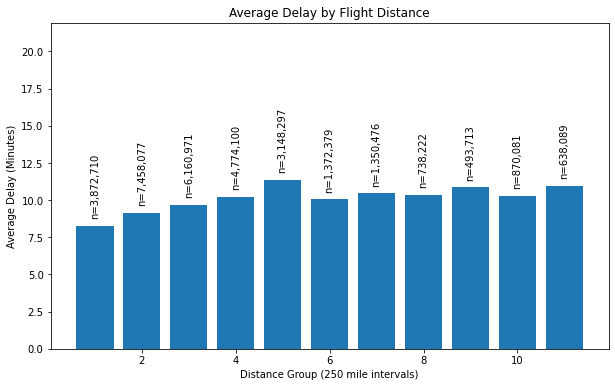

In [0]:
displayHTML("<img src = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmcAAAGDCAYAAABuj7cYAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAABXAklEQVR4nO3dd3xUVfrH8c9DERELIChItdGlo6xrwwJYcRGViIJtWV2s64pl17oW/FmwYENFWFapFtTFAohtV6RJUWAVESmCKF16yPP7497EIUySAZLcO8n3/XrNKzP33rnzzQQmT8459xxzd0REREQkHspEHUBEREREfqPiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiKQNM1toZqcWwXndzI4o7PPmeo3BZnZfeP94M/tfis87ycyWFGW28HXeNbNeRf06IlIwFWciMWZmH5nZajOrEHWWPWVmd5vZNjNbH96+MbMBZlYz6myFxcwuNbPtZvZrwm1A7uPc/VN3b1hIr5lT9OVzjJvZhjDPSjObYGYX5sp0ursPSeH1iryQFSntVJyJxJSZ1QeOBxw4pwjOX66wz5mCEe6+H1AV+ANQA5hWkgo04HN33zfhdk3UgUIt3H1foCEwGBhgZndFG0lEklFxJhJfPYFJBL9IewGYWQUzW2NmzbIPMrPqZrbJzA4KH59lZjPC4/5rZs0Tjl1oZreY2Sxgg5mVM7Nbzey7sDVrjpn9IeH4smb2qJn9Ymbfm9k1YctJuXD/AWb2kpktM7OlZnafmZUt6Btz923u/jVwIfAzcFPCa+aZP5GZHW1mn4fHLQtb4fYK9z1tZo/mOv4tM7sxn1hnmNmC8Ht92MzKmNleZrbKzI5KOM9BZrbRzKoX9H3mJXdXpZm1NrMvw5/BKDMbkbs1zMxuMrMV4fd6WbitN9AD6Bu2ir1d0Gu7+y/uPhS4GrjNzA4Mz/WRmV0Z3j/CzD42s7Xh+zEi3P5JeJqZ4etdaGZVzOwdM/s5bOV9x8xqJ+T+yMz+YWb/Cb+/D8ysWsL+48Kf8xozW2xml4bbK5jZI2a2yMx+MrPnzKzi7rzfIulGxZlIfPUEXglvnczsYHffArwOZCQcdwHwsbuvMLNWwCDgT8CBwPPAW7Zjt2gGcCZQ2d0zge8IWugOAO4B/pXQkvVH4HSgJdAaODdXxsFAJnAE0AroCFyZ6jfo7tuBMeHrk2L+bNuBG4FqwO+AU4A/h/uGABlmViY8bzXgVODVfOL8AWgbfp9dgMvdfSswHLg44bgMYIK7/5zq95mfsKB8g+C9rAoMC7MkqkHw86kFXAE8bWZV3H0gwb+P/wtb6c7ehZceA5QDjk6y7x/AB0AVoDbwFIC7nxDubxG+3giC3yMvA/WAusAmIHdX7kXAZcBBwF7AX8PvvR7wbnj+6gT/zmaEz+kHNAi3HRF+73fuwvcnkrZUnInEkJkdR/DLbqS7TyMooC4Kd78KdE84/CJ+Kzp6A8+7+xfuvj0cQ7QFaJ9w/JPuvtjdNwG4+yh3/9Hds8Jftt/y2y/sC4An3H2Ju68m+IWZnfFg4AzgBnff4O4rgP65sqXiR4KiJNX8hLmnufskd89094UEhdyJ4b7JwFqCgo0w00fu/lM+OR5y91Xuvgh4nN8K4OxCz8LHlwBD8zlP+7AVKPu2U/bcxxMUSU+GLYqvA5NzHbMNuDfcPxb4laB7cre5+zbgF35773O/Xj3gEHff7O6f5XOele7+mrtvdPf1wP2EP4cEL7v7N+G/uZEEBRcE/3bHu/uw8Htb6e4zwve6N3Bj+DNZDzzArv/bEklLKs5E4qkX8IG7/xI+fjXcBjAR2MfMjrFgXFpLgpYXCH6h3pRYHAB1gEMSzr048YXMrGdCN+IaoBlBaxTh8xbn8dx6QHlgWcJznydoHdkVtYBVu5A/O3eDsAttuZmtI/jlXS3hkCH81uJ1MfkXVLDj9/ZD9mu6+xfARuAkM2tE0IrzVj7nmeTulRNukwp43UOApe7ueWQBWBm2cmbbCOxbwHnzZWblCVqrViXZ3RcwYLKZfW1ml+dznn3M7Hkz+yH8OXwCVM7Vvb08j+x1CP7wyK06sA/BeMTsfwfvhdtFSrwoBgSLSD7CcTUXAGXNLPuXWgWCX3gt3H2mmY0kaNn5CXgnbFmA4Jf6/e5+fz4vkVMEhN1KLxC0MH3u7tvNbAbBL2aAZQTdWtnqJNxfTNCqVS1X4ZCysNvxbGD8LuTP9izwJZDh7uvN7AagW8L+fwFfmVkLoDHwZgHnqwN8Hd6vS9Cily270FsOjHb3zSnkS9UyoJaZWUKBllfRkowXfEhSXQi6pHO30uHuywm6tLNbcceb2SfuPj/JeW4iaMU7xt2Xm1lLgp+LJTk2t8Uk71b9haB7tKm7L03hPCIlilrOROLnXILxVE0IWsVaEhQXnxKMQ4OgJe1CgsHgieOoXgCuClvVzMwqmdmZZrZfHq9VieCX+88A4UDzZgn7RwLXm1ktM6sM3JK9w92XEYxLetTM9rdgAP3hZpa7S2snFlyI0JhgfFUN4LHdyL8fsA74NWzRujpxp7svAaYQtJi9lt2Nm4+bw8HtdYDrgREJ+/5FMA7sYuCfBX1/u+hzgp/3NeH70oXkBUtefgIOS/VgM6tqZj2Apwm6clcmOeb8hEH9qwn+jWTl8Xr7ERRSa8ysKrArV4C+ApxqZheE3/uBZtbS3bMI/i30t98udKllZp124dwiaUvFmUj89CIYo7PI3Zdn3wgGWfcws3JhV9sGgi6xd7Of6O5TCVo8BhD8Up0PXJrXC7n7HOBRggLhJ+Ao4D8Jh7xAUIDNImgNGUvQ2rI93N+TYID3nPD1RgP5TYtxoZn9SjAe7C1gJdDG3X/cjfx/JRiztD7MOSLJMUPC76mgLk0IBshPIxiQ/m/gpewd7r4YmE5QpHyawrlSFl500JVgoP8aggLwHYJWyVS8BDQJu//ezOe4meF7P5/goo0b3T2vAfbtgC/C498Crnf3BeG+u4Eh4etdQDA+ryJBa9ckgu7HlITj+84gaH1bRfDetwh33xJmnRR2l45nD8fZiaQL23GYg4hI3szsdOA5d68XdZZUmNkJBK1e9XwPP+zMbBDwo7v/vVDC5f9aXxC8zy8X9WuJSPyo5UxE8mRmFc3sjLDLqRZBl9UbBT0vDsIB79cDLxZCYVafoHXrpQIO3d3zn2hmNcL3uRfQnF1ogRKRkkXFmYjkxwjmPltN0K05lzSYayocz7aGoIv18T081z+Ar4CH3f37PQ6XXENgJkHmm4Bu4Zg+ESmF1K0pIiIiEiNqORMRERGJERVnIiIiIjFSoiahrVatmtevXz/qGCIiIiIFmjZt2i/uvtPKFyWqOKtfvz5Tp06NOoaIiIhIgczsh2Tb1a0pIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMREREJEZUnImIiIjEiIozERERkRhRcSYiIiISIyrORERERGJExZmIiIhIjKg4ExEREYkRFWciIiIiMaLiTERERCRGVJyJiIiIxEiRFWdmVsfMJprZHDP72syuD7dXNbNxZvZt+LVKHs/vFR7zrZn1KqqcIiIiInFSlC1nmcBN7t4EaA/0MbMmwK3ABHc/EpgQPt6BmVUF7gKOAY4G7sqriBMREREpSYqsOHP3Ze4+Pby/HpgL1AK6AEPCw4YA5yZ5eidgnLuvcvfVwDigc1FlFREREYmLYhlzZmb1gVbAF8DB7r4s3LUcODjJU2oBixMeLwm3JTt3bzObamZTf/7558ILLSIiIhKBIi/OzGxf4DXgBndfl7jP3R3wPTm/uw9097bu3rZ69ep7cioRERGRyBVpcWZm5QkKs1fc/fVw809mVjPcXxNYkeSpS4E6CY9rh9tERERESrSivFrTgJeAue7+WMKut4Dsqy97AWOSPP19oKOZVQkvBOgYbhMREREp0Yqy5ez3wCXAyWY2I7ydAfQDTjOzb4FTw8eYWVszexHA3VcB/wCmhLd7w20iIiIiJZoFw75KhrZt2/rUqVOjjiEiIiJSIDOb5u5tc2/XCgEiIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMREREJEZUnImIiIjEiIozERERkRhRcSYiIiISIyrORERERGJExZmIiIhIjKg4ExEREYkRFWciIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYKVdUJzazQcBZwAp3bxZuGwE0DA+pDKxx95ZJnrsQWA9sBzLdvW1R5RQRERGJkyIrzoDBwADgn9kb3P3C7Ptm9iiwNp/nd3D3X4osnYiIiEgMFVlx5u6fmFn9ZPvMzIALgJOL6vVFRERE0lFUY86OB35y92/z2O/AB2Y2zcx6F2MuERERkUgVZbdmfjKAYfnsP87dl5rZQcA4M5vn7p8kOzAs3noD1K1bt/CTioiIiBSjYm85M7NyQFdgRF7HuPvS8OsK4A3g6HyOHejubd29bfXq1Qs7roiIiEixiqJb81RgnrsvSbbTzCqZ2X7Z94GOwFfFmE9EREQkMkVWnJnZMOBzoKGZLTGzK8Jd3cnVpWlmh5jZ2PDhwcBnZjYTmAz8293fK6qcIiIiInFSlFdrZuSx/dIk234EzgjvLwBaFFUuERERkTjTCgEiIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyJSqN566y02b94cdQwRkbSl4kxECtWFF15I7dq1ueSSSxg7dizbt2+POpKISFpRcSYihapRo0Z8++23nHDCCTz66KMccsghXHXVVXz88cdRRxMRSQsqzkSkUJkZVapU4Y9//CMTJkxg5syZNGnShFtvvZU6depEHU9EJPZUnIlIoXL3HR7XqFGD6667js8//5zPPvssolQiIulDxZmIFKr+/fvnua9evXrFmEREJD2pOBORQnXSSSfl3F+9ejXr1q2LLoyISBpScSYiherHH3+kZ8+eHHDAAVSrVo1mzZpRt25d7r77brZt2xZ1PBGR2FNxJiKF6uKLL+byyy9n7dq1jBo1ivPOO4+5c+eSmZlJnz59oo4nIhJ7lnvwbjpr27atT506NeoYIqVaixYtmDlzZs7jNm3aMG3aNCCYZmPevHlRRRMRiRUzm+bubXNvV8uZiBSq6tWr869//YulS5fy1FNPUb9+fSC4ijMrKyvacCIiaUDFmYgUqkGDBvHWW2/RqVMnvvjiCwYMGADAqlWrePDBByNOJyISf0XWrWlmg4CzgBXu3izcdjfwR+Dn8LDb3X1skud2Bp4AygIvunu/VF5T3ZoiIiKSLqLo1hwMdE6yvb+7twxvyQqzssDTwOlAEyDDzJoUYU4RKWTvv/8+L730Ej/88MMO2wcNGhRRIhGR9FFkxZm7fwKs2o2nHg3Md/cF7r4VGA50KdRwIlJkbr/9du6//35mz57NySefzFNPPZWzL7uLUwrfokWL2Lx5MxCM73v55Ze59tprefbZZ8nMzIw4nYjsiijGnF1jZrPMbJCZVUmyvxawOOHxknCbiKSBt99+mw8//JDHH3+cadOm8e6773LjjTcCOy/tJIXnjDPOyLng4tZbb+Xf//43xxxzDFOmTKF3794RpxORXVGuoAPM7CDg98AhwCbgK2Cqu+/OZVfPAv8APPz6KHD5bpwnMV9voDdA3bp19+RUIlIIMjMzKVcu+GipXLkyb7/9Nr179+b8889n69atEacrubKysthnn30AGD9+PFOmTKFMmTJcfPHFtGjRIuJ0IoUrKyuLwYMH89prr7FkyRLKli1LgwYNuOqqq3ZYpSRd5dlyZmYdzOx94N8E479qEowB+zsw28zuMbP9d+XF3P0nd98eFnYvEHRh5rYUqJPwuHa4La9zDnT3tu7etnr16rsSRyT21q5dy4gRI3jsscd47LHHGDFiBGvWrIk6Vr4OP/xwPv7445zHZcuW5aWXXqJhw4bMnTs3wmQlW506dfjwww8BqF+/PosXBx0QK1eujDKWSJG44oorWLRoEbfddhsdOnTgrLPO4oorruC+++7bYShFusrzak0zexh4yt0XJdlXjuBKzLLu/lqeJzerD7yTcLVmTXdfFt6/ETjG3bsnOfc3wCkERdkU4CJ3/7qgb0ZXa0pJ8s9//pN77rmHjh07UqtW0LO/ZMkSxo0bx1133UXPnj0jTpjcpk2bAKhYseJO+5YuXZrzvUjhWrx4MT179mT79u0ccMABfPbZZ7Rs2ZI1a9bwyCOPcMopp0QdsUSaN28eN954I2XKlOHJJ5/kH//4B2+++SYNGjRgyJAhNG7cOOqIJVLz5s2ZNWtWzuP27dszadIktmzZQsuWLdPmD8G8rtbMs1vT3W/OZ18m8GYBLzgMOAmoZmZLgLuAk8ysJUG35kLgT+GxhxBMmXGGu2ea2TXA+wRTaQxKpTATKWnuv/9+pk2bRuXKlXfYvnr1ao455pjYFmfJijKAZcuWUa1atWJOU3rUqVOHiRMnMnfuXL755hsuvfRSateuTbt27ShTRlNaFpXevXtz88038+uvv3LyySfz0EMP8fLLL/POO+9wzTXXMGHChKgjlkjly5fnu+++4/DDD2f69OnstddeAFSoUAEzizjdnktlzNn1wMvAeuBFoBVwq7t/kN/z3D0jyeaX8jj2R+CMhMdjgZ2m2RApTdw96YdMmTJl0nJg/SWXXMJ3333HeeedxyOPPBJ1nDwtWLCA119/ncWLF+eMY7nooovYf/9dGsURmcaNG6u1phitX7+es88+G4A77riD7t2DzqCzzz6bu+66K8poJdrDDz9Mhw4dqFChApmZmQwfPhyAn3/+mbPOOividHuuwOIMuNzdnzCzTkAV4BJgKJBvcSYie+Zvf/sbrVu3pmPHjtSpEwzDXLRoEePGjeOOO+6ION2uGz9+PO7OnDlzoo6SpyeffJJ33nmHE044gSlTptCqVSsWL15M+/bteeaZZ2I90Lhq1ap07dqVjIwMTj755BLRepAOtm/fnnP/L3/5yw77dAFM0Tn55JP54YcfWLly5Q4t8tWrV+f//u//IkxWOApcIcDMZrl7czN7AvjI3d8wsy/dvVXxREydxpxJSbN69Wref/99li4NrompVasWnTp1okqVZLPQxMeiRYvYf//9qVy5MgsXLmTq1Kk0atSIZs2aRR0tX0cddRQzZsygbNmybNy4kTPOOIOPPvqIRYsW0aVLF7788suoI+apYcOGXHvttQwbNoyFCxfSrVs3MjIyaN++fdTRSrTnn3+eHj16sO++++6wff78+QwYMIDHH388mmAl3NatWxk+fDiHHHIIp556Kq+++ir//e9/ady4Mb1796Z8+fJRR0xJXmPOUinOXiaYZ+xQoAXBOLCP3L1NUQTdEyrOpCT66aefdijODj744IgT5a9fv348//zzVKhQgb/+9a888sgj/P73v2fSpElcccUVO7UuxMlRRx3F1KlTqVChAqtXr+a0004j+zOlWbNmfPXVVxEnzFvr1q2ZPn06EBTHw4cPZ/jw4axZs4bu3bvzwAMPRJxQpPD06NGDzMxMNm7cSOXKlfn111/p2rUrEyZMwN0ZMmRI1BFTsssXBCS4AmgJLHD3jWZ2IHBZIecTkVxmzJjBVVddxdq1a6lduzbuzpIlS6hcuTLPPPMMrVu3jjpiUkOHDmXOnDls3LiR+vXrs2DBAqpXr86GDRs45phjYl2cXXnllbRr145jjjmGTz/9lFtuuQUIxrFUrVo14nT5S/xDu27duvTt25e+ffsyb948RowYEWGy0uvee+/lzjvvjDpGiTR79mxmzZpFZmYmtWrV4scff6Rs2bIlZl6/VC7hcYL5za4LH1cC9i6yRCLF5N577406Qr4uvfRSnnjiCebOncu4ceMYP3488+bN4/HHH+eyy+L791HZsmWpWLEilStXpmLFihx44IEAVKpUKeJkBbv++usZNmwYnTp14s0338x5n6tXr84nn3wScbr8dejQIen2Ro0axX5g+uLFi+nevTvHH388DzzwANu2bcvZd+6550YXbA+9+OKLUUcosbKysti6dSvr169n48aNrF27FoAtW7bs8O8nXaXSrfkskAWc7O6NwyWXPnD3dsURcFeoW1N2Rd26dVm0aKdp/GLjyCOP5Ntvv02674gjjmD+/PnFnCg1l156KVu3bmXDhg3ss88+lCtXjs6dO/Phhx+yfv16Ro4cGXXEPK1Zs2anqUuk6J122mmcd955tG/fnpdeeolp06bx9ttvc+CBB9KqVatYj/XL6yped2fTpk1pu65p7969GThwYNQx8tS/f3+eeuoptm/fzk033cSYMWM47LDDmDRpEt26dYv9HyTZ9mTM2XR3b514EYCZzXT32LUbqjiT3NL5g/O6667ju+++o2fPnjlXay5evJh//vOfHHroobFdRDwzM5NRo0ZhZnTr1o3Jkyfz6quvUrduXfr06RPrFrRy5cpx0kknkZGRwXnnnZf2hVqDBg345ptvoo5RoJYtWzJjxoycx//617948MEHeeuttzj//PNzxtLFUd26dZkyZUrSsaB16tTJWakhjlatWpV0u7vTokULlixZUsyJds2PP/4IwCGHHMKaNWsYP348devW5eijky0+FE97MuZsm5mVJejexMyqE7SkicRe5cqV8/3gjLMnn3ySd999lzFjxuxwQUCfPn0444wzCnh2dMqVK0dGxm/THB577LHsvffesR0jl6hx48bccMMNDBs2jL59+3LccceRkZFBly5d8pxcNy7222+/nOkzsv/o3rhxY872devWRRkvX9u2bWPz5s3svXcwYubiiy+mRo0adOrUiQ0bNkScLn89e/bkhx9+SPoZc9FFF0WQKHXVq1enXr16O4xXNDPcnRUrVkSYLDU1a9Zk8uTJTJo0CQg+09u1i12n3m5JpeWsB3Ah0BoYAnQD7nD32PVNqOVMcvv73//OOeeck/QvqVtuuYWHHnooglQlW7JWjnPOOYe3334bd491kZZ4xeOmTZt4++23GT58OB9//DGdOnXi1VdfjThh3q677jrWrFnDww8/nFMoHHrooXz//fcRJytY//79ad26NSeeeOIO27/88kv69u3LuHHjIkpWsh155JFMmDCBunXr7rQv7q1+H3zwAX/+85858sgjd1jebv78+TzzzDN07Ngx4oSp2e1uzfDJjQjWujRggrvHctEqFWdSWsR5PEiZMmVo3749FSpUyNk2adIk2rdvj5nlLM4dR3mNb1q7di1vvvkmvXr1iiBV6qZNm8bNN9/MueeeyzXXXMMRRxzBggULoo5Vos2aNYvmzZtHHWO3PP300xx33HFJr2586qmnuPbaayNIlZrGjRvz7rvvUr9+/R22f//995xxxhlpv7ZmgVdrmtlQd5/n7k+7+wB3n2tmQ4smpkjhSlwYN92sWrUq6W3lypWMHRvf1c1GjRpF+fLl6du3LxMnTmTixInUqFGDiRMnxrowg2DupGQOOOCA2BdmAG3atGH8+PEAnHjiiWzevDniRKl7//33eemll1i4cOEO2wcNGhRNoBS1atWKI488kjvuuCPWq18k06dPnzynnYhzYQbB2NbatWvvtL1WrVql5mrN6e7eOuFxWWC2uzcp6nC7Si1nklvZsmU57LDD6N69OxkZGTRpErt/tnkqW7ZsnuNBli5dGuulYX799VfuuOMOlixZwqOPPspJJ52kFpxitmzZMr788stYj0/Mdtttt/Gf//yH1q1b8/bbb3PDDTfkFAeJXc1x1KpVK4YOHcqwYcMYMWIElSpVIiMjg+7du+/UqhM36TzL/oMPPsjIkSPp3r37DhdMDR8+nAsuuIDbbrst4oSp2eVuTTO7DbgdqAhsJOjSBNgKDHT32H3nKs6KxltvvUXHjh1zBuumk3T+4Ezn8SDZvvzyS/7yl7/w9ddfp8UA4+XLl3PPPfdQpkwZ7r33Xp566ilee+01GjduzBNPPEHNmjWjjrjLpk6dyiGHHMIhhxwSdZQ8HXXUUXz55ZeUK1eONWvWcNFFF9GwYUP69+8f+6k0chePkydPZvjw4YwcOZK6devy3//+N8J0+Uv3Wfbnzp270wVT55xzTlr9Eb4nU2k8GMdCLBkVZ0WjYsWKVKpUidNPP52MjAw6depE2bJlo46VknT+4Ezn8SCJ3J3169fnOa1JnHTu3JkzzzyTDRs28Oqrr9KjRw8uuugi3nzzTcaPH8+YMWOijrjLevXqxaxZs2jQoEFsVwpo3LjxDmOEtm/fTu/evVm3bh1z5szh66+/jjBd/vIqHt2dTz75ZKeLHOKkefPmSWfZz55KI52HhaSLvIoz3D3fG3BCsltBz4vi1qZNG5fC17JlS1+1apUPHDjQTz75ZD/ooIP8T3/6k3/00UdRRytQy5Ytk27PyspKi/wlzT333BN1hHwl/nupU6fODvtatGhRzGkK17p166KOkKczzzwz6f/Hv/3tb25mESRK3SuvvBJ1hN3WtGlT37Jli69atcr33XdfX7lypbu7b9q0yRs1ahRxut3Ts2dPv+qqq3z27NlRR0kJMNWT1DOptJy9nfBwb+BoYJq7n1woZWMhUstZ0cjd+rR8+XJGjhzJsGHDWLJkSay711599dXYzzW0q9KhmyovcV+VoUWLFsycORMIpmG57777cvZltzLE2dq1a3nvvfd26Obp1KlT7CfT3bRpE0DSueSWLl2aM1WCFK6SMst+oilTprBo0SImT56cFlMl7dFUGrlOVAd43N3PK6xwhUXFWdHIb8zHDz/8QL169Yo5UekW926qdF6V4c4776Rv377su+++O2yfP38+t956K6NHj44oWcH++c9/cs8999CxY8cd5n0aN24cd911Fz179ow4YcG2bdu20yD0X375hWrVqkWUaPf16tWLffbZhz59+tCsWbOo4+SpJMyyn852u1sz943gwoA5u/q84ripW7NoTJw4MeoIu239+vV+xx13eJMmTXz//ff3atWq+THHHOMvv/xy1NH2WFy7qerUqePLly9Puq927drFnKb0aNCgga9evXqn7atWrfIjjzyy+APtgg8//NBr1arlBx54oJ922mn+/fff5+xr1apVdMH2wOTJk3306NHet2/fqKPkKysryydNmuSvvfaav/baaz5p0iTPysqKOlaBpkyZ4ieddJL36NHDFy1a5Keeeqrvv//+3rZtW//yyy+jjpcy8ujWLHD5JjN7inDpJoJ50VoC8b2uWQrdSSedFHWE3dajRw/+8Ic/8P777zNy5Eg2bNhA9+7due+++/jmm2944IEHoo64S26//faczPvtt1/EaZJL5+Vs8jJmzBhq1KjBMcccE3WUPLl7zvJNicqUKbPDdCxx1LdvX95//32aNm3K6NGjOe200xg6dCjt27ePffa8tGvXjnbt2nHeebHrZMqRzrPs//nPf+aee+5hzZo1HHvssfTv359x48YxYcIErr76aj7//POoI+6RVMacJc68mAksdPf/FGmq3aRuzaJRtWpVunbtSkZGBieffHLSXwBxlTiGCIIPzClTppCVlUWTJk2YN29ehOnyd9111+3w2N0ZOnRoTvfUk08+GUWsUun2229n9uzZZGZm8u6770YdJ6khQ4Zw77330rFjx5x5nxYtWsS4ceO44447uPTSS6MNmI/c/0+//vprunbtykMPPcS9994b63nO0nn6lXSeZT9xuE3usaxxn34l0W6vEODuQxJur8S1MJOiU716dVq2bMmdd95J7dq1uf7663MWmo27SpUq8dlnnwHBfG1Vq1YF0qM14Y033mDVqlW0bduWNm3a0LZtW8qXL0+bNm1o06ZN1PF22bJly9iyZUvUMXbLAw88wNtvvx3bwgyCMU5Tp07lxBNPpEKFClSoUIGTTjqJqVOnxrowAyhfvjzLly/Pedy0aVMmTJjA3XffzbfffhthsoJdeumlNGnShDp16tChQwcqVqzI2LFjOf7447nqqquijpevdJ5lf++99+aDDz5g1KhRmBlvvvkmAB9//HHaTPWUr2R9nYk34PfAOOAbYAHwPbCgoOdFcdOYs6KROObjhx9+8IceeshbtWrlhx56qN92220RJivYzJkzvV27dl65cmX//e9/7//73//c3X3FihX+xBNPRJwuf+vWrfPrr7/eMzIyfOnSpe7ufuihh0acavedcsopXr9+fb/pppuijpKvtWvX+vz583faPnPmzAjSlA7jxo3zGTNm7LR99erVft9990WQKHXpPP3KAw884C1btvR+/fr5K6+84q+88or369fPW7Zs6Q888EDU8fI1Y8YM79ixo3fu3Nnnzp3r1113nR9wwAHepEkT/89//hN1vJSxB1NpzANuBKYB2xOKupVFUy7uPnVrFo28mojnzZvHiBEj0vJy63Qybdo0/vrXv3LmmWcyYMCAndYeTCfuzpw5c2jatGnUUZIaOXIkN9xwAwcddBDbtm1j8ODBtGvXDoj/MkKDBg3i8ssvB4LpJ3r27Mn06dNp3LgxgwcPpkGDBhEnLJnSffqVkjDLfjrbk0lovyjomLjc1HJWNG688caoIxS6N9980ydNmhR1jJRlZWX5gAEDvEePHlFHScn27dt9+/bt7u6+ZcsWnzZtWs4El3HWokUL//HHH93d/YsvvvCGDRv666+/7u55T2gcF4kt3Oeff74///zzvn37dn/99df95JNPjjDZ7kuHCUXvuOMOX79+/U7bv/32Wz/vvPMiSFQ6ZGVl+YgRI3zkyJGelZXl48eP92uvvdafeeaZnM+edMAetJz1A8oCrwM5A0bcPXZ/QqrlTFKVDgO809Wbb77Jn/70J8qUKcNzzz3HAw88wL777sv//vc/nn32Wc4+++yoI+bpqKOOYvbs2TmPly1bxllnnUWvXr0YPHhwrFvOElv2WrZsyYwZM3L2pdMA6UTpNqFoSZEOc7T9+c9/ZsWKFWzdupX999+fLVu2cM455/Dvf/+bgw8+mCeeeCLqiCnZk7U1JybZ7K4VAnbZvHnzkjYfN27cOOJk+cvMzOSll17ijTfeyJmwsFatWnTp0oUrrrhip0kjpXCk61WyrVq14t1332XTpk20aNGCKVOm0LBhQ3744QfOO+884vx/9Nhjj2Xo0KEcfvjhOdvWr1/Pueeey2effRbrCxoOOuggunfvjrvz+uuvs3Dhwpz/m82aNeOrr76KOGHJtWDBAl5//XUWL15M2bJladCgARdddFFarCebTDoUxdl/SG3bto0aNWqwbNky9tprLzIzM2ndunXsu5Oz5VWcFTjPmbt3KJpIpctDDz3EsGHD6N69e87My0uWLCEjI4Pu3btz6623Rpwwb5dccgmVK1fm7rvvzrmyZ8mSJQwZMoSLL744lrPUJ0rXojjxKtmePXvSrVs3MjIyaN++fdTRClSjRg0guMS9YcOGANSrV4+srKwoYxXo2Wef3Snjfvvtx3vvvcfIkSMjSpWahx9+OOd+27Zt+fXXX6lSpQrLly/nnHPOiTBZwaZOncrNN99MrVq1ePDBB7n88suZPHkyDRo04IUXXqBly5ZRR8zTE088wb///W9OOOEEpkyZQqtWrVi8eDHt27fnmWeeSct5ItNhjrZy5YLypXz58rRr14699torZ3uZMgVORBF/yfo6w9a0i8Ovf0l2y+t5Ud7iPObsyCOP9K1bt+60fcuWLX7EEUdEkCh1+c0uHveZx/v16+ctWrTwBx980IcOHepDhw71Bx98MGdbnKXrVbItW7bMGfPxxRdf5GzPzMz0pk2bRhVLYqxdu3Y+duxYf/XVV7127do+atQod3cfP368t2/fPuJ0+WvWrJlnZma6u/uGDRv8xBNPdPfg/2zcxymuWbPGb7nlFm/YsKFXqVLFq1at6o0aNfJbbrkl6WoTcdK5c+ekY/2WLVvm7dq1iyDR7iGPMWf5lZeVwq/75XGTXVCmTJmcLsFEy5Yti32VX7VqVUaNGrVDi0JWVhYjRoygSpUqESYr2EsvvcSUKVO49dZbufjii7n44ou59dZbmTx5Mi+99FLU8fLlCUMO6tatS9++fZk+fTpjx46lQoUKESbL38CBA9m6dSvADuvzLV68ONYtxBD8W7/yyiuZMGHCDu9/Oti4cSP/93//x8MPP8zmzZsZPHgw55xzDn379uXXX3+NOl6+tm3bxumnn05GRgZmRrdu3QA45ZRT2Lx5c8TpCpa9XuyWLVty3uu6devGfq6wCy64gCpVqvDRRx+xatUqVq5cycSJE6lSpQoXXHBB1PHy9e677+60Bi4ELd3vvPNOBIkKV57dmu7+fPj1nt05sZkNAs4CVrh7s3Dbw8DZwFbgO+Ayd1+T5LkLgfUEU3dkerLLTNPM448/zimnnMKRRx65w+zd8+fPZ8CAARGny9/w4cO55ZZb+POf/5xTjK1Zs4YOHTowfPjwiNPlL7sozr04ezoUxR06JB9R0KhRo1hPX5I99URu9evX32km8rhJ567kSy+9lDp16rBp0ybOPPNMGjduzM0338xbb73F1VdfzdChQ6OOmKfsCUXXrl2bM6HoueeemxYTil555ZW0a9eOY445hk8//ZRbbrkFgJ9//jln0uu4WrhwYU7ebDVq1OCWW25h0KBBEaVKzdatWylfvnzOWNyJEycyffp0mjRpwumnnx5xuj2X5wUBZpbv2jDufl1++83sBOBX4J8JxVlH4EN3zzSzh8Lz3JLkuQuBtu7+SyrfRLa4XxCQlZXF5MmTdxj71K5du9h/+CRauTKY3u7AAw+MOElq3nvvPa655po8i+LOnTtHnLBku+GGG3j88cdzvsZd4hWPixYtYvjw4QwfPpw1a9bQvXv3WK/Fmn2FprtTs2ZNli1bhpnh7rRo0SLWA6RnzpxJ3759KVOmDP379+fZZ59lyJAh1KpVixdeeIFjjz026oj5+vrrr5k7dy7NmjWjUaNGUcdJWceOHTn11FPp1atXzlq4P/30E4MHD2bcuHGMHz8+4oR5a9GiBR999BFVqlTh4Ycf5o033uCMM87g448/pm3btjz44INRR0zJLs9zRtC6NR24FegJ9Eq85fW8XOeoD3yVx74/AK/ksW8hUC2V10i8xXnMWX6S9ZungylTpuTMXB9n27dv988//9xHjx7to0eP9s8//zxnjEic3Xjjjf7ZZ59FHWOPZI+bi/vYm2x55Zw7d67ffffdxZxm1yTORn/ZZZftsK958+bFnKZ0e/rpp6OOkJJVq1Z53759c8acValSxRs1auR9+/aN/byEieNX27Rp4xs3bnR3923btvlRRx0VVaxdRh5jzvK7WrMmcD5wIcGC5yOA0Z6kG3I3XR6eMxkHPjAzB55394F5ncTMegO9IejjT0dNmjTZYdHWdPHUU08xa9YsGjRoEOsrNsuUKZPTLTV//nxmzpzJ/vvvH/sZsIcOHconn3zCzz//zIUXXkhGRgatWrWKOlaJlq5dyfDbFZr77rvvDl1S3333HfvtF+9hwu6es0Zit27d+PDDDxkzZgyNGzfOmTMvrh577LEdHrs7Dz74YM5Yub/85S9RxEpJlSpVeOihh2I7XUZ+9t9/f7766iuaNWtGtWrV2Lx5MxUrViQzMzP2V4WnIr8xZyuB54DnzKw20B2YY2a3uPseDV4ws78RFHyv5HHIce6+1MwOAsaZ2Tx3/ySPnAOBgRB0a+5JrqKU+z9wNneP/WDdvAwZMgQI5oGKqw4dOjBq1CiqVavG0KFD+cc//sEJJ5zA3XffTe/evbn22mujjpin2rVrM3XqVL755htGjBjBxRdfzPbt28nIyCAjI0PL8RSBvP6fpoMXX3wx6fbDDz+cTz/9tJjT7Jo+ffrkTCg6ZsyYHSYUnTdvXqwnFL3rrrs444wzaNq0ac5FJNu3b4/152K2J598kq5duyZd/DzunnvuOXr06EGLFi046KCDaNu2LSeccAKzZ8/m9ttvjzreHktlEtrWQAZwGsH6mo+6+5yUTm5WH3jHwzFn4bZLgT8Bp7j7xhTOcTfwq7s/UtCxcR5ztvfee3PzzTfnzM2SqH///qxZs6b4Q+2CTz75hIMPPpiGDRvyn//8h88//5zGjRtz5plnRh0tX4mTb7Zr14733nuPAw88kI0bN9K+fftYj8NJtpbjrFmzGDZsGKNGjWL+/PkRJUtd9veQLjPUb9y4kQEDBmBmXHvttQwfPpzXX3+dRo0aceeddya9Oizupk6dyiGHHMIhhxwSdZQ8pfOEoosWLeKmm27isMMO46677mKfffbhsMMOY8GCBVFHK9ABBxxApUqVOPzww8nIyOD888+nevXqUcdK2fbt2/nggw/45ptvyMzMpHbt2nTq1InKlStHHS1luzwJrZndC5wJzAWGA7e5e+YehugM9AVOzKswM7NKQBl3Xx/e7wjcuyevGwetW7fm3HPPpU2bNjvty+sv3ri44YYbmDx5MpmZmXTq1IkJEyZw+umn079/fyZOnMgjjxRYN0emfPnyLF26lFq1arHvvvtSqVIwQ0yFChXYvn17xOnyl+wPp+bNm9O8efO0Gexa0B9/cZPOVzzmJR2GH6TzhKJ169Zl1KhRjBkzhtNOO40bb7wx6kgpO+yww5g2bRrjx49nxIgR3HXXXbRp04aMjAy6du0a++7wsmXLcvrpp5eIqzN3kmwgWviBmkUw3cXs8DYrvM0GZuX1vITnDwOWAduAJcAVwHxgMTAjvD0XHnsIMDa8fxgwM7x9DfytoNfKvsX5goB58+b5ihUrku5bvnx5MafZNU2aNPGsrCzfsGGDV65c2Tds2ODu7lu3bo39pKITJ070Jk2a+B133OF9+vTx3/3ud3733Xf7qaee6g8//HDU8fKVrheKJMp+j+P+XmfLHlSflZXlBx98sGdlZeU8TqdBxsmsW7cu6gh5KikTiv7666/+17/+1Y8//vioo6QkcaJr9+AzfcyYMd69e3evVq1aRKl23fXXX7/D13TCri58bmb1ku74raj7YbeqwSIU527NdJbdNbh582Zq1qzJjz/+SMWKFdm+fTtHHXUUc+ak1MsdmbVr1/Lqq6/u0PTdpUuXtLrkPdGyZcuoWrVqrCeihWBCztGjR/PDDz/kTNIJcOedd0aYKn+JC4ZffvnlOwysb9GiBTNnzowo2Z6ZN29eWv5737BhAxs2bOCggw6KOkqJlN9wg40bN7LPPvsUc6Ldk27DJxLtztqaizyvyu23k1pBx0iga9eudO3alXPPPTftxq2ceeaZHH/88WzevJkrr7ySCy64gPbt2/Pxxx9zwgknRB2vQAcccABXX3111DEKzSWXXMJ3333HeeedF+su5S5dulC5cmVat24d+0IyWzpf8Zifjh07xvqK8FmzZtG8efOdtleqVClnKEI6SLd5/fLr5k6Xwqykyq/l7CPgNWCMuy9K2L4XcBzBfGcT3X1w0cdMTZxbzmrVqsXvfvc7PvzwQ0499VQyMjI488wzc8ZWxN3nn3+OmdG+fXu+++473njjDerWrUu3bt1iPyYkL71792bgwDxnaYk1d2fOnDk0bdo06ih5SrwYoyRw95zZyOPouuuSzwvu7gwZMoR169YVc6LUlS1blsMOO4zu3buTkZER+2lu8pKOLTiLFi1i//33p3LlyixcuJCpU6fSqFEjmjVrVvCTYyId3/dsebWc5fdbtTPB8knDzOxHM5tjZguAbwmu3nw8ToVZ3B100EGMHj2ahQsXcvbZZ/PCCy9Qq1YtLrvsMj744IOo4xXod7/7Xc5cYYcffjh//etfueCCC2JfmK1atSrpbeXKlYwdOzbqeLvsmWeeAcDMYl2YARx77LHMnj076hiFYurUqSxbtizqGPl6+eWXadasGW3atNnh1rZt29j/Edi8eXPeeOMNsrKyOOecc2jRogX9+vVj4cKFUUcr0fr168eJJ55I+/btefHFF+ncuTPvvvsuF154YVpPK1MS5DfP2WbgGeAZMysPVAM2eeFNQluqZP/Fvf/++3PJJZdwySWXsHLlSkaNGkW/fv3o2LFjxAnzNmjQIC6//HIAlixZQq9evZg+fTqNGzdm8ODBsZ5vq3r16tSrV2+Hqwazl7RZsWJFhMkKls6TWwJ89tlnDB48mEMPPZQKFSrktDzFeVqEvKTDFY/t2rWjWbNmSZc6uvvuu4s/0C4wM5o1a8b999/P/fffz+TJkxk+fDjHHXccdevW5b///W/UEUukoUOHMmfOHDZu3Ej9+vVZsGAB1atXZ8OGDRxzzDGx/4zJVhJHV+U35iyHu28juPJSdlOycWYHHnggV111FVdddVUEiVI3YMCAnOLsL3/5CxdeeCHjxo1jzJgxXH311UyYMCHihHk77LDDmDBhQtLVI7LX2oyrdJ7cEuDdd9+NOkKhSYcJl0ePHs3ee++ddN/3339fzGl2Te5frkcffTRHH300jz76KJ98knT+cSkEZcuWpWLFiuy1115UrFgxZ83kdBrnB9CjR48dvpYEBU5Cm07iPOYsnSVOhpp4NRvkf7VPHDz99NMcd9xxtGjRYqd9Tz31VKxXCEjnyS1LonS94jEdvPrqq1x00UVRx9hj2Z+Hcf9czHbppZeydetWNmzYwD777EO5cuXo3LkzH374IevXr2fkyJFRRyxQOl4Vnmh3xpxJMZg6dSo//vhj1DHytWTJEq677jquvfZafv75Z7Zt25azL/F+HPXp0ydpYQbEujCD3ya3PPbYYznttNMYPXp01JFKtTgPPcjthhtu2OFr3JWEwgzSrwXnxRdf5OyzzyYjI4OhQ4dy9dVX8/nnn9OwYUNefvnlqOOlpEuXLrz99tuUK1cu5+redGv5S6bAbk0zuxb4l7uvLoY8pU46jGV5+OGHc+5nTzVQpUoVli9fzjnnnBNhst2XDkvaZOvSpQunnnoqd999d1qugZdO8rviMe5LrCXK7gr8+OOPI06y69JtOopsW7ZsoWbNmjzwwANkZmZy773BwjZxbsEpV64cGRkZOY+PPfbYpGMW42zJkiW89957UccodKmMOTsYmGJm04FBwPua26zwpMNYll69eiXdXqNGDR544IFiTlM40qEoTlSpUqUdimQpGi+//DKPPvpo0nnZhg0bFkGi0iddC8t0nNcvUboWxdlXhR911FFRRylUBRZn7v53M7uDYI3Ly4ABZjYSeMndvyvqgCXNtm3bKF++/A7bfvnlF6pVqxZRot3ToEEDvvnmm6hj7LZ0KIoTpesHZ7pJ5yseJVrp3oKTrkVxSboqPFGqV2u6mS0HlgOZQBVgtJmNc/e+RRmwpJg4cSKXXHIJmzdvpnXr1gwcOJD69esDwViW7AH3cbTffvvlTD+RbePGjTnb4zy55datWylfvnzOVCYTJ05k+vTpNGnShNNPPz1tZn1P1w/OdJPOVzxKtEpqC07claSrwhOlMubseqAn8AvwInCzu28zszIEE9KqOEtB3759ef/992natCmjR4/mtNNOY+jQobRv3z72c7RcdtllrFmzhocffpiDDz4YgEMPPTQtflm1a9eOjz76iCpVqvDwww/zxhtvcMYZZ/DYY4/x8ccf069fv6gjxlr9W/8ddYSdLOx3ZpGdu2rVqkV27uIU98+UkqiktuDEXb16+S4DnrZSaTmrCnTNvdC5u2eZ2VlFE6vk2bp1a86M7t26daNx48Z07dqVhx56KNZLwgA8+eSTTJs2jYyMDM4991yuueaa2GfOtn37dqpUqQIE68h9+umnVKxYkVtvvZXWrVurOJM8pXNXcrpdNZgoXQvLktqCI9FIZczZXQBmdhCwd8L2Re4+twizlSjly5dn+fLl1KhRA4CmTZsyYcIEzjrrLL77Lv5D99q0acP48eMZMGAAJ554Ys4s9XG3//7789VXX9GsWTOqVavG5s2bqVixIpmZmWRlZUUdT2IsXbuS0/GqwUTpWlimewtOuhbFJVUq3ZpnA48BhwArgHrAXCDeC/vFTL9+/fjpp59yijOA2rVr8/HHHzNgwIAIk6WuTJkyXHfddZx//vlpMcEiwHPPPUePHj1o0aIFBx10EG3btuWEE05g9uzZ3H777VHHS5k+OCVV6XzVYLoXluksXYvikiqVbs37gPbAeHdvZWYdgIuLNlbJc+qppybdfsABB/C3v/2tmNPsmZo1a1KzZs20mCusefPmTJ8+nQ8++IBvvvmGFi1aULt2bfr370/lypWjjpcyfXBKqtL5qsF0LizTmYri+EmlONvm7ivNrIyZlXH3iWb2eFEHK2lat25N165dycjI4PDDD486TqFIl7nCypYty+mnn87pp58edZTdog9O2RXpfNVgOheW6UxFcfykUpytMbN9gU+AV8xsBbChaGOVPKtXr2bNmjV06NCBGjVqkJGRwYUXXhjrVqeCaK6w4qEPzmika1dyOl81mM6FZTqLuigubVeFpyKV4qwLsBm4EegBHADcW5ShSqIqVarwyCOP8Mgjj/Dpp58ybNgwWrduTePGjcnIyKB3795RR8zTrFmzaN68eZ77NVdY0Yr6g7O0Steu5HS+ajDqwrK0FgkqiuMnlas1E1vJhhRhllLj+OOP5/jjj+epp55i3LhxjBgxItbFWatWrTjssMPo3r07GRkZNGnSJOpIpYo+OItfOnclp/NVg+lcWKazqIti2VmexZmZrQcS2/UtfGwEiwbsX8TZSpQGDRrstK1s2bJ07tyZzp07R5Aodc2bN2fo0KEMGzaMc845h0qVKpGRkUH37t1zVjmQoqMPzuKnruRopHNhmc5UFMdPnsWZu6dHX1WaGD58eNQRdpuZ0axZM+6//37uv/9+Jk+ezPDhwznuuOOoW7cu//3vf6OOWKLpg7P4qStZShMVxfGT0tqaZnYccKS7v2xm1YD93D3+a/fEyKpVqxgwYACHHHIIV1xxBQ888ACff/45jRs35vbbb8+ZxT6Ocg+MPvroozn66KN59NFHc8ZxpYN0HeCtD87ip65kEYlSmYIOMLO7gFuA28JNewH/KspQJdHFF1/Mhg0bmDZtGh06dGD58uXccsstVKxYkUsvvTTqePm6+eabk243M0488cRiTrP70nWAtxS/zz77jDZt2tCwYUOaN2/OUUcdle9FMSIihSmVlrM/AK2A6QDu/qOZqctzF/3444+MHTsWd6d27dp89NFHQHBxQMuWLSPNVpCLLroo6gh7LJ0HeEvxi7orubReNSgigQJbzoCtHvQHOYCZVSraSCVTVlYWq1evZvHixfz6668sXLgQgJUrV7J169Zow+2CG264YYev6aJLly68/fbblCtXjkqVKuXcRJKpV69e0puISHFIpeVspJk9D1Q2sz8ClwMvFG2skue2226jUaNGAAwaNIgrr7wSM2POnDncddddEadLneYKE5H8qNVPZM+lMs/ZI2Z2GrAOaAjc6e7jijxZCZORkcEFF1yAu1OuXDm6dOnCjBkzqFWrFjVr1ow6XomnAd4iUpKpKC5ZCizOzKwysAYYCXzj7mtTPbmZDQLOAla4e7NwW1VgBFAfWAhc4O6rkzy3F/D38OF97p72E+CWLVs25365cuVo27Yty5YtY8uWLZpLqYhFOVeYPjRFRGRX5DcJbQXgeeBcYAHB+LR6ZvYGcJW7pzJQajAwAPhnwrZbgQnu3s/Mbg0f35LrtasCdwFtCca6TTOzt5IVcenukksu4bvvvuO8887jkUceiTpOiRX1AG8REZFU5ddy9jegPFDH3dcDhFdpPg3cEd7y5e6fmFn9XJu7ACeF94cAH5GrOAM6AePcfVX4uuOAzsCwgl4z3YwfPx53Z86cOVFHSYnmCpN0oRZLEUlX+V2t2RX4Y3ZhBhDe/zPB9Bq762B3XxbeXw4cnOSYWsDihMdLwm07MbPeZjbVzKb+/PPPexCr6GVlZZGVlQXA1q1bmT59OqtWrcLMaNq0acTpUqO5wkRERIpWfsVZlrtvzL3R3X9lxzU3d1viFB17cI6B7t7W3dtWr169MGIViTfffJOaNWtSq1YtxowZw/HHH8/NN99M8+bNefvtt6OOl5LEucI2btzIvffemzNfmIiIiBSO/Lo13cyqECx0nlvWHrzmT2ZW092XmVlNYEWSY5byW9cnQG2C7s+0dc899zBz5kw2bdpEixYtmDJlCg0bNuSHH37gvPPO4+yzz446YoG0GLSIiEjRy684OwCYRvLibE9au94CegH9wq9jkhzzPvBAWBwCdOS35aPSVo0aNQCoW7cuDRs2BIKxUNldnXGnucJERESKXp7FmbvX39OTm9kwghawama2hOAKzH4EE9teAfwAXBAe25bgKtAr3X2Vmf0DmBKe6t7siwPSWVZWFmXKlGHQoEE527Zv3542KwRorjAREZGil8oKAbvN3TPy2HVKkmOnAlcmPB4EDMp9XLoaOHAgW7duZe+99+boo4/O2b548WJuvfXWCJOlTnOF7UhX3omISFEo0uJMftOuXbuk2+vXr0/9+vWLN8xu0lxhIiIiRS+Vhc+lkKXr4uFaDFpERKTopVScmdlxZnZZeL+6mR1atLFKtnRdPFxERESKXoHFmZndRTCDf/bVkuWBfxVlKBEREZHSKpWWsz8A5wAbANz9R2C/ogwlIiIiUlqlUpxtTZzJ38wqFW0kERERkdIrleJspJk9D1Q2sz8C44EXijZWyZaui4eLiIhI0StwKg13f8TMTgPWAQ2BO919XJEnK8GiWjxcc4WJiIjEX0rznIXFmAqyQpC4eHhmZmbOwuF33nlnxMlEREQkDgoszsxsPTuvpbkWmArc5O4LiiJYSaXFw0VERCQ/qbScPQ4sAV4lWAS9O3A4MJ1geaWTiihbiaTFw0VERCQ/qVwQcI67P+/u6919nbsPBDq5+wigShHnK3GyFw8XERERSSaVlrONZnYBMDp83A3YHN7XZYe7KMrFw0VERCT+UinOegBPAM8QFGOTgIvNrCJwTRFmK5G0eLiIiIjkJ5WpNBYAZ+ex+7PCjVPyaaFwERERyU8qV2vuDVwBNAX2zt7u7pcXYS4RERGRUimVCwKGAjWATsDHQG1gfVGGEhERESmtUinOjnD3O4AN7j4EOBM4pmhjiYiIiJROqRRn28Kva8ysGXAAcFDRRRIREREpvVK5WnOgmVUB/g68BewL3FGkqURERERKqXyLMzMrA6xz99XAJ8BhxZIqxuK4eDhoAXEREZGSIt9uTXfPAvoWUxYRERGRUi+VMWfjzeyvZlbHzKpm34o8mYiIiEgplMqYswvDr30Stjnq4hQREREpdKmsEHBocQQRERERkRS6Nc1sHzP7u5kNDB8faWZnFX00ERERkdInlTFnLwNbgWPDx0uB+4oskYiIiEgplkpxdri7/x/hZLTuvhGwIk0lIiIiUkqlUpxtNbOKBBcBYGaHA1t29wXNrKGZzUi4rTOzG3Idc5KZrU045s7dfT0RERGRdJLK1Zp3A+8BdczsFeD3wKW7+4Lu/j+gJYCZlSXoJn0jyaGfurvGtomIiEipksrVmh+Y2TSgPUF35vXu/kshvf4pwHfu/kMhnU9EREQkraVytebbQEfgI3d/pxALM4DuwLA89v3OzGaa2btm1jSffL3NbKqZTf35558LMZqIiIhI8UtlzNkjwPHAHDMbbWbdzGzvPX1hM9sLOAcYlWT3dKCeu7cAngLezOs87j7Q3du6e9vq1avvaSwRERGRSBVYnLn7x+7+Z4IVAZ4HLgBWFMJrnw5Md/efkrzmOnf/Nbw/FihvZtUK4TVFREREYi2VCwIIr9Y8m2App9bAkEJ47Qzy6NI0sxrAT+7uZnY0QRG5shBeU0RERCTWCizOzGwkcDTBFZsDgI/dPWtPXtTMKgGnAX9K2HYVgLs/B3QDrjazTGAT0N3dfU9eU0RERCQdpNJy9hKQ4e7bAczsODPLcPc+BTwvT+6+ATgw17bnEu4PICgERUREREqVVKbSeN/MWplZBsF4s++B14s8mYiIiEgplGdxZmYNCMaFZQC/ACMAc/cOxZRNREREpNTJr+VsHvApcJa7zwcwsxuLJZWIiIhIKZXfVBpdgWXARDN7wcxOQQuei4iIiBSpPIszd3/T3bsDjYCJwA3AQWb2rJl1LKZ8IiIiIqVKKpPQbnD3V939bKA28CVwS5EnExERESmFUlm+KYe7rw6XSzqlqAKJiIiIlGa7VJyJiIiISNFScSYiIiISIyrORERERGJExZmIiIhIjKg4ExEREYkRFWciIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiZHIijMzW2hms81shplNTbLfzOxJM5tvZrPMrHUUOUVERESKU7mIX7+Du/+Sx77TgSPD2zHAs+FXERERkRIrzt2aXYB/emASUNnMakYdSkRERKQoRVmcOfCBmU0zs95J9tcCFic8XhJu24GZ9TazqWY29eeffy6iqCIiIiLFI8ri7Dh3b03QfdnHzE7YnZO4+0B3b+vubatXr164CUVERESKWWTFmbsvDb+uAN4Ajs51yFKgTsLj2uE2ERERkRIrkuLMzCqZ2X7Z94GOwFe5DnsL6BletdkeWOvuy4o5qoiIiEixiupqzYOBN8wsO8Or7v6emV0F4O7PAWOBM4D5wEbgsoiyioiIiBSbSIozd18AtEiy/bmE+w70Kc5cIiIiIlGL81QaIiIiIqWOijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMREREJEZUnImIiIjEiIozERERkRhRcSYiIiISIyrORERERGJExZmIiIhIjKg4ExEREYkRFWciIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYqTYizMzq2NmE81sjpl9bWbXJznmJDNba2YzwtudxZ1TREREJArlInjNTOAmd59uZvsB08xsnLvPyXXcp+5+VgT5RERERCJT7C1n7r7M3aeH99cDc4FaxZ1DREREJI4iHXNmZvWBVsAXSXb/zsxmmtm7Zta0eJOJiIiIRCOKbk0AzGxf4DXgBndfl2v3dKCeu/9qZmcAbwJH5nGe3kBvgLp16xZdYBEREZFiEEnLmZmVJyjMXnH313Pvd/d17v5reH8sUN7MqiU7l7sPdPe27t62evXqRZpbREREpKhFcbWmAS8Bc939sTyOqREeh5kdTZBzZfGlFBEREYlGFN2avwcuAWab2Yxw2+1AXQB3fw7oBlxtZpnAJqC7u3sEWUVERESKVbEXZ+7+GWAFHDMAGFA8iURERETiQysEiIiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMREREJEZUnImIiIjEiIozERERkRhRcSYiIiISIyrORERERGJExZmIiIhIjKg4ExEREYkRFWciIiIiMaLiTERERCRGVJyJiIiIxIiKMxEREZEYUXEmIiIiEiMqzkRERERiRMWZiIiISIyoOBMRERGJERVnIiIiIjGi4kxEREQkRlSciYiIiMSIijMRERGRGFFxJiIiIhIjKs5EREREYiSS4szMOpvZ/8xsvpndmmR/BTMbEe7/wszqRxBTREREpNgVe3FmZmWBp4HTgSZAhpk1yXXYFcBqdz8C6A88VLwpRURERKIRRcvZ0cB8d1/g7luB4UCXXMd0AYaE90cDp5iZFWNGERERkUhEUZzVAhYnPF4Sbkt6jLtnAmuBA4slnYiIiEiEzN2L9wXNugGd3f3K8PElwDHufk3CMV+FxywJH38XHvNLkvP1BnqHDxsC/yvib0EC1YCdfh5S5PS+R0PvezT0vhc/vefFq567V8+9sVwEQZYCdRIe1w63JTtmiZmVAw4AViY7mbsPBAYWQU7Jh5lNdfe2UecobfS+R0PvezT0vhc/vefxEEW35hTgSDM71Mz2AroDb+U65i2gV3i/G/ChF3cTn4iIiEgEir3lzN0zzewa4H2gLDDI3b82s3uBqe7+FvASMNTM5gOrCAo4ERERkRIvim5N3H0sMDbXtjsT7m8Gzi/uXLJL1JUcDb3v0dD7Hg2978VP73kMFPsFASIiIiKSNy3fJCIiIhIjKs4kZWZWx8wmmtkcM/vazK6POlNpYmZlzexLM3sn6iylhZlVNrPRZjbPzOaa2e+izlQamNmN4WfMV2Y2zMz2jjpTSWRmg8xsRTh9Vfa2qmY2zsy+Db9WiTJjaaXiTHZFJnCTuzcB2gN9kiy9JUXnemBu1CFKmSeA99y9EdACvf9FzsxqAdcBbd29GcGFY7oorGgMBjrn2nYrMMHdjwQmhI+lmKk4k5S5+zJ3nx7eX0/wiyr36g5SBMysNnAm8GLUWUoLMzsAOIHg6nHcfau7r4k0VOlRDqgYznO5D/BjxHlKJHf/hGBGhESJyycOAc4tzkwSUHEmu8XM6gOtgC8ijlJaPA70BbIizlGaHAr8DLwcdie/aGaVog5V0rn7UuARYBGwDFjr7h9Em6pUOdjdl4X3lwMHRxmmtFJxJrvMzPYFXgNucPd1Uecp6czsLGCFu0+LOkspUw5oDTzr7q2ADaiLp8iFY5y6EBTHhwCVzOziaFOVTuHk75rSIQIqzmSXmFl5gsLsFXd/Peo8pcTvgXPMbCEwHDjZzP4VbaRSYQmwxN2zW4dHExRrUrROBb5395/dfRvwOnBsxJlKk5/MrCZA+HVFxHlKJRVnkjIzM4LxN3Pd/bGo85QW7n6bu9d29/oEA6M/dHe1JBQxd18OLDazhuGmU4A5EUYqLRYB7c1sn/Az5xR0IUZxSlw+sRcwJsIspZaKM9kVvwcuIWi5mRHezog6lEgRuhZ4xcxmAS2BB6KNU/KFLZWjgenAbILfU5q1vgiY2TDgc6ChmS0xsyuAfsBpZvYtQStmvygzllZaIUBEREQkRtRyJiIiIhIjKs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMJM2Z2fZwWpOvzWymmd1kZmXCfW3N7Ml8nlvfzC4qvrQ7vf7BZvaqmS0ws2lm9rmZ/SGCHI+b2Qnh/VfM7H9m9pWZDQonXsbMTjKztQnTyNyZ8PzO4XPmm9kerSJgZv8Nv9Y3s69257kFHHODme2zu/l2IctgM+uWz/5rzOzyos4hko5UnImkv03u3tLdmwKnAacDdwG4+1R3vy6f59YHIinOwglG3wQ+cffD3L0NwSS7tZMcW64IcxwItA8XgQZ4BWgEHAVUBK5MOPzT8L1u6e73hs8vCzxN8L43ATLMrMnu5nH33Z4NP8Xn3kCwmHjKwu+xsA0imEdORHJRcSZSgrj7CqA3cI0FTjKzdwDM7MSEVp8vzWw/ggkmjw+33Ri21nxqZtPD27Hhc08ys4/MbLSZzQtblyzc187M/hu22k02s/3MrKyZPWxmU8xslpn9KUnck4Gt7v5cQv4f3P2p8LyXmtlbZvYhMMHMqprZm+H5JplZ8/C4u83sr9nnCFu86oe37Kxzw+zJipLzgPcSMoz1EDCZJMViLkcD8919gbtvJVhiq0vug8L3r7+ZTQ3ztDOz183sWzO7L+G4X5M8N5X3M+e5ef28zOw6gvUqJ5rZxPDYjmGL5XQzG2XB2rmY2UIze8jMpgM3m9nkhNepb2azw/t3hrm+MrOB2f8ucuXqZ2ZzwuyPhO/zRmChmR1dwPsrUuqoOBMpYdx9AVAWOCjXrr8Cfdy9JXA8sIlgIe/s1qD+BOvoneburYELgcQu0VYErS5NgMOA35vZXsAI4Hp3b0Ewo/gm4Apgrbu3A9oBfzSzQ3PlaUowC3x+WgPd3P1E4B7gS3dvDtwO/DOFt6Mh8Iy7NwbWAX9OcszvgZ0WlbegO/MSEgo34HdhEfqumTUNt9UCFiccsyTclsxWd28LPEewLE4foBlwadiCl5dU3s/cdvp5ufuTwI9AB3fvYGbVgL8Dp4Y/86nAXxLOsdLdW7t7P2CvhNe8kODnDjDA3du5ezOClsazEkOE39cfgKbhz+6+hN1TCf4tikgCFWcipcd/gMfC1pPK7p6Z5JjywAthq8gogl/s2Sa7+xJ3zwJmEHSJNgSWufsUAHdfF563I9DTzGYAXwAHAkfmF87Mng4LnykJm8e5+6rw/nHA0PB1PgQONLP9C/ieF7v7f8L7/wrPkVtN4Ock258h6HL9NHw8HagXFqFPEXTJ7qq3wq+zga/dfZm7bwEWAHXyed4uv58k/3nl1p7gZ/yf8Ny9gHoJ+0ck3B9JUJTBjsVZBzP7Ivw3czJB0Z1oLbAZeMnMugIbE/atIGjJE5EERTaOQ0SiYWaHAdsJfvE1zt7u7v3M7N/AGQS/jDslefqNwE9AC4I/3jYn7NuScH87+X9+GHCtu7+fzzFfE3QpZufrE7bkTE04ZkM+z8+WyY5/aO6dcD/3+nTJ1qvblOs5mNldQHUgp/vQ3dcl3B9rZs+EeZeyY2FVO9yWTPZ7mMWO72cWe/5+5vVakPfPywgK4Iw8zpH4/o8ARpnZ64C7+7dmtjdBEdvW3Reb2d3kei/dPTPsujwF6AZcQ1DEER67aRe+J5FSQS1nIiWImVUn6DIb4LkWzjWzw919trs/BEwhGPS+Htgv4bADCFrCsgi69AoaCP4/oKaZtQtfYz8LBu+/D1xtv13p2MDMKuV67ofA3mZ2dcK2/Aaqfwr0CM93EvBLWDAtJOj+xMxaA4ndfXXN7Hfh/YuAz5Kcdy5wRPYDM7sS6ARkhO9D9vYa2eOpwmKjDLCS4L080swODbt5u/NbC1lhSeX9TFXiz3wSQff0EeF5K5lZg2RPcvfvCIq8O/it1Sy7EPslHKu209WZ4fYD3H0sQfHfImF3A2CXrkgVKQ3UciaS/iqGXVLlCVqRhgKPJTnuBjPrQNBK8zXwbnh/u5nNBAYTtIK8ZmY9CcZa5dty5e5bzexC4Ckzq0jQCnIq8CJBN9r0sKD5GTg313PdzM4F+ptZ3/CYDcAtebzc3cAgM5tF0DXWK9z+GkGX39cEXX7fJDznf0AfMxsEzAGeTXLefxO0kL0YPn4O+AH4PKzFXg+vzOxGUCBlht9n97AAzjSzawgKqLLAIHf/Oq/3bDcV+H7ugoHAe2b2Yzju7FJgmJlVCPf/nR3fw0QjgIcJC2B3X2NmLxAUWMsJCtXc9gPGhK1sxo5j2n5P8HMVkQSW649rEZESwczqA++EA9ULOvYz4Cx3X1PUuSRgZq2Av7j7JVFnEYkbdWuKiMBNQN2oQ5Qy1Qi6SEUkF7WciYiIiMSIWs5EREREYkTFmYiIiEiMqDgTERERiREVZyIiIiIxouJMREREJEZUnImIiIjEyP8DTzRFHrfZQIMAAAAASUVORK5CYII=''>")

### 3 - Preprocessing / Feature Engineering

##### 3-1 Data Cleaning
  
Since we intended to join the flight data with the weather data, we needed to identify if all the weather stations were able to be successfully joined with IATA codes, so that they could be joined to the flights data. We first identified all the unique airports which are present in the flights table:

```python
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")
origin_airports = df_airlines.select("ORIGIN").distinct().collect()
dest_airports = df_airlines.select("DEST").distinct().collect()
all_airports = set([o["ORIGIN"] for o in origin_airports] + [d["DEST"] for d in dest_airports])
unique_airports = spark.createDataFrame([[a] for a in sorted(all_airports)], ["AIRPORT"])
unique_airports.write.mode("overwrite").parquet(f"{blob_url}/unique_airports")
```

Then we filtered down the weather stations data to those which corresponded to an airport.

```python  
airports = {r["AIRPORT"] for r in unique_airports.select("AIRPORT").distinct().collect()}
print(f"Airports in flights dataset n = {len(airports)}")
stations_with_iata = stations_with_iata.filter(stations_with_iata.IATA.isin(airports))
print(f"Airports found in joined stations n = {stations_with_iata.count()}")
airports_in_joined = {r["IATA"] for r in stations_with_iata.select("IATA").distinct().collect()}
airports_not_found = airports - airports_in_joined
```

* Airports in flights dataset n = 372
* Airports found in joined stations n = 362

We found there were 10 airports that were not associated with any weather stations so could not be included in the join, which we then identified and counted their number of flight records:

```python
# Look at the counts of flights from airports not found:
flights_from_bad_airports = df_airlines.filter(df_airlines["ORIGIN"].isin(airports_not_found))
display(flights_from_bad_airports.groupby("ORIGIN").count())

```

|ORIGIN|count             |
|------|------------------|
|SJU   |258430            |
|PSE   |8062              |
|GUM   |5118              |
|EAR   |1768              |
|SPN   |1462              |
|OGS   |1332              |
|PPG   |1196              |
|IFP   |728               |
|XWA   |414               |
|TKI   |2                 |

When we investigated the airport codes above we found these are mostly US foreign territories, such as Guam and American Samoa. The only airport with significant flight count is SJU which is San Juan airport in Puerto Rico. Since we are not able to join them with the weather data these records were dropped from the final dataset.

On inspecting the weather dataset we found many of the numeric features we wanted to use contained significant number of '9's, which is how null data is encoded in this schema (as in the code below). We replaced these values with null for now and impute them later with the median value of the feature (see section 3-4 Fill Missing Values).
  
```python 
 # Replace null-codes:
  col_null_codes = {
    "WND_dir_ORIGIN": "999",
    "WND_type_ORIGIN": "9",
    "WND_spd_ORIGIN": "9999",
    "CIG_ceil_height_ORIGIN": "99999",
    "CIG_ceil_det_code_ORIGIN": "9",
    "CIG_cavok_code_ORIGIN": "9",
    "VIS_dim_ORIGIN": "999999",
    "VIS_var_ORIGIN": "9",
    "TMP_air_ORIGIN": "+9999", 
    "DEW_point_temp_ORIGIN": "+9999",
    "SLP_pressure_ORIGIN": "99999",

    "WND_dir_DEST": "999",
    "WND_type_DEST": "9",
    "WND_spd_DEST": "9999",
    "CIG_ceil_height_DEST": "99999",
    "CIG_ceil_det_code_DEST": "9",
    "CIG_cavok_code_DEST": "9",
    "VIS_dim_DEST": "999999",
    "VIS_var_DEST": "9",
    "TMP_air_DEST": "+9999", 
    "DEW_point_temp_DEST": "+9999",
    "SLP_pressure_DEST": "99999"
  }
  for col_name, null_code in col_null_codes.items():
    final_df = final_df.replace(null_code, value=None, subset=[col_name])

  # Convert columns types:
  float_cols = ["WND_dir_ORIGIN", "WND_spd_ORIGIN", "CIG_ceil_height_ORIGIN", "VIS_dim_ORIGIN", "TMP_air_ORIGIN", "DEW_point_temp_ORIGIN", "SLP_pressure_ORIGIN",
               "WND_dir_DEST", "WND_spd_DEST", "CIG_ceil_height_DEST", "VIS_dim_DEST", "TMP_air_DEST", "DEW_point_temp_DEST", "SLP_pressure_DEST"]
  for f_col in float_cols:
    final_df = final_df.withColumn(f_col, final_df[f_col].cast(FloatType()))  


  # Save full final dataset:
  final_df.write.mode("overwrite").parquet(f"{blob_url}/team8_full_dataset_V2")

  return 'Weather, Station and Flight Dataset are successfully joined' 
 ```

#### 3-2 Preprocessing Data

##### 3-2.1 Filter weather data to only relevant airports

Once we had the station IDs of the weather stations which were associated with the airports in our dataset, we were able to reduce the size of the weather data to make the join more efficient with the flights data, by dropping all weather observations from other stations. Since most of the weather data comes from stations that are not at these airports, this step reduces the size of the weather data by approximately 95%, which significantly decreases the join time.

```python    
  df_weather = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*")
  original_weather_count = df_weather.count()
  print(f"Original weather n = {original_weather_count}")
  df_weather_filtered = df_weather.filter(df_weather.STATION.isin(station_ids))
  filtered_weather_count = df_weather_filtered.count()
  print(f"Filtered weather n = {filtered_weather_count}")
  print(f"Weather data size reduced by {(1-(filtered_weather_count/original_weather_count))*100:.0f}%")
```    

```
Filtered weather n = 24056947
Weather data size reduced by 96%
```

##### 3-2.2 Convert flight timestamp to UTC

Airports and departure timestamp are used as keys to join flight data with weather data. However, flight departure time is displayed in local time, which is different from the weather dataset's UTC time. Therefore we converted departure time to UTC based on the airport's local timezone. To make the joins easier, we further rounded down all timestamps to the nearest hour so each flight could find an exact match with weather data. The flight departure time was rounded down to the nearest hour (instead of up), to ensured that when joining we would not get weather data from less than 2 hours ahead of departure, which may results in over-optimistic estimates of predictive power. The code for converting flight Departure Times to UTC and rounding down to the nearest hour:

```python 
  # Convert departure time integers to zero-padded strings, e.g. 607 -> 0000607:
  flights = flights.withColumn("PADDED_DEP_TIME", format_string("0000%d", "CRS_DEP_TIME"))
  # Shorten the strings to the final 4 chars, e.g. 0000607 -> 0607:
  flights = flights.withColumn("FORMATTED_DEP_TIME", substring("PADDED_DEP_TIME", -4,4))
  # Concatenate string columns for departure date and time:
  flights = flights.withColumn("DEPT_DT_STR", concat_ws(" ", flights.FL_DATE, flights.FORMATTED_DEP_TIME))
  # Convert string datetime to timestamp:
  flights = flights.withColumn("DEPT_DT", to_timestamp(flights.DEPT_DT_STR, "yyyy-MM-dd HHmm"))
  # Use datetime and timezone to convert dates to UTC:
  flights = flights.withColumn("DEPT_UTC", to_utc_timestamp(flights.DEPT_DT, flights.ORIGIN_TZ))
  # Remove minutes and round datetimes *down* to nearest hour. It is necessary to round
  # down so that we don't join with weather data from less than 2 hours before:
  flights = flights.withColumn("DEPT_UTC_HOUR", date_trunc("HOUR", flights.DEPT_UTC))

  # Calculate arrival time in UTC using UTC departure time and scheduled flight duration in minutes:
  flights = flights.withColumn("ARR_UTC", col("DEPT_UTC") + (col("CRS_ELAPSED_TIME") * expr("Interval 1 Minutes"))) 
  ```

##### 3-2.3 Timestamp treatment
    
To merge the weather data with flights we also needed to round the weather data to the nearest hour, and then shift by 2 hours, so that we would be predicting based on whatever weather data was available no less than 2 hours before the scheduled departure time. To make sure that we never join weather data from less than 2 hours prior, we first shift the weather timestamp by -1 minute (so that rows exactly on the hour aren't shifted 3 hours), then shift forward by 3 hours so that each row is at least 2 hours from its original timestamp, then truncate down to the nearest hour so that all rows are exactly on the hour. The result is that the weather timestamp for merging with the flight is taken from a weather observation that is guaranteed to be at least a minimum of 2 hours before flight departure, but may in the worst case be up to 3 hours ahead. This is necessary since the weather data does not contain observations for every minute of the hour, and many stations report only a few weather observations per hour. Below is the code for these transformations:

 ```python
weather_original_columns = df_weather_filtered.columns

# Shift by 2 hours:
df_weather_filtered = df_weather_filtered.withColumn(
  "shifted_timestamp", df_weather_filtered["DATE"] + expr("INTERVAL -1 MINUTES"))
df_weather_filtered = df_weather_filtered.withColumn(
  "shifted_timestamp", df_weather_filtered["shifted_timestamp"] + expr("INTERVAL 3 HOURS"))
# Truncate hour (i.e. set minutes and everything after to 0):
df_weather_filtered = df_weather_filtered.withColumn(
  "final_timestamp", date_trunc("hour", df_weather_filtered.shifted_timestamp))
# Rearrange columns:
df_weather_filtered = df_weather_filtered.select(
  weather_original_columns[:2] + ["final_timestamp"] + weather_original_columns[2:])
```

Since most weather stations usually report multiple weather records over the same hour, after these transformations there will be lots of duplicates by weather station ID and timestamp. We then drop duplicates ordered by station ID and original datestamp, to keep the observation closest in time to the final_timestamp. [4]

```python
  window = Window.partitionBy("STATION", "final_timestamp").orderBy("DATE", "tiebreak")
  df_weather_deduped = df_weather_filtered\
    .withColumn("tiebreak", monotonically_increasing_id())\
    .withColumn("rank", rank().over(window))\
    .filter(col("rank") == 1).drop("rank", "tiebreak")
```

#### 3-3 Feature Engineering

###### 3-3.1 Average Delay (2-6 hours before departure)
 
 
Flight delays sometimes can have an accumulative effect, meaning if there are any flight delayed, later flights can be impacted as well. Therefore, we calculate the average delay (2-6 hours before departure) at an airport (with the feature name `avg_delay`). The flight data is first processed to add the departure time in UTC and truncated down to the nearest hour, as described above. The below code is then run to produce a Spark DataFrame with schema: `ORIGIN, 6_hour_before_departure, 2_hour_before_departure, avg_delay`. 

We then join the original flight data with the output Spark DataFrame frame by `ORIGIN, 6_hour_before_departure, 2_hour_before_departure`:

```python
def get_avg_delay(flight_data):
    transformed_flight_data = flight_data.withColumn('6_hour_before_departure', flight_data['DEPT_UTC_HOUR'] - expr('INTERVAL 6 hours'))\
                                         .withColumn('2_hour_before_departure', flight_data['DEPT_UTC_HOUR'] - expr('INTERVAL 2 hours'))
    transformed_flight_data.createOrReplaceTempView('flight_temp')

    delay_df = spark.sql('''
    select f2.ORIGIN, f2.6_hour_before_departure, f2.2_hour_before_departure, avg(f1.DEP_DELAY) as avg_delay
    from flight_temp as f1
    inner join flight_temp as f2 on (f1.DEPT_UTC_HOUR between f2.6_hour_before_departure and f2.2_hour_before_departure) and (f1.ORIGIN = f2.ORIGIN)
    group by 1,2,3
    order by 1,2,3
    '''
    )  

    return delay_df
```

###### 3-3.2 Prior Flight Delay 

We suspect that there is a correlation between the prior flight delay time and current flight delay for airplanes with the same tail numbers. Logically if a plane arrives at the airport closer to its next departure time, there is more chance that it might not be ready to depart for its next flight on time, especially if the two flights are close together. Therefore for the prior flight delay, we created two sub-features in the feature engineering section: (1) Previous Flight Delay and (2) Likelihood for Delay. 

(1) Previous Flight Delay: Prior flight performance can have an impact on flight departure times. We tracked flights by their tail numbers and arrival times in order to determine if the previous flight was delayed. If the previous flight was delayed, we set the indicator to 1 and if it was not delayed, we set the indicator to 0. And null values represent the flight without prior flight itinerary. We created `prev_fl_del` for this categorical feature.

(2) Potential for Delay: Previous flight arrival times can also have an impact on current flight departure times. After landing, we assume the plane needs to be refueled, cleaned, and maintenanced. The cabin crew and pilots may need to be changed. The more time in between the flight’s arrival time and next departure time, the less likely the flight departure will be delayed. We calculated the time in between flights by tracking the tail number and actual arrival time. Then created an indicator where flights with more than 2 hours gap in between flights were indicated with a 0 and less than 2 hours were indicated with a 1. We want to know if the airplane has arrived in the airport 2 hours before departure. It is more likely for a flight to get delayed if the airplane has not arrived 2 hours before departure time. This categorical feature is named as `poten_for_del`.

###### 3-3.3 Holiday Indicator

One additional feature that we added to the data set was a Holiday Indicator denoting whether a date is a public holiday such as Christmas or July 4th, as we saw in EDA that there are specific patterns of delay rates over holiday season, due to increasing volume at some popular airports. We label the holiday itself as 'holiday' and the days either side of it as 'nearby_holiday' since we saw in EDA that there are peaks around the holday and the troughs on the day, and we wanted to capture both patterns in our models.

```python
data = data.withColumn('holiday', expr("""CASE WHEN FL_DATE in ('2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25',
                                                         '2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22', '2019-11-28', 
                                                         '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
                                                         '2015-07-04', '2016-07-04', '2017-07-04', '2018-07-04', '2019-07-04') THEN 'holiday' """ + 
                                       """ WHEN FL_DATE in ('2015-12-23', '2015-12-24', '2015-12-26', '2015-12-27',
                                                            '2016-12-23', '2016-12-24', '2016-12-26', '2016-12-27',
                                                            '2017-12-23', '2017-12-24', '2017-12-26', '2017-12-27',
                                                            '2018-12-23', '2018-12-24', '2018-12-26', '2018-12-27',
                                                            '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
                                                            '2015-11-24', '2015-11-25', '2015-11-27', '2015-11-28',
                                                            '2016-11-22', '2016-11-24', '2016-11-25', '2016-11-26',
                                                            '2017-11-21', '2017-11-22', '2017-11-24', '2017-11-25',
                                                            '2018-11-20', '2018-11-21', '2018-11-23', '2018-11-24',
                                                            '2019-11-26', '2019-11-27', '2019-11-29', '2019-11-30', 
                                                            '2015-01-02', '2015-01-03', '2015-12-30', '2015-12-31',
                                                            '2016-01-02', '2016-01-03', '2016-12-30', '2016-12-31',
                                                            '2017-01-02', '2017-01-03', '2017-12-30', '2017-12-31',
                                                            '2018-01-02', '2018-01-03', '2018-12-30', '2018-12-31',
                                                            '2019-01-02', '2019-01-03', '2019-12-30', '2019-12-31',
                                                            '2015-07-02', '2015-07-03', '2015-07-05', '2015-07-06',
                                                            '2016-07-02', '2016-07-03', '2016-07-05', '2016-07-06',
                                                            '2017-07-02', '2017-07-03', '2017-07-05', '2017-07-06',
                                                            '2018-07-02', '2018-07-03', '2018-07-05', '2018-07-06',
                                                            '2019-07-02', '2019-07-03', '2019-07-05', '2019-07-06') THEN 'nearby_holiday' """
                                      "ELSE 'non-holiday' END"))

  ```

#### 3-4 Fill Missing Values

The joined dataset contains many missing values. In order to get our models to work as expected, we filled missing values for numeric and categorical features separately. For numeric features, we used the median of the column instead of the mean because some columns might contain extreme values that can affect mean significantly. For categorical features, we used an arbitrary string to replace null values. In this way, missing values can be safely transformed or indexed to a separate categorical value that is acceptable to models. To prevent data leakage, the same transformation on the training set would be applied to the test set. For example, when filling missing numeric values in the test set, we used the median calculated from the training set so no information from test set is used.


```python
def fill_missing(train,test):
    '''This function will fill missing values in training set for:

    1. numeric values: using median of the column (this operation will be achieved by pyspark.ml.feature.Imputer)
    2. categorical values: adding "NA" value to make a new categorical value

    Then the exactly same transformation will be applied to the test set.
    '''
    categorical_cols = [
      'QUARTER',
      'MONTH',
      'DAY_OF_MONTH',
      'DAY_OF_WEEK',
      'FL_DATE',
      'OP_CARRIER',

      'ORIGIN_STATE_ABR',
      'DEST_STATE_ABR',

      'WND_type_ORIGIN', 'WND_type_DEST',
      'VIS_var_ORIGIN', 'VIS_var_DEST',          

      'poten_for_del', 

      'holiday','local_departure_hour'                    
    ]

    numeric_cols = [
    'WND_dir_ORIGIN', 'WND_dir_DEST',
    'WND_spd_ORIGIN', 'WND_spd_DEST',
    'VIS_dim_ORIGIN', 'VIS_dim_DEST',
    'TMP_air_ORIGIN', 'TMP_air_DEST',    
    'DEW_point_temp_ORIGIN', 'DEW_point_temp_DEST',
    'SLP_pressure_ORIGIN', 'SLP_pressure_DEST',    
    'CRS_ELAPSED_TIME',
    'DISTANCE',
    'avg_delay_ORIGIN', 'avg_delay_DEST'   
    ]
    # Impute missing numeric value by median of the column
    imputer = Imputer(strategy='median',inputCols = numeric_cols,
                      outputCols=["{}_imputed".format(c) for c in numeric_cols]
                     )
    imputer_model = imputer.fit(train)
    transformed_train = imputer_model.transform(train)
    transformed_test = imputer_model.transform(test)

    # Replace the old columns
    for c in numeric_cols:
      transformed_train = transformed_train.drop(c)
      transformed_train = transformed_train.withColumnRenamed(c+'_imputed', c)
      transformed_test = transformed_test.drop(c)
      transformed_test = transformed_test.withColumnRenamed(c+'_imputed', c)

    # Assign arbitrary value to missing categorical values
    transformed_train = transformed_train.fillna(value='NA',subset = categorical_cols)
    transformed_test = transformed_test.fillna(value='NA',subset = categorical_cols) 
    # prev_fl_del is binary, fillna with 0
    transformed_train = transformed_train.fillna(value=0,subset = ['prev_fl_del'])
    transformed_test = transformed_test.fillna(value=0,subset = ['prev_fl_del']) 
    return transformed_train,transformed_test
```

#### 3-5 Feature Space

Following the feature engineering, transformation, and selection steps described above, we are left with the final set of features to use in our models. For the features related to the airport (weather data and average delay prior to the flight), we create the feature for both the origin (`_ORIGIN`) and destination (`_DEST`) airports of the flight (both timestamped to the departure time for weather data). Below is the features we eventually choose to train our model:

##### Numeric Features

* `WND_dir`: Wind Direction in angular degrees
* `WND_spd`: Wind speed in meters per second
* `VIS_dim`: Horizontal distance visibility in meters
* `TMP_air`: Air temperature in degress Celsius
* `DEW_point`: Air temperature in degress Celsius
* `SLP_pressure`: Sea-level pressure
* `CRS_ELAPSED_TIME`: Scheduled Air Time
* `avg_delay`: Average delay (minutes) 2-6 hours (New feature from 3-3.1)
* `DISTANCE`: Distance between origin and destination

##### Categorical Features

* `WND_type`: Wind type characteristic (Calm = C, Normal = N)
* `VIS_var`: Visibility variability (No = N, Variable = V, Missing = 9)
* `OP_CARRIER`: Airplane carrier
* `'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'`: Time related factors
* `STATE_ABR`: State abbreviation
* `prev_fl_del`: Prior flight delay (New feature from 3-3.2)
* `poten_for_del`: Potential for delay (New feature from 3-3.2)
* `holiday`: Holiday indicator (New feature from 3-3.3)
* `local_departure_hour`: Local departure hour

In [0]:
# Features to use in the model:
numeric_features = [
    'WND_dir_ORIGIN', 'WND_dir_DEST', # Wind direction (Weather)
    'WND_spd_ORIGIN', 'WND_spd_DEST', # Wind speed (Weather)
    'VIS_dim_ORIGIN', 'VIS_dim_DEST', # Visibility distance (Weather)
    'TMP_air_ORIGIN', 'TMP_air_DEST', # Air temperature (Weather)
    'DEW_point_temp_ORIGIN', 'DEW_point_temp_DEST', # Dew point temperature (Weather)
    'SLP_pressure_ORIGIN', 'SLP_pressure_DEST', # Sea level pressure (Weather)
    'CRS_ELAPSED_TIME', # Scheduled airtime (Flight)
    'avg_delay_ORIGIN', 'avg_delay_DEST', # Average delay (minutes) 2-6 hours (New feature)
    'DISTANCE' # Distance between origin and destination
]
categorical_features = [
    'WND_type_ORIGIN', 'WND_type_DEST', # Wind type (Weather)
    'VIS_var_ORIGIN', 'VIS_var_DEST', # Visibility variability (Weather)
    'OP_CARRIER', # Airplane carrier (Flight)
    'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', # Day/time columns (Flight)
    'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', # State abbreviation (Flight)
    'prev_fl_del', 'poten_for_del', # Prior flight delay & potential for delay (New features)
    'holiday', # Holiday indicator (New feature)
    'local_departure_hour' # Departure hour local (Flight)
]

### 4 - Algorithm/Theory

##### 4-1 Model 1: Logistic Regression

For the baseline model, Logistic Regression is easy to implement and train in terms of demonstrating a direct correlation of independent variables and features to the target variable. Given the  binary nature of the outcome variable (`DEP_DEL15`), it is intuitive to choose logistic regression and we can explore the linear relationship for selected features based on model coefficients. In other words, the logistic regression model predicts P(Y=1) for the binary variable as a function of X. Additionally, users often find model coefficients easy to comprehend and the signs of each beta can indicate positive or negative change in Y (whether flight will be delayed) given the changes in predictor variables.

  $$
  \hat{y} = \frac{1}{1+exp^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 +\cdots + \beta_mx_m )}}
  $$

However, for Logistic Regression, numeric features need to be scaled and normalized before applying the model. We used `StandardScaler` in the model pipeline which standardizes a feature by subtracting the mean and then scaling to unit variance. Similarly, categorical features need to be transformed and encoding is a required pre-processing step. We used `OneHotEncoder` to output categorical features with a sparse representation.

The error space for regression models will be convex combination of L1 and L2 regularization, which is conducive toward finding error minimums through training. We used cross-validation to optimize the hyperparameter selection in tunning the model. For regularization, we use Elastic Net regularization which is a hybrid of L1 Lasso and L2 Ridge regularization to prevent overfitting. Based on the L1 and L2 regularization formula, there are two most relevant hyperparameters:
  $$
  \min_{w \in \mathbb{R}^p} \frac{1}{n} \|\hat X w - \hat Y \|^2 + \lambda (\alpha \|w\|_{1} + (1 - \alpha)\|w\|_{2}^{2}), \alpha \in [0, 1], \lambda \geq 0
  $$
  
* `regParam`: corresponds to the regularization parameter λ which 0 means no penalty for regularization.
* `elasticNetParam`: corresponds to α which is a mixture of L1 Lasso and L2 Ridge penalties in the range between 0 and 1. When α = 1, it is an L1 penalty. If α = 0, then the penalty is an L2 penalty.

Lastly, Logistic Regression has limitations in usage given the assumption that independent variables are linearly related to the outcome variable. In our business case, it is challenging to determine if flight delay has linear relationships with the other independent variables such as weather, flight duration and carriers. Another assumption is that independent variables should have little or no multicollinearity, meaning we should not choose features that are highly correlated with each other. If the dataset has high dimensions, overfitting will be a concern unless we have large sample sizes. Therefore, we decided to explore additional algorithms that can better handle the non-linear relationship between the predictors and the outcome variable such as tree-based models.

##### 4-2 Model 2: Random Forest 
  Random forest is an ensemble model, which consists of many decision trees as its weak learner. Each individual tree learns from a subset of all features and generate its own prediction. At the end the model takes the averaged results or (regression) or majority vote (classification) as the final output. Compared to decision tree which tends to grow deep on full features to learn and thus might overfit easily, random forest averages the results from many trees and it can effectively reduce variance and generalize well on unseen data. We found the following hyperparameters are very important in tuning the model:
  * `numTrees`: the number of trees that the model will grow. This hyperparameter can help reduce the variance; however, the more trees, the more resources it takes the model to run. 
  * `maxDepth`: the max level of an individual tree. With a large number for maxDepth, a tree can have a complicated structure to achieve low bias but also it requires more iterations of dataset during the training. 
  
  <img src="https://files.ai-pool.com/a/3406775c0c6f8fd9f8701c7ca671dad9.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
   Image Source: https://ai-pool.com/a/s/random-forests-understanding

##### 4-3 Model 3: Gradient Boosted Trees 

  Gradient Boosted Trees are similar to Random Forest in that they consist of an ensemble of "weak learners", meaning decision trees with small depth. Whereas Random Forest averages the predictions of many decision trees, Gradient Boosted Trees instead learn the trees sequentially, and each new tree tries to improve the predictions based on the errors of the previous tree. For each tree learned, the logistic loss is calculated from its predictions as:
  
  $$
  \sum _{i}\log \left(1+e^{{-y_{i}f(x_{i})}}\right)
  $$


  Each new decision tree is fit on the derivative of this loss function with respect to the previous step, meaning the gradient of the loss function with respect to the output of the previous model.
  
  There are several ways of tuning the Gradient Boosted Tree model to improve evaluation metric performance, training time, and to reduce overfitting through regularization. The most important of these which we focused on are:
  
  * `maxIter` - the maximum number of stages of training, i.e. the number of trees created sequentially. Through grid-search experiments with this dataset we found that increasing this parameter tends to improve model performance (on the F-Beta evaluation metric), but also increases training time. Empirically we find that increasing the parameter up to around 50-75 results in improved performance without drastically increasing runtime, but above this the incremental benefits in performance are negligible.
  * `maxDepth` - the maximum depth of each tree created at each stage of learning. This parameter defines how many levels each tree created should have, i.e. how many times the leaf nodes should be split. Increasing tree depth has very severe consequences on runtime because every unit increase in this parameter results in a doubling of the number of leaf splits which have to be performed. The originators of the algorithm Hastie et al. comment that typically between 4 and 8 works well as the total number of leaf nodes for most applications, which corresponds to a max depth of only 2 or 3.[5] Empirically our experiments agree that a max depth of 2 is optimum for our evaluation metric, and anything more than 5 increases runtime beyond what is practical.
  * `minInstancesPerNode` - this is a regularization parameter that specifies the minimum number of observations which each leaf node must contain, or else the split which created the leaf node will be discarded. Empirically we did not find changing this parameter affected model performance or runtime much, probably because the dataset is so large that it does not come into use very often in training.

### 5 - Algorithm Implementation

##### 5-1 Handle Imbalanced data/class weight
  
  In the flight dataset, class imbalance is observed where only 17.9% of flights are delayed. In this case, classifiers tend to behave in favor of the majority class to acheive high accuracy. For example, a vanilla classifier that always predicts no delay can have an accuracy as high as 82.1%, which however is not useful in reality because we care more about delays than no-delay. In order to have model pay more attention to the minority class, one way is to adjust the sample weight based on the ratio between majority and minority class. In our case, we assign the inverse ratio to the weight of minority class and the weight of majority class remains as 1. In this way, the model will have higher penalty/cost when it makes wrong predictions on the delayed flights and thus addresses the issue of class imbalance.

##### 5-2 Fine Tuning using Time series Grid Search CV
  
  For detailed Cross-Validation GridSearch pipeline, please refer to the notebook: https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/CV%20Gridsearch.ipynb
  
  Fine-tuning of all model parameters is achieved using a custom grid-search cross-validation class to test all combinations of any set of model parameters. Since the flights dataset has a time-series component we were unable to use PySpark's `CrossValidator` class since it shuffles the dataset and would therefore result in making predictions of the past from future observations, and would be likely to produce over-optimistic estimates of model performance. Instead we built a custom class `SparkGridSearchTimeSeriesCV` which splits the full training dataset into train-validation subsets while keeping the dates ordered sequentially, and then trains models for each combination of grid-search parameters on each train-validation split. Since the full training dataset runs from the start of 2015 to the end of 2018, here is how the cross-validation scheme would roughly come out when the number of splits is set to 4 (resulting in 3 models trained per parameter combination):
  
|CV Iteration|2015 |2016 |2017 |2018|
|------------|-----|-----|-----|----|
|1           |Train|Test |     |    |
|2           |Train|Train|Test |    |
|3           |Train|Train|Train|Test|


  As an example, the call signature for grid-searching parameters for the `GBTClassifier` estimator is shown here:
  
```python
from pyspark.ml.classification import GBTClassifier

# Model parameters to gridsearch:
grid_params = {
    "maxIter": [50, 75],  # Maximum number gradient boosting iterations.
    "minInstancesPerNode": [1, 5],  # Minimum number of observations a tree leaf node must have.
}

# Additional parameters that should be the same in every model version:
static_params = {"maxBins": 100, "stepSize": 0.1, "maxDepth": 2}

gscv = SparkGridSearchTimeSeriesCV(
    model_class = GBTClassifier,  # The pyspark.ml.classification estimator class.
    train = train,  # The full training Spark DataFrame.
    n_cv = 4,  # Number of cross-validation splits (n_cv-1 models are trained per parameter combination).
    numeric_features = numeric_features,  # List of numeric feature column names in train.
    categorical_features = categorical_features,  # List of categorical feature column names in train.
    one_hot_encode_features = None,  # Subset of categorical features which should be one-hot-encoded.
    grid_params = grid_params,  # Dict of parameter space to be grid-searched.
    static_params = static_params,  # Dict of static model parameters.
    target = "DEP_DEL15",  # Name of column being predicted.
    class_weights = True,  # Whether to reweight class imbalance.
    scale_features = False,  # Whether to scale numeric features to mu=0, sigma=1.
    handle_invalid = "keep",  # Argument passed to PySpark feature classes.
)

# Train models for every cross-validation split and grid-search parameter combination:
gscv.run()

# Save the test set predictions confusion matrix and metadata to CSV and HDFS,
# so all models can be compared and evaluated later:
gscv.save_results()
```

Sample output when running above code:
```
CV iteration 1:
  Train: Jan 01 2015 - Dec 31 2015
  Test:  Jan 01 2016 - Dec 30 2016
    Model 1: {maxIter': 50, 'minInstancesPerNode': 1}
    Model 2: {'maxIter': 50, 'minInstancesPerNode': 5}
    Model 3: {'maxIter': 75, 'minInstancesPerNode': 1}
    Model 4: {'maxIter': 75, 'minInstancesPerNode': 5}
CV iteration 2:
  Train: Jan 01 2015 - Dec 30 2016
  Test:  Dec 31 2016 - Dec 30 2017
    Model 1: {maxIter': 50, 'minInstancesPerNode': 1}
    Model 2: {'maxIter': 50, 'minInstancesPerNode': 5}
    Model 3: {'maxIter': 75, 'minInstancesPerNode': 1}
    Model 4: {'maxIter': 75, 'minInstancesPerNode': 5}
CV iteration 3:
  Train: Jan 01 2015 - Dec 30 2017
  Test:  Dec 31 2017 - Dec 30 2018
    Model 1: {maxIter': 50, 'minInstancesPerNode': 1}
    Model 2: {'maxIter': 50, 'minInstancesPerNode': 5}
    Model 3: {'maxIter': 75, 'minInstancesPerNode': 1}
    Model 4: {'maxIter': 75, 'minInstancesPerNode': 5}
Results CSV saved to: /dbfs/team8_results/DYBLZC - class pyspark_ml_classification_GBTClassifier - 2021-12-05 20_04_04.csv
Results saved to blob storage: wasbs://w261team8rocks@dataguru.blob.core.windows.net/DYBLZC - class pyspark_ml_classification_GBTClassifier - 2021-12-05 20_04_04

```

  When the above code is executed, the `grid_params` are combined into all possible permutations of the dictionary values, so in this case resulting in the following parameter combinations: `[(50, 1), (50, 5), (75, 1), (75, 5)]`, which are each then passed to the respective class parameter in training. Since there are 4 parameter combinations, and 4 cross-validation splits (resulting in 3 different train-validation pairs), a total of 12 models are trained.
  
  Using the above scheme we are able to train any possible combination of parameters for any of the different estimators being used. In practice, the number of parameter combinations blows up exponentially as more parameters are added. For example, adding an addtional model parameter with 2 different values to the above `grid_params` would double the total number of models trained to 24, massively increasing training time. Therefore, with such a large dataset, we generally tried to limit searching to 2 different model parameters with 2 or 3 values each. 
  
  When the `save_results` method is called above, the results of all the models is saved to CSV and HDFS so different models can be compared and evaluated after they have all been trained. Below is a sample of the data which is saved for each grid-search executed:
  
  
|model|n_cv                                             |cv_iter|model_num|training_time|parameters|static_params|tp     |fp     |tn     |fn                            |
|-----|-------------------------------------------------|-------|---------|-------------|----------|-------------|-------|-------|-------|------------------------------|---------------------------------|
|class 'pyspark.ml.classification.GBTClassifier'|4                                                |1      |0        |59.009451    |{'maxDepth': 2, 'maxIter': 5}|{'maxBins': 100, 'stepSize': 0.1}|391364 |182355 |4348553|543494                        |
|class 'pyspark.ml.classification.GBTClassifier'|4                                                |1      |1        |52.663468    |{'maxDepth': 2, 'maxIter': 10}|{'maxBins': 100, 'stepSize': 0.1}|391364 |182355 |4348553|543494                        |
|class 'pyspark.ml.classification.GBTClassifier'|4                                                |1      |2        |50.094818    |{'maxDepth': 4, 'maxIter': 5}|{'maxBins': 100, 'stepSize': 0.1}|389248 |177262 |4353646|545610                        |
|class 'pyspark.ml.classification.GBTClassifier'|4                                                |1      |3        |66.446158    |{'maxDepth': 4, 'maxIter': 10}|{'maxBins': 100, 'stepSize': 0.1}|376061 |161677 |4369231|558797                        |

  In addition to the above, the results table saves all of the parameters required to reconstruct a model, including the names and types of all the features used, additional pipeline stages to perform (such as standard scaling and re-weighting imbalanced classes), and counts of the true-positives, false-positives, true-negatives, and false-negatives from the test set predictions. 
  
  Once all the grid-searches have been performed for all model types, using the counts in the results tables the F-Beta score and other performance metrics are calculated for each validation set split, and are then averaged to give an overall cross-validated estimate of performance for each of the three types of classifier. We sort the results by F-Beta score and choose the best performing model in cross-validation for each model type:
  
|model|parameters        |static_params|class_weights|scale_features|precision|recall  |accuracy|fbeta   |training_time|
|------|------------------|-------------|-------------|--------------|---------|--------|--------|--------|-------------|
|RandomForest|{'maxDepth': 7, 'numTrees': 40}|{'weightCol': 'weight', 'maxBins': 100}|True         |False         |0.45526  |0.6087  |0.755094|0.570186|317.981763   |
|GBTClassifier|{'maxDepth': 2, 'maxIter': 75, 'minInstancesPerNode': 1, 'stepSize': 0.1}|{'maxBins': 100, 'weightCol': 'weight'}|True         |False         |0.436875 |0.632833|0.7307  |0.58064 |278.528441   |
|LogisticRegression|{'elasticNetParam': 0.1, 'regParam': 0}|{'weightCol': 'weight', 'maxIter': 10}|True         |True          |0.410032 |0.631106|0.704896|0.569655|168.922514   |

  The final model pipeline then takes the parameters of each of the 3 best models, constructs a new instance of each model to train on the full training dataset (2015 to 2018 data), and tests each model on the held out test set (2019 data) to get the final test set predictions and confusion matrix. In the final step we take an ensemble of the models' predictions by taking the majority class label predicted (since there are 3 models). In this way the entire pipeline of grid-searching different model classes and parameters, selecting the best performing models in cross-validation, and running an ensemble model on the final test set is automated. Below shows how this pipeline is executed and the console outputs as it runs:
  
```python
if __name__ == "__main__":

    # Merge and deduplicate all the intermediate results files saved in the grid-searches:
    deduplicate_gridsearch_results()

    # List all the merged grid-search results files which will be compared to identify the best performing models:
    gridsearch_result_csvs = [f for f in os.listdir(LOCAL_CSV_DIR) if f.endswith(".csv")]

    # Choose the best performing model for each classifier based on F-Beta score:
    models_ranked: pd.DataFrame = compare_models(*gridsearch_result_csvs)

    # Create the Ensemble class. Trains an instance of each of the best performing models on the full training data and
    # uses it to make predictions on the held out test data. Predictions are summed to get the majority vote which is
    # the ensemble model's prediction (1 if sum is 2 or greater, else 0).
    # Model instances are accessible in the `pipelines` attribute of the Ensemble class.
    ensemble = Ensemble(models_ranked, train_name="ML_train_filled", test_name="ML_test_filled")

    # Summarize the final test set results for all 3 models and the ensemble:
    final_results = ensemble.final_table(beta=2.0)
```

Output to console:

```
Training RandomForest
Start training on entire training dataset: ML_train_filled
Best params = {'maxDepth': 7, 'numTrees': 40, 'weightCol': 'weight', 'maxBins': 100}
--- 341.40 seconds ---
Training GBTClassifier
Start training on entire training dataset: ML_train_filled
Best params = {'maxDepth': 2, 'maxIter': 75, 'minInstancesPerNode': 1, 'stepSize': 0.1, 'maxBins': 100, 'weightCol': 'weight'}
--- 460.47 seconds ---
Training LogisticRegression
Start training on entire training dataset: ML_train_filled
Best params = {'elasticNetParam': 0.1, 'regParam': 0, 'weightCol': 'weight', 'maxIter': 10}
--- 158.34 seconds ---
RandomForest: Start predicting on test dataset: ML_test_filled
--- 15.21 seconds ---
GBTClassifier: Start predicting on test dataset: ML_test_filled
--- 12.76 seconds ---
LogisticRegression: Start predicting on test dataset: ML_test_filled
--- 19.29 seconds ---
```

### 6 - Conclusion

#### 6-1 Results and Discussion

Following the execution of the final model pipeline, the evalation metrics on the unseen 2019 test data are shown below:

##### 2019 Test Set Results

|model|tp                |tn    |fp     |fn     |accuracy|precision|recall  |fbeta (beta=2.00)|
|-----|------------------|------|-------|-------|--------|---------|--------|-----------------|
|RandomForest      |817191|4847673|1013358|521299  |0.736502 |0.446419|0.610532         |0.568717|
|GBTClassifier     |849437|4755406|1105625|489053  |0.71709  |0.434481|0.634623         |0.581088|
|LogisticRegression|844558|4666120|1194911|493932  |0.69751  |0.414107|0.630978         |0.571154|
|Ensemble          |834272|4829132|1031899|504218  |0.732918 |0.44705 |0.623293         |0.57774 |

On the F-Beta metric we chose to optimize, overall the GBTClassifier performs best on the unseen data, as it also did in training, which gives confidence that cross-validation did a good job in preventing overfitting on the training data. This is further supported by the fact that the scores on the test data are very close to those in cross-validation (0.569 vs. 0.570 for RandomForest, 0.581 vs. 0.581 for GBTClassifier, and 0.571 vs. 0.570 for LogisticRegression). Overall we are very confident that the final models are performing similarly on unseen data as they do on training data. 

The ensemble model scores slightly worse than the GBTClassifier on the F-Beta metric, but better than the other 2 models, and as an ensemble its predictions may be more robust in "averaging" the decision of 3 models. 

The accuracy scores might be considered low given that the imbalance in the full dataset is approximately 18% delayed vs. 82% on-time, meaning it is below what could be achieved by just predicting "on-time". However this is a function of the decision to optimize for F-Beta with a beta parameter of 2, which prioritizes recall over precision. This decision means there is more cost associated with predicting a false negative than there are benefits from predicting a true negative, which can be seen in the RandomForest model, which has the highest number of both true negatives and false negatives, and subsequently performs best on accuracy, but has the lowest F-Beta score on the test set (and on the training set).

#### 6-2 Confusion Matrix

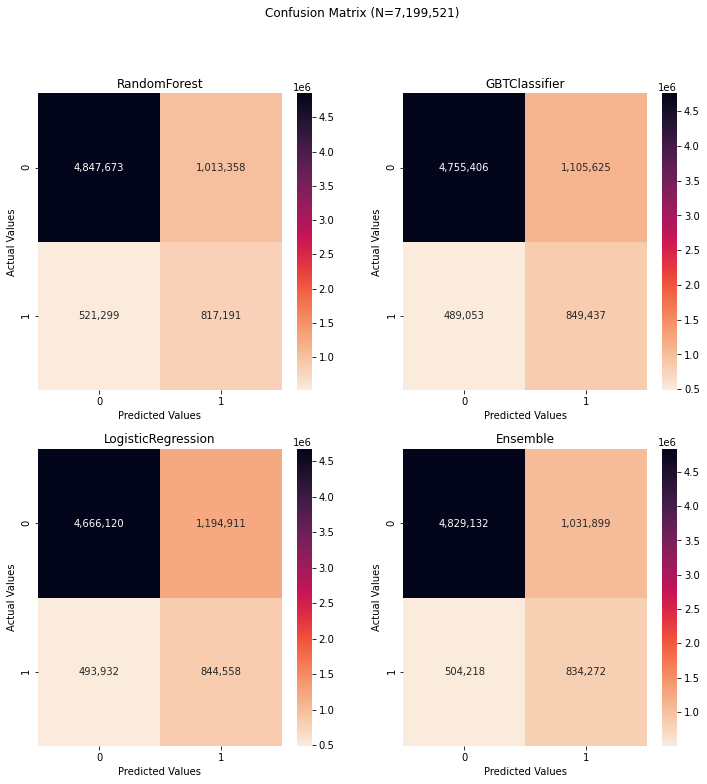

In [0]:
import matplotlib.pyplot as plt
import seaborn as sn


fig, axes = plt.subplots(2,2, figsize=(12, 12))
data = [
  ["RandomForest", 1013358, 521299, 4847673, 817191],
  ["GBTClassifier", 1105625, 489053, 4755406, 849437],
  ["LogisticRegression", 1194911, 493932, 4666120, 844558],
  ["Ensemble", 1031899, 504218, 4829132, 834272],  
]
def confusion_matrix(ax, model_name: str, tp, fp, tn, fn):
    cm_array = [[tn, tp], [fp, fn]]
    sn.heatmap(cm_array, annot=True, cmap= 'rocket_r', fmt=',', ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    
fig.suptitle(f"Confusion Matrix (N={sum([1013358, 521299, 4847673, 817191]):,})")
for ax, values in zip(axes.flatten(), data):
    confusion_matrix(ax, *values)

#### 6-3 Novel Aspects of the project
 For detailed Ensemble method, Model Selection and Feature Importance pipeline, refer to the notebook: https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/Model%20Selection%20and%20Ensemble.ipynb
   
   ##### Ensemble Method
   Although we can possibly select the best model among three models, it means we are ignoring the insight from the rest of models. Each model we tried can have a different bias towards the problem we are solving. For example, logistic regression is good at capturing linear relationship between variables while tree-based models are able to take into account nonlinearities; random forest builds each tree independently while GBT builds trees sequentially and focuses on the difficult data points. We would like to see if doing ensemble on top of three trained models can generate better predictions.
   
   After fine-tuning each model, we retrained it on the full training set, and applied it to the test set to get its prediction. Then we took the majority vote to determine the final decision and compared it with ground truth. In the results shown above, we found this approach does not outperform the state-of-the-art model (GBT model) in our study. The ensemble model turns out to be the second best model in the final comparison, ranked by fbeta(beta = 2). It demonstrates comparable recall and the highest precision. Even though it does not perform the best, its averaged results is still considered as robust due to the nature of ensemble method. 
   
   ##### Discussion on Feature Importance
   When looking at feature importance for the 2 tree-based models (Logistic Regression involves many one-hot encoded features so its feature importance is not directly comparable with the other tree-based models so it is not discussed here), we find that both models agree that the feature we engineered called `prev_fl_del` was the most important. This is the indicator feature which represents whether a plane was delayed on its prior flight. In a practical sense this is satisfying in that it suggests the feature was well engineered, but in an explanatory sense it is not very helpful, since it seems to say that the main cause of flight delays is flight delays. However this should be useful information for airlines as it would allow them to communicate possible delays to passengers earlier if they know that the plane's prior flight was delayed.
   
   Two other features we engineered also both appear in the list of most important features for both models - `avg_delay_ORIGIN` and `poten_for_delay`. The first of these is the rolling window of average flight delay rate at the origin airport 2-6 hours prior to departure. Intuitively it makes sense that this is an important feature because it captures both a sense of the conditions at the airport prior to departure, as well as the between-airport variance in delay rate that we identified in EDA. But again it does not offer much in the way of explanatory information. The `poten_for_delay` feature identifies flights where airplanes are scheduled to turn around quickly at the airport to go on to their next flight. From the airlines' perspective this feature's importance is potentially useful information, since scheduling is an area where they do have more control, and it at least gives them one potential dial to turn if they want to decide to try to reduce flight delays at the cost of having planes spend more time at airports between flights.
   
   We are interested to note that none of the weather data features come out as being particularly important to either model. Although some of them appear in the top 10, their importances are so small that they are liable to drop down the list on another training run due to the random nature of the models. From this we might conclude that generally planes are well-engineered enough to be used in the weather conditions that are prevalent in the United States most of the time, and that local capacity, passenger volume, scheduling issues, etc. are more important in creating flight delays. Also, we dropped around 1.5% of the flight records that didn't contain the outcome variable because they were canceled flights, and since many of those records reflect flights which were abandoned due to extreme weather events, we effectively removed most of the records where weather data would have had strong predictive power.

In [0]:
displayHTML("<img src='https://raw.githubusercontent.com/toby-p/project-images/master/gbt-fi.png' width=900>")

In [0]:
displayHTML("<img src='https://raw.githubusercontent.com/toby-p/project-images/master/rf-fi.png' width=900>")

### 7 - Course Concepts

##### 7-1 Bias variance tradeoff
  Total errors of a model consists of bias, variance and irreducible errors. Bias measures how accurately a model can predict, variance measures how stable a model behaves on different dataset, and irreducible error is the uncertainty that cannot be learned. A good model should be able to achieve low bias and low variance, meaning it should perform well on both training and unseen test set. Yet practically, it is hard to reduce both bias and variance at the same time and it is necessary to trade off between them. In our case, we use regularization to prevent model from growing too complex and giving high variance. In logistic regression, we apply L1/L2/elastic regularization to handle bias-variance tradeoff. For tree-based models, such as Random Forest and GBT, this can be done through hyperparameters such max depth of the trees. Models with different hyperparameters are evaluated through cross validation and best hyperparameters are selected based on the average results of experiments. 
  
  \\[Error =  Bias^2 + Variance + Irreducible Error\\]

##### 7-2 Caching 

Caching is used in Spark to persist data which is needed more than once and is expensive to compute between iterations, so that the overall execution time of a program can be greatly reduced. Our pipeline makes use of caching to improve the training times of models when grid-searching a parameter space. Due to the exponential nature of grid-searching a parameter space, where adding a new feature or parameter to test can double the number of models needing to be trained, it is essential to make sure the code can run as efficiently as possible. In cross-validated grid-search we further need to train each model iteration on multiple different splits of training data, which makes the program even more costly. Caching is deployed here to reduce the runtime by first producing the train-validation subsets of the training set, then caching them, then training each model iteration on the cached data. Because cross-validation on time-series data requires the data to be sorted before being split into train-validation sets, caching in this way prevents the sorting and filtering of the data from having to be done more than once when training multiple models.

##### 7-3 One Hot Encoding
  
  One hot encoding is a pre-process to convert categorical variables into a form that could be provided to ML algorithms to improve in prediction. Since our baseline algorithm is logistic regression which is unable to work with categorical variables directly, we set up a ML pipeline to apply one-hot encoding that can transform each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. One-Hot Encoding is the process of creating dummy variables. It helps create additional features based on the number of unique values in the categorical feature. Basically every unique value in one category will be added as a feature and has a value of 1 for that categorical value and 0 for all other observations. 
  We chose to apply One-Hot Encoding when the categorical feature is not ordinal, and the number of categorical features is small. The disadvantage is that for high cardinality categorical feature where the categorical dataset has huge number of values, this can lead to sparse vectors in the feature space, high memory consumption and increase compute time.

##### 7-4 Normalization

  Normalizing features is important for models that uses gradient descent. This transformation subtracts the mean from each value and divide the result by the standard deviation. During optimization, gradient descent will minimize the cost function towards the direction of largest gradient. With different scales of each dimension, the gradient will not be pointing to the minimum directly; instead, its path will look like a zig-zag pattern. Without going to the best direction, it requires more iterations for the algorithm to converge. When applying normalization, each dimension will have the same scale, making the contour of cost function more circular. This will help the gradient to move towards the minimum directly and takes less steps to get there. Therefore, it is generally a good practice to apply normalization before fitting a model that uses gradient descent to speed up the training process. Yet we need to pay attention that when applying such transformation, the training set and test set should be normalized using the same mean and standard deviation from the training set without touching unseen data.
  
\\[z =  \dfrac{x - \mu}{\sigma}\\]

##### 7-5 Gradient Descent - Convex Optimization

Gradient Descent is an iterative algorithm that makes use of convex function optimization to find the best model parameters. Supervised machine learning algorithms commonly involve creating a loss function which mathematically expresses how wrong a model's predictions are, and then trying to iteratively improve the predictions to reduce the result of the loss function. The method of "convex optimization" can be used to aid this task when the function meets certain conditions:

* "First Order Condition" - means that when the first derivative of a function is zero (its "roots"), the function itself is either minimized or maximized.
* "Second Order Condition" - means that when the second order derivative of a function at its roots is positive, the function is at a minimum, and conversely if it is negative the function is at a maximum.

Convex functions are particularly useful in this second regard, because for these functions the sign of the second derivative never changes. Gradient Descent is an algorithm for "descending" the "gradients" of these functions to try to approach the point where it is minimized (or maximized), by computing the partial derivatives of the function.

Two of the 3 algorithms used in this project make use of gradient descent - the Gradient Boosted Trees algorithm uses gradient descent to compute the gradient of the logistic loss function of the tree's classifications at each iteration. In Logistic Regression, gradient descent is typically used to minimize the Log Loss of the algorithms's predictions, which is defined as:

$$
LogLoss = \sum_{(x, y) \in D} -y(\log y\prime) - (1-y) \log(1-y\prime)
$$

### 8 - Reference


[1] World Bank. Air Transport, Passenger Carried. Available online: https://data.worldbank.org/indicator/IS.AIR.PSGR (accessed on 6 June 2021).

[2] Bureau of Transportation Statistics, “Bureau of Transportation Statistics”

[3] Factors Influencing Flight Delays Of a European Airline Martina Zámková1 , Martin Prokop1 , Radek Stolín1 1 Department of Mathematics, College of Polytechnics Jihlava, Tolstého 16, 586 01 Jihlava, Czech Republic

[4] This method for dropping duplicates adapted from: https://stackoverflow.com/a/54738843/6286540

[5] Hastie et al. https://en.wikipedia.org/wiki/Gradient_boosting#:~:text=Size%20of%20trees%5Bedit%20source%5D

[6] OpenFlight Dataset for Data Join: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

### 9 - Appendix (Code)

1. EDA Notebook (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/EDA%20-%20Full%20Dataset.ipynb)
2. Final Data Pipeline (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/Full%20Data%20Pipeline.ipynb)
3. CV GridSearch (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/CV%20Gridsearch.ipynb)
4. Model Selection and Ensemble (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/Model%20Selection%20and%20Ensemble.ipynb)
5. Pipeline: Full_Data_Pipeline.py (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/Full%20Data%20Pipeline.py)
6. Pipeline: final_model.py (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/final_model.py)
7. Pipeline: gridsearch_cv.py (https://github.com/UCB-w261/w261-f21-finalproject-team-08/blob/main/gridsearch_cv.py)